<a href="https://colab.research.google.com/github/bardiaHSZD/ComputerVisionVFX/blob/main/Ship_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaofen-3 Ship Image Classification


---

In this notebook, an object detection and item classification pipeline is provided for a ship dataset labeled by SAR experts, created using 102 Chinese Gaofen-3 images and 108 Sentinel-1 images. It consists of 39,729 ship chips(remove some repeat clips) of 256 pixels in both range and azimuth. These ships mainly have distinct scales and backgrounds. It can be used to develop object detectors for multi-scale and small object detection. 

### **Step 0-I: Import Datasets and Exploring Images**

Download the [ship dataset](https://github.com/CAESAR-Radi/SAR-Ship-Dataset).  Unzip the folder and place it in this project's home directory, at the location `/ship_dataset`. 

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from glob import glob

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True 
vessel_files = np.array(glob("/content/drive/MyDrive/ship_dataset/*/*/*"))
print('There are %d total ship images.' % len(vessel_files))

There are 39729 total ship images.


In [ ]:
import numpy as np
from glob import glob

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True # added to fix exception IOError: image file truncated” with big images
# load filenames for human and dog images
#dog_files = np.array(glob("/data/dog_images/*/*/*"))
vessel_files = np.array(glob("/content/drive/MyDrive/ship_dataset/*/*/*"))
gao_files = np.array(glob("/content/drive/MyDrive/ship_dataset/test/001.Gao/*"))
new_files = np.array(glob("/content/drive/MyDrive/ship_dataset/test/002.Newship/*"))
sen_files = np.array(glob("/content/drive/MyDrive/ship_dataset/test/003.Sen/*"))
ship_files = np.array(glob("/content/drive/MyDrive/ship_dataset/test/004.Ship/**"))

# print number of images in each dataset
print('There are %d total test Gao images.' % len(gao_files))
print('There are %d total test Newship images.' % len(new_files))
print('There are %d total test Sen images.' % len(sen_files))
print('There are %d total test other ship images.' % len(ship_files))
print('There are %d total test ship images.' % len(vessel_files))

There are 2099 total test Gao images.
There are 113 total test Newship images.
There are 2260 total test Sen images.
There are 37 total test other ship images.
There are 39729 total test ship images.


A quick look at the images.

In [ ]:
import matplotlib.pyplot as plt 
from PIL import Image
 
def plot():
    
    # create figure
    fig = plt.figure(figsize=(20, 20))
    # setting values to rows and column variables
    rows = 4
    columns = 4

    for i,k in enumerate(range(1,17)):
        if k <= 4:
            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, k)
            plt.title('Gao Ship Sample #'+ str(k))
            # showing image
            img = Image.open(gao_files[i])
            plt.imshow(img)
            plt.axis("off")
        elif k > 4 and k < 9: 
            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, k)
            plt.title('New Ship Sample #'+ str(k))
            # showing image
            img = Image.open(new_files[i])
            plt.imshow(img)
            plt.axis("off")
        elif k >= 9 and k < 13: 
            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, k)
            plt.title('Sen Ship Sample #'+ str(k))
            # showing image
            img = Image.open(sen_files[i])
            plt.imshow(img)
            plt.axis("off")
        elif k >= 13 and k < 17: 
            # Adds a subplot at the 1st position
            fig.add_subplot(rows, columns, k)
            plt.title('Other Ship Sample #'+ str(k))
            # showing image
            img = Image.open(ship_files[i])
            plt.imshow(img)
            plt.axis("off")                       
            
    plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0.25, right = 1, left = 0.6)

    

#Implementation of the function 

plot()

A quick look at pixel intensity of images.

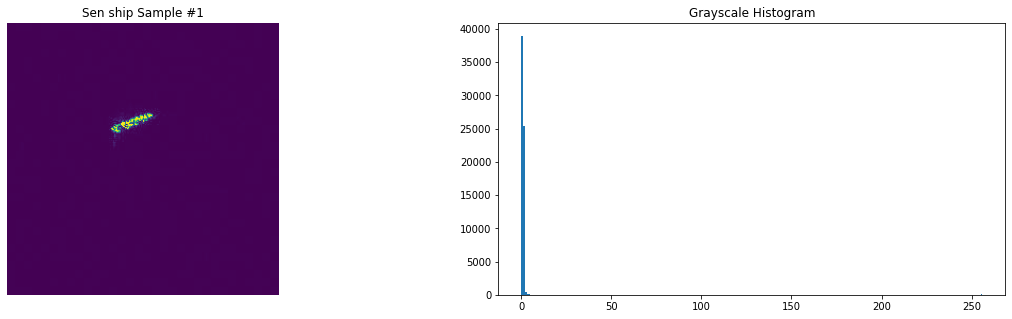

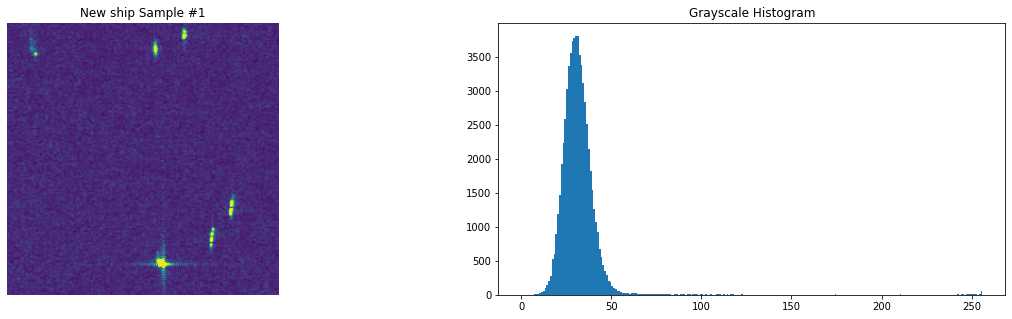

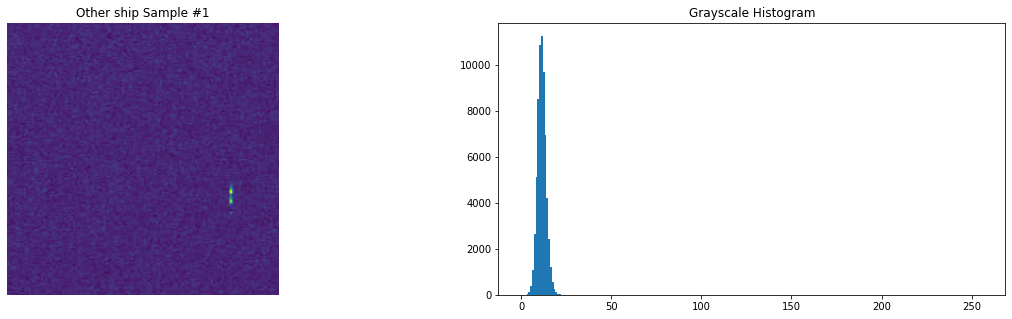

In [ ]:
import cv2                
import matplotlib
import matplotlib.pyplot as plt                        
%matplotlib inline 
from PIL import Image

def plotHistogram(ship, type):

    # create figure
    fig = plt.figure(figsize=(20, 5))
    # setting values to rows and column variables
    rows = 1
    columns = 2

    k = 1
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, k)
    plt.title(type + ' ship Sample #' + str(k))
    # showing image
    plt.axis("off")


    # load color (BGR) image
    img = cv2.imread(ship)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
    plt.imshow(gray)
    #plt.show()

    k = 2
    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, k)
    img = cv2.imread(ship, 0)
    plt.hist(img.ravel(), 256, (0, 256))
    plt.title("Grayscale Histogram")
    #,255)
    plt.show()

for i in range (1,2):
    plotHistogram(gao_files[i], "Gao")
    plotHistogram(sen_files[i], "Sen") 
    plotHistogram(new_files[i], "New")
    plotHistogram(ship_files[i], "Other")          

###**Step 0-II: Pre-process Data via Ship Detection/Segmentation**

####**Step 0-II-1: The Overview**

In [48]:
import skimage.io
from IPython.display import Image
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
# Read image into scimage package
sample_data_file_name = '/content/drive/MyDrive/ship_detection/Gao_ship_hh_02016082545020405.jpg'
# Display original image
display(Image(filename=sample_data_file_name))
img = skimage.io.imread(sample_data_file_name[:-4]+'.jpg')
img = 256*denoise_tv_chambolle(img, weight=0.5)
skimage.io.imsave('/content/drive/MyDrive/ship_detection/output/original.png', img)
print('After low-pass filtering, i.e. reducing the noise ...')
# Display the filtered image
display(Image(filename='/content/drive/MyDrive/ship_detection/output/original.png'))

After low-pass filtering, i.e. reducing the noise ...


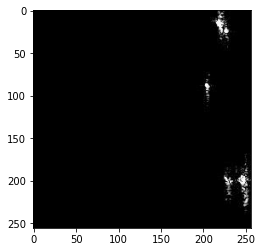

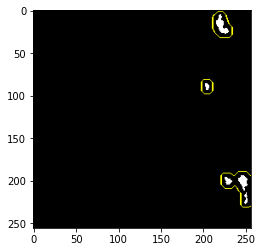

Ship 1: 


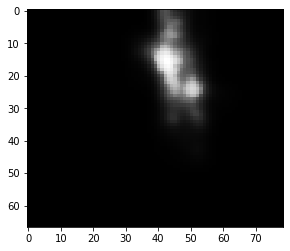

Ship 2: 


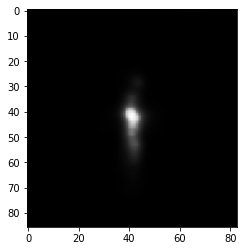

Ship 3: 


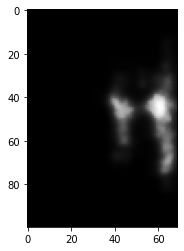

In [49]:
import json
import gdal
import osr
import numpy
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import os
import glob

files = glob.glob('/content/drive/MyDrive/ship_detection/output/*')
for f in files:
    os.remove(f)

# Open image with gdal
ds = gdal.Open(sample_data_file_name)
xoff, a, b, yoff, d, e = ds.GetGeoTransform()

# Get projection information from source image
ds_proj = ds.GetProjectionRef()
ds_srs = osr.SpatialReference(ds_proj)

# Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
geogcs = ds_srs.CloneGeogCS()

# Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
transform = osr.CoordinateTransformation(ds_srs, geogcs)

# Convert multi-channel image it into red, green and blueb[, alpha] channels 

if len(img.shape) == 3:
  red, green, blue = numpy.rollaxis(numpy.array(img), axis=-1)
  alpha = red
else:
  red = numpy.rollaxis(numpy.array(img), axis=-1)
  alpha = red

# Mask: threshold + stops canny detecting image boundary edges
mask = red > 100

# Create mask for edge detection
skimage.io.imsave('/content/drive/MyDrive/ship_detection/output/mask.png', mask * 255)

# Use Felzenszwalb algo to find segements
segments_fz = felzenszwalb(numpy.dstack((mask, mask, mask)),
                               scale=5000,
                               sigma=3.1,
                               min_size=25) 

# Build labeled mask to show where ships were dectected
segmented_img = mark_boundaries(mask, segments_fz)
skimage.io.imsave('/content/drive/MyDrive/ship_detection/output/mask_labeled.png', segmented_img)


# Preserve the bounding box for display of copped immages
bounding_boxes = []


# Count ships and save image of each boat clipped from masked image
for idx, ship in enumerate(regionprops(segments_fz)):
    # If area matches that of a stanard ship, count it
    if (ship.area >= 10 and ship.area <= 1000):
        
        # Create ship thumbnail
        x, y = (int(numpy.average([ship.bbox[0],
                                ship.bbox[2]])),
                                int(numpy.average([ship.bbox[1],
                                ship.bbox[3]])))
        sx, ex = max(ship.bbox[0]-35,0), min(ship.bbox[2]+35,img.shape[0] - 1)#max(x - 15, 0), min(x + 15, img.shape[0] - 1)
        sy, ey = max(ship.bbox[1]-35,0), min(ship.bbox[3]+35,img.shape[1] - 1)#max(y - 15, 0), min(y + 15, img.shape[1] - 1)
        img_ship = img[sx:ex, sy:ey]
        bounding_boxes.append({
            'x1': ship.bbox[0],
            'x2': ship.bbox[2],
            'y1': ship.bbox[1],
            'y2': ship.bbox[3]})
        skimage.io.imsave('/content/drive/MyDrive/ship_detection/output/ship-%s.png' % str(idx), img_ship)

        # Get global coordinates from pixel x, y coords
        projected_x = float(a * y + b * x + xoff)
        projected_y = float(d * y + e * x + yoff)

        

# Display results
# Display the image
from PIL import Image
plt.imshow(Image.open(sample_data_file_name))
plt.show()

# Display labled mask where we detected ships
plt.imshow(Image.open('/content/drive/MyDrive/ship_detection/output/mask_labeled.png'))
plt.show()
# Display each individual ship cropped out of the original image
import glob
number = 1
for filepath in glob.iglob('/content/drive/MyDrive/ship_detection/output/ship*.png'):
    print('Ship {}: '. format(number))
    number += 1
    plt.imshow(Image.open(filepath))
    plt.show()    

####**Step 0-II-2: Prepare Detected Images for Classification**

Remove previous files from train, validation, and test folders 

In [2]:
def clearDirectories():
  import glob

  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/train/001.Gao/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/valid/001.Gao/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/test/001.Gao/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/train/002.Newship/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/valid/002.Newship/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/test/002.Newship/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/train/003.Sen/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/valid/003.Sen/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/test/003.Sen/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/train/004.Ship/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/valid/004.Ship/*')
  for f in files:
      os.remove(f)
  files = glob.glob('/content/drive/MyDrive/ship_detection_segmented/test/004.Ship/*')
  for f in files:
      os.remove(f)

Prepare cropped images of detected ships.

In [3]:
import skimage.io
from IPython.display import Image

import json
import gdal
import osr
import numpy
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
from skimage.measure import regionprops
import matplotlib.pyplot as plt
import os
import glob

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)


def prepareCroppedImages(source_folder, sample_data_file_name, 
                         file_format, output_folder, ship_type,
                         min_area, max_area, min_mask_value, denoising_weight):


  # Read and denoise image into scimage package
  img = skimage.io.imread(source_folder+'/'+sample_data_file_name+file_format)
  img = 255*denoise_tv_chambolle(img, weight=denoising_weight)


  #skimage.io.imsave(output_folder+'/original.png', img)

  # Open image with gdal
  ds = gdal.Open(source_folder+'/'+sample_data_file_name+file_format)
  xoff, a, b, yoff, d, e = ds.GetGeoTransform()

  # Get projection information from source image
  ds_proj = ds.GetProjectionRef()
  ds_srs = osr.SpatialReference(ds_proj)

  # Get the source image's geographic coordinate system (the 'GEOGCS' node of ds_srs)
  geogcs = ds_srs.CloneGeogCS()

  # Set up a transformation between projected coordinates (x, y) & geographic coordinates (lat, lon)
  transform = osr.CoordinateTransformation(ds_srs, geogcs)

  # Convert multi-channel image it into red, green and blueb[, alpha] channels 

  if len(img.shape) == 3:
    red, green, blue = numpy.rollaxis(numpy.array(img), axis=-1)
    alpha = red
  else:
    red = numpy.rollaxis(numpy.array(img), axis=-1)
    alpha = red
  # Mask: threshold + stops canny detecting image boundary edges
  mask = red > min_mask_value

  # Create mask for edge detection
  #skimage.io.imsave(output_folder+'/mask.png', mask * 255)

  # Use Felzenszwalb algo to find segements
  segments_fz = felzenszwalb(numpy.dstack((mask, mask, mask)),
                                scale=5000,
                                sigma=3.1,
                                min_size=25) 

  # Build labeled mask to show where ships were dectected
  segmented_img = mark_boundaries(mask, segments_fz)
  #skimage.io.imsave(output_folder+'/mask_labeled.png', segmented_img)


  # Preserve the bounding box for display of copped immages
  bounding_boxes = []


  # Count ships and save image of each boat clipped from masked image
  for idx, ship in enumerate(regionprops(segments_fz)):
      # If area matches that of a stanard ship, count it
      if (ship.area >= min_area and ship.area <= max_area):
          
          
          # Create ship thumbnail
          x, y = (int(numpy.average([ship.bbox[0],
                                  ship.bbox[2]])),
                                  int(numpy.average([ship.bbox[1],
                                  ship.bbox[3]])))
          sx, ex = max(ship.bbox[0]-35,0), min(ship.bbox[2]+35,img.shape[0] - 1)#max(x - 15, 0), min(x + 15, img.shape[0] - 1)
          sy, ey = max(ship.bbox[1]-35,0), min(ship.bbox[3]+35,img.shape[1] - 1)#max(y - 15, 0), min(y + 15, img.shape[1] - 1)
          img_ship = img[sx:ex, sy:ey]
          bounding_boxes.append({
              'x1': ship.bbox[0],
              'x2': ship.bbox[2],
              'y1': ship.bbox[1],
              'y2': ship.bbox[3]})
          skimage.io.imsave(output_folder+'/'+sample_data_file_name+'_ship-%s.png' % str(idx), img_ship)

          # Get global coordinates from pixel x, y coords
          projected_x = float(a * y + b * x + xoff)
          projected_y = float(d * y + e * x + yoff)
  return bounding_boxes          

Perform cropping based on different classes of ships available in the train, validation and test folders.

In [4]:
import warnings
warnings.filterwarnings("ignore")

source_folder = ['/content/drive/MyDrive/ship_dataset/train/001.Gao',
                 '/content/drive/MyDrive/ship_dataset/valid/001.Gao',
                 '/content/drive/MyDrive/ship_dataset/test/001.Gao',
                 '/content/drive/MyDrive/ship_dataset/train/002.Newship',
                 '/content/drive/MyDrive/ship_dataset/valid/002.Newship',
                 '/content/drive/MyDrive/ship_dataset/test/002.Newship',
                 '/content/drive/MyDrive/ship_dataset/train/003.Sen',
                 '/content/drive/MyDrive/ship_dataset/valid/003.Sen',
                 '/content/drive/MyDrive/ship_dataset/test/003.Sen',
                 '/content/drive/MyDrive/ship_dataset/train/004.Ship',
                 '/content/drive/MyDrive/ship_dataset/valid/004.Ship',
                 '/content/drive/MyDrive/ship_dataset/test/004.Ship']
output_folder = ['/content/drive/MyDrive/ship_detection_segmented/train/001.Gao',
                 '/content/drive/MyDrive/ship_detection_segmented/valid/001.Gao',
                 '/content/drive/MyDrive/ship_detection_segmented/test/001.Gao',
                 '/content/drive/MyDrive/ship_detection_segmented/train/002.Newship',
                 '/content/drive/MyDrive/ship_detection_segmented/valid/002.Newship',
                 '/content/drive/MyDrive/ship_detection_segmented/test/002.Newship',
                 '/content/drive/MyDrive/ship_detection_segmented/train/003.Sen',
                 '/content/drive/MyDrive/ship_detection_segmented/valid/003.Sen',
                 '/content/drive/MyDrive/ship_detection_segmented/test/003.Sen',
                 '/content/drive/MyDrive/ship_detection_segmented/train/004.Ship',
                 '/content/drive/MyDrive/ship_detection_segmented/valid/004.Ship',
                 '/content/drive/MyDrive/ship_detection_segmented/test/004.Ship']

min_area = [800.0,
            800.0,
            800.0,
            800.0,
            800.0,
            800.0,
            800.0,
            800.0,
            800.0,
            500.0,
            500.0,
            500.0]

max_area = [5000.0,
            5000.0,
            5000.0,
            5000.0,
            5000.0,
            5000.0,
            5000.0,
            5000.0,
            5000.0,
            1000.0,
            1000.0,
            1000.0]

min_mask_value = [100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  100.0,
                  60.0]

denoising_weight = [0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.1,
                    0.001,
                    0.001,
                    0.001]
# Clear existing files in destination folders
clearDirectories()

sample_data_file_name = ''
file_format = '.jpg'
MAX_COUNT = 5000
for i in range (0,len(output_folder)):
  counter = 0
  print('Processing Folder: ' + source_folder[i] + '...')
  files = glob.glob(source_folder[i]+'/*')
  for path in files:
      sample_data_file_name = os.path.basename(path)
      counter += 1
      if counter <= MAX_COUNT:
        print("File Number: ", counter)
        try:
          prepareCroppedImages(source_folder = source_folder[i], 
                                  sample_data_file_name = sample_data_file_name[:-4],
                                  file_format = '.jpg', 
                                  output_folder = output_folder[i], 
                                  ship_type = i,
                                  min_area = min_area[i],
                                  max_area = max_area[i],
                                  min_mask_value = min_mask_value[i],
                                  denoising_weight = denoising_weight[i])
        except:
          continue
      

Processing Folder: /content/drive/MyDrive/ship_dataset/train/001.Gao...
File Number:  1
File Number:  2
File Number:  3


File Number:  4
File Number:  5
File Number:  6
File Number:  7


File Number:  8
File Number:  9


File Number:  10


File Number:  11


File Number:  12


File Number:  13


File Number:  14


File Number:  15


File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20


File Number:  21


File Number:  22
File Number:  23


File Number:  24
File Number:  25


File Number:  26


File Number:  27


File Number:  28


File Number:  29


File Number:  30


File Number:  31


File Number:  32
File Number:  33


File Number:  34


File Number:  35


File Number:  36


File Number:  37
File Number:  38


File Number:  39


File Number:  40


File Number:  41


File Number:  42


File Number:  43


File Number:  44


File Number:  45


File Number:  46


File Number:  47
File Number:  48


File Number:  49


File Number:  50


File Number:  51


File Number:  52
File Number:  53


File Number:  54


File Number:  55


File Number:  56


File Number:  57


File Number:  58
File Number:  59


File Number:  60


File Number:  61
File Number:  62


File Number:  63
File Number:  64
File Number:  65
File Number:  66


File Number:  67


File Number:  68


File Number:  69


File Number:  70


File Number:  71


File Number:  72
File Number:  73
File Number:  74


File Number:  75
File Number:  76
File Number:  77
File Number:  78


File Number:  79


File Number:  80
File Number:  81


File Number:  82


File Number:  83


File Number:  84
File Number:  85
File Number:  86


File Number:  87


File Number:  88


File Number:  89
File Number:  90
File Number:  91
File Number:  92


File Number:  93
File Number:  94


File Number:  95
File Number:  96


File Number:  97


File Number:  98


File Number:  99
File Number:  100
File Number:  101
File Number:  102
File Number:  103
File Number:  104
File Number:  105


File Number:  106
File Number:  107


File Number:  108


File Number:  109


File Number:  110
File Number:  111
File Number:  112


File Number:  113


File Number:  114
File Number:  115
File Number:  116
File Number:  117
File Number:  118
File Number:  119


File Number:  120


File Number:  121


File Number:  122


File Number:  123


File Number:  124
File Number:  125
File Number:  126


File Number:  127


File Number:  128


File Number:  129


File Number:  130
File Number:  131
File Number:  132
File Number:  133
File Number:  134
File Number:  135


File Number:  136
File Number:  137
File Number:  138
File Number:  139
File Number:  140
File Number:  141


File Number:  142


File Number:  143
File Number:  144
File Number:  145
File Number:  146
File Number:  147


File Number:  148


File Number:  149
File Number:  150
File Number:  151
File Number:  152


File Number:  153


File Number:  154
File Number:  155
File Number:  156


File Number:  157
File Number:  158
File Number:  159


File Number:  160
File Number:  161


File Number:  162


File Number:  163
File Number:  164
File Number:  165


File Number:  166


File Number:  167
File Number:  168
File Number:  169


File Number:  170


File Number:  171
File Number:  172
File Number:  173
File Number:  174


File Number:  175
File Number:  176


File Number:  177


File Number:  178


File Number:  179


File Number:  180
File Number:  181


File Number:  182


File Number:  183


File Number:  184


File Number:  185


File Number:  186


File Number:  187
File Number:  188


File Number:  189
File Number:  190


File Number:  191


File Number:  192
File Number:  193


File Number:  194


File Number:  195
File Number:  196


File Number:  197
File Number:  198


File Number:  199
File Number:  200


File Number:  201


File Number:  202


File Number:  203
File Number:  204


File Number:  205


File Number:  206


File Number:  207


File Number:  208


File Number:  209


File Number:  210


File Number:  211
File Number:  212


File Number:  213
File Number:  214
File Number:  215
File Number:  216


File Number:  217


File Number:  218
File Number:  219


File Number:  220


File Number:  221
File Number:  222


File Number:  223
File Number:  224
File Number:  225
File Number:  226


File Number:  227


File Number:  228


File Number:  229


File Number:  230


File Number:  231
File Number:  232


File Number:  233
File Number:  234


File Number:  235


File Number:  236


File Number:  237


File Number:  238
File Number:  239


File Number:  240
File Number:  241


File Number:  242


File Number:  243
File Number:  244
File Number:  245


File Number:  246


File Number:  247
File Number:  248
File Number:  249


File Number:  250


File Number:  251


File Number:  252


File Number:  253


File Number:  254


File Number:  255


File Number:  256
File Number:  257
File Number:  258
File Number:  259
File Number:  260


File Number:  261
File Number:  262
File Number:  263
File Number:  264


File Number:  265


File Number:  266


File Number:  267
File Number:  268


File Number:  269
File Number:  270


File Number:  271


File Number:  272


File Number:  273


File Number:  274


File Number:  275
File Number:  276


File Number:  277
File Number:  278
File Number:  279


File Number:  280
File Number:  281


File Number:  282


File Number:  283


File Number:  284
File Number:  285


File Number:  286
File Number:  287


File Number:  288


File Number:  289


File Number:  290
File Number:  291
File Number:  292
File Number:  293


File Number:  294


File Number:  295


File Number:  296
File Number:  297


File Number:  298


File Number:  299


File Number:  300
File Number:  301


File Number:  302


File Number:  303


File Number:  304


File Number:  305


File Number:  306


File Number:  307


File Number:  308


File Number:  309


File Number:  310
File Number:  311


File Number:  312


File Number:  313


File Number:  314
File Number:  315


File Number:  316


File Number:  317


File Number:  318


File Number:  319


File Number:  320
File Number:  321


File Number:  322


File Number:  323


File Number:  324


File Number:  325
File Number:  326


File Number:  327
File Number:  328


File Number:  329
File Number:  330
File Number:  331


File Number:  332


File Number:  333
File Number:  334
File Number:  335
File Number:  336
File Number:  337
File Number:  338


File Number:  339


File Number:  340


File Number:  341


File Number:  342
File Number:  343
File Number:  344


File Number:  345
File Number:  346


File Number:  347


File Number:  348
File Number:  349


File Number:  350
File Number:  351
File Number:  352


File Number:  353
File Number:  354
File Number:  355
File Number:  356


File Number:  357


File Number:  358
File Number:  359


File Number:  360
File Number:  361


File Number:  362


File Number:  363


File Number:  364
File Number:  365


File Number:  366
File Number:  367


File Number:  368
File Number:  369


File Number:  370
File Number:  371
File Number:  372


File Number:  373


File Number:  374


File Number:  375


File Number:  376
File Number:  377


File Number:  378


File Number:  379


File Number:  380


File Number:  381


File Number:  382


File Number:  383


File Number:  384
File Number:  385


File Number:  386


File Number:  387


File Number:  388


File Number:  389


File Number:  390
File Number:  391
File Number:  392


File Number:  393


File Number:  394
File Number:  395


File Number:  396


File Number:  397


File Number:  398
File Number:  399


File Number:  400
File Number:  401
File Number:  402


File Number:  403


File Number:  404


File Number:  405


File Number:  406


File Number:  407


File Number:  408


File Number:  409


File Number:  410


File Number:  411
File Number:  412


File Number:  413


File Number:  414
File Number:  415


File Number:  416
File Number:  417


File Number:  418


File Number:  419


File Number:  420


File Number:  421


File Number:  422


File Number:  423


File Number:  424


File Number:  425


File Number:  426


File Number:  427


File Number:  428
File Number:  429


File Number:  430
File Number:  431


File Number:  432


File Number:  433
File Number:  434


File Number:  435


File Number:  436


File Number:  437


File Number:  438


File Number:  439


File Number:  440
File Number:  441
File Number:  442


File Number:  443
File Number:  444
File Number:  445


File Number:  446
File Number:  447


File Number:  448
File Number:  449


File Number:  450


File Number:  451


File Number:  452


File Number:  453
File Number:  454


File Number:  455


File Number:  456


File Number:  457


File Number:  458


File Number:  459
File Number:  460
File Number:  461


File Number:  462
File Number:  463


File Number:  464


File Number:  465
File Number:  466


File Number:  467
File Number:  468


File Number:  469
File Number:  470


File Number:  471


File Number:  472


File Number:  473
File Number:  474


File Number:  475


File Number:  476


File Number:  477
File Number:  478
File Number:  479
File Number:  480


File Number:  481


File Number:  482
File Number:  483


File Number:  484


File Number:  485
File Number:  486


File Number:  487
File Number:  488


File Number:  489


File Number:  490


File Number:  491


File Number:  492


File Number:  493


File Number:  494


File Number:  495


File Number:  496
File Number:  497


File Number:  498


File Number:  499


File Number:  500


File Number:  501


File Number:  502


File Number:  503


File Number:  504
File Number:  505


File Number:  506
File Number:  507


File Number:  508
File Number:  509
File Number:  510


File Number:  511
File Number:  512


File Number:  513


File Number:  514


File Number:  515


File Number:  516
File Number:  517
File Number:  518


File Number:  519


File Number:  520
File Number:  521
File Number:  522


File Number:  523


File Number:  524


File Number:  525


File Number:  526


File Number:  527
File Number:  528


File Number:  529


File Number:  530
File Number:  531


File Number:  532


File Number:  533


File Number:  534


File Number:  535


File Number:  536


File Number:  537


File Number:  538
File Number:  539


File Number:  540


File Number:  541
File Number:  542
File Number:  543


File Number:  544


File Number:  545


File Number:  546


File Number:  547


File Number:  548


File Number:  549


File Number:  550
File Number:  551


File Number:  552


File Number:  553
File Number:  554


File Number:  555


File Number:  556
File Number:  557


File Number:  558


File Number:  559


File Number:  560
File Number:  561
File Number:  562


File Number:  563


File Number:  564


File Number:  565


File Number:  566


File Number:  567
File Number:  568


File Number:  569
File Number:  570
File Number:  571
File Number:  572


File Number:  573


File Number:  574
File Number:  575


File Number:  576
File Number:  577
File Number:  578


File Number:  579
File Number:  580


File Number:  581
File Number:  582


File Number:  583
File Number:  584


File Number:  585


File Number:  586


File Number:  587
File Number:  588
File Number:  589
File Number:  590


File Number:  591
File Number:  592


File Number:  593


File Number:  594


File Number:  595
File Number:  596
File Number:  597


File Number:  598
File Number:  599


File Number:  600


File Number:  601
File Number:  602


File Number:  603


File Number:  604
File Number:  605
File Number:  606
File Number:  607


File Number:  608


File Number:  609
File Number:  610
File Number:  611


File Number:  612
File Number:  613


File Number:  614
File Number:  615
File Number:  616
File Number:  617
File Number:  618
File Number:  619


File Number:  620


File Number:  621


File Number:  622


File Number:  623


File Number:  624


File Number:  625


File Number:  626
File Number:  627


File Number:  628


File Number:  629


File Number:  630


File Number:  631


File Number:  632


File Number:  633


File Number:  634


File Number:  635
File Number:  636
File Number:  637
File Number:  638
File Number:  639
File Number:  640
File Number:  641
File Number:  642
File Number:  643


File Number:  644
File Number:  645


File Number:  646
File Number:  647


File Number:  648
File Number:  649
File Number:  650


File Number:  651


File Number:  652
File Number:  653


File Number:  654
File Number:  655


File Number:  656


File Number:  657
File Number:  658


File Number:  659


File Number:  660


File Number:  661
File Number:  662
File Number:  663
File Number:  664
File Number:  665


File Number:  666


File Number:  667


File Number:  668
File Number:  669


File Number:  670


File Number:  671
File Number:  672
File Number:  673


File Number:  674


File Number:  675


File Number:  676


File Number:  677


File Number:  678


File Number:  679
File Number:  680


File Number:  681


File Number:  682


File Number:  683
File Number:  684


File Number:  685


File Number:  686
File Number:  687


File Number:  688
File Number:  689
File Number:  690


File Number:  691


File Number:  692
File Number:  693


File Number:  694


File Number:  695


File Number:  696


File Number:  697


File Number:  698


File Number:  699


File Number:  700


File Number:  701
File Number:  702


File Number:  703


File Number:  704
File Number:  705
File Number:  706


File Number:  707
File Number:  708
File Number:  709


File Number:  710


File Number:  711
File Number:  712
File Number:  713


File Number:  714


File Number:  715
File Number:  716


File Number:  717


File Number:  718
File Number:  719


File Number:  720


File Number:  721
File Number:  722
File Number:  723
File Number:  724
File Number:  725
File Number:  726


File Number:  727


File Number:  728


File Number:  729


File Number:  730
File Number:  731
File Number:  732


File Number:  733
File Number:  734


File Number:  735


File Number:  736


File Number:  737


File Number:  738


File Number:  739


File Number:  740
File Number:  741


File Number:  742


File Number:  743
File Number:  744


File Number:  745


File Number:  746


File Number:  747
File Number:  748
File Number:  749
File Number:  750


File Number:  751
File Number:  752


File Number:  753


File Number:  754


File Number:  755


File Number:  756
File Number:  757


File Number:  758


File Number:  759
File Number:  760


File Number:  761
File Number:  762


File Number:  763
File Number:  764


File Number:  765
File Number:  766


File Number:  767
File Number:  768
File Number:  769


File Number:  770


File Number:  771


File Number:  772


File Number:  773


File Number:  774
File Number:  775
File Number:  776


File Number:  777


File Number:  778


File Number:  779
File Number:  780


File Number:  781
File Number:  782
File Number:  783
File Number:  784


File Number:  785


File Number:  786


File Number:  787


File Number:  788


File Number:  789
File Number:  790


File Number:  791


File Number:  792
File Number:  793


File Number:  794


File Number:  795
File Number:  796


File Number:  797


File Number:  798
File Number:  799


File Number:  800


File Number:  801
File Number:  802


File Number:  803
File Number:  804


File Number:  805


File Number:  806


File Number:  807


File Number:  808


File Number:  809
File Number:  810
File Number:  811


File Number:  812


File Number:  813
File Number:  814
File Number:  815


File Number:  816


File Number:  817
File Number:  818


File Number:  819


File Number:  820
File Number:  821
File Number:  822
File Number:  823


File Number:  824


File Number:  825


File Number:  826


File Number:  827
File Number:  828


File Number:  829
File Number:  830
File Number:  831


File Number:  832


File Number:  833


File Number:  834


File Number:  835


File Number:  836
File Number:  837
File Number:  838


File Number:  839
File Number:  840
File Number:  841


File Number:  842
File Number:  843


File Number:  844


File Number:  845


File Number:  846
File Number:  847


File Number:  848


File Number:  849


File Number:  850


File Number:  851
File Number:  852


File Number:  853


File Number:  854
File Number:  855
File Number:  856


File Number:  857
File Number:  858


File Number:  859


File Number:  860
File Number:  861


File Number:  862


File Number:  863


File Number:  864


File Number:  865


File Number:  866


File Number:  867
File Number:  868
File Number:  869
File Number:  870


File Number:  871
File Number:  872


File Number:  873


File Number:  874
File Number:  875
File Number:  876


File Number:  877


File Number:  878
File Number:  879


File Number:  880


File Number:  881


File Number:  882
File Number:  883
File Number:  884


File Number:  885


File Number:  886


File Number:  887


File Number:  888
File Number:  889
File Number:  890


File Number:  891
File Number:  892


File Number:  893


File Number:  894


File Number:  895
File Number:  896


File Number:  897
File Number:  898


File Number:  899


File Number:  900
File Number:  901
File Number:  902


File Number:  903


File Number:  904
File Number:  905


File Number:  906
File Number:  907


File Number:  908
File Number:  909


File Number:  910


File Number:  911


File Number:  912
File Number:  913
File Number:  914


File Number:  915


File Number:  916


File Number:  917


File Number:  918
File Number:  919


File Number:  920


File Number:  921
File Number:  922


File Number:  923
File Number:  924


File Number:  925


File Number:  926


File Number:  927


File Number:  928
File Number:  929


File Number:  930
File Number:  931


File Number:  932


File Number:  933


File Number:  934
File Number:  935
File Number:  936


File Number:  937


File Number:  938


File Number:  939


File Number:  940


File Number:  941
File Number:  942


File Number:  943


File Number:  944


File Number:  945


File Number:  946


File Number:  947
File Number:  948


File Number:  949
File Number:  950


File Number:  951
File Number:  952


File Number:  953
File Number:  954
File Number:  955


File Number:  956


File Number:  957
File Number:  958
File Number:  959
File Number:  960


File Number:  961


File Number:  962


File Number:  963
File Number:  964


File Number:  965


File Number:  966
File Number:  967


File Number:  968


File Number:  969
File Number:  970


File Number:  971
File Number:  972


File Number:  973
File Number:  974


File Number:  975


File Number:  976
File Number:  977
File Number:  978


File Number:  979


File Number:  980
File Number:  981
File Number:  982


File Number:  983


File Number:  984


File Number:  985


File Number:  986


File Number:  987


File Number:  988


File Number:  989


File Number:  990


File Number:  991


File Number:  992


File Number:  993
File Number:  994


File Number:  995


File Number:  996
File Number:  997


File Number:  998
File Number:  999


File Number:  1000
File Number:  1001
File Number:  1002


File Number:  1003
File Number:  1004


File Number:  1005
File Number:  1006
File Number:  1007
File Number:  1008


File Number:  1009
File Number:  1010
File Number:  1011
File Number:  1012


File Number:  1013
File Number:  1014
File Number:  1015
File Number:  1016
File Number:  1017


File Number:  1018
File Number:  1019


File Number:  1020
File Number:  1021


File Number:  1022


File Number:  1023


File Number:  1024


File Number:  1025
File Number:  1026
File Number:  1027
File Number:  1028


File Number:  1029


File Number:  1030


File Number:  1031
File Number:  1032


File Number:  1033
File Number:  1034
File Number:  1035
File Number:  1036
File Number:  1037


File Number:  1038


File Number:  1039
File Number:  1040


File Number:  1041
File Number:  1042


File Number:  1043


File Number:  1044
File Number:  1045
File Number:  1046


File Number:  1047
File Number:  1048


File Number:  1049
File Number:  1050
File Number:  1051


File Number:  1052
File Number:  1053


File Number:  1054


File Number:  1055
File Number:  1056
File Number:  1057
File Number:  1058
File Number:  1059
File Number:  1060
File Number:  1061
File Number:  1062


File Number:  1063
File Number:  1064


File Number:  1065


File Number:  1066


File Number:  1067
File Number:  1068


File Number:  1069


File Number:  1070
File Number:  1071
File Number:  1072


File Number:  1073
File Number:  1074


File Number:  1075
File Number:  1076
File Number:  1077


File Number:  1078
File Number:  1079


File Number:  1080


File Number:  1081
File Number:  1082
File Number:  1083
File Number:  1084


File Number:  1085


File Number:  1086
File Number:  1087
File Number:  1088
File Number:  1089
File Number:  1090
File Number:  1091


File Number:  1092


File Number:  1093
File Number:  1094


File Number:  1095
File Number:  1096


File Number:  1097


File Number:  1098


File Number:  1099
File Number:  1100


File Number:  1101
File Number:  1102
File Number:  1103
File Number:  1104
File Number:  1105


File Number:  1106


File Number:  1107


File Number:  1108
File Number:  1109


File Number:  1110
File Number:  1111
File Number:  1112
File Number:  1113
File Number:  1114


File Number:  1115


File Number:  1116


File Number:  1117


File Number:  1118
File Number:  1119
File Number:  1120


File Number:  1121


File Number:  1122


File Number:  1123


File Number:  1124


File Number:  1125


File Number:  1126
File Number:  1127


File Number:  1128


File Number:  1129


File Number:  1130


File Number:  1131


File Number:  1132


File Number:  1133


File Number:  1134
File Number:  1135


File Number:  1136
File Number:  1137


File Number:  1138


File Number:  1139


File Number:  1140
File Number:  1141


File Number:  1142


File Number:  1143


File Number:  1144
File Number:  1145


File Number:  1146


File Number:  1147


File Number:  1148


File Number:  1149
File Number:  1150
File Number:  1151
File Number:  1152


File Number:  1153


File Number:  1154


File Number:  1155


File Number:  1156


File Number:  1157
File Number:  1158


File Number:  1159


File Number:  1160


File Number:  1161


File Number:  1162


File Number:  1163


File Number:  1164


File Number:  1165


File Number:  1166
File Number:  1167


File Number:  1168


File Number:  1169


File Number:  1170


File Number:  1171


File Number:  1172


File Number:  1173


File Number:  1174
File Number:  1175


File Number:  1176


File Number:  1177


File Number:  1178


File Number:  1179


File Number:  1180


File Number:  1181


File Number:  1182


File Number:  1183


File Number:  1184


File Number:  1185


File Number:  1186


File Number:  1187


File Number:  1188


File Number:  1189


File Number:  1190


File Number:  1191


File Number:  1192


File Number:  1193


File Number:  1194


File Number:  1195
File Number:  1196


File Number:  1197


File Number:  1198


File Number:  1199


File Number:  1200


File Number:  1201
File Number:  1202


File Number:  1203


File Number:  1204


File Number:  1205


File Number:  1206
File Number:  1207


File Number:  1208
File Number:  1209


File Number:  1210


File Number:  1211


File Number:  1212


File Number:  1213


File Number:  1214
File Number:  1215


File Number:  1216


File Number:  1217


File Number:  1218


File Number:  1219


File Number:  1220


File Number:  1221


File Number:  1222


File Number:  1223


File Number:  1224


File Number:  1225


File Number:  1226


File Number:  1227


File Number:  1228


File Number:  1229
File Number:  1230


File Number:  1231


File Number:  1232


File Number:  1233


File Number:  1234


File Number:  1235


File Number:  1236


File Number:  1237


File Number:  1238


File Number:  1239
File Number:  1240


File Number:  1241


File Number:  1242


File Number:  1243


File Number:  1244


File Number:  1245


File Number:  1246


File Number:  1247


File Number:  1248
File Number:  1249


File Number:  1250


File Number:  1251


File Number:  1252


File Number:  1253


File Number:  1254


File Number:  1255


File Number:  1256
File Number:  1257


File Number:  1258
File Number:  1259


File Number:  1260


File Number:  1261


File Number:  1262


File Number:  1263


File Number:  1264


File Number:  1265


File Number:  1266


File Number:  1267


File Number:  1268


File Number:  1269


File Number:  1270


File Number:  1271


File Number:  1272


File Number:  1273


File Number:  1274
File Number:  1275


File Number:  1276
File Number:  1277


File Number:  1278
File Number:  1279


File Number:  1280


File Number:  1281


File Number:  1282


File Number:  1283


File Number:  1284
File Number:  1285


File Number:  1286
File Number:  1287


File Number:  1288


File Number:  1289


File Number:  1290


File Number:  1291


File Number:  1292
File Number:  1293


File Number:  1294


File Number:  1295
File Number:  1296


File Number:  1297


File Number:  1298


File Number:  1299


File Number:  1300


File Number:  1301


File Number:  1302


File Number:  1303


File Number:  1304


File Number:  1305


File Number:  1306


File Number:  1307
File Number:  1308


File Number:  1309
File Number:  1310


File Number:  1311


File Number:  1312


File Number:  1313


File Number:  1314


File Number:  1315
File Number:  1316


File Number:  1317


File Number:  1318


File Number:  1319
File Number:  1320


File Number:  1321


File Number:  1322
File Number:  1323


File Number:  1324


File Number:  1325


File Number:  1326


File Number:  1327


File Number:  1328


File Number:  1329


File Number:  1330


File Number:  1331


File Number:  1332
File Number:  1333


File Number:  1334
File Number:  1335


File Number:  1336


File Number:  1337


File Number:  1338


File Number:  1339


File Number:  1340


File Number:  1341


File Number:  1342


File Number:  1343
File Number:  1344


File Number:  1345


File Number:  1346


File Number:  1347


File Number:  1348


File Number:  1349
File Number:  1350


File Number:  1351


File Number:  1352


File Number:  1353


File Number:  1354


File Number:  1355


File Number:  1356


File Number:  1357


File Number:  1358


File Number:  1359
File Number:  1360


File Number:  1361
File Number:  1362


File Number:  1363


File Number:  1364


File Number:  1365
File Number:  1366


File Number:  1367


File Number:  1368
File Number:  1369


File Number:  1370


File Number:  1371


File Number:  1372


File Number:  1373


File Number:  1374


File Number:  1375


File Number:  1376


File Number:  1377


File Number:  1378


File Number:  1379
File Number:  1380
File Number:  1381


File Number:  1382
File Number:  1383
File Number:  1384


File Number:  1385


File Number:  1386


File Number:  1387


File Number:  1388
File Number:  1389
File Number:  1390


File Number:  1391


File Number:  1392


File Number:  1393


File Number:  1394


File Number:  1395


File Number:  1396
File Number:  1397
File Number:  1398


File Number:  1399


File Number:  1400


File Number:  1401


File Number:  1402


File Number:  1403


File Number:  1404


File Number:  1405


File Number:  1406


File Number:  1407


File Number:  1408


File Number:  1409


File Number:  1410


File Number:  1411


File Number:  1412


File Number:  1413
File Number:  1414
File Number:  1415


File Number:  1416


File Number:  1417


File Number:  1418


File Number:  1419
File Number:  1420


File Number:  1421


File Number:  1422


File Number:  1423
File Number:  1424


File Number:  1425


File Number:  1426


File Number:  1427


File Number:  1428
File Number:  1429


File Number:  1430


File Number:  1431


File Number:  1432


File Number:  1433
File Number:  1434


File Number:  1435


File Number:  1436


File Number:  1437


File Number:  1438


File Number:  1439


File Number:  1440


File Number:  1441


File Number:  1442


File Number:  1443


File Number:  1444


File Number:  1445
File Number:  1446


File Number:  1447


File Number:  1448


File Number:  1449


File Number:  1450


File Number:  1451


File Number:  1452


File Number:  1453


File Number:  1454
File Number:  1455


File Number:  1456
File Number:  1457


File Number:  1458
File Number:  1459


File Number:  1460


File Number:  1461


File Number:  1462


File Number:  1463


File Number:  1464


File Number:  1465


File Number:  1466


File Number:  1467


File Number:  1468


File Number:  1469


File Number:  1470


File Number:  1471


File Number:  1472


File Number:  1473
File Number:  1474


File Number:  1475


File Number:  1476


File Number:  1477
File Number:  1478


File Number:  1479


File Number:  1480


File Number:  1481


File Number:  1482


File Number:  1483


File Number:  1484


File Number:  1485


File Number:  1486


File Number:  1487


File Number:  1488


File Number:  1489


File Number:  1490


File Number:  1491


File Number:  1492
File Number:  1493


File Number:  1494


File Number:  1495


File Number:  1496


File Number:  1497


File Number:  1498


File Number:  1499


File Number:  1500


File Number:  1501
File Number:  1502


File Number:  1503


File Number:  1504


File Number:  1505


File Number:  1506


File Number:  1507
File Number:  1508


File Number:  1509


File Number:  1510


File Number:  1511
File Number:  1512
File Number:  1513


File Number:  1514
File Number:  1515


File Number:  1516
File Number:  1517


File Number:  1518


File Number:  1519


File Number:  1520


File Number:  1521
File Number:  1522


File Number:  1523


File Number:  1524
File Number:  1525


File Number:  1526
File Number:  1527


File Number:  1528
File Number:  1529


File Number:  1530


File Number:  1531


File Number:  1532


File Number:  1533


File Number:  1534


File Number:  1535


File Number:  1536
File Number:  1537
File Number:  1538


File Number:  1539


File Number:  1540
File Number:  1541


File Number:  1542


File Number:  1543
File Number:  1544


File Number:  1545


File Number:  1546


File Number:  1547


File Number:  1548
File Number:  1549
File Number:  1550
File Number:  1551
File Number:  1552


File Number:  1553


File Number:  1554


File Number:  1555
File Number:  1556


File Number:  1557


File Number:  1558
File Number:  1559


File Number:  1560


File Number:  1561


File Number:  1562
File Number:  1563


File Number:  1564


File Number:  1565


File Number:  1566


File Number:  1567
File Number:  1568


File Number:  1569
File Number:  1570


File Number:  1571


File Number:  1572


File Number:  1573


File Number:  1574


File Number:  1575


File Number:  1576
File Number:  1577
File Number:  1578
File Number:  1579


File Number:  1580


File Number:  1581


File Number:  1582


File Number:  1583


File Number:  1584


File Number:  1585


File Number:  1586
File Number:  1587


File Number:  1588


File Number:  1589


File Number:  1590


File Number:  1591


File Number:  1592


File Number:  1593


File Number:  1594
File Number:  1595


File Number:  1596


File Number:  1597


File Number:  1598


File Number:  1599


File Number:  1600


File Number:  1601


File Number:  1602
File Number:  1603


File Number:  1604


File Number:  1605


File Number:  1606
File Number:  1607


File Number:  1608


File Number:  1609


File Number:  1610


File Number:  1611
File Number:  1612


File Number:  1613


File Number:  1614


File Number:  1615
File Number:  1616


File Number:  1617


File Number:  1618


File Number:  1619


File Number:  1620


File Number:  1621


File Number:  1622


File Number:  1623


File Number:  1624


File Number:  1625


File Number:  1626


File Number:  1627


File Number:  1628


File Number:  1629


File Number:  1630


File Number:  1631


File Number:  1632
File Number:  1633
File Number:  1634
File Number:  1635
File Number:  1636


File Number:  1637
File Number:  1638
File Number:  1639
File Number:  1640


File Number:  1641


File Number:  1642


File Number:  1643


File Number:  1644
File Number:  1645
File Number:  1646
File Number:  1647


File Number:  1648


File Number:  1649
File Number:  1650


File Number:  1651
File Number:  1652


File Number:  1653


File Number:  1654
File Number:  1655
File Number:  1656


File Number:  1657


File Number:  1658
File Number:  1659


File Number:  1660


File Number:  1661


File Number:  1662
File Number:  1663


File Number:  1664
File Number:  1665


File Number:  1666


File Number:  1667


File Number:  1668


File Number:  1669


File Number:  1670
File Number:  1671
File Number:  1672


File Number:  1673
File Number:  1674
File Number:  1675
File Number:  1676


File Number:  1677
File Number:  1678


File Number:  1679


File Number:  1680
File Number:  1681
File Number:  1682


File Number:  1683


File Number:  1684
File Number:  1685


File Number:  1686


File Number:  1687


File Number:  1688
File Number:  1689


File Number:  1690


File Number:  1691


File Number:  1692


File Number:  1693


File Number:  1694


File Number:  1695
File Number:  1696


File Number:  1697
File Number:  1698


File Number:  1699


File Number:  1700


File Number:  1701


File Number:  1702


File Number:  1703


File Number:  1704
File Number:  1705


File Number:  1706


File Number:  1707


File Number:  1708
File Number:  1709


File Number:  1710


File Number:  1711
File Number:  1712


File Number:  1713


File Number:  1714


File Number:  1715


File Number:  1716
File Number:  1717
File Number:  1718


File Number:  1719


File Number:  1720
File Number:  1721
File Number:  1722


File Number:  1723


File Number:  1724


File Number:  1725
File Number:  1726


File Number:  1727


File Number:  1728


File Number:  1729


File Number:  1730


File Number:  1731
File Number:  1732
File Number:  1733


File Number:  1734


File Number:  1735


File Number:  1736


File Number:  1737
File Number:  1738


File Number:  1739


File Number:  1740
File Number:  1741


File Number:  1742
File Number:  1743


File Number:  1744


File Number:  1745


File Number:  1746


File Number:  1747


File Number:  1748


File Number:  1749


File Number:  1750
File Number:  1751


File Number:  1752


File Number:  1753


File Number:  1754


File Number:  1755


File Number:  1756
File Number:  1757
File Number:  1758


File Number:  1759


File Number:  1760


File Number:  1761
File Number:  1762


File Number:  1763


File Number:  1764


File Number:  1765


File Number:  1766
File Number:  1767
File Number:  1768


File Number:  1769


File Number:  1770
File Number:  1771


File Number:  1772
File Number:  1773
File Number:  1774


File Number:  1775


File Number:  1776
File Number:  1777


File Number:  1778


File Number:  1779


File Number:  1780


File Number:  1781


File Number:  1782
File Number:  1783
File Number:  1784


File Number:  1785


File Number:  1786


File Number:  1787
File Number:  1788
File Number:  1789
File Number:  1790


File Number:  1791


File Number:  1792


File Number:  1793


File Number:  1794
File Number:  1795


File Number:  1796


File Number:  1797


File Number:  1798


File Number:  1799
File Number:  1800
File Number:  1801


File Number:  1802
File Number:  1803


File Number:  1804


File Number:  1805
File Number:  1806


File Number:  1807


File Number:  1808


File Number:  1809
File Number:  1810


File Number:  1811


File Number:  1812


File Number:  1813


File Number:  1814


File Number:  1815


File Number:  1816


File Number:  1817
File Number:  1818
File Number:  1819


File Number:  1820


File Number:  1821
File Number:  1822


File Number:  1823


File Number:  1824


File Number:  1825
File Number:  1826
File Number:  1827


File Number:  1828


File Number:  1829


File Number:  1830


File Number:  1831
File Number:  1832


File Number:  1833


File Number:  1834


File Number:  1835


File Number:  1836


File Number:  1837


File Number:  1838


File Number:  1839


File Number:  1840
File Number:  1841
File Number:  1842


File Number:  1843


File Number:  1844


File Number:  1845
File Number:  1846


File Number:  1847
File Number:  1848
File Number:  1849


File Number:  1850
File Number:  1851
File Number:  1852


File Number:  1853


File Number:  1854


File Number:  1855
File Number:  1856


File Number:  1857


File Number:  1858
File Number:  1859


File Number:  1860


File Number:  1861


File Number:  1862


File Number:  1863
File Number:  1864
File Number:  1865


File Number:  1866


File Number:  1867


File Number:  1868
File Number:  1869
File Number:  1870


File Number:  1871


File Number:  1872


File Number:  1873
File Number:  1874


File Number:  1875


File Number:  1876


File Number:  1877


File Number:  1878


File Number:  1879


File Number:  1880


File Number:  1881


File Number:  1882


File Number:  1883
File Number:  1884


File Number:  1885


File Number:  1886


File Number:  1887
File Number:  1888


File Number:  1889
File Number:  1890
File Number:  1891


File Number:  1892


File Number:  1893
File Number:  1894
File Number:  1895


File Number:  1896


File Number:  1897


File Number:  1898
File Number:  1899


File Number:  1900
File Number:  1901


File Number:  1902


File Number:  1903


File Number:  1904


File Number:  1905


File Number:  1906
File Number:  1907
File Number:  1908


File Number:  1909


File Number:  1910


File Number:  1911


File Number:  1912


File Number:  1913


File Number:  1914


File Number:  1915


File Number:  1916


File Number:  1917
File Number:  1918
File Number:  1919


File Number:  1920


File Number:  1921


File Number:  1922
File Number:  1923


File Number:  1924
File Number:  1925


File Number:  1926
File Number:  1927


File Number:  1928


File Number:  1929
File Number:  1930
File Number:  1931


File Number:  1932


File Number:  1933


File Number:  1934
File Number:  1935


File Number:  1936


File Number:  1937
File Number:  1938


File Number:  1939
File Number:  1940
File Number:  1941


File Number:  1942


File Number:  1943


File Number:  1944
File Number:  1945


File Number:  1946


File Number:  1947


File Number:  1948


File Number:  1949
File Number:  1950


File Number:  1951


File Number:  1952
File Number:  1953


File Number:  1954


File Number:  1955


File Number:  1956


File Number:  1957
File Number:  1958
File Number:  1959
File Number:  1960


File Number:  1961


File Number:  1962
File Number:  1963
File Number:  1964


File Number:  1965


File Number:  1966


File Number:  1967


File Number:  1968


File Number:  1969
File Number:  1970
File Number:  1971


File Number:  1972
File Number:  1973


File Number:  1974
File Number:  1975


File Number:  1976
File Number:  1977
File Number:  1978
File Number:  1979
File Number:  1980


File Number:  1981


File Number:  1982
File Number:  1983


File Number:  1984


File Number:  1985


File Number:  1986


File Number:  1987


File Number:  1988
File Number:  1989
File Number:  1990


File Number:  1991


File Number:  1992
File Number:  1993
File Number:  1994


File Number:  1995
File Number:  1996


File Number:  1997


File Number:  1998


File Number:  1999


File Number:  2000


File Number:  2001


File Number:  2002


File Number:  2003


File Number:  2004


File Number:  2005
File Number:  2006


File Number:  2007


File Number:  2008
File Number:  2009
File Number:  2010


File Number:  2011
File Number:  2012


File Number:  2013


File Number:  2014


File Number:  2015
File Number:  2016
File Number:  2017
File Number:  2018


File Number:  2019


File Number:  2020


File Number:  2021


File Number:  2022
File Number:  2023
File Number:  2024
File Number:  2025


File Number:  2026


File Number:  2027


File Number:  2028
File Number:  2029
File Number:  2030


File Number:  2031


File Number:  2032


File Number:  2033


File Number:  2034
File Number:  2035


File Number:  2036
File Number:  2037


File Number:  2038


File Number:  2039


File Number:  2040


File Number:  2041


File Number:  2042


File Number:  2043


File Number:  2044
File Number:  2045


File Number:  2046


File Number:  2047


File Number:  2048


File Number:  2049


File Number:  2050


File Number:  2051
File Number:  2052
File Number:  2053
File Number:  2054


File Number:  2055
File Number:  2056


File Number:  2057


File Number:  2058


File Number:  2059
File Number:  2060
File Number:  2061
File Number:  2062


File Number:  2063


File Number:  2064


File Number:  2065
File Number:  2066


File Number:  2067
File Number:  2068
File Number:  2069


File Number:  2070


File Number:  2071
File Number:  2072
File Number:  2073


File Number:  2074
File Number:  2075
File Number:  2076
File Number:  2077


File Number:  2078


File Number:  2079


File Number:  2080


File Number:  2081


File Number:  2082


File Number:  2083
File Number:  2084


File Number:  2085
File Number:  2086
File Number:  2087
File Number:  2088


File Number:  2089
File Number:  2090
File Number:  2091


File Number:  2092


File Number:  2093


File Number:  2094
File Number:  2095


File Number:  2096
File Number:  2097


File Number:  2098


File Number:  2099


File Number:  2100


File Number:  2101


File Number:  2102


File Number:  2103


File Number:  2104


File Number:  2105


File Number:  2106


File Number:  2107


File Number:  2108
File Number:  2109
File Number:  2110


File Number:  2111
File Number:  2112


File Number:  2113


File Number:  2114


File Number:  2115


File Number:  2116


File Number:  2117
File Number:  2118
File Number:  2119


File Number:  2120
File Number:  2121
File Number:  2122


File Number:  2123
File Number:  2124


File Number:  2125


File Number:  2126


File Number:  2127


File Number:  2128


File Number:  2129


File Number:  2130


File Number:  2131
File Number:  2132


File Number:  2133


File Number:  2134
File Number:  2135
File Number:  2136
File Number:  2137


File Number:  2138
File Number:  2139
File Number:  2140


File Number:  2141


File Number:  2142


File Number:  2143


File Number:  2144


File Number:  2145
File Number:  2146
File Number:  2147


File Number:  2148


File Number:  2149


File Number:  2150


File Number:  2151
File Number:  2152
File Number:  2153
File Number:  2154


File Number:  2155
File Number:  2156


File Number:  2157
File Number:  2158


File Number:  2159


File Number:  2160
File Number:  2161


File Number:  2162


File Number:  2163
File Number:  2164


File Number:  2165


File Number:  2166
File Number:  2167
File Number:  2168
File Number:  2169
File Number:  2170
File Number:  2171


File Number:  2172


File Number:  2173


File Number:  2174
File Number:  2175
File Number:  2176
File Number:  2177


File Number:  2178
File Number:  2179


File Number:  2180


File Number:  2181


File Number:  2182


File Number:  2183


File Number:  2184
File Number:  2185
File Number:  2186


File Number:  2187


File Number:  2188
File Number:  2189


File Number:  2190


File Number:  2191
File Number:  2192
File Number:  2193
File Number:  2194
File Number:  2195


File Number:  2196


File Number:  2197
File Number:  2198


File Number:  2199


File Number:  2200
File Number:  2201
File Number:  2202
File Number:  2203


File Number:  2204


File Number:  2205


File Number:  2206


File Number:  2207


File Number:  2208


File Number:  2209
File Number:  2210


File Number:  2211


File Number:  2212


File Number:  2213


File Number:  2214


File Number:  2215
File Number:  2216


File Number:  2217


File Number:  2218


File Number:  2219


File Number:  2220
File Number:  2221
File Number:  2222


File Number:  2223
File Number:  2224
File Number:  2225


File Number:  2226


File Number:  2227
File Number:  2228
File Number:  2229


File Number:  2230


File Number:  2231


File Number:  2232
File Number:  2233
File Number:  2234
File Number:  2235
File Number:  2236
File Number:  2237


File Number:  2238
File Number:  2239
File Number:  2240


File Number:  2241


File Number:  2242
File Number:  2243


File Number:  2244
File Number:  2245


File Number:  2246


File Number:  2247
File Number:  2248


File Number:  2249
File Number:  2250


File Number:  2251
File Number:  2252
File Number:  2253
File Number:  2254


File Number:  2255
File Number:  2256


File Number:  2257


File Number:  2258


File Number:  2259


File Number:  2260


File Number:  2261
File Number:  2262


File Number:  2263


File Number:  2264


File Number:  2265


File Number:  2266
File Number:  2267


File Number:  2268


File Number:  2269
File Number:  2270


File Number:  2271
File Number:  2272


File Number:  2273


File Number:  2274


File Number:  2275
File Number:  2276
File Number:  2277
File Number:  2278
File Number:  2279


File Number:  2280


File Number:  2281
File Number:  2282


File Number:  2283
File Number:  2284
File Number:  2285
File Number:  2286


File Number:  2287


File Number:  2288
File Number:  2289
File Number:  2290


File Number:  2291
File Number:  2292
File Number:  2293
File Number:  2294
File Number:  2295


File Number:  2296


File Number:  2297


File Number:  2298
File Number:  2299


File Number:  2300
File Number:  2301
File Number:  2302
File Number:  2303
File Number:  2304


File Number:  2305
File Number:  2306


File Number:  2307


File Number:  2308


File Number:  2309
File Number:  2310


File Number:  2311
File Number:  2312


File Number:  2313
File Number:  2314
File Number:  2315
File Number:  2316
File Number:  2317


File Number:  2318


File Number:  2319


File Number:  2320


File Number:  2321
File Number:  2322


File Number:  2323


File Number:  2324
File Number:  2325
File Number:  2326


File Number:  2327
File Number:  2328


File Number:  2329


File Number:  2330
File Number:  2331


File Number:  2332
File Number:  2333


File Number:  2334


File Number:  2335
File Number:  2336
File Number:  2337


File Number:  2338
File Number:  2339


File Number:  2340


File Number:  2341
File Number:  2342
File Number:  2343


File Number:  2344


File Number:  2345
File Number:  2346
File Number:  2347


File Number:  2348
File Number:  2349


File Number:  2350


File Number:  2351


File Number:  2352


File Number:  2353
File Number:  2354
File Number:  2355


File Number:  2356


File Number:  2357
File Number:  2358


File Number:  2359
File Number:  2360


File Number:  2361
File Number:  2362


File Number:  2363
File Number:  2364
File Number:  2365


File Number:  2366


File Number:  2367


File Number:  2368


File Number:  2369


File Number:  2370
File Number:  2371


File Number:  2372


File Number:  2373
File Number:  2374
File Number:  2375


File Number:  2376


File Number:  2377
File Number:  2378
File Number:  2379


File Number:  2380


File Number:  2381


File Number:  2382
File Number:  2383


File Number:  2384


File Number:  2385


File Number:  2386


File Number:  2387


File Number:  2388
File Number:  2389
File Number:  2390
File Number:  2391
File Number:  2392
File Number:  2393
File Number:  2394


File Number:  2395


File Number:  2396
File Number:  2397


File Number:  2398


File Number:  2399
File Number:  2400


File Number:  2401


File Number:  2402


File Number:  2403


File Number:  2404
File Number:  2405


File Number:  2406


File Number:  2407


File Number:  2408


File Number:  2409


File Number:  2410


File Number:  2411
File Number:  2412


File Number:  2413


File Number:  2414
File Number:  2415


File Number:  2416


File Number:  2417


File Number:  2418
File Number:  2419


File Number:  2420


File Number:  2421
File Number:  2422


File Number:  2423
File Number:  2424


File Number:  2425


File Number:  2426


File Number:  2427


File Number:  2428


File Number:  2429
File Number:  2430


File Number:  2431
File Number:  2432
File Number:  2433
File Number:  2434


File Number:  2435


File Number:  2436
File Number:  2437
File Number:  2438
File Number:  2439


File Number:  2440
File Number:  2441
File Number:  2442


File Number:  2443


File Number:  2444
File Number:  2445


File Number:  2446
File Number:  2447


File Number:  2448
File Number:  2449
File Number:  2450
File Number:  2451


File Number:  2452
File Number:  2453
File Number:  2454
File Number:  2455
File Number:  2456


File Number:  2457


File Number:  2458
File Number:  2459


File Number:  2460


File Number:  2461
File Number:  2462
File Number:  2463
File Number:  2464


File Number:  2465
File Number:  2466


File Number:  2467
File Number:  2468


File Number:  2469


File Number:  2470


File Number:  2471


File Number:  2472


File Number:  2473
File Number:  2474
File Number:  2475


File Number:  2476
File Number:  2477


File Number:  2478


File Number:  2479
File Number:  2480


File Number:  2481


File Number:  2482
File Number:  2483


File Number:  2484
File Number:  2485
File Number:  2486
File Number:  2487
File Number:  2488


File Number:  2489


File Number:  2490


File Number:  2491


File Number:  2492
File Number:  2493


File Number:  2494
File Number:  2495
File Number:  2496
File Number:  2497


File Number:  2498
File Number:  2499


File Number:  2500
File Number:  2501
File Number:  2502


File Number:  2503


File Number:  2504


File Number:  2505
File Number:  2506
File Number:  2507
File Number:  2508


File Number:  2509
File Number:  2510
File Number:  2511
File Number:  2512
File Number:  2513
File Number:  2514
File Number:  2515
File Number:  2516


File Number:  2517


File Number:  2518


File Number:  2519
File Number:  2520


File Number:  2521


File Number:  2522


File Number:  2523


File Number:  2524


File Number:  2525


File Number:  2526


File Number:  2527


File Number:  2528


File Number:  2529
File Number:  2530
File Number:  2531
File Number:  2532
File Number:  2533


File Number:  2534


File Number:  2535


File Number:  2536


File Number:  2537


File Number:  2538


File Number:  2539


File Number:  2540


File Number:  2541


File Number:  2542


File Number:  2543


File Number:  2544
File Number:  2545


File Number:  2546


File Number:  2547
File Number:  2548
File Number:  2549


File Number:  2550
File Number:  2551
File Number:  2552


File Number:  2553
File Number:  2554
File Number:  2555
File Number:  2556
File Number:  2557


File Number:  2558
File Number:  2559


File Number:  2560
File Number:  2561


File Number:  2562
File Number:  2563
File Number:  2564


File Number:  2565
File Number:  2566


File Number:  2567


File Number:  2568


File Number:  2569


File Number:  2570


File Number:  2571
File Number:  2572


File Number:  2573


File Number:  2574


File Number:  2575
File Number:  2576


File Number:  2577


File Number:  2578
File Number:  2579
File Number:  2580
File Number:  2581


File Number:  2582
File Number:  2583


File Number:  2584


File Number:  2585


File Number:  2586
File Number:  2587
File Number:  2588


File Number:  2589


File Number:  2590


File Number:  2591


File Number:  2592


File Number:  2593


File Number:  2594


File Number:  2595
File Number:  2596


File Number:  2597


File Number:  2598


File Number:  2599


File Number:  2600


File Number:  2601
File Number:  2602
File Number:  2603
File Number:  2604
File Number:  2605


File Number:  2606


File Number:  2607


File Number:  2608


File Number:  2609


File Number:  2610


File Number:  2611


File Number:  2612


File Number:  2613


File Number:  2614


File Number:  2615


File Number:  2616


File Number:  2617
File Number:  2618
File Number:  2619


File Number:  2620
File Number:  2621


File Number:  2622


File Number:  2623
File Number:  2624


File Number:  2625


File Number:  2626


File Number:  2627


File Number:  2628


File Number:  2629


File Number:  2630
File Number:  2631


File Number:  2632


File Number:  2633
File Number:  2634


File Number:  2635


File Number:  2636


File Number:  2637


File Number:  2638
File Number:  2639
File Number:  2640


File Number:  2641


File Number:  2642
File Number:  2643
File Number:  2644
File Number:  2645


File Number:  2646


File Number:  2647


File Number:  2648
File Number:  2649


File Number:  2650
File Number:  2651


File Number:  2652


File Number:  2653


File Number:  2654


File Number:  2655


File Number:  2656


File Number:  2657
File Number:  2658


File Number:  2659


File Number:  2660


File Number:  2661
File Number:  2662


File Number:  2663


File Number:  2664


File Number:  2665


File Number:  2666
File Number:  2667
File Number:  2668


File Number:  2669


File Number:  2670
File Number:  2671


File Number:  2672


File Number:  2673
File Number:  2674
File Number:  2675
File Number:  2676
File Number:  2677


File Number:  2678


File Number:  2679
File Number:  2680


File Number:  2681


File Number:  2682
File Number:  2683
File Number:  2684


File Number:  2685
File Number:  2686
File Number:  2687


File Number:  2688


File Number:  2689
File Number:  2690


File Number:  2691
File Number:  2692
File Number:  2693


File Number:  2694


File Number:  2695
File Number:  2696
File Number:  2697


File Number:  2698
File Number:  2699


File Number:  2700


File Number:  2701


File Number:  2702
File Number:  2703


File Number:  2704


File Number:  2705


File Number:  2706
File Number:  2707


File Number:  2708
File Number:  2709
File Number:  2710
File Number:  2711


File Number:  2712
File Number:  2713
File Number:  2714


File Number:  2715
File Number:  2716


File Number:  2717


File Number:  2718


File Number:  2719


File Number:  2720
File Number:  2721


File Number:  2722


File Number:  2723


File Number:  2724
File Number:  2725


File Number:  2726


File Number:  2727
File Number:  2728
File Number:  2729


File Number:  2730


File Number:  2731


File Number:  2732


File Number:  2733
File Number:  2734


File Number:  2735
File Number:  2736
File Number:  2737


File Number:  2738
File Number:  2739


File Number:  2740
File Number:  2741


File Number:  2742


File Number:  2743


File Number:  2744
File Number:  2745


File Number:  2746


File Number:  2747


File Number:  2748
File Number:  2749


File Number:  2750


File Number:  2751


File Number:  2752
File Number:  2753
File Number:  2754


File Number:  2755
File Number:  2756


File Number:  2757
File Number:  2758


File Number:  2759


File Number:  2760
File Number:  2761


File Number:  2762
File Number:  2763


File Number:  2764


File Number:  2765


File Number:  2766
File Number:  2767
File Number:  2768


File Number:  2769
File Number:  2770


File Number:  2771
File Number:  2772


File Number:  2773


File Number:  2774


File Number:  2775
File Number:  2776


File Number:  2777


File Number:  2778


File Number:  2779


File Number:  2780


File Number:  2781


File Number:  2782


File Number:  2783


File Number:  2784
File Number:  2785


File Number:  2786


File Number:  2787
File Number:  2788


File Number:  2789
File Number:  2790
File Number:  2791
File Number:  2792


File Number:  2793


File Number:  2794


File Number:  2795


File Number:  2796
File Number:  2797
File Number:  2798
File Number:  2799
File Number:  2800


File Number:  2801
File Number:  2802


File Number:  2803
File Number:  2804
File Number:  2805
File Number:  2806
File Number:  2807


File Number:  2808
File Number:  2809


File Number:  2810


File Number:  2811


File Number:  2812
File Number:  2813
File Number:  2814
File Number:  2815


File Number:  2816
File Number:  2817
File Number:  2818


File Number:  2819


File Number:  2820
File Number:  2821


File Number:  2822
File Number:  2823


File Number:  2824


File Number:  2825


File Number:  2826
File Number:  2827


File Number:  2828
File Number:  2829


File Number:  2830


File Number:  2831


File Number:  2832
File Number:  2833
File Number:  2834
File Number:  2835


File Number:  2836


File Number:  2837


File Number:  2838


File Number:  2839
File Number:  2840
File Number:  2841


File Number:  2842


File Number:  2843
File Number:  2844


File Number:  2845
File Number:  2846


File Number:  2847


File Number:  2848


File Number:  2849


File Number:  2850
File Number:  2851
File Number:  2852


File Number:  2853


File Number:  2854


File Number:  2855


File Number:  2856


File Number:  2857
File Number:  2858
File Number:  2859


File Number:  2860


File Number:  2861
File Number:  2862
File Number:  2863
File Number:  2864
File Number:  2865


File Number:  2866
File Number:  2867
File Number:  2868
File Number:  2869
File Number:  2870
File Number:  2871
File Number:  2872


File Number:  2873


File Number:  2874


File Number:  2875
File Number:  2876
File Number:  2877


File Number:  2878


File Number:  2879


File Number:  2880
File Number:  2881
File Number:  2882
File Number:  2883
File Number:  2884


File Number:  2885
File Number:  2886


File Number:  2887
File Number:  2888


File Number:  2889


File Number:  2890


File Number:  2891
File Number:  2892


File Number:  2893
File Number:  2894
File Number:  2895


File Number:  2896
File Number:  2897
File Number:  2898


File Number:  2899


File Number:  2900
File Number:  2901


File Number:  2902
File Number:  2903


File Number:  2904
File Number:  2905


File Number:  2906


File Number:  2907


File Number:  2908


File Number:  2909


File Number:  2910
File Number:  2911
File Number:  2912


File Number:  2913


File Number:  2914


File Number:  2915
File Number:  2916


File Number:  2917
File Number:  2918


File Number:  2919


File Number:  2920
File Number:  2921
File Number:  2922


File Number:  2923


File Number:  2924


File Number:  2925
File Number:  2926
File Number:  2927
File Number:  2928


File Number:  2929


File Number:  2930
File Number:  2931


File Number:  2932
File Number:  2933


File Number:  2934
File Number:  2935
File Number:  2936


File Number:  2937


File Number:  2938


File Number:  2939
File Number:  2940
File Number:  2941


File Number:  2942


File Number:  2943


File Number:  2944


File Number:  2945


File Number:  2946
File Number:  2947
File Number:  2948
File Number:  2949
File Number:  2950


File Number:  2951


File Number:  2952
File Number:  2953


File Number:  2954


File Number:  2955


File Number:  2956
File Number:  2957


File Number:  2958


File Number:  2959


File Number:  2960


File Number:  2961


File Number:  2962


File Number:  2963


File Number:  2964


File Number:  2965


File Number:  2966


File Number:  2967


File Number:  2968
File Number:  2969


File Number:  2970
File Number:  2971


File Number:  2972
File Number:  2973


File Number:  2974
File Number:  2975


File Number:  2976


File Number:  2977
File Number:  2978
File Number:  2979
File Number:  2980


File Number:  2981
File Number:  2982
File Number:  2983


File Number:  2984
File Number:  2985
File Number:  2986
File Number:  2987
File Number:  2988


File Number:  2989
File Number:  2990


File Number:  2991


File Number:  2992


File Number:  2993


File Number:  2994
File Number:  2995
File Number:  2996


File Number:  2997
File Number:  2998


File Number:  2999
File Number:  3000
File Number:  3001
File Number:  3002
File Number:  3003


File Number:  3004


File Number:  3005


File Number:  3006
File Number:  3007


File Number:  3008
File Number:  3009
File Number:  3010
File Number:  3011
File Number:  3012


File Number:  3013
File Number:  3014


File Number:  3015


File Number:  3016


File Number:  3017
File Number:  3018


File Number:  3019
File Number:  3020


File Number:  3021


File Number:  3022


File Number:  3023
File Number:  3024
File Number:  3025


File Number:  3026
File Number:  3027


File Number:  3028
File Number:  3029
File Number:  3030


File Number:  3031


File Number:  3032
File Number:  3033


File Number:  3034
File Number:  3035


File Number:  3036


File Number:  3037


File Number:  3038
File Number:  3039
File Number:  3040


File Number:  3041
File Number:  3042


File Number:  3043


File Number:  3044


File Number:  3045


File Number:  3046


File Number:  3047


File Number:  3048


File Number:  3049


File Number:  3050
File Number:  3051


File Number:  3052


File Number:  3053


File Number:  3054
File Number:  3055


File Number:  3056
File Number:  3057
File Number:  3058


File Number:  3059
File Number:  3060


File Number:  3061
File Number:  3062
File Number:  3063


File Number:  3064


File Number:  3065


File Number:  3066


File Number:  3067
File Number:  3068


File Number:  3069
File Number:  3070
File Number:  3071
File Number:  3072
File Number:  3073
File Number:  3074


File Number:  3075


File Number:  3076
File Number:  3077


File Number:  3078


File Number:  3079


File Number:  3080
File Number:  3081
File Number:  3082
File Number:  3083
File Number:  3084
File Number:  3085
File Number:  3086
File Number:  3087
File Number:  3088
File Number:  3089


File Number:  3090
File Number:  3091


File Number:  3092


File Number:  3093


File Number:  3094


File Number:  3095


File Number:  3096
File Number:  3097


File Number:  3098
File Number:  3099
File Number:  3100
File Number:  3101
File Number:  3102


File Number:  3103
File Number:  3104
File Number:  3105


File Number:  3106
File Number:  3107


File Number:  3108


File Number:  3109
File Number:  3110


File Number:  3111
File Number:  3112


File Number:  3113
File Number:  3114
File Number:  3115


File Number:  3116
File Number:  3117
File Number:  3118


File Number:  3119
File Number:  3120
File Number:  3121
File Number:  3122
File Number:  3123
File Number:  3124
File Number:  3125
File Number:  3126
File Number:  3127


File Number:  3128
File Number:  3129
File Number:  3130


File Number:  3131
File Number:  3132


File Number:  3133
File Number:  3134
File Number:  3135
File Number:  3136


File Number:  3137
File Number:  3138
File Number:  3139
File Number:  3140


File Number:  3141
File Number:  3142


File Number:  3143


File Number:  3144


File Number:  3145
File Number:  3146
File Number:  3147
File Number:  3148


File Number:  3149
File Number:  3150
File Number:  3151
File Number:  3152
File Number:  3153
File Number:  3154
File Number:  3155
File Number:  3156
File Number:  3157


File Number:  3158
File Number:  3159
File Number:  3160
File Number:  3161
File Number:  3162
File Number:  3163
File Number:  3164


File Number:  3165
File Number:  3166
File Number:  3167
File Number:  3168


File Number:  3169


File Number:  3170


File Number:  3171
File Number:  3172
File Number:  3173
File Number:  3174


File Number:  3175
File Number:  3176


File Number:  3177


File Number:  3178


File Number:  3179


File Number:  3180


File Number:  3181


File Number:  3182
File Number:  3183


File Number:  3184
File Number:  3185


File Number:  3186
File Number:  3187
File Number:  3188


File Number:  3189


File Number:  3190
File Number:  3191


File Number:  3192


File Number:  3193


File Number:  3194


File Number:  3195


File Number:  3196


File Number:  3197


File Number:  3198


File Number:  3199


File Number:  3200
File Number:  3201
File Number:  3202


File Number:  3203
File Number:  3204
File Number:  3205
File Number:  3206
File Number:  3207


File Number:  3208
File Number:  3209
File Number:  3210


File Number:  3211
File Number:  3212
File Number:  3213
File Number:  3214


File Number:  3215


File Number:  3216
File Number:  3217


File Number:  3218


File Number:  3219


File Number:  3220


File Number:  3221
File Number:  3222
File Number:  3223


File Number:  3224
File Number:  3225


File Number:  3226
File Number:  3227
File Number:  3228
File Number:  3229


File Number:  3230


File Number:  3231


File Number:  3232


File Number:  3233
File Number:  3234


File Number:  3235


File Number:  3236
File Number:  3237
File Number:  3238
File Number:  3239


File Number:  3240


File Number:  3241


File Number:  3242
File Number:  3243
File Number:  3244


File Number:  3245


File Number:  3246


File Number:  3247


File Number:  3248


File Number:  3249


File Number:  3250


File Number:  3251
File Number:  3252


File Number:  3253


File Number:  3254


File Number:  3255


File Number:  3256
File Number:  3257


File Number:  3258


File Number:  3259


File Number:  3260
File Number:  3261
File Number:  3262
File Number:  3263


File Number:  3264


File Number:  3265
File Number:  3266


File Number:  3267


File Number:  3268
File Number:  3269


File Number:  3270
File Number:  3271
File Number:  3272
File Number:  3273


File Number:  3274
File Number:  3275


File Number:  3276


File Number:  3277


File Number:  3278
File Number:  3279


File Number:  3280


File Number:  3281
File Number:  3282


File Number:  3283
File Number:  3284
File Number:  3285
File Number:  3286


File Number:  3287
File Number:  3288
File Number:  3289
File Number:  3290


File Number:  3291


File Number:  3292


File Number:  3293
File Number:  3294


File Number:  3295


File Number:  3296
File Number:  3297
File Number:  3298
File Number:  3299


File Number:  3300
File Number:  3301


File Number:  3302


File Number:  3303
File Number:  3304


File Number:  3305
File Number:  3306


File Number:  3307


File Number:  3308


File Number:  3309
File Number:  3310


File Number:  3311


File Number:  3312
File Number:  3313
File Number:  3314
File Number:  3315
File Number:  3316


File Number:  3317


File Number:  3318
File Number:  3319
File Number:  3320
File Number:  3321


File Number:  3322
File Number:  3323


File Number:  3324
File Number:  3325


File Number:  3326
File Number:  3327


File Number:  3328
File Number:  3329


File Number:  3330
File Number:  3331
File Number:  3332
File Number:  3333


File Number:  3334
File Number:  3335
File Number:  3336


File Number:  3337
File Number:  3338
File Number:  3339


File Number:  3340
File Number:  3341
File Number:  3342
File Number:  3343


File Number:  3344


File Number:  3345


File Number:  3346


File Number:  3347


File Number:  3348
File Number:  3349


File Number:  3350


File Number:  3351
File Number:  3352
File Number:  3353


File Number:  3354


File Number:  3355
File Number:  3356
File Number:  3357


File Number:  3358
File Number:  3359


File Number:  3360
File Number:  3361


File Number:  3362


File Number:  3363


File Number:  3364
File Number:  3365


File Number:  3366


File Number:  3367


File Number:  3368


File Number:  3369


File Number:  3370
File Number:  3371
File Number:  3372


File Number:  3373


File Number:  3374


File Number:  3375


File Number:  3376
File Number:  3377
File Number:  3378


File Number:  3379


File Number:  3380
File Number:  3381
File Number:  3382


File Number:  3383


File Number:  3384


File Number:  3385


File Number:  3386
File Number:  3387


File Number:  3388
File Number:  3389


File Number:  3390


File Number:  3391
File Number:  3392
File Number:  3393


File Number:  3394
File Number:  3395
File Number:  3396
File Number:  3397


File Number:  3398


File Number:  3399
File Number:  3400
File Number:  3401
File Number:  3402


File Number:  3403
File Number:  3404


File Number:  3405


File Number:  3406


File Number:  3407
File Number:  3408
File Number:  3409


File Number:  3410


File Number:  3411
File Number:  3412


File Number:  3413
File Number:  3414
File Number:  3415


File Number:  3416


File Number:  3417
File Number:  3418
File Number:  3419


File Number:  3420
File Number:  3421


File Number:  3422
File Number:  3423
File Number:  3424
File Number:  3425
File Number:  3426


File Number:  3427
File Number:  3428
File Number:  3429
File Number:  3430
File Number:  3431


File Number:  3432


File Number:  3433


File Number:  3434


File Number:  3435
File Number:  3436


File Number:  3437


File Number:  3438


File Number:  3439


File Number:  3440


File Number:  3441
File Number:  3442
File Number:  3443


File Number:  3444
File Number:  3445
File Number:  3446
File Number:  3447


File Number:  3448


File Number:  3449


File Number:  3450


File Number:  3451
File Number:  3452
File Number:  3453
File Number:  3454
File Number:  3455


File Number:  3456
File Number:  3457
File Number:  3458


File Number:  3459


File Number:  3460
File Number:  3461


File Number:  3462
File Number:  3463


File Number:  3464


File Number:  3465


File Number:  3466


File Number:  3467


File Number:  3468
File Number:  3469
File Number:  3470


File Number:  3471
File Number:  3472
File Number:  3473


File Number:  3474
File Number:  3475
File Number:  3476
File Number:  3477
File Number:  3478


File Number:  3479


File Number:  3480


File Number:  3481


File Number:  3482


File Number:  3483


File Number:  3484


File Number:  3485


File Number:  3486


File Number:  3487


File Number:  3488


File Number:  3489


File Number:  3490


File Number:  3491


File Number:  3492
File Number:  3493


File Number:  3494
File Number:  3495


File Number:  3496
File Number:  3497


File Number:  3498


File Number:  3499
File Number:  3500


File Number:  3501


File Number:  3502
File Number:  3503
File Number:  3504


File Number:  3505
File Number:  3506


File Number:  3507


File Number:  3508


File Number:  3509


File Number:  3510
File Number:  3511
File Number:  3512


File Number:  3513


File Number:  3514


File Number:  3515


File Number:  3516
File Number:  3517


File Number:  3518


File Number:  3519
File Number:  3520
File Number:  3521
File Number:  3522


File Number:  3523
File Number:  3524


File Number:  3525


File Number:  3526


File Number:  3527


File Number:  3528
File Number:  3529
File Number:  3530
File Number:  3531


File Number:  3532
File Number:  3533
File Number:  3534


File Number:  3535


File Number:  3536
File Number:  3537
File Number:  3538
File Number:  3539


File Number:  3540
File Number:  3541


File Number:  3542
File Number:  3543
File Number:  3544
File Number:  3545
File Number:  3546


File Number:  3547
File Number:  3548
File Number:  3549
File Number:  3550
File Number:  3551
File Number:  3552


File Number:  3553
File Number:  3554
File Number:  3555


File Number:  3556
File Number:  3557
File Number:  3558


File Number:  3559
File Number:  3560
File Number:  3561
File Number:  3562
File Number:  3563


File Number:  3564
File Number:  3565
File Number:  3566


File Number:  3567
File Number:  3568
File Number:  3569


File Number:  3570
File Number:  3571


File Number:  3572
File Number:  3573


File Number:  3574
File Number:  3575
File Number:  3576
File Number:  3577
File Number:  3578


File Number:  3579


File Number:  3580


File Number:  3581


File Number:  3582
File Number:  3583
File Number:  3584


File Number:  3585


File Number:  3586


File Number:  3587
File Number:  3588


File Number:  3589
File Number:  3590
File Number:  3591


File Number:  3592
File Number:  3593
File Number:  3594


File Number:  3595


File Number:  3596
File Number:  3597
File Number:  3598
File Number:  3599
File Number:  3600
File Number:  3601
File Number:  3602


File Number:  3603


File Number:  3604
File Number:  3605
File Number:  3606
File Number:  3607


File Number:  3608
File Number:  3609


File Number:  3610
File Number:  3611


File Number:  3612


File Number:  3613


File Number:  3614
File Number:  3615
File Number:  3616


File Number:  3617
File Number:  3618
File Number:  3619
File Number:  3620
File Number:  3621
File Number:  3622


File Number:  3623
File Number:  3624


File Number:  3625
File Number:  3626


File Number:  3627
File Number:  3628


File Number:  3629
File Number:  3630


File Number:  3631
File Number:  3632
File Number:  3633


File Number:  3634


File Number:  3635
File Number:  3636
File Number:  3637
File Number:  3638


File Number:  3639


File Number:  3640
File Number:  3641


File Number:  3642
File Number:  3643
File Number:  3644
File Number:  3645


File Number:  3646


File Number:  3647


File Number:  3648
File Number:  3649


File Number:  3650


File Number:  3651


File Number:  3652
File Number:  3653
File Number:  3654
File Number:  3655
File Number:  3656
File Number:  3657


File Number:  3658


File Number:  3659


File Number:  3660


File Number:  3661
File Number:  3662
File Number:  3663


File Number:  3664
File Number:  3665
File Number:  3666
File Number:  3667


File Number:  3668
File Number:  3669


File Number:  3670
File Number:  3671


File Number:  3672
File Number:  3673
File Number:  3674


File Number:  3675


File Number:  3676


File Number:  3677


File Number:  3678
File Number:  3679


File Number:  3680
File Number:  3681
File Number:  3682
File Number:  3683
File Number:  3684


File Number:  3685
File Number:  3686
File Number:  3687


File Number:  3688


File Number:  3689


File Number:  3690
File Number:  3691
File Number:  3692
File Number:  3693


File Number:  3694
File Number:  3695
File Number:  3696
File Number:  3697


File Number:  3698


File Number:  3699


File Number:  3700
File Number:  3701


File Number:  3702
File Number:  3703
File Number:  3704


File Number:  3705


File Number:  3706


File Number:  3707


File Number:  3708
File Number:  3709


File Number:  3710
File Number:  3711


File Number:  3712


File Number:  3713
File Number:  3714


File Number:  3715


File Number:  3716
File Number:  3717


File Number:  3718


File Number:  3719
File Number:  3720
File Number:  3721


File Number:  3722
File Number:  3723
File Number:  3724


File Number:  3725


File Number:  3726
File Number:  3727
File Number:  3728
File Number:  3729


File Number:  3730
File Number:  3731
File Number:  3732
File Number:  3733
File Number:  3734


File Number:  3735
File Number:  3736


File Number:  3737
File Number:  3738
File Number:  3739


File Number:  3740


File Number:  3741
File Number:  3742


File Number:  3743


File Number:  3744
File Number:  3745


File Number:  3746
File Number:  3747
File Number:  3748


File Number:  3749


File Number:  3750


File Number:  3751
File Number:  3752
File Number:  3753


File Number:  3754


File Number:  3755
File Number:  3756


File Number:  3757


File Number:  3758


File Number:  3759


File Number:  3760


File Number:  3761


File Number:  3762
File Number:  3763
File Number:  3764
File Number:  3765
File Number:  3766
File Number:  3767
File Number:  3768
File Number:  3769
File Number:  3770


File Number:  3771


File Number:  3772


File Number:  3773
File Number:  3774


File Number:  3775
File Number:  3776
File Number:  3777


File Number:  3778


File Number:  3779


File Number:  3780
File Number:  3781
File Number:  3782


File Number:  3783


File Number:  3784


File Number:  3785


File Number:  3786
File Number:  3787


File Number:  3788
File Number:  3789
File Number:  3790
File Number:  3791
File Number:  3792


File Number:  3793


File Number:  3794


File Number:  3795
File Number:  3796


File Number:  3797
File Number:  3798


File Number:  3799


File Number:  3800
File Number:  3801


File Number:  3802
File Number:  3803
File Number:  3804
File Number:  3805
File Number:  3806


File Number:  3807
File Number:  3808


File Number:  3809
File Number:  3810
File Number:  3811
File Number:  3812
File Number:  3813
File Number:  3814
File Number:  3815
File Number:  3816
File Number:  3817
File Number:  3818


File Number:  3819
File Number:  3820
File Number:  3821
File Number:  3822
File Number:  3823


File Number:  3824
File Number:  3825


File Number:  3826
File Number:  3827


File Number:  3828
File Number:  3829
File Number:  3830


File Number:  3831
File Number:  3832
File Number:  3833
File Number:  3834
File Number:  3835


File Number:  3836
File Number:  3837


File Number:  3838


File Number:  3839
File Number:  3840


File Number:  3841
File Number:  3842


File Number:  3843
File Number:  3844


File Number:  3845


File Number:  3846
File Number:  3847


File Number:  3848


File Number:  3849
File Number:  3850
File Number:  3851


File Number:  3852
File Number:  3853


File Number:  3854
File Number:  3855
File Number:  3856
File Number:  3857


File Number:  3858
File Number:  3859
File Number:  3860
File Number:  3861
File Number:  3862
File Number:  3863


File Number:  3864


File Number:  3865
File Number:  3866
File Number:  3867
File Number:  3868


File Number:  3869
File Number:  3870


File Number:  3871
File Number:  3872
File Number:  3873
File Number:  3874


File Number:  3875
File Number:  3876
File Number:  3877


File Number:  3878


File Number:  3879
File Number:  3880
File Number:  3881


File Number:  3882


File Number:  3883


File Number:  3884
File Number:  3885
File Number:  3886
File Number:  3887


File Number:  3888


File Number:  3889


File Number:  3890
File Number:  3891
File Number:  3892
File Number:  3893


File Number:  3894


File Number:  3895
File Number:  3896
File Number:  3897


File Number:  3898


File Number:  3899
File Number:  3900
File Number:  3901
File Number:  3902
File Number:  3903
File Number:  3904
File Number:  3905
File Number:  3906
File Number:  3907
File Number:  3908
File Number:  3909
File Number:  3910
File Number:  3911


File Number:  3912
File Number:  3913
File Number:  3914
File Number:  3915
File Number:  3916
File Number:  3917
File Number:  3918


File Number:  3919
File Number:  3920
File Number:  3921
File Number:  3922


File Number:  3923
File Number:  3924
File Number:  3925
File Number:  3926
File Number:  3927
File Number:  3928
File Number:  3929
File Number:  3930
File Number:  3931
File Number:  3932
File Number:  3933
File Number:  3934


File Number:  3935
File Number:  3936


File Number:  3937
File Number:  3938
File Number:  3939
File Number:  3940


File Number:  3941


File Number:  3942
File Number:  3943
File Number:  3944
File Number:  3945
File Number:  3946
File Number:  3947
File Number:  3948


File Number:  3949
File Number:  3950


File Number:  3951
File Number:  3952
File Number:  3953


File Number:  3954


File Number:  3955


File Number:  3956


File Number:  3957
File Number:  3958


File Number:  3959
File Number:  3960
File Number:  3961
File Number:  3962
File Number:  3963
File Number:  3964
File Number:  3965
File Number:  3966
File Number:  3967
File Number:  3968
File Number:  3969
File Number:  3970
File Number:  3971
File Number:  3972


File Number:  3973
File Number:  3974


File Number:  3975


File Number:  3976


File Number:  3977


File Number:  3978
File Number:  3979
File Number:  3980


File Number:  3981


File Number:  3982


File Number:  3983


File Number:  3984


File Number:  3985


File Number:  3986


File Number:  3987


File Number:  3988


File Number:  3989
File Number:  3990
File Number:  3991


File Number:  3992


File Number:  3993


File Number:  3994


File Number:  3995


File Number:  3996


File Number:  3997
File Number:  3998


File Number:  3999


File Number:  4000
File Number:  4001


File Number:  4002
File Number:  4003


File Number:  4004
File Number:  4005


File Number:  4006
File Number:  4007


File Number:  4008
File Number:  4009
File Number:  4010
File Number:  4011
File Number:  4012
File Number:  4013


File Number:  4014
File Number:  4015
File Number:  4016
File Number:  4017
File Number:  4018
File Number:  4019


File Number:  4020
File Number:  4021
File Number:  4022


File Number:  4023
File Number:  4024
File Number:  4025
File Number:  4026


File Number:  4027
File Number:  4028
File Number:  4029
File Number:  4030
File Number:  4031


File Number:  4032
File Number:  4033


File Number:  4034
File Number:  4035


File Number:  4036
File Number:  4037
File Number:  4038


File Number:  4039


File Number:  4040


File Number:  4041


File Number:  4042


File Number:  4043


File Number:  4044


File Number:  4045


File Number:  4046
File Number:  4047


File Number:  4048
File Number:  4049
File Number:  4050
File Number:  4051
File Number:  4052


File Number:  4053


File Number:  4054


File Number:  4055


File Number:  4056


File Number:  4057


File Number:  4058


File Number:  4059


File Number:  4060
File Number:  4061


File Number:  4062


File Number:  4063


File Number:  4064


File Number:  4065
File Number:  4066


File Number:  4067


File Number:  4068


File Number:  4069


File Number:  4070
File Number:  4071


File Number:  4072
File Number:  4073
File Number:  4074


File Number:  4075
File Number:  4076


File Number:  4077


File Number:  4078


File Number:  4079


File Number:  4080
File Number:  4081


File Number:  4082
File Number:  4083


File Number:  4084


File Number:  4085
File Number:  4086
File Number:  4087


File Number:  4088
File Number:  4089


File Number:  4090


File Number:  4091


File Number:  4092
File Number:  4093


File Number:  4094
File Number:  4095


File Number:  4096
File Number:  4097


File Number:  4098


File Number:  4099


File Number:  4100
File Number:  4101
File Number:  4102


File Number:  4103
File Number:  4104


File Number:  4105


File Number:  4106


File Number:  4107
File Number:  4108
File Number:  4109


File Number:  4110
File Number:  4111
File Number:  4112
File Number:  4113


File Number:  4114


File Number:  4115


File Number:  4116
File Number:  4117
File Number:  4118


File Number:  4119


File Number:  4120
File Number:  4121
File Number:  4122


File Number:  4123


File Number:  4124


File Number:  4125
File Number:  4126


File Number:  4127


File Number:  4128
File Number:  4129
File Number:  4130


File Number:  4131


File Number:  4132


File Number:  4133
File Number:  4134


File Number:  4135
File Number:  4136


File Number:  4137


File Number:  4138


File Number:  4139


File Number:  4140


File Number:  4141
File Number:  4142


File Number:  4143
File Number:  4144
File Number:  4145


File Number:  4146


File Number:  4147
File Number:  4148
File Number:  4149


File Number:  4150


File Number:  4151
File Number:  4152
File Number:  4153
File Number:  4154


File Number:  4155
File Number:  4156
File Number:  4157
File Number:  4158


File Number:  4159


File Number:  4160
File Number:  4161
File Number:  4162


File Number:  4163


File Number:  4164


File Number:  4165


File Number:  4166


File Number:  4167
File Number:  4168
File Number:  4169
File Number:  4170
File Number:  4171


File Number:  4172


File Number:  4173


File Number:  4174


File Number:  4175


File Number:  4176
File Number:  4177


File Number:  4178
File Number:  4179
File Number:  4180


File Number:  4181
File Number:  4182
File Number:  4183


File Number:  4184
File Number:  4185


File Number:  4186


File Number:  4187
File Number:  4188


File Number:  4189


File Number:  4190
File Number:  4191


File Number:  4192


File Number:  4193
File Number:  4194


File Number:  4195


File Number:  4196


File Number:  4197
File Number:  4198
File Number:  4199
File Number:  4200
File Number:  4201
File Number:  4202


File Number:  4203
File Number:  4204


File Number:  4205
File Number:  4206


File Number:  4207
File Number:  4208


File Number:  4209
File Number:  4210
File Number:  4211


File Number:  4212


File Number:  4213
File Number:  4214
File Number:  4215
File Number:  4216
File Number:  4217
File Number:  4218
File Number:  4219
File Number:  4220


File Number:  4221
File Number:  4222
File Number:  4223
File Number:  4224


File Number:  4225


File Number:  4226


File Number:  4227


File Number:  4228


File Number:  4229


File Number:  4230
File Number:  4231


File Number:  4232


File Number:  4233
File Number:  4234
File Number:  4235


File Number:  4236


File Number:  4237


File Number:  4238
File Number:  4239
File Number:  4240


File Number:  4241
File Number:  4242
File Number:  4243
File Number:  4244


File Number:  4245


File Number:  4246


File Number:  4247


File Number:  4248


File Number:  4249
File Number:  4250
File Number:  4251


File Number:  4252
File Number:  4253
File Number:  4254


File Number:  4255


File Number:  4256
File Number:  4257
File Number:  4258


File Number:  4259
File Number:  4260
File Number:  4261


File Number:  4262
File Number:  4263


File Number:  4264
File Number:  4265
File Number:  4266


File Number:  4267
File Number:  4268


File Number:  4269
File Number:  4270


File Number:  4271


File Number:  4272


File Number:  4273


File Number:  4274


File Number:  4275


File Number:  4276


File Number:  4277


File Number:  4278
File Number:  4279


File Number:  4280
File Number:  4281
File Number:  4282


File Number:  4283


File Number:  4284


File Number:  4285


File Number:  4286
File Number:  4287


File Number:  4288


File Number:  4289


File Number:  4290
File Number:  4291
File Number:  4292
File Number:  4293
File Number:  4294
File Number:  4295
File Number:  4296


File Number:  4297


File Number:  4298
File Number:  4299
File Number:  4300


File Number:  4301
File Number:  4302
File Number:  4303
File Number:  4304


File Number:  4305
File Number:  4306


File Number:  4307
File Number:  4308


File Number:  4309


File Number:  4310
File Number:  4311
File Number:  4312


File Number:  4313
File Number:  4314
File Number:  4315


File Number:  4316
File Number:  4317


File Number:  4318
File Number:  4319
File Number:  4320


File Number:  4321
File Number:  4322


File Number:  4323


File Number:  4324
File Number:  4325


File Number:  4326


File Number:  4327
File Number:  4328
File Number:  4329


File Number:  4330
File Number:  4331
File Number:  4332


File Number:  4333
File Number:  4334
File Number:  4335


File Number:  4336
File Number:  4337
File Number:  4338
File Number:  4339
File Number:  4340


File Number:  4341


File Number:  4342
File Number:  4343


File Number:  4344
File Number:  4345
File Number:  4346
File Number:  4347
File Number:  4348


File Number:  4349


File Number:  4350


File Number:  4351
File Number:  4352


File Number:  4353
File Number:  4354


File Number:  4355
File Number:  4356
File Number:  4357


File Number:  4358


File Number:  4359


File Number:  4360
File Number:  4361
File Number:  4362


File Number:  4363
File Number:  4364
File Number:  4365


File Number:  4366


File Number:  4367


File Number:  4368
File Number:  4369
File Number:  4370
File Number:  4371
File Number:  4372
File Number:  4373
File Number:  4374
File Number:  4375
File Number:  4376
File Number:  4377


File Number:  4378


File Number:  4379


File Number:  4380


File Number:  4381
File Number:  4382
File Number:  4383


File Number:  4384


File Number:  4385
File Number:  4386
File Number:  4387
File Number:  4388
File Number:  4389


File Number:  4390


File Number:  4391


File Number:  4392


File Number:  4393


File Number:  4394


File Number:  4395


File Number:  4396
File Number:  4397
File Number:  4398


File Number:  4399


File Number:  4400
File Number:  4401
File Number:  4402
File Number:  4403
File Number:  4404
File Number:  4405
File Number:  4406
File Number:  4407
File Number:  4408
File Number:  4409


File Number:  4410


File Number:  4411
File Number:  4412
File Number:  4413
File Number:  4414


File Number:  4415
File Number:  4416
File Number:  4417


File Number:  4418
File Number:  4419
File Number:  4420
File Number:  4421


File Number:  4422
File Number:  4423


File Number:  4424
File Number:  4425
File Number:  4426
File Number:  4427
File Number:  4428
File Number:  4429
File Number:  4430
File Number:  4431


File Number:  4432


File Number:  4433


File Number:  4434
File Number:  4435
File Number:  4436


File Number:  4437
File Number:  4438
File Number:  4439
File Number:  4440
File Number:  4441


File Number:  4442
File Number:  4443
File Number:  4444


File Number:  4445


File Number:  4446


File Number:  4447


File Number:  4448
File Number:  4449
File Number:  4450
File Number:  4451


File Number:  4452


File Number:  4453


File Number:  4454


File Number:  4455
File Number:  4456
File Number:  4457
File Number:  4458
File Number:  4459
File Number:  4460
File Number:  4461


File Number:  4462


File Number:  4463


File Number:  4464


File Number:  4465


File Number:  4466


File Number:  4467


File Number:  4468


File Number:  4469
File Number:  4470


File Number:  4471


File Number:  4472
File Number:  4473
File Number:  4474
File Number:  4475
File Number:  4476
File Number:  4477
File Number:  4478
File Number:  4479
File Number:  4480


File Number:  4481
File Number:  4482


File Number:  4483


File Number:  4484


File Number:  4485


File Number:  4486
File Number:  4487


File Number:  4488


File Number:  4489


File Number:  4490
File Number:  4491
File Number:  4492


File Number:  4493


File Number:  4494


File Number:  4495
File Number:  4496
File Number:  4497


File Number:  4498
File Number:  4499
File Number:  4500


File Number:  4501
File Number:  4502


File Number:  4503
File Number:  4504


File Number:  4505


File Number:  4506


File Number:  4507
File Number:  4508
File Number:  4509


File Number:  4510


File Number:  4511


File Number:  4512
File Number:  4513


File Number:  4514


File Number:  4515
File Number:  4516


File Number:  4517


File Number:  4518
File Number:  4519


File Number:  4520
File Number:  4521


File Number:  4522


File Number:  4523
File Number:  4524
File Number:  4525


File Number:  4526


File Number:  4527
File Number:  4528
File Number:  4529
File Number:  4530
File Number:  4531
File Number:  4532


File Number:  4533


File Number:  4534


File Number:  4535
File Number:  4536


File Number:  4537
File Number:  4538
File Number:  4539


File Number:  4540
File Number:  4541
File Number:  4542
File Number:  4543
File Number:  4544


File Number:  4545
File Number:  4546


File Number:  4547
File Number:  4548
File Number:  4549


File Number:  4550


File Number:  4551
File Number:  4552
File Number:  4553


File Number:  4554
File Number:  4555


File Number:  4556


File Number:  4557


File Number:  4558


File Number:  4559
File Number:  4560
File Number:  4561


File Number:  4562
File Number:  4563
File Number:  4564
File Number:  4565
File Number:  4566
File Number:  4567
File Number:  4568


File Number:  4569


File Number:  4570


File Number:  4571
File Number:  4572


File Number:  4573


File Number:  4574
File Number:  4575
File Number:  4576
File Number:  4577
File Number:  4578


File Number:  4579
File Number:  4580
File Number:  4581


File Number:  4582
File Number:  4583
File Number:  4584
File Number:  4585
File Number:  4586


File Number:  4587


File Number:  4588
File Number:  4589


File Number:  4590


File Number:  4591


File Number:  4592
File Number:  4593


File Number:  4594


File Number:  4595


File Number:  4596


File Number:  4597


File Number:  4598


File Number:  4599
File Number:  4600
File Number:  4601
File Number:  4602
File Number:  4603


File Number:  4604
File Number:  4605


File Number:  4606
File Number:  4607
File Number:  4608
File Number:  4609


File Number:  4610
File Number:  4611
File Number:  4612


File Number:  4613


File Number:  4614


File Number:  4615


File Number:  4616


File Number:  4617


File Number:  4618
File Number:  4619
File Number:  4620


File Number:  4621


File Number:  4622


File Number:  4623


File Number:  4624
File Number:  4625
File Number:  4626
File Number:  4627
File Number:  4628


File Number:  4629


File Number:  4630
File Number:  4631


File Number:  4632
File Number:  4633


File Number:  4634
File Number:  4635
File Number:  4636
File Number:  4637


File Number:  4638


File Number:  4639
File Number:  4640


File Number:  4641
File Number:  4642
File Number:  4643


File Number:  4644


File Number:  4645
File Number:  4646


File Number:  4647
File Number:  4648
File Number:  4649


File Number:  4650


File Number:  4651


File Number:  4652
File Number:  4653
File Number:  4654


File Number:  4655


File Number:  4656
File Number:  4657
File Number:  4658


File Number:  4659
File Number:  4660
File Number:  4661
File Number:  4662


File Number:  4663


File Number:  4664


File Number:  4665


File Number:  4666


File Number:  4667


File Number:  4668


File Number:  4669


File Number:  4670


File Number:  4671
File Number:  4672


File Number:  4673
File Number:  4674


File Number:  4675


File Number:  4676


File Number:  4677


File Number:  4678


File Number:  4679
File Number:  4680


File Number:  4681


File Number:  4682
File Number:  4683


File Number:  4684
File Number:  4685


File Number:  4686


File Number:  4687


File Number:  4688
File Number:  4689


File Number:  4690


File Number:  4691
File Number:  4692
File Number:  4693


File Number:  4694
File Number:  4695
File Number:  4696


File Number:  4697
File Number:  4698
File Number:  4699


File Number:  4700
File Number:  4701


File Number:  4702
File Number:  4703
File Number:  4704


File Number:  4705


File Number:  4706


File Number:  4707
File Number:  4708


File Number:  4709
File Number:  4710


File Number:  4711


File Number:  4712
File Number:  4713
File Number:  4714


File Number:  4715
File Number:  4716
File Number:  4717
File Number:  4718


File Number:  4719
File Number:  4720


File Number:  4721
File Number:  4722


File Number:  4723
File Number:  4724


File Number:  4725


File Number:  4726


File Number:  4727
File Number:  4728
File Number:  4729
File Number:  4730


File Number:  4731


File Number:  4732


File Number:  4733


File Number:  4734
File Number:  4735


File Number:  4736
File Number:  4737


File Number:  4738
File Number:  4739
File Number:  4740
File Number:  4741


File Number:  4742
File Number:  4743


File Number:  4744


File Number:  4745
File Number:  4746
File Number:  4747


File Number:  4748


File Number:  4749


File Number:  4750


File Number:  4751


File Number:  4752


File Number:  4753
File Number:  4754


File Number:  4755
File Number:  4756
File Number:  4757


File Number:  4758


File Number:  4759


File Number:  4760


File Number:  4761


File Number:  4762
File Number:  4763
File Number:  4764


File Number:  4765
File Number:  4766


File Number:  4767


File Number:  4768


File Number:  4769


File Number:  4770


File Number:  4771
File Number:  4772


File Number:  4773
File Number:  4774


File Number:  4775


File Number:  4776


File Number:  4777
File Number:  4778


File Number:  4779
File Number:  4780


File Number:  4781
File Number:  4782
File Number:  4783


File Number:  4784


File Number:  4785
File Number:  4786


File Number:  4787


File Number:  4788


File Number:  4789
File Number:  4790
File Number:  4791
File Number:  4792


File Number:  4793
File Number:  4794
File Number:  4795
File Number:  4796
File Number:  4797
File Number:  4798


File Number:  4799


File Number:  4800
File Number:  4801


File Number:  4802


File Number:  4803


File Number:  4804
File Number:  4805
File Number:  4806


File Number:  4807
File Number:  4808
File Number:  4809
File Number:  4810
File Number:  4811
File Number:  4812


File Number:  4813
File Number:  4814
File Number:  4815
File Number:  4816
File Number:  4817


File Number:  4818


File Number:  4819


File Number:  4820
File Number:  4821
File Number:  4822
File Number:  4823


File Number:  4824
File Number:  4825


File Number:  4826


File Number:  4827
File Number:  4828


File Number:  4829


File Number:  4830


File Number:  4831
File Number:  4832
File Number:  4833


File Number:  4834
File Number:  4835
File Number:  4836
File Number:  4837


File Number:  4838
File Number:  4839


File Number:  4840
File Number:  4841
File Number:  4842
File Number:  4843


File Number:  4844
File Number:  4845


File Number:  4846
File Number:  4847


File Number:  4848
File Number:  4849


File Number:  4850
File Number:  4851


File Number:  4852


File Number:  4853


File Number:  4854
File Number:  4855


File Number:  4856


File Number:  4857
File Number:  4858


File Number:  4859
File Number:  4860


File Number:  4861


File Number:  4862


File Number:  4863
File Number:  4864
File Number:  4865


File Number:  4866


File Number:  4867
File Number:  4868
File Number:  4869


File Number:  4870
File Number:  4871


File Number:  4872


File Number:  4873
File Number:  4874
File Number:  4875
File Number:  4876


File Number:  4877


File Number:  4878
File Number:  4879
File Number:  4880
File Number:  4881
File Number:  4882


File Number:  4883
File Number:  4884
File Number:  4885


File Number:  4886
File Number:  4887


File Number:  4888


File Number:  4889
File Number:  4890
File Number:  4891
File Number:  4892
File Number:  4893


File Number:  4894
File Number:  4895
File Number:  4896
File Number:  4897


File Number:  4898
File Number:  4899
File Number:  4900


File Number:  4901


File Number:  4902
File Number:  4903
File Number:  4904


File Number:  4905
File Number:  4906


File Number:  4907


File Number:  4908
File Number:  4909
File Number:  4910
File Number:  4911
File Number:  4912


File Number:  4913
File Number:  4914
File Number:  4915
File Number:  4916
File Number:  4917


File Number:  4918


File Number:  4919
File Number:  4920


File Number:  4921


File Number:  4922


File Number:  4923
File Number:  4924


File Number:  4925
File Number:  4926


File Number:  4927
File Number:  4928
File Number:  4929


File Number:  4930


File Number:  4931
File Number:  4932
File Number:  4933
File Number:  4934
File Number:  4935
File Number:  4936
File Number:  4937


File Number:  4938
File Number:  4939


File Number:  4940
File Number:  4941


File Number:  4942
File Number:  4943
File Number:  4944
File Number:  4945


File Number:  4946


File Number:  4947


File Number:  4948
File Number:  4949
File Number:  4950
File Number:  4951


File Number:  4952


File Number:  4953


File Number:  4954
File Number:  4955
File Number:  4956
File Number:  4957
File Number:  4958
File Number:  4959
File Number:  4960


File Number:  4961
File Number:  4962
File Number:  4963


File Number:  4964
File Number:  4965
File Number:  4966


File Number:  4967
File Number:  4968
File Number:  4969


File Number:  4970
File Number:  4971
File Number:  4972


File Number:  4973
File Number:  4974
File Number:  4975


File Number:  4976


File Number:  4977


File Number:  4978
File Number:  4979


File Number:  4980


File Number:  4981
File Number:  4982
File Number:  4983


File Number:  4984


File Number:  4985


File Number:  4986
File Number:  4987
File Number:  4988


File Number:  4989


File Number:  4990


File Number:  4991
File Number:  4992
File Number:  4993


File Number:  4994


File Number:  4995


File Number:  4996


File Number:  4997
File Number:  4998


File Number:  4999
File Number:  5000
Processing Folder: /content/drive/MyDrive/ship_dataset/valid/001.Gao...
File Number:  1


File Number:  2


File Number:  3
File Number:  4
File Number:  5
File Number:  6
File Number:  7
File Number:  8
File Number:  9
File Number:  10


File Number:  11


File Number:  12


File Number:  13


File Number:  14


File Number:  15
File Number:  16
File Number:  17


File Number:  18
File Number:  19


File Number:  20


File Number:  21


File Number:  22


File Number:  23
File Number:  24


File Number:  25
File Number:  26


File Number:  27
File Number:  28
File Number:  29


File Number:  30


File Number:  31


File Number:  32


File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38


File Number:  39
File Number:  40
File Number:  41


File Number:  42
File Number:  43


File Number:  44


File Number:  45


File Number:  46
File Number:  47
File Number:  48
File Number:  49


File Number:  50


File Number:  51


File Number:  52
File Number:  53


File Number:  54


File Number:  55


File Number:  56


File Number:  57


File Number:  58
File Number:  59


File Number:  60


File Number:  61


File Number:  62
File Number:  63


File Number:  64


File Number:  65
File Number:  66


File Number:  67


File Number:  68


File Number:  69


File Number:  70


File Number:  71


File Number:  72


File Number:  73


File Number:  74


File Number:  75
File Number:  76
File Number:  77


File Number:  78
File Number:  79
File Number:  80


File Number:  81
File Number:  82


File Number:  83
File Number:  84


File Number:  85


File Number:  86


File Number:  87


File Number:  88


File Number:  89


File Number:  90


File Number:  91
File Number:  92


File Number:  93


File Number:  94
File Number:  95
File Number:  96


File Number:  97


File Number:  98


File Number:  99


File Number:  100


File Number:  101


File Number:  102
File Number:  103
File Number:  104


File Number:  105
File Number:  106
File Number:  107
File Number:  108


File Number:  109
File Number:  110


File Number:  111
File Number:  112
File Number:  113
File Number:  114
File Number:  115
File Number:  116


File Number:  117
File Number:  118


File Number:  119


File Number:  120
File Number:  121
File Number:  122
File Number:  123
File Number:  124


File Number:  125


File Number:  126


File Number:  127
File Number:  128
File Number:  129


File Number:  130


File Number:  131


File Number:  132
File Number:  133
File Number:  134


File Number:  135


File Number:  136


File Number:  137


File Number:  138


File Number:  139


File Number:  140


File Number:  141


File Number:  142


File Number:  143
File Number:  144


File Number:  145


File Number:  146


File Number:  147


File Number:  148


File Number:  149


File Number:  150


File Number:  151
File Number:  152


File Number:  153
File Number:  154


File Number:  155


File Number:  156
File Number:  157
File Number:  158


File Number:  159
File Number:  160


File Number:  161
File Number:  162


File Number:  163
File Number:  164
File Number:  165


File Number:  166


File Number:  167


File Number:  168
File Number:  169


File Number:  170


File Number:  171


File Number:  172
File Number:  173


File Number:  174


File Number:  175


File Number:  176


File Number:  177
File Number:  178


File Number:  179


File Number:  180


File Number:  181


File Number:  182
File Number:  183
File Number:  184
File Number:  185


File Number:  186
File Number:  187
File Number:  188


File Number:  189
File Number:  190


File Number:  191
File Number:  192


File Number:  193
File Number:  194
File Number:  195
File Number:  196


File Number:  197
File Number:  198


File Number:  199


File Number:  200
File Number:  201


File Number:  202
File Number:  203
File Number:  204


File Number:  205
File Number:  206


File Number:  207


File Number:  208


File Number:  209


File Number:  210


File Number:  211
File Number:  212


File Number:  213


File Number:  214
File Number:  215


File Number:  216


File Number:  217


File Number:  218
File Number:  219
File Number:  220
File Number:  221


File Number:  222


File Number:  223


File Number:  224


File Number:  225


File Number:  226


File Number:  227


File Number:  228


File Number:  229


File Number:  230


File Number:  231


File Number:  232


File Number:  233
File Number:  234
File Number:  235
File Number:  236


File Number:  237


File Number:  238


File Number:  239
File Number:  240


File Number:  241
File Number:  242
File Number:  243
File Number:  244


File Number:  245
File Number:  246


File Number:  247
File Number:  248
File Number:  249
File Number:  250


File Number:  251


File Number:  252
File Number:  253
File Number:  254


File Number:  255
File Number:  256


File Number:  257
File Number:  258


File Number:  259


File Number:  260


File Number:  261
File Number:  262
File Number:  263


File Number:  264


File Number:  265
File Number:  266
File Number:  267
File Number:  268


File Number:  269
File Number:  270


File Number:  271
File Number:  272
File Number:  273
File Number:  274
File Number:  275
File Number:  276


File Number:  277


File Number:  278


File Number:  279


File Number:  280
File Number:  281


File Number:  282
File Number:  283
File Number:  284


File Number:  285
File Number:  286


File Number:  287
File Number:  288
File Number:  289
File Number:  290
File Number:  291
File Number:  292
File Number:  293
File Number:  294


File Number:  295
File Number:  296


File Number:  297
File Number:  298


File Number:  299
File Number:  300


File Number:  301
File Number:  302
File Number:  303
File Number:  304
File Number:  305
File Number:  306
File Number:  307


File Number:  308


File Number:  309
File Number:  310


File Number:  311
File Number:  312


File Number:  313
File Number:  314
File Number:  315


File Number:  316
File Number:  317
File Number:  318


File Number:  319


File Number:  320


File Number:  321


File Number:  322


File Number:  323


File Number:  324
File Number:  325
File Number:  326


File Number:  327
File Number:  328


File Number:  329
File Number:  330


File Number:  331
File Number:  332
File Number:  333


File Number:  334
File Number:  335


File Number:  336
File Number:  337


File Number:  338


File Number:  339
File Number:  340
File Number:  341
File Number:  342


File Number:  343
File Number:  344


File Number:  345
File Number:  346


File Number:  347


File Number:  348
File Number:  349
File Number:  350
File Number:  351


File Number:  352
File Number:  353
File Number:  354
File Number:  355


File Number:  356
File Number:  357
File Number:  358
File Number:  359
File Number:  360
File Number:  361


File Number:  362


File Number:  363
File Number:  364
File Number:  365


File Number:  366


File Number:  367


File Number:  368


File Number:  369
File Number:  370
File Number:  371


File Number:  372
File Number:  373
File Number:  374
File Number:  375
File Number:  376
File Number:  377
File Number:  378
File Number:  379
File Number:  380
File Number:  381


File Number:  382
File Number:  383
File Number:  384
File Number:  385


File Number:  386
File Number:  387


File Number:  388
File Number:  389


File Number:  390
File Number:  391
File Number:  392


File Number:  393
File Number:  394
File Number:  395
File Number:  396
File Number:  397
File Number:  398
File Number:  399
File Number:  400
File Number:  401


File Number:  402


File Number:  403
File Number:  404
File Number:  405
File Number:  406
File Number:  407
File Number:  408


File Number:  409
File Number:  410


File Number:  411


File Number:  412
File Number:  413


File Number:  414


File Number:  415
File Number:  416
File Number:  417
File Number:  418


File Number:  419
File Number:  420


File Number:  421
File Number:  422


File Number:  423
File Number:  424
File Number:  425


File Number:  426
File Number:  427


File Number:  428


File Number:  429
File Number:  430


File Number:  431


File Number:  432
File Number:  433


File Number:  434
File Number:  435


File Number:  436
File Number:  437


File Number:  438
File Number:  439


File Number:  440
File Number:  441
File Number:  442


File Number:  443
File Number:  444


File Number:  445


File Number:  446
File Number:  447
File Number:  448
File Number:  449


File Number:  450


File Number:  451
File Number:  452


File Number:  453


File Number:  454


File Number:  455
File Number:  456


File Number:  457
File Number:  458


File Number:  459


File Number:  460


File Number:  461


File Number:  462


File Number:  463


File Number:  464
File Number:  465


File Number:  466


File Number:  467


File Number:  468
File Number:  469


File Number:  470


File Number:  471


File Number:  472


File Number:  473
File Number:  474


File Number:  475


File Number:  476
File Number:  477


File Number:  478


File Number:  479
File Number:  480
File Number:  481
File Number:  482


File Number:  483
File Number:  484


File Number:  485


File Number:  486
File Number:  487


File Number:  488
File Number:  489


File Number:  490
File Number:  491
File Number:  492


File Number:  493
File Number:  494
File Number:  495
File Number:  496
File Number:  497
File Number:  498


File Number:  499


File Number:  500


File Number:  501


File Number:  502
File Number:  503


File Number:  504
File Number:  505


File Number:  506


File Number:  507


File Number:  508


File Number:  509


File Number:  510
File Number:  511


File Number:  512


File Number:  513
File Number:  514


File Number:  515
File Number:  516
File Number:  517


File Number:  518
File Number:  519


File Number:  520


File Number:  521


File Number:  522


File Number:  523
File Number:  524
File Number:  525
File Number:  526
File Number:  527


File Number:  528


File Number:  529
File Number:  530


File Number:  531


File Number:  532


File Number:  533
File Number:  534


File Number:  535
File Number:  536
File Number:  537
File Number:  538


File Number:  539
File Number:  540


File Number:  541
File Number:  542


File Number:  543


File Number:  544
File Number:  545


File Number:  546


File Number:  547
File Number:  548


File Number:  549
File Number:  550
File Number:  551
File Number:  552
File Number:  553
File Number:  554


File Number:  555


File Number:  556
File Number:  557


File Number:  558
File Number:  559
File Number:  560


File Number:  561


File Number:  562
File Number:  563


File Number:  564
File Number:  565
File Number:  566


File Number:  567
File Number:  568
File Number:  569


File Number:  570
File Number:  571


File Number:  572
File Number:  573
File Number:  574
File Number:  575
File Number:  576
File Number:  577
File Number:  578
File Number:  579


File Number:  580
File Number:  581


File Number:  582
File Number:  583
File Number:  584


File Number:  585


File Number:  586
File Number:  587
File Number:  588
File Number:  589
File Number:  590


File Number:  591


File Number:  592


File Number:  593
File Number:  594


File Number:  595


File Number:  596
File Number:  597


File Number:  598
File Number:  599


File Number:  600


File Number:  601


File Number:  602
File Number:  603
File Number:  604
File Number:  605


File Number:  606


File Number:  607
File Number:  608


File Number:  609


File Number:  610
File Number:  611


File Number:  612
File Number:  613


File Number:  614


File Number:  615
File Number:  616


File Number:  617
File Number:  618


File Number:  619


File Number:  620
File Number:  621
File Number:  622


File Number:  623


File Number:  624
File Number:  625
File Number:  626
File Number:  627


File Number:  628


File Number:  629
File Number:  630


File Number:  631
File Number:  632
File Number:  633


File Number:  634


File Number:  635
File Number:  636


File Number:  637


File Number:  638
File Number:  639
File Number:  640
File Number:  641
File Number:  642
File Number:  643


File Number:  644
File Number:  645
File Number:  646


File Number:  647


File Number:  648


File Number:  649


File Number:  650
File Number:  651
File Number:  652


File Number:  653


File Number:  654


File Number:  655
File Number:  656
File Number:  657
File Number:  658
File Number:  659


File Number:  660


File Number:  661


File Number:  662


File Number:  663
File Number:  664


File Number:  665


File Number:  666
File Number:  667
File Number:  668


File Number:  669
File Number:  670


File Number:  671


File Number:  672


File Number:  673
File Number:  674


File Number:  675
File Number:  676
File Number:  677
File Number:  678
File Number:  679
File Number:  680


File Number:  681
File Number:  682
File Number:  683
File Number:  684
File Number:  685
File Number:  686
File Number:  687
File Number:  688


File Number:  689


File Number:  690
File Number:  691


File Number:  692


File Number:  693
File Number:  694
File Number:  695
File Number:  696


File Number:  697


File Number:  698


File Number:  699


File Number:  700
File Number:  701
File Number:  702


File Number:  703
File Number:  704
File Number:  705
File Number:  706


File Number:  707


File Number:  708
File Number:  709
File Number:  710


File Number:  711
File Number:  712


File Number:  713
File Number:  714
File Number:  715


File Number:  716


File Number:  717


File Number:  718
File Number:  719


File Number:  720
File Number:  721
File Number:  722
File Number:  723


File Number:  724
File Number:  725


File Number:  726


File Number:  727
File Number:  728
File Number:  729


File Number:  730


File Number:  731


File Number:  732
File Number:  733


File Number:  734


File Number:  735
File Number:  736
File Number:  737


File Number:  738
File Number:  739
File Number:  740


File Number:  741


File Number:  742


File Number:  743


File Number:  744
File Number:  745
File Number:  746


File Number:  747
File Number:  748


File Number:  749
File Number:  750


File Number:  751


File Number:  752


File Number:  753


File Number:  754
File Number:  755
File Number:  756


File Number:  757
File Number:  758
File Number:  759
File Number:  760


File Number:  761


File Number:  762
File Number:  763
File Number:  764
File Number:  765


File Number:  766


File Number:  767


File Number:  768
File Number:  769


File Number:  770
File Number:  771
File Number:  772


File Number:  773
File Number:  774


File Number:  775


File Number:  776


File Number:  777


File Number:  778


File Number:  779
File Number:  780
File Number:  781
File Number:  782
File Number:  783


File Number:  784
File Number:  785


File Number:  786
File Number:  787
File Number:  788


File Number:  789


File Number:  790


File Number:  791
File Number:  792
File Number:  793
File Number:  794
File Number:  795


File Number:  796
File Number:  797
File Number:  798
File Number:  799


File Number:  800


File Number:  801


File Number:  802


File Number:  803


File Number:  804


File Number:  805


File Number:  806
File Number:  807


File Number:  808


File Number:  809
File Number:  810
File Number:  811
File Number:  812
File Number:  813


File Number:  814
File Number:  815


File Number:  816


File Number:  817


File Number:  818


File Number:  819


File Number:  820


File Number:  821
File Number:  822
File Number:  823
File Number:  824


File Number:  825
File Number:  826
File Number:  827


File Number:  828
File Number:  829
File Number:  830


File Number:  831


File Number:  832
File Number:  833
File Number:  834


File Number:  835
File Number:  836
File Number:  837
File Number:  838


File Number:  839
File Number:  840


File Number:  841
File Number:  842
File Number:  843


File Number:  844


File Number:  845


File Number:  846


File Number:  847
File Number:  848
File Number:  849
File Number:  850


File Number:  851
File Number:  852
File Number:  853


File Number:  854


File Number:  855


File Number:  856
File Number:  857


File Number:  858
File Number:  859
File Number:  860
File Number:  861
File Number:  862
File Number:  863
File Number:  864
File Number:  865
File Number:  866


File Number:  867


File Number:  868


File Number:  869


File Number:  870


File Number:  871
File Number:  872


File Number:  873
File Number:  874
File Number:  875
File Number:  876


File Number:  877
File Number:  878


File Number:  879
File Number:  880
File Number:  881
File Number:  882
File Number:  883
File Number:  884
File Number:  885


File Number:  886
File Number:  887
File Number:  888


File Number:  889


File Number:  890


File Number:  891


File Number:  892
File Number:  893


File Number:  894


File Number:  895


File Number:  896


File Number:  897


File Number:  898


File Number:  899


File Number:  900


File Number:  901
File Number:  902
File Number:  903


File Number:  904
File Number:  905


File Number:  906
File Number:  907
File Number:  908


File Number:  909


File Number:  910
File Number:  911


File Number:  912
File Number:  913
File Number:  914


File Number:  915
File Number:  916
File Number:  917


File Number:  918


File Number:  919
File Number:  920


File Number:  921


File Number:  922


File Number:  923
File Number:  924
File Number:  925
File Number:  926
File Number:  927
File Number:  928


File Number:  929
File Number:  930
File Number:  931
File Number:  932
File Number:  933


File Number:  934
File Number:  935


File Number:  936
File Number:  937


File Number:  938
File Number:  939
File Number:  940


File Number:  941


File Number:  942
File Number:  943


File Number:  944


File Number:  945
File Number:  946
File Number:  947


File Number:  948


File Number:  949
File Number:  950
File Number:  951
File Number:  952


File Number:  953
File Number:  954
File Number:  955
File Number:  956


File Number:  957
File Number:  958
File Number:  959


File Number:  960


File Number:  961
File Number:  962


File Number:  963


File Number:  964


File Number:  965
File Number:  966
File Number:  967


File Number:  968


File Number:  969
File Number:  970


File Number:  971


File Number:  972


File Number:  973
File Number:  974


File Number:  975
File Number:  976


File Number:  977
File Number:  978
File Number:  979
File Number:  980
File Number:  981


File Number:  982


File Number:  983
File Number:  984


File Number:  985
File Number:  986
File Number:  987


File Number:  988
File Number:  989
File Number:  990


File Number:  991
File Number:  992


File Number:  993


File Number:  994


File Number:  995
File Number:  996


File Number:  997


File Number:  998
File Number:  999
File Number:  1000
File Number:  1001


File Number:  1002
File Number:  1003
File Number:  1004
File Number:  1005


File Number:  1006
File Number:  1007


File Number:  1008


File Number:  1009


File Number:  1010
File Number:  1011


File Number:  1012
File Number:  1013
File Number:  1014


File Number:  1015


File Number:  1016


File Number:  1017


File Number:  1018


File Number:  1019


File Number:  1020


File Number:  1021
File Number:  1022
File Number:  1023


File Number:  1024
File Number:  1025


File Number:  1026


File Number:  1027
File Number:  1028
File Number:  1029


File Number:  1030
File Number:  1031


File Number:  1032
File Number:  1033
File Number:  1034


File Number:  1035


File Number:  1036
File Number:  1037
File Number:  1038


File Number:  1039


File Number:  1040
File Number:  1041


File Number:  1042


File Number:  1043


File Number:  1044


File Number:  1045
File Number:  1046


File Number:  1047
File Number:  1048
File Number:  1049


File Number:  1050
File Number:  1051
File Number:  1052
File Number:  1053


File Number:  1054


File Number:  1055


File Number:  1056


File Number:  1057


File Number:  1058


File Number:  1059
File Number:  1060
File Number:  1061


File Number:  1062
File Number:  1063


File Number:  1064
File Number:  1065
File Number:  1066


File Number:  1067


File Number:  1068
File Number:  1069
File Number:  1070


File Number:  1071


File Number:  1072


File Number:  1073


File Number:  1074


File Number:  1075


File Number:  1076


File Number:  1077
File Number:  1078


File Number:  1079


File Number:  1080


File Number:  1081


File Number:  1082


File Number:  1083
File Number:  1084


File Number:  1085


File Number:  1086
File Number:  1087
File Number:  1088


File Number:  1089


File Number:  1090
File Number:  1091


File Number:  1092


File Number:  1093


File Number:  1094
File Number:  1095


File Number:  1096


File Number:  1097


File Number:  1098


File Number:  1099


File Number:  1100
File Number:  1101


File Number:  1102
File Number:  1103


File Number:  1104


File Number:  1105


File Number:  1106


File Number:  1107
File Number:  1108
File Number:  1109


File Number:  1110


File Number:  1111
File Number:  1112


File Number:  1113


File Number:  1114


File Number:  1115
File Number:  1116


File Number:  1117


File Number:  1118
File Number:  1119
File Number:  1120


File Number:  1121


File Number:  1122


File Number:  1123
File Number:  1124


File Number:  1125


File Number:  1126


File Number:  1127
File Number:  1128


File Number:  1129


File Number:  1130
File Number:  1131
File Number:  1132


File Number:  1133
File Number:  1134


File Number:  1135


File Number:  1136


File Number:  1137


File Number:  1138
File Number:  1139
File Number:  1140
File Number:  1141


File Number:  1142
File Number:  1143
File Number:  1144
File Number:  1145


File Number:  1146
File Number:  1147


File Number:  1148
File Number:  1149


File Number:  1150
File Number:  1151


File Number:  1152
File Number:  1153


File Number:  1154


File Number:  1155


File Number:  1156


File Number:  1157
File Number:  1158


File Number:  1159


File Number:  1160
File Number:  1161


File Number:  1162


File Number:  1163


File Number:  1164


File Number:  1165


File Number:  1166


File Number:  1167
File Number:  1168


File Number:  1169
File Number:  1170
File Number:  1171
File Number:  1172


File Number:  1173


File Number:  1174
File Number:  1175
File Number:  1176
File Number:  1177
File Number:  1178
File Number:  1179


File Number:  1180


File Number:  1181
File Number:  1182
File Number:  1183
File Number:  1184
File Number:  1185
File Number:  1186


File Number:  1187
File Number:  1188
File Number:  1189
File Number:  1190


File Number:  1191
File Number:  1192
File Number:  1193
File Number:  1194
File Number:  1195
File Number:  1196
File Number:  1197
File Number:  1198
File Number:  1199
File Number:  1200
File Number:  1201
File Number:  1202


File Number:  1203
File Number:  1204
File Number:  1205


File Number:  1206
File Number:  1207
File Number:  1208


File Number:  1209
File Number:  1210
File Number:  1211


File Number:  1212
File Number:  1213


File Number:  1214
File Number:  1215
File Number:  1216
File Number:  1217
File Number:  1218


File Number:  1219


File Number:  1220
File Number:  1221


File Number:  1222
File Number:  1223
File Number:  1224


File Number:  1225


File Number:  1226
File Number:  1227
File Number:  1228
File Number:  1229


File Number:  1230


File Number:  1231


File Number:  1232
File Number:  1233


File Number:  1234
File Number:  1235


File Number:  1236


File Number:  1237


File Number:  1238


File Number:  1239


File Number:  1240
File Number:  1241
File Number:  1242


File Number:  1243


File Number:  1244


File Number:  1245


File Number:  1246


File Number:  1247
File Number:  1248


File Number:  1249
File Number:  1250


File Number:  1251


File Number:  1252
File Number:  1253


File Number:  1254


File Number:  1255


File Number:  1256


File Number:  1257
File Number:  1258
File Number:  1259
File Number:  1260


File Number:  1261
File Number:  1262
File Number:  1263
File Number:  1264


File Number:  1265


File Number:  1266
File Number:  1267


File Number:  1268


File Number:  1269


File Number:  1270


File Number:  1271


File Number:  1272


File Number:  1273


File Number:  1274


File Number:  1275


File Number:  1276
File Number:  1277


File Number:  1278


File Number:  1279
File Number:  1280


File Number:  1281
File Number:  1282
File Number:  1283


File Number:  1284
File Number:  1285


File Number:  1286


File Number:  1287
File Number:  1288


File Number:  1289


File Number:  1290


File Number:  1291
File Number:  1292


File Number:  1293


File Number:  1294


File Number:  1295


File Number:  1296


File Number:  1297
File Number:  1298


File Number:  1299


File Number:  1300
File Number:  1301


File Number:  1302
File Number:  1303
File Number:  1304


File Number:  1305
File Number:  1306
File Number:  1307


File Number:  1308
File Number:  1309


File Number:  1310
File Number:  1311


File Number:  1312


File Number:  1313


File Number:  1314


File Number:  1315
File Number:  1316
File Number:  1317


File Number:  1318


File Number:  1319


File Number:  1320


File Number:  1321
File Number:  1322
File Number:  1323


File Number:  1324
File Number:  1325
File Number:  1326


File Number:  1327
File Number:  1328


File Number:  1329


File Number:  1330


File Number:  1331


File Number:  1332


File Number:  1333


File Number:  1334


File Number:  1335


File Number:  1336
File Number:  1337
File Number:  1338


File Number:  1339
File Number:  1340


File Number:  1341
File Number:  1342


File Number:  1343
File Number:  1344
File Number:  1345


File Number:  1346


File Number:  1347
File Number:  1348


File Number:  1349


File Number:  1350


File Number:  1351


File Number:  1352
File Number:  1353


File Number:  1354


File Number:  1355


File Number:  1356


File Number:  1357


File Number:  1358


File Number:  1359


File Number:  1360


File Number:  1361


File Number:  1362


File Number:  1363


File Number:  1364
File Number:  1365


File Number:  1366


File Number:  1367


File Number:  1368
File Number:  1369


File Number:  1370


File Number:  1371


File Number:  1372


File Number:  1373


File Number:  1374


File Number:  1375


File Number:  1376


File Number:  1377


File Number:  1378


File Number:  1379


File Number:  1380


File Number:  1381
File Number:  1382


File Number:  1383
File Number:  1384


File Number:  1385
File Number:  1386


File Number:  1387


File Number:  1388
File Number:  1389


File Number:  1390


File Number:  1391


File Number:  1392
File Number:  1393


File Number:  1394


File Number:  1395
File Number:  1396


File Number:  1397


File Number:  1398
File Number:  1399


File Number:  1400


File Number:  1401


File Number:  1402


File Number:  1403
File Number:  1404


File Number:  1405


File Number:  1406


File Number:  1407


File Number:  1408


File Number:  1409
File Number:  1410


File Number:  1411
File Number:  1412


File Number:  1413


File Number:  1414
File Number:  1415
File Number:  1416
File Number:  1417


File Number:  1418


File Number:  1419
File Number:  1420


File Number:  1421
File Number:  1422
File Number:  1423
File Number:  1424


File Number:  1425


File Number:  1426
File Number:  1427


File Number:  1428


File Number:  1429
File Number:  1430


File Number:  1431


File Number:  1432


File Number:  1433


File Number:  1434
File Number:  1435


File Number:  1436
File Number:  1437
File Number:  1438
File Number:  1439


File Number:  1440


File Number:  1441


File Number:  1442
File Number:  1443


File Number:  1444


File Number:  1445


File Number:  1446
File Number:  1447


File Number:  1448
File Number:  1449


File Number:  1450


File Number:  1451


File Number:  1452
File Number:  1453
File Number:  1454


File Number:  1455


File Number:  1456


File Number:  1457


File Number:  1458
File Number:  1459


File Number:  1460
File Number:  1461
File Number:  1462


File Number:  1463


File Number:  1464
File Number:  1465


File Number:  1466


File Number:  1467
File Number:  1468


File Number:  1469
File Number:  1470
File Number:  1471


File Number:  1472


File Number:  1473


File Number:  1474


File Number:  1475
File Number:  1476


File Number:  1477


File Number:  1478
File Number:  1479


File Number:  1480


File Number:  1481


File Number:  1482


File Number:  1483


File Number:  1484


File Number:  1485
File Number:  1486


File Number:  1487
File Number:  1488
File Number:  1489


File Number:  1490


File Number:  1491


File Number:  1492


File Number:  1493
File Number:  1494


File Number:  1495


File Number:  1496


File Number:  1497


File Number:  1498
File Number:  1499
File Number:  1500


File Number:  1501


File Number:  1502


File Number:  1503


File Number:  1504


File Number:  1505
File Number:  1506


File Number:  1507
File Number:  1508


File Number:  1509
File Number:  1510


File Number:  1511


File Number:  1512


File Number:  1513


File Number:  1514


File Number:  1515


File Number:  1516


File Number:  1517


File Number:  1518
File Number:  1519
File Number:  1520
File Number:  1521
File Number:  1522


File Number:  1523


File Number:  1524
File Number:  1525


File Number:  1526
File Number:  1527


File Number:  1528


File Number:  1529


File Number:  1530


File Number:  1531


File Number:  1532


File Number:  1533


File Number:  1534
File Number:  1535


File Number:  1536
File Number:  1537


File Number:  1538
File Number:  1539


File Number:  1540
File Number:  1541


File Number:  1542
File Number:  1543


File Number:  1544
File Number:  1545


File Number:  1546


File Number:  1547


File Number:  1548


File Number:  1549


File Number:  1550


File Number:  1551


File Number:  1552


File Number:  1553


File Number:  1554


File Number:  1555


File Number:  1556
File Number:  1557
File Number:  1558


File Number:  1559


File Number:  1560


File Number:  1561


File Number:  1562


File Number:  1563


File Number:  1564
File Number:  1565
File Number:  1566


File Number:  1567
File Number:  1568
File Number:  1569
File Number:  1570


File Number:  1571


File Number:  1572


File Number:  1573


File Number:  1574
File Number:  1575


File Number:  1576
File Number:  1577


File Number:  1578
File Number:  1579


File Number:  1580


File Number:  1581
File Number:  1582


File Number:  1583


File Number:  1584
File Number:  1585


File Number:  1586
File Number:  1587


File Number:  1588


File Number:  1589
File Number:  1590


File Number:  1591


File Number:  1592
File Number:  1593


File Number:  1594


File Number:  1595


File Number:  1596


File Number:  1597
File Number:  1598


File Number:  1599


File Number:  1600


File Number:  1601


File Number:  1602


File Number:  1603


File Number:  1604
File Number:  1605


File Number:  1606
File Number:  1607


File Number:  1608


File Number:  1609


File Number:  1610


File Number:  1611


File Number:  1612
File Number:  1613


File Number:  1614


File Number:  1615
File Number:  1616
File Number:  1617
File Number:  1618


File Number:  1619
File Number:  1620
File Number:  1621


File Number:  1622


File Number:  1623
File Number:  1624


File Number:  1625


File Number:  1626


File Number:  1627
File Number:  1628


File Number:  1629


File Number:  1630


File Number:  1631


File Number:  1632


File Number:  1633
File Number:  1634


File Number:  1635
File Number:  1636


File Number:  1637
File Number:  1638


File Number:  1639


File Number:  1640


File Number:  1641


File Number:  1642


File Number:  1643


File Number:  1644


File Number:  1645


File Number:  1646


File Number:  1647


File Number:  1648
File Number:  1649


File Number:  1650
File Number:  1651


File Number:  1652
File Number:  1653


File Number:  1654


File Number:  1655
File Number:  1656
File Number:  1657


File Number:  1658


File Number:  1659
File Number:  1660
File Number:  1661
File Number:  1662


File Number:  1663


File Number:  1664


File Number:  1665


File Number:  1666


File Number:  1667


File Number:  1668


File Number:  1669


File Number:  1670


File Number:  1671


File Number:  1672


File Number:  1673
File Number:  1674


File Number:  1675


File Number:  1676


File Number:  1677


File Number:  1678


File Number:  1679
File Number:  1680
File Number:  1681


File Number:  1682


File Number:  1683


File Number:  1684


File Number:  1685
File Number:  1686


File Number:  1687


File Number:  1688
File Number:  1689


File Number:  1690


File Number:  1691


File Number:  1692


File Number:  1693


File Number:  1694


File Number:  1695
File Number:  1696


File Number:  1697


File Number:  1698


File Number:  1699
File Number:  1700


File Number:  1701
File Number:  1702


File Number:  1703
File Number:  1704
File Number:  1705


File Number:  1706


File Number:  1707


File Number:  1708
File Number:  1709


File Number:  1710


File Number:  1711


File Number:  1712
File Number:  1713
File Number:  1714
File Number:  1715


File Number:  1716


File Number:  1717
File Number:  1718
File Number:  1719
File Number:  1720


File Number:  1721


File Number:  1722


File Number:  1723


File Number:  1724
File Number:  1725


File Number:  1726


File Number:  1727
File Number:  1728
File Number:  1729
File Number:  1730


File Number:  1731


File Number:  1732


File Number:  1733


File Number:  1734


File Number:  1735


File Number:  1736


File Number:  1737


File Number:  1738


File Number:  1739
File Number:  1740


File Number:  1741


File Number:  1742


File Number:  1743


File Number:  1744
File Number:  1745
File Number:  1746


File Number:  1747


File Number:  1748
File Number:  1749


File Number:  1750


File Number:  1751


File Number:  1752


File Number:  1753


File Number:  1754


File Number:  1755


File Number:  1756


File Number:  1757


File Number:  1758
File Number:  1759


File Number:  1760
File Number:  1761
File Number:  1762


File Number:  1763
File Number:  1764


File Number:  1765


File Number:  1766


File Number:  1767


File Number:  1768
File Number:  1769


File Number:  1770
File Number:  1771


File Number:  1772
File Number:  1773


File Number:  1774
File Number:  1775


File Number:  1776


File Number:  1777


File Number:  1778


File Number:  1779


File Number:  1780


File Number:  1781
File Number:  1782


File Number:  1783
File Number:  1784


File Number:  1785
File Number:  1786


File Number:  1787


File Number:  1788


File Number:  1789


File Number:  1790


File Number:  1791
File Number:  1792
File Number:  1793
File Number:  1794
File Number:  1795
File Number:  1796


File Number:  1797
File Number:  1798


File Number:  1799


File Number:  1800
File Number:  1801
File Number:  1802
File Number:  1803


File Number:  1804
File Number:  1805


File Number:  1806


File Number:  1807


File Number:  1808


File Number:  1809
File Number:  1810


File Number:  1811


File Number:  1812


File Number:  1813
File Number:  1814


File Number:  1815
File Number:  1816


File Number:  1817


File Number:  1818


File Number:  1819


File Number:  1820


File Number:  1821


File Number:  1822


File Number:  1823


File Number:  1824


File Number:  1825


File Number:  1826


File Number:  1827
File Number:  1828


File Number:  1829
File Number:  1830


File Number:  1831


File Number:  1832


File Number:  1833


File Number:  1834
File Number:  1835


File Number:  1836


File Number:  1837
File Number:  1838


File Number:  1839


File Number:  1840
File Number:  1841


File Number:  1842
File Number:  1843


File Number:  1844


File Number:  1845


File Number:  1846
File Number:  1847


File Number:  1848
File Number:  1849
File Number:  1850


File Number:  1851


File Number:  1852


File Number:  1853
File Number:  1854
File Number:  1855


File Number:  1856


File Number:  1857
File Number:  1858


File Number:  1859


File Number:  1860


File Number:  1861


File Number:  1862


File Number:  1863
File Number:  1864


File Number:  1865


File Number:  1866
File Number:  1867
File Number:  1868


File Number:  1869
File Number:  1870
File Number:  1871


File Number:  1872


File Number:  1873


File Number:  1874


File Number:  1875


File Number:  1876
File Number:  1877
File Number:  1878


File Number:  1879


File Number:  1880
File Number:  1881
File Number:  1882


File Number:  1883
File Number:  1884


File Number:  1885


File Number:  1886


File Number:  1887


File Number:  1888
File Number:  1889
File Number:  1890


File Number:  1891
File Number:  1892


File Number:  1893


File Number:  1894
File Number:  1895
File Number:  1896


File Number:  1897
File Number:  1898


File Number:  1899
File Number:  1900
File Number:  1901
File Number:  1902
File Number:  1903


File Number:  1904


File Number:  1905
File Number:  1906


File Number:  1907


File Number:  1908


File Number:  1909


File Number:  1910


File Number:  1911


File Number:  1912
File Number:  1913


File Number:  1914


File Number:  1915
File Number:  1916
File Number:  1917
File Number:  1918


File Number:  1919


File Number:  1920


File Number:  1921
File Number:  1922


File Number:  1923
File Number:  1924


File Number:  1925
File Number:  1926


File Number:  1927


File Number:  1928


File Number:  1929


File Number:  1930


File Number:  1931
File Number:  1932


File Number:  1933


File Number:  1934
File Number:  1935
File Number:  1936
File Number:  1937
File Number:  1938


File Number:  1939
File Number:  1940


File Number:  1941


File Number:  1942
File Number:  1943


File Number:  1944


File Number:  1945
File Number:  1946


File Number:  1947
File Number:  1948


File Number:  1949
File Number:  1950


File Number:  1951
File Number:  1952


File Number:  1953


File Number:  1954


File Number:  1955
File Number:  1956
File Number:  1957
File Number:  1958
File Number:  1959
File Number:  1960


File Number:  1961


File Number:  1962


File Number:  1963


File Number:  1964


File Number:  1965


File Number:  1966
File Number:  1967
File Number:  1968


File Number:  1969
File Number:  1970


File Number:  1971
File Number:  1972


File Number:  1973


File Number:  1974
File Number:  1975


File Number:  1976


File Number:  1977


File Number:  1978


File Number:  1979
File Number:  1980


File Number:  1981


File Number:  1982
File Number:  1983
File Number:  1984


File Number:  1985
File Number:  1986
File Number:  1987
File Number:  1988


File Number:  1989


File Number:  1990


File Number:  1991


File Number:  1992


File Number:  1993


File Number:  1994


File Number:  1995
File Number:  1996
File Number:  1997
File Number:  1998


File Number:  1999


File Number:  2000
File Number:  2001
File Number:  2002


File Number:  2003
File Number:  2004
File Number:  2005


File Number:  2006


File Number:  2007


File Number:  2008


File Number:  2009


File Number:  2010


File Number:  2011
File Number:  2012


File Number:  2013


File Number:  2014
File Number:  2015
File Number:  2016
File Number:  2017
File Number:  2018
File Number:  2019


File Number:  2020


File Number:  2021


File Number:  2022


File Number:  2023
File Number:  2024
File Number:  2025


File Number:  2026
File Number:  2027
File Number:  2028


File Number:  2029
File Number:  2030
File Number:  2031


File Number:  2032


File Number:  2033


File Number:  2034


File Number:  2035
File Number:  2036
File Number:  2037


File Number:  2038


File Number:  2039


File Number:  2040


File Number:  2041
File Number:  2042
File Number:  2043


File Number:  2044


File Number:  2045
File Number:  2046


File Number:  2047


File Number:  2048


File Number:  2049


File Number:  2050


File Number:  2051
File Number:  2052


File Number:  2053


File Number:  2054


File Number:  2055
File Number:  2056


File Number:  2057


File Number:  2058


File Number:  2059


File Number:  2060
File Number:  2061


File Number:  2062
File Number:  2063


File Number:  2064


File Number:  2065
File Number:  2066
File Number:  2067
File Number:  2068


File Number:  2069
File Number:  2070


File Number:  2071


File Number:  2072


File Number:  2073
File Number:  2074


File Number:  2075


File Number:  2076


File Number:  2077
File Number:  2078


File Number:  2079
File Number:  2080
File Number:  2081


File Number:  2082


File Number:  2083


File Number:  2084


File Number:  2085


File Number:  2086
File Number:  2087
File Number:  2088


File Number:  2089
File Number:  2090


File Number:  2091


File Number:  2092
File Number:  2093


File Number:  2094


File Number:  2095


File Number:  2096


File Number:  2097


File Number:  2098


File Number:  2099


File Number:  2100


File Number:  2101


File Number:  2102
File Number:  2103


File Number:  2104


File Number:  2105


File Number:  2106


File Number:  2107
File Number:  2108


File Number:  2109


File Number:  2110
File Number:  2111
File Number:  2112


File Number:  2113
File Number:  2114


File Number:  2115
File Number:  2116


File Number:  2117


File Number:  2118
File Number:  2119
File Number:  2120


File Number:  2121
File Number:  2122


File Number:  2123


File Number:  2124


File Number:  2125


File Number:  2126


File Number:  2127


File Number:  2128


File Number:  2129
File Number:  2130


File Number:  2131
File Number:  2132


File Number:  2133


File Number:  2134


File Number:  2135


File Number:  2136
File Number:  2137


File Number:  2138
File Number:  2139
File Number:  2140
File Number:  2141


File Number:  2142


File Number:  2143
File Number:  2144
File Number:  2145


File Number:  2146


File Number:  2147
File Number:  2148


File Number:  2149


File Number:  2150


File Number:  2151


File Number:  2152


File Number:  2153


File Number:  2154
File Number:  2155


File Number:  2156


File Number:  2157


File Number:  2158


File Number:  2159


File Number:  2160


File Number:  2161
File Number:  2162


File Number:  2163


File Number:  2164


File Number:  2165
File Number:  2166


File Number:  2167


File Number:  2168


File Number:  2169


File Number:  2170


File Number:  2171


File Number:  2172
File Number:  2173


File Number:  2174


File Number:  2175


File Number:  2176
File Number:  2177


File Number:  2178


File Number:  2179


File Number:  2180
File Number:  2181
File Number:  2182


File Number:  2183
File Number:  2184
File Number:  2185
File Number:  2186
File Number:  2187


File Number:  2188
File Number:  2189


File Number:  2190


File Number:  2191
File Number:  2192
File Number:  2193
File Number:  2194
File Number:  2195


File Number:  2196
File Number:  2197
File Number:  2198
File Number:  2199
File Number:  2200
File Number:  2201
File Number:  2202


File Number:  2203
File Number:  2204


File Number:  2205
File Number:  2206
File Number:  2207
File Number:  2208


File Number:  2209


File Number:  2210
File Number:  2211


File Number:  2212


File Number:  2213
File Number:  2214


File Number:  2215
File Number:  2216
File Number:  2217
File Number:  2218


File Number:  2219
File Number:  2220


File Number:  2221
File Number:  2222


File Number:  2223


File Number:  2224


File Number:  2225
File Number:  2226


File Number:  2227
File Number:  2228


File Number:  2229
File Number:  2230


File Number:  2231
File Number:  2232


File Number:  2233


File Number:  2234
File Number:  2235


File Number:  2236


File Number:  2237


File Number:  2238
File Number:  2239


File Number:  2240
File Number:  2241


File Number:  2242
File Number:  2243
File Number:  2244


File Number:  2245


File Number:  2246


File Number:  2247


File Number:  2248
File Number:  2249


File Number:  2250
File Number:  2251


File Number:  2252
File Number:  2253
File Number:  2254
File Number:  2255


File Number:  2256
File Number:  2257


File Number:  2258


File Number:  2259
File Number:  2260


File Number:  2261


File Number:  2262


File Number:  2263


File Number:  2264
File Number:  2265
File Number:  2266
File Number:  2267
File Number:  2268


File Number:  2269


File Number:  2270


File Number:  2271
File Number:  2272


File Number:  2273
File Number:  2274
File Number:  2275
File Number:  2276


File Number:  2277


File Number:  2278


File Number:  2279


File Number:  2280
File Number:  2281
File Number:  2282
File Number:  2283


File Number:  2284


File Number:  2285


File Number:  2286
File Number:  2287
File Number:  2288


File Number:  2289
File Number:  2290
File Number:  2291


File Number:  2292
File Number:  2293
File Number:  2294


File Number:  2295


File Number:  2296


File Number:  2297
File Number:  2298


File Number:  2299


File Number:  2300


File Number:  2301
File Number:  2302


File Number:  2303


File Number:  2304
File Number:  2305


File Number:  2306
File Number:  2307
File Number:  2308
File Number:  2309


File Number:  2310


File Number:  2311
File Number:  2312
File Number:  2313


File Number:  2314
File Number:  2315


File Number:  2316


File Number:  2317


File Number:  2318
File Number:  2319
File Number:  2320
File Number:  2321


File Number:  2322
File Number:  2323
File Number:  2324


File Number:  2325


File Number:  2326


File Number:  2327
File Number:  2328


File Number:  2329


File Number:  2330


File Number:  2331


File Number:  2332


File Number:  2333
File Number:  2334
File Number:  2335
File Number:  2336


File Number:  2337


File Number:  2338


File Number:  2339


File Number:  2340


File Number:  2341
File Number:  2342
File Number:  2343
File Number:  2344


File Number:  2345
File Number:  2346
File Number:  2347
File Number:  2348
File Number:  2349


File Number:  2350


File Number:  2351
File Number:  2352


File Number:  2353
File Number:  2354
File Number:  2355
File Number:  2356


File Number:  2357


File Number:  2358
File Number:  2359
File Number:  2360


File Number:  2361


File Number:  2362
File Number:  2363
File Number:  2364


File Number:  2365


File Number:  2366
File Number:  2367
File Number:  2368
File Number:  2369
File Number:  2370
File Number:  2371
File Number:  2372
File Number:  2373


File Number:  2374
File Number:  2375
File Number:  2376
File Number:  2377


File Number:  2378


File Number:  2379
File Number:  2380


File Number:  2381
File Number:  2382


File Number:  2383
File Number:  2384


File Number:  2385


File Number:  2386


File Number:  2387


File Number:  2388
File Number:  2389
File Number:  2390


File Number:  2391


File Number:  2392
File Number:  2393


File Number:  2394


File Number:  2395


File Number:  2396


File Number:  2397
File Number:  2398


File Number:  2399


File Number:  2400
File Number:  2401


File Number:  2402
File Number:  2403
File Number:  2404
File Number:  2405


File Number:  2406


File Number:  2407
File Number:  2408
File Number:  2409


File Number:  2410
File Number:  2411
File Number:  2412
File Number:  2413


File Number:  2414


File Number:  2415


File Number:  2416


File Number:  2417
File Number:  2418


File Number:  2419
File Number:  2420


File Number:  2421


File Number:  2422


File Number:  2423
File Number:  2424


File Number:  2425
File Number:  2426
File Number:  2427


File Number:  2428


File Number:  2429
File Number:  2430
File Number:  2431
File Number:  2432
File Number:  2433
File Number:  2434
File Number:  2435


File Number:  2436


File Number:  2437


File Number:  2438


File Number:  2439
File Number:  2440


File Number:  2441
File Number:  2442
File Number:  2443


File Number:  2444


File Number:  2445
File Number:  2446


File Number:  2447


File Number:  2448


File Number:  2449
File Number:  2450
File Number:  2451
File Number:  2452
File Number:  2453
File Number:  2454


File Number:  2455


File Number:  2456


File Number:  2457
File Number:  2458


File Number:  2459


File Number:  2460


File Number:  2461


File Number:  2462
File Number:  2463


File Number:  2464


File Number:  2465
File Number:  2466
File Number:  2467
File Number:  2468


File Number:  2469
File Number:  2470


File Number:  2471


File Number:  2472
File Number:  2473


File Number:  2474


File Number:  2475
File Number:  2476
File Number:  2477


File Number:  2478
File Number:  2479


File Number:  2480
File Number:  2481
File Number:  2482


File Number:  2483


File Number:  2484
File Number:  2485


File Number:  2486
File Number:  2487


File Number:  2488
File Number:  2489


File Number:  2490


File Number:  2491
File Number:  2492
File Number:  2493
File Number:  2494


File Number:  2495
File Number:  2496


File Number:  2497
File Number:  2498
File Number:  2499


File Number:  2500
File Number:  2501
File Number:  2502
File Number:  2503


File Number:  2504
File Number:  2505


File Number:  2506


File Number:  2507
File Number:  2508
File Number:  2509


File Number:  2510


File Number:  2511


File Number:  2512
File Number:  2513


File Number:  2514


File Number:  2515


File Number:  2516


File Number:  2517
File Number:  2518


File Number:  2519
File Number:  2520


File Number:  2521
File Number:  2522
File Number:  2523


File Number:  2524
File Number:  2525


File Number:  2526
File Number:  2527
File Number:  2528


File Number:  2529
File Number:  2530
File Number:  2531


File Number:  2532


File Number:  2533
File Number:  2534
File Number:  2535


File Number:  2536


File Number:  2537


File Number:  2538


File Number:  2539
File Number:  2540


File Number:  2541
File Number:  2542


File Number:  2543


File Number:  2544
File Number:  2545
File Number:  2546


File Number:  2547


File Number:  2548


File Number:  2549


File Number:  2550
File Number:  2551


File Number:  2552


File Number:  2553
File Number:  2554


File Number:  2555
File Number:  2556
File Number:  2557


File Number:  2558
File Number:  2559
File Number:  2560
File Number:  2561
File Number:  2562
File Number:  2563


File Number:  2564


File Number:  2565


File Number:  2566
File Number:  2567
File Number:  2568


File Number:  2569


File Number:  2570


File Number:  2571


File Number:  2572
File Number:  2573


File Number:  2574
File Number:  2575
File Number:  2576
File Number:  2577


File Number:  2578
File Number:  2579
File Number:  2580
File Number:  2581


File Number:  2582
File Number:  2583
File Number:  2584


File Number:  2585


File Number:  2586


File Number:  2587
File Number:  2588


File Number:  2589


File Number:  2590
File Number:  2591
File Number:  2592


File Number:  2593


File Number:  2594
File Number:  2595


File Number:  2596


File Number:  2597
File Number:  2598


File Number:  2599
File Number:  2600


File Number:  2601
File Number:  2602
File Number:  2603


File Number:  2604
File Number:  2605
File Number:  2606


File Number:  2607


File Number:  2608


File Number:  2609
File Number:  2610
File Number:  2611


File Number:  2612
File Number:  2613


File Number:  2614
File Number:  2615


File Number:  2616


File Number:  2617
File Number:  2618
File Number:  2619


File Number:  2620


File Number:  2621
File Number:  2622


File Number:  2623
File Number:  2624


File Number:  2625
File Number:  2626


File Number:  2627


File Number:  2628
File Number:  2629
File Number:  2630
File Number:  2631


File Number:  2632


File Number:  2633
File Number:  2634


File Number:  2635
File Number:  2636
File Number:  2637


File Number:  2638
File Number:  2639


File Number:  2640
File Number:  2641


File Number:  2642


File Number:  2643


File Number:  2644
File Number:  2645


File Number:  2646


File Number:  2647


File Number:  2648


File Number:  2649
File Number:  2650


File Number:  2651
File Number:  2652
File Number:  2653
File Number:  2654


File Number:  2655
File Number:  2656


File Number:  2657
File Number:  2658


File Number:  2659
File Number:  2660


File Number:  2661
File Number:  2662
File Number:  2663
File Number:  2664
File Number:  2665


File Number:  2666


File Number:  2667
File Number:  2668


File Number:  2669
File Number:  2670


File Number:  2671


File Number:  2672


File Number:  2673
File Number:  2674


File Number:  2675
File Number:  2676


File Number:  2677
File Number:  2678
File Number:  2679
File Number:  2680


File Number:  2681


File Number:  2682


File Number:  2683
File Number:  2684
File Number:  2685


File Number:  2686
File Number:  2687
File Number:  2688


File Number:  2689
File Number:  2690


File Number:  2691
File Number:  2692


File Number:  2693


File Number:  2694


File Number:  2695


File Number:  2696
File Number:  2697
File Number:  2698
File Number:  2699
File Number:  2700


File Number:  2701
File Number:  2702


File Number:  2703


File Number:  2704
File Number:  2705


File Number:  2706
File Number:  2707
File Number:  2708
File Number:  2709


File Number:  2710
File Number:  2711
File Number:  2712
File Number:  2713
File Number:  2714
File Number:  2715


File Number:  2716
File Number:  2717
File Number:  2718


File Number:  2719


File Number:  2720
File Number:  2721
File Number:  2722
File Number:  2723


File Number:  2724


File Number:  2725
File Number:  2726
File Number:  2727


File Number:  2728
File Number:  2729
File Number:  2730


File Number:  2731


File Number:  2732
File Number:  2733


File Number:  2734


File Number:  2735
File Number:  2736


File Number:  2737
File Number:  2738
File Number:  2739
File Number:  2740
File Number:  2741
File Number:  2742


File Number:  2743


File Number:  2744


File Number:  2745


File Number:  2746


File Number:  2747
File Number:  2748
File Number:  2749


File Number:  2750
File Number:  2751


File Number:  2752
File Number:  2753
File Number:  2754


File Number:  2755
File Number:  2756
File Number:  2757
File Number:  2758
File Number:  2759


File Number:  2760


File Number:  2761


File Number:  2762
File Number:  2763
File Number:  2764


File Number:  2765
File Number:  2766
File Number:  2767
File Number:  2768
File Number:  2769
File Number:  2770


File Number:  2771


File Number:  2772


File Number:  2773


File Number:  2774
File Number:  2775
File Number:  2776


File Number:  2777


File Number:  2778
File Number:  2779


File Number:  2780
File Number:  2781
File Number:  2782
File Number:  2783
File Number:  2784


File Number:  2785
File Number:  2786
File Number:  2787


File Number:  2788
File Number:  2789
File Number:  2790


File Number:  2791
File Number:  2792


File Number:  2793


File Number:  2794


File Number:  2795


File Number:  2796
File Number:  2797


File Number:  2798


File Number:  2799


File Number:  2800
File Number:  2801


File Number:  2802
File Number:  2803


File Number:  2804


File Number:  2805


File Number:  2806


File Number:  2807
File Number:  2808


File Number:  2809


File Number:  2810


File Number:  2811
File Number:  2812
File Number:  2813
File Number:  2814
File Number:  2815


File Number:  2816


File Number:  2817


File Number:  2818
File Number:  2819
File Number:  2820


File Number:  2821


File Number:  2822
File Number:  2823


File Number:  2824


File Number:  2825


File Number:  2826
File Number:  2827


File Number:  2828


File Number:  2829
File Number:  2830


File Number:  2831
File Number:  2832


File Number:  2833
File Number:  2834
File Number:  2835


File Number:  2836


File Number:  2837


File Number:  2838
File Number:  2839


File Number:  2840


File Number:  2841


File Number:  2842
File Number:  2843
File Number:  2844
File Number:  2845


File Number:  2846
File Number:  2847


File Number:  2848
File Number:  2849
File Number:  2850


File Number:  2851


File Number:  2852


File Number:  2853


File Number:  2854


File Number:  2855


File Number:  2856
File Number:  2857


File Number:  2858


File Number:  2859


File Number:  2860


File Number:  2861
File Number:  2862


File Number:  2863


File Number:  2864


File Number:  2865
File Number:  2866
File Number:  2867


File Number:  2868


File Number:  2869


File Number:  2870


File Number:  2871
File Number:  2872


File Number:  2873


File Number:  2874
File Number:  2875


File Number:  2876


File Number:  2877


File Number:  2878


File Number:  2879


File Number:  2880


File Number:  2881
File Number:  2882


File Number:  2883
File Number:  2884
File Number:  2885


File Number:  2886


File Number:  2887


File Number:  2888
File Number:  2889


File Number:  2890


File Number:  2891
File Number:  2892
File Number:  2893
File Number:  2894
File Number:  2895


File Number:  2896


File Number:  2897


File Number:  2898


File Number:  2899


File Number:  2900


File Number:  2901


File Number:  2902
File Number:  2903


File Number:  2904


File Number:  2905


File Number:  2906


File Number:  2907


File Number:  2908


File Number:  2909


File Number:  2910


File Number:  2911
File Number:  2912


File Number:  2913
File Number:  2914
File Number:  2915
File Number:  2916


File Number:  2917
File Number:  2918


File Number:  2919


File Number:  2920


File Number:  2921


File Number:  2922


File Number:  2923


File Number:  2924


File Number:  2925


File Number:  2926
File Number:  2927
File Number:  2928
File Number:  2929


File Number:  2930


File Number:  2931


File Number:  2932
File Number:  2933


File Number:  2934
File Number:  2935


File Number:  2936
File Number:  2937
File Number:  2938


File Number:  2939
File Number:  2940


File Number:  2941


File Number:  2942
File Number:  2943


File Number:  2944


File Number:  2945


File Number:  2946


File Number:  2947
File Number:  2948
File Number:  2949


File Number:  2950
File Number:  2951


File Number:  2952
File Number:  2953
File Number:  2954
File Number:  2955
File Number:  2956
File Number:  2957


File Number:  2958


File Number:  2959


File Number:  2960


File Number:  2961
File Number:  2962
File Number:  2963


File Number:  2964
File Number:  2965


File Number:  2966


File Number:  2967
File Number:  2968


File Number:  2969
File Number:  2970
File Number:  2971


File Number:  2972
File Number:  2973
File Number:  2974


File Number:  2975


File Number:  2976


File Number:  2977
File Number:  2978


File Number:  2979
File Number:  2980
File Number:  2981
File Number:  2982


File Number:  2983
File Number:  2984
File Number:  2985
File Number:  2986
File Number:  2987


File Number:  2988


File Number:  2989


File Number:  2990
File Number:  2991
File Number:  2992


File Number:  2993
File Number:  2994


File Number:  2995
File Number:  2996
File Number:  2997


File Number:  2998


File Number:  2999
File Number:  3000


File Number:  3001
File Number:  3002


File Number:  3003
File Number:  3004


File Number:  3005


File Number:  3006


File Number:  3007
File Number:  3008


File Number:  3009
File Number:  3010


File Number:  3011
File Number:  3012


File Number:  3013


File Number:  3014


File Number:  3015
File Number:  3016


File Number:  3017


File Number:  3018


File Number:  3019


File Number:  3020
File Number:  3021
File Number:  3022


File Number:  3023


File Number:  3024


File Number:  3025
File Number:  3026
File Number:  3027
File Number:  3028
File Number:  3029


File Number:  3030


File Number:  3031
File Number:  3032


File Number:  3033


File Number:  3034


File Number:  3035
File Number:  3036


File Number:  3037


File Number:  3038


File Number:  3039


File Number:  3040


File Number:  3041


File Number:  3042
File Number:  3043


File Number:  3044
File Number:  3045


File Number:  3046
File Number:  3047


File Number:  3048


File Number:  3049


File Number:  3050


File Number:  3051


File Number:  3052
File Number:  3053


File Number:  3054


File Number:  3055


File Number:  3056


File Number:  3057


File Number:  3058


File Number:  3059


File Number:  3060


File Number:  3061
File Number:  3062
File Number:  3063


File Number:  3064


File Number:  3065
File Number:  3066


File Number:  3067


File Number:  3068


File Number:  3069
File Number:  3070
File Number:  3071


File Number:  3072
File Number:  3073


File Number:  3074


File Number:  3075


File Number:  3076
File Number:  3077


File Number:  3078


File Number:  3079
File Number:  3080


File Number:  3081
File Number:  3082


File Number:  3083


File Number:  3084
File Number:  3085


File Number:  3086


File Number:  3087
File Number:  3088


File Number:  3089
File Number:  3090
File Number:  3091
File Number:  3092


File Number:  3093


File Number:  3094
File Number:  3095
File Number:  3096
File Number:  3097


File Number:  3098


File Number:  3099


File Number:  3100


File Number:  3101


File Number:  3102


File Number:  3103
File Number:  3104


File Number:  3105


File Number:  3106


File Number:  3107


File Number:  3108


File Number:  3109
File Number:  3110


File Number:  3111


File Number:  3112


File Number:  3113
File Number:  3114
File Number:  3115


File Number:  3116


File Number:  3117
File Number:  3118


File Number:  3119
File Number:  3120


File Number:  3121
File Number:  3122


File Number:  3123


File Number:  3124
File Number:  3125
File Number:  3126
File Number:  3127
File Number:  3128
File Number:  3129


File Number:  3130
File Number:  3131


File Number:  3132
File Number:  3133
File Number:  3134
File Number:  3135
File Number:  3136


File Number:  3137


File Number:  3138


File Number:  3139
File Number:  3140
File Number:  3141


File Number:  3142
File Number:  3143


File Number:  3144


File Number:  3145


File Number:  3146


File Number:  3147


File Number:  3148


File Number:  3149


File Number:  3150


File Number:  3151
File Number:  3152
File Number:  3153
File Number:  3154
File Number:  3155


File Number:  3156


File Number:  3157
File Number:  3158
File Number:  3159
File Number:  3160
File Number:  3161


File Number:  3162


File Number:  3163


File Number:  3164
File Number:  3165
File Number:  3166


File Number:  3167


File Number:  3168
File Number:  3169
File Number:  3170


File Number:  3171


File Number:  3172


File Number:  3173


File Number:  3174


File Number:  3175


File Number:  3176


File Number:  3177
File Number:  3178


File Number:  3179


File Number:  3180


File Number:  3181
File Number:  3182


File Number:  3183


File Number:  3184


File Number:  3185


File Number:  3186


File Number:  3187
File Number:  3188
File Number:  3189


File Number:  3190
File Number:  3191


File Number:  3192
File Number:  3193


File Number:  3194
File Number:  3195


File Number:  3196
File Number:  3197


File Number:  3198


File Number:  3199
File Number:  3200


File Number:  3201


File Number:  3202


File Number:  3203


File Number:  3204


File Number:  3205


File Number:  3206


File Number:  3207
File Number:  3208


File Number:  3209


File Number:  3210
File Number:  3211


File Number:  3212


File Number:  3213
File Number:  3214
File Number:  3215
File Number:  3216
File Number:  3217
File Number:  3218


File Number:  3219
File Number:  3220
File Number:  3221


File Number:  3222


File Number:  3223


File Number:  3224
File Number:  3225


File Number:  3226


File Number:  3227


File Number:  3228


File Number:  3229
File Number:  3230


File Number:  3231
File Number:  3232
File Number:  3233


File Number:  3234


File Number:  3235
File Number:  3236
File Number:  3237


File Number:  3238


File Number:  3239
File Number:  3240
File Number:  3241


File Number:  3242


File Number:  3243


File Number:  3244


File Number:  3245
File Number:  3246
File Number:  3247
File Number:  3248
File Number:  3249
File Number:  3250
File Number:  3251


File Number:  3252


File Number:  3253
File Number:  3254
File Number:  3255


File Number:  3256


File Number:  3257


File Number:  3258


File Number:  3259


File Number:  3260
File Number:  3261


File Number:  3262
File Number:  3263
File Number:  3264
File Number:  3265
File Number:  3266


File Number:  3267


File Number:  3268


File Number:  3269


File Number:  3270


File Number:  3271
File Number:  3272


File Number:  3273
File Number:  3274
File Number:  3275


File Number:  3276
File Number:  3277
File Number:  3278
File Number:  3279
File Number:  3280
File Number:  3281


File Number:  3282
File Number:  3283
File Number:  3284
File Number:  3285


File Number:  3286
File Number:  3287
File Number:  3288
File Number:  3289


File Number:  3290
File Number:  3291


File Number:  3292
File Number:  3293


File Number:  3294


File Number:  3295
File Number:  3296


File Number:  3297
File Number:  3298


File Number:  3299
File Number:  3300


File Number:  3301


File Number:  3302


File Number:  3303


File Number:  3304
File Number:  3305


File Number:  3306


File Number:  3307


File Number:  3308


File Number:  3309


File Number:  3310


File Number:  3311
File Number:  3312


File Number:  3313


File Number:  3314


File Number:  3315


File Number:  3316


File Number:  3317


File Number:  3318


File Number:  3319


File Number:  3320


File Number:  3321
File Number:  3322


File Number:  3323


File Number:  3324


File Number:  3325


File Number:  3326
File Number:  3327


File Number:  3328


File Number:  3329
File Number:  3330
File Number:  3331


File Number:  3332


File Number:  3333


File Number:  3334


File Number:  3335
File Number:  3336
File Number:  3337
File Number:  3338
File Number:  3339


File Number:  3340


File Number:  3341


File Number:  3342
File Number:  3343
File Number:  3344


File Number:  3345
File Number:  3346


File Number:  3347


File Number:  3348
File Number:  3349


File Number:  3350


File Number:  3351
File Number:  3352


File Number:  3353


File Number:  3354


File Number:  3355


File Number:  3356


File Number:  3357


File Number:  3358
File Number:  3359
File Number:  3360


File Number:  3361


File Number:  3362


File Number:  3363
File Number:  3364
File Number:  3365


File Number:  3366


File Number:  3367


File Number:  3368


File Number:  3369


File Number:  3370


File Number:  3371


File Number:  3372
File Number:  3373


File Number:  3374
File Number:  3375
File Number:  3376
File Number:  3377


File Number:  3378
File Number:  3379
File Number:  3380


File Number:  3381
File Number:  3382
File Number:  3383


File Number:  3384


File Number:  3385


File Number:  3386
File Number:  3387
File Number:  3388


File Number:  3389


File Number:  3390


File Number:  3391


File Number:  3392


File Number:  3393


File Number:  3394
File Number:  3395
File Number:  3396
File Number:  3397
File Number:  3398


File Number:  3399


File Number:  3400


File Number:  3401
File Number:  3402


File Number:  3403
File Number:  3404
File Number:  3405
File Number:  3406
File Number:  3407
File Number:  3408
File Number:  3409
File Number:  3410


File Number:  3411
File Number:  3412
File Number:  3413
File Number:  3414
File Number:  3415
File Number:  3416


File Number:  3417


File Number:  3418
File Number:  3419


File Number:  3420
File Number:  3421
File Number:  3422
File Number:  3423


File Number:  3424


File Number:  3425
File Number:  3426


File Number:  3427
File Number:  3428
File Number:  3429
File Number:  3430


File Number:  3431
File Number:  3432
File Number:  3433


File Number:  3434
File Number:  3435
File Number:  3436


File Number:  3437


File Number:  3438
File Number:  3439


File Number:  3440


File Number:  3441


File Number:  3442


File Number:  3443
File Number:  3444


File Number:  3445


File Number:  3446
File Number:  3447


File Number:  3448
File Number:  3449
File Number:  3450


File Number:  3451


File Number:  3452


File Number:  3453
File Number:  3454


File Number:  3455
File Number:  3456


File Number:  3457
File Number:  3458


File Number:  3459
File Number:  3460
File Number:  3461
File Number:  3462


File Number:  3463
File Number:  3464


File Number:  3465


File Number:  3466
File Number:  3467


File Number:  3468


File Number:  3469


File Number:  3470
File Number:  3471


File Number:  3472


File Number:  3473


File Number:  3474
File Number:  3475
File Number:  3476
File Number:  3477


File Number:  3478


File Number:  3479


File Number:  3480
File Number:  3481


File Number:  3482
File Number:  3483


File Number:  3484
File Number:  3485
File Number:  3486
File Number:  3487
File Number:  3488


File Number:  3489


File Number:  3490
File Number:  3491
File Number:  3492


File Number:  3493


File Number:  3494


File Number:  3495


File Number:  3496
File Number:  3497
File Number:  3498


File Number:  3499


File Number:  3500


File Number:  3501
File Number:  3502
File Number:  3503


File Number:  3504


File Number:  3505
File Number:  3506


File Number:  3507


File Number:  3508
File Number:  3509


File Number:  3510


File Number:  3511
File Number:  3512
File Number:  3513
File Number:  3514


File Number:  3515


File Number:  3516


File Number:  3517


File Number:  3518


File Number:  3519


File Number:  3520


File Number:  3521
File Number:  3522
File Number:  3523


File Number:  3524
File Number:  3525


File Number:  3526
File Number:  3527
File Number:  3528
File Number:  3529


File Number:  3530


File Number:  3531


File Number:  3532


File Number:  3533


File Number:  3534
File Number:  3535
File Number:  3536


File Number:  3537


File Number:  3538


File Number:  3539


File Number:  3540


File Number:  3541


File Number:  3542


File Number:  3543
File Number:  3544


File Number:  3545


File Number:  3546
File Number:  3547


File Number:  3548
File Number:  3549


File Number:  3550


File Number:  3551


File Number:  3552
File Number:  3553


File Number:  3554


File Number:  3555
File Number:  3556


File Number:  3557


File Number:  3558


File Number:  3559


File Number:  3560
File Number:  3561


File Number:  3562


File Number:  3563


File Number:  3564
File Number:  3565
File Number:  3566
File Number:  3567


File Number:  3568


File Number:  3569


File Number:  3570


File Number:  3571


File Number:  3572


File Number:  3573


File Number:  3574


File Number:  3575


File Number:  3576


File Number:  3577


File Number:  3578


File Number:  3579


File Number:  3580
File Number:  3581


File Number:  3582


File Number:  3583
File Number:  3584


File Number:  3585


File Number:  3586
File Number:  3587
File Number:  3588
File Number:  3589


File Number:  3590


File Number:  3591


File Number:  3592


File Number:  3593


File Number:  3594
File Number:  3595


File Number:  3596
File Number:  3597


File Number:  3598


File Number:  3599


File Number:  3600


File Number:  3601
File Number:  3602


File Number:  3603
File Number:  3604


File Number:  3605


File Number:  3606
File Number:  3607
File Number:  3608


File Number:  3609
File Number:  3610
File Number:  3611


File Number:  3612
File Number:  3613


File Number:  3614
File Number:  3615


File Number:  3616


File Number:  3617


File Number:  3618


File Number:  3619


File Number:  3620


File Number:  3621
File Number:  3622


File Number:  3623
File Number:  3624


File Number:  3625


File Number:  3626
File Number:  3627


File Number:  3628


File Number:  3629


File Number:  3630


File Number:  3631


File Number:  3632


File Number:  3633


File Number:  3634


File Number:  3635


File Number:  3636


File Number:  3637
File Number:  3638


File Number:  3639


File Number:  3640


File Number:  3641
File Number:  3642


File Number:  3643


File Number:  3644


File Number:  3645


File Number:  3646


File Number:  3647


File Number:  3648


File Number:  3649


File Number:  3650


File Number:  3651


File Number:  3652


File Number:  3653


File Number:  3654


File Number:  3655


File Number:  3656
File Number:  3657


File Number:  3658
File Number:  3659


File Number:  3660


File Number:  3661
File Number:  3662
File Number:  3663
File Number:  3664


File Number:  3665
File Number:  3666


File Number:  3667


File Number:  3668


File Number:  3669


File Number:  3670
File Number:  3671


File Number:  3672


File Number:  3673
File Number:  3674


File Number:  3675


File Number:  3676


File Number:  3677


File Number:  3678


File Number:  3679
File Number:  3680
File Number:  3681


File Number:  3682
File Number:  3683
File Number:  3684
File Number:  3685
File Number:  3686


File Number:  3687


File Number:  3688
File Number:  3689


File Number:  3690


File Number:  3691


File Number:  3692


File Number:  3693


File Number:  3694


File Number:  3695


File Number:  3696


File Number:  3697


File Number:  3698


File Number:  3699
File Number:  3700
File Number:  3701


File Number:  3702
File Number:  3703
File Number:  3704


File Number:  3705
File Number:  3706


File Number:  3707


File Number:  3708
File Number:  3709


File Number:  3710


File Number:  3711
File Number:  3712
File Number:  3713


File Number:  3714


File Number:  3715


File Number:  3716


File Number:  3717


File Number:  3718
File Number:  3719


File Number:  3720


File Number:  3721


File Number:  3722
File Number:  3723


File Number:  3724


File Number:  3725


File Number:  3726


File Number:  3727


File Number:  3728


File Number:  3729
File Number:  3730


File Number:  3731


File Number:  3732


File Number:  3733
File Number:  3734


File Number:  3735


File Number:  3736


File Number:  3737


File Number:  3738


File Number:  3739


File Number:  3740


File Number:  3741


File Number:  3742


File Number:  3743


File Number:  3744


File Number:  3745


File Number:  3746
File Number:  3747
File Number:  3748


File Number:  3749
File Number:  3750


File Number:  3751


File Number:  3752
File Number:  3753


File Number:  3754


File Number:  3755


File Number:  3756
File Number:  3757
File Number:  3758
File Number:  3759
File Number:  3760


File Number:  3761
File Number:  3762
File Number:  3763
File Number:  3764


File Number:  3765


File Number:  3766


File Number:  3767


File Number:  3768


File Number:  3769
File Number:  3770
File Number:  3771
File Number:  3772
File Number:  3773


File Number:  3774


File Number:  3775
File Number:  3776
File Number:  3777


File Number:  3778
File Number:  3779


File Number:  3780
File Number:  3781
File Number:  3782


File Number:  3783
File Number:  3784
File Number:  3785
File Number:  3786
File Number:  3787


File Number:  3788


File Number:  3789
File Number:  3790


File Number:  3791
File Number:  3792


File Number:  3793


File Number:  3794


File Number:  3795


File Number:  3796


File Number:  3797


File Number:  3798
File Number:  3799


File Number:  3800
File Number:  3801
File Number:  3802


File Number:  3803
File Number:  3804


File Number:  3805
File Number:  3806
File Number:  3807


File Number:  3808


File Number:  3809
File Number:  3810


File Number:  3811


File Number:  3812


File Number:  3813
File Number:  3814


File Number:  3815


File Number:  3816


File Number:  3817


File Number:  3818
File Number:  3819


File Number:  3820


File Number:  3821
File Number:  3822


File Number:  3823
File Number:  3824


File Number:  3825


File Number:  3826
File Number:  3827


File Number:  3828


File Number:  3829
File Number:  3830
File Number:  3831


File Number:  3832
File Number:  3833
File Number:  3834


File Number:  3835


File Number:  3836
File Number:  3837


File Number:  3838


File Number:  3839


File Number:  3840
File Number:  3841


File Number:  3842


File Number:  3843


File Number:  3844


File Number:  3845


File Number:  3846
File Number:  3847


File Number:  3848


File Number:  3849


File Number:  3850


File Number:  3851


File Number:  3852


File Number:  3853


File Number:  3854


File Number:  3855
File Number:  3856


File Number:  3857
File Number:  3858
File Number:  3859
File Number:  3860
File Number:  3861


File Number:  3862
File Number:  3863


File Number:  3864
Processing Folder: /content/drive/MyDrive/ship_dataset/test/001.Gao...
File Number:  1


File Number:  2
File Number:  3
File Number:  4
File Number:  5


File Number:  6


File Number:  7
File Number:  8


File Number:  9


File Number:  10


File Number:  11
File Number:  12
File Number:  13


File Number:  14


File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21


File Number:  22


File Number:  23


File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30


File Number:  31
File Number:  32
File Number:  33
File Number:  34


File Number:  35


File Number:  36


File Number:  37
File Number:  38


File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43


File Number:  44


File Number:  45
File Number:  46
File Number:  47


File Number:  48
File Number:  49


File Number:  50


File Number:  51
File Number:  52
File Number:  53


File Number:  54
File Number:  55
File Number:  56


File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62


File Number:  63


File Number:  64
File Number:  65
File Number:  66


File Number:  67
File Number:  68
File Number:  69


File Number:  70
File Number:  71


File Number:  72


File Number:  73
File Number:  74
File Number:  75


File Number:  76
File Number:  77


File Number:  78
File Number:  79
File Number:  80


File Number:  81
File Number:  82


File Number:  83
File Number:  84
File Number:  85


File Number:  86
File Number:  87


File Number:  88
File Number:  89


File Number:  90
File Number:  91
File Number:  92
File Number:  93
File Number:  94
File Number:  95


File Number:  96


File Number:  97
File Number:  98
File Number:  99
File Number:  100


File Number:  101
File Number:  102


File Number:  103
File Number:  104
File Number:  105
File Number:  106
File Number:  107
File Number:  108
File Number:  109
File Number:  110
File Number:  111
File Number:  112
File Number:  113
File Number:  114


File Number:  115


File Number:  116
File Number:  117
File Number:  118


File Number:  119
File Number:  120


File Number:  121
File Number:  122


File Number:  123
File Number:  124
File Number:  125


File Number:  126
File Number:  127
File Number:  128


File Number:  129
File Number:  130
File Number:  131


File Number:  132


File Number:  133
File Number:  134
File Number:  135
File Number:  136
File Number:  137
File Number:  138


File Number:  139
File Number:  140


File Number:  141


File Number:  142
File Number:  143


File Number:  144


File Number:  145
File Number:  146
File Number:  147


File Number:  148


File Number:  149
File Number:  150
File Number:  151
File Number:  152
File Number:  153


File Number:  154


File Number:  155
File Number:  156


File Number:  157
File Number:  158


File Number:  159
File Number:  160
File Number:  161


File Number:  162
File Number:  163


File Number:  164
File Number:  165


File Number:  166
File Number:  167
File Number:  168
File Number:  169
File Number:  170
File Number:  171
File Number:  172
File Number:  173
File Number:  174
File Number:  175
File Number:  176


File Number:  177
File Number:  178


File Number:  179
File Number:  180


File Number:  181
File Number:  182
File Number:  183


File Number:  184
File Number:  185
File Number:  186


File Number:  187
File Number:  188


File Number:  189


File Number:  190


File Number:  191
File Number:  192
File Number:  193


File Number:  194
File Number:  195
File Number:  196
File Number:  197


File Number:  198
File Number:  199


File Number:  200


File Number:  201


File Number:  202


File Number:  203
File Number:  204


File Number:  205
File Number:  206


File Number:  207


File Number:  208


File Number:  209
File Number:  210


File Number:  211
File Number:  212
File Number:  213
File Number:  214


File Number:  215
File Number:  216


File Number:  217
File Number:  218


File Number:  219
File Number:  220


File Number:  221


File Number:  222
File Number:  223
File Number:  224


File Number:  225


File Number:  226
File Number:  227


File Number:  228
File Number:  229


File Number:  230


File Number:  231
File Number:  232
File Number:  233
File Number:  234
File Number:  235
File Number:  236
File Number:  237


File Number:  238
File Number:  239


File Number:  240


File Number:  241


File Number:  242


File Number:  243


File Number:  244
File Number:  245
File Number:  246


File Number:  247
File Number:  248
File Number:  249
File Number:  250


File Number:  251
File Number:  252
File Number:  253


File Number:  254
File Number:  255
File Number:  256


File Number:  257
File Number:  258
File Number:  259
File Number:  260
File Number:  261
File Number:  262
File Number:  263
File Number:  264


File Number:  265


File Number:  266
File Number:  267
File Number:  268


File Number:  269


File Number:  270
File Number:  271
File Number:  272
File Number:  273


File Number:  274


File Number:  275
File Number:  276


File Number:  277
File Number:  278


File Number:  279


File Number:  280


File Number:  281
File Number:  282
File Number:  283


File Number:  284
File Number:  285
File Number:  286


File Number:  287


File Number:  288


File Number:  289
File Number:  290
File Number:  291


File Number:  292
File Number:  293
File Number:  294
File Number:  295


File Number:  296
File Number:  297
File Number:  298


File Number:  299


File Number:  300


File Number:  301
File Number:  302
File Number:  303
File Number:  304


File Number:  305
File Number:  306
File Number:  307
File Number:  308


File Number:  309


File Number:  310
File Number:  311
File Number:  312
File Number:  313


File Number:  314
File Number:  315
File Number:  316
File Number:  317
File Number:  318


File Number:  319


File Number:  320
File Number:  321
File Number:  322


File Number:  323


File Number:  324
File Number:  325


File Number:  326
File Number:  327


File Number:  328
File Number:  329


File Number:  330
File Number:  331
File Number:  332


File Number:  333


File Number:  334
File Number:  335
File Number:  336


File Number:  337
File Number:  338
File Number:  339
File Number:  340
File Number:  341
File Number:  342


File Number:  343
File Number:  344
File Number:  345


File Number:  346


File Number:  347


File Number:  348


File Number:  349


File Number:  350
File Number:  351


File Number:  352
File Number:  353
File Number:  354
File Number:  355


File Number:  356
File Number:  357
File Number:  358


File Number:  359
File Number:  360


File Number:  361


File Number:  362


File Number:  363


File Number:  364
File Number:  365


File Number:  366


File Number:  367


File Number:  368
File Number:  369


File Number:  370
File Number:  371


File Number:  372


File Number:  373
File Number:  374
File Number:  375
File Number:  376


File Number:  377
File Number:  378
File Number:  379


File Number:  380
File Number:  381
File Number:  382
File Number:  383
File Number:  384
File Number:  385
File Number:  386
File Number:  387


File Number:  388
File Number:  389
File Number:  390
File Number:  391
File Number:  392
File Number:  393
File Number:  394
File Number:  395


File Number:  396
File Number:  397
File Number:  398
File Number:  399
File Number:  400
File Number:  401
File Number:  402
File Number:  403


File Number:  404
File Number:  405
File Number:  406


File Number:  407


File Number:  408
File Number:  409
File Number:  410
File Number:  411
File Number:  412


File Number:  413
File Number:  414


File Number:  415
File Number:  416
File Number:  417
File Number:  418


File Number:  419
File Number:  420
File Number:  421
File Number:  422


File Number:  423
File Number:  424
File Number:  425


File Number:  426


File Number:  427
File Number:  428
File Number:  429


File Number:  430
File Number:  431
File Number:  432
File Number:  433
File Number:  434


File Number:  435
File Number:  436
File Number:  437
File Number:  438


File Number:  439
File Number:  440
File Number:  441
File Number:  442


File Number:  443
File Number:  444


File Number:  445


File Number:  446
File Number:  447
File Number:  448
File Number:  449
File Number:  450


File Number:  451


File Number:  452
File Number:  453
File Number:  454
File Number:  455


File Number:  456


File Number:  457
File Number:  458


File Number:  459


File Number:  460


File Number:  461


File Number:  462
File Number:  463


File Number:  464


File Number:  465


File Number:  466
File Number:  467
File Number:  468


File Number:  469
File Number:  470


File Number:  471


File Number:  472
File Number:  473


File Number:  474
File Number:  475


File Number:  476
File Number:  477
File Number:  478


File Number:  479
File Number:  480
File Number:  481
File Number:  482
File Number:  483
File Number:  484
File Number:  485
File Number:  486
File Number:  487
File Number:  488


File Number:  489


File Number:  490
File Number:  491


File Number:  492


File Number:  493


File Number:  494
File Number:  495
File Number:  496
File Number:  497


File Number:  498
File Number:  499


File Number:  500
File Number:  501


File Number:  502
File Number:  503
File Number:  504
File Number:  505


File Number:  506
File Number:  507
File Number:  508
File Number:  509
File Number:  510
File Number:  511
File Number:  512


File Number:  513


File Number:  514
File Number:  515


File Number:  516
File Number:  517
File Number:  518
File Number:  519
File Number:  520


File Number:  521


File Number:  522
File Number:  523
File Number:  524
File Number:  525
File Number:  526


File Number:  527


File Number:  528
File Number:  529
File Number:  530


File Number:  531
File Number:  532
File Number:  533
File Number:  534


File Number:  535
File Number:  536


File Number:  537


File Number:  538


File Number:  539
File Number:  540
File Number:  541
File Number:  542
File Number:  543


File Number:  544


File Number:  545
File Number:  546


File Number:  547


File Number:  548
File Number:  549


File Number:  550


File Number:  551


File Number:  552
File Number:  553
File Number:  554
File Number:  555


File Number:  556
File Number:  557
File Number:  558


File Number:  559


File Number:  560
File Number:  561
File Number:  562


File Number:  563


File Number:  564


File Number:  565
File Number:  566


File Number:  567
File Number:  568
File Number:  569
File Number:  570
File Number:  571
File Number:  572
File Number:  573


File Number:  574
File Number:  575
File Number:  576


File Number:  577


File Number:  578


File Number:  579
File Number:  580
File Number:  581


File Number:  582


File Number:  583


File Number:  584
File Number:  585
File Number:  586


File Number:  587
File Number:  588


File Number:  589
File Number:  590


File Number:  591


File Number:  592
File Number:  593


File Number:  594
File Number:  595


File Number:  596
File Number:  597
File Number:  598
File Number:  599


File Number:  600
File Number:  601
File Number:  602
File Number:  603
File Number:  604


File Number:  605


File Number:  606


File Number:  607
File Number:  608


File Number:  609
File Number:  610


File Number:  611


File Number:  612
File Number:  613


File Number:  614
File Number:  615
File Number:  616
File Number:  617
File Number:  618


File Number:  619
File Number:  620


File Number:  621
File Number:  622


File Number:  623


File Number:  624
File Number:  625
File Number:  626
File Number:  627


File Number:  628
File Number:  629


File Number:  630


File Number:  631
File Number:  632
File Number:  633
File Number:  634
File Number:  635
File Number:  636
File Number:  637
File Number:  638
File Number:  639
File Number:  640


File Number:  641
File Number:  642


File Number:  643


File Number:  644


File Number:  645
File Number:  646
File Number:  647
File Number:  648
File Number:  649


File Number:  650
File Number:  651
File Number:  652
File Number:  653


File Number:  654
File Number:  655
File Number:  656
File Number:  657


File Number:  658
File Number:  659
File Number:  660


File Number:  661
File Number:  662
File Number:  663


File Number:  664
File Number:  665


File Number:  666
File Number:  667


File Number:  668
File Number:  669
File Number:  670


File Number:  671
File Number:  672


File Number:  673


File Number:  674


File Number:  675


File Number:  676
File Number:  677


File Number:  678


File Number:  679
File Number:  680


File Number:  681


File Number:  682
File Number:  683
File Number:  684
File Number:  685
File Number:  686
File Number:  687
File Number:  688


File Number:  689
File Number:  690
File Number:  691
File Number:  692
File Number:  693
File Number:  694
File Number:  695


File Number:  696
File Number:  697


File Number:  698


File Number:  699
File Number:  700
File Number:  701


File Number:  702


File Number:  703
File Number:  704


File Number:  705


File Number:  706
File Number:  707
File Number:  708
File Number:  709


File Number:  710
File Number:  711
File Number:  712
File Number:  713
File Number:  714


File Number:  715


File Number:  716
File Number:  717


File Number:  718
File Number:  719
File Number:  720


File Number:  721
File Number:  722
File Number:  723
File Number:  724


File Number:  725


File Number:  726
File Number:  727
File Number:  728
File Number:  729


File Number:  730
File Number:  731
File Number:  732
File Number:  733
File Number:  734
File Number:  735
File Number:  736


File Number:  737
File Number:  738
File Number:  739
File Number:  740
File Number:  741
File Number:  742
File Number:  743
File Number:  744


File Number:  745


File Number:  746
File Number:  747
File Number:  748


File Number:  749
File Number:  750
File Number:  751


File Number:  752
File Number:  753


File Number:  754
File Number:  755


File Number:  756
File Number:  757
File Number:  758
File Number:  759


File Number:  760


File Number:  761


File Number:  762
File Number:  763


File Number:  764
File Number:  765


File Number:  766
File Number:  767


File Number:  768
File Number:  769
File Number:  770


File Number:  771
File Number:  772
File Number:  773


File Number:  774


File Number:  775
File Number:  776
File Number:  777


File Number:  778


File Number:  779
File Number:  780
File Number:  781


File Number:  782
File Number:  783
File Number:  784
File Number:  785
File Number:  786


File Number:  787
File Number:  788
File Number:  789
File Number:  790
File Number:  791


File Number:  792


File Number:  793
File Number:  794
File Number:  795
File Number:  796
File Number:  797
File Number:  798
File Number:  799
File Number:  800
File Number:  801
File Number:  802
File Number:  803
File Number:  804
File Number:  805
File Number:  806
File Number:  807
File Number:  808


File Number:  809


File Number:  810
File Number:  811
File Number:  812
File Number:  813
File Number:  814
File Number:  815
File Number:  816
File Number:  817
File Number:  818


File Number:  819
File Number:  820


File Number:  821


File Number:  822
File Number:  823


File Number:  824
File Number:  825


File Number:  826
File Number:  827
File Number:  828
File Number:  829
File Number:  830


File Number:  831
File Number:  832
File Number:  833
File Number:  834
File Number:  835


File Number:  836
File Number:  837
File Number:  838


File Number:  839
File Number:  840
File Number:  841
File Number:  842
File Number:  843
File Number:  844
File Number:  845
File Number:  846
File Number:  847
File Number:  848
File Number:  849


File Number:  850
File Number:  851


File Number:  852
File Number:  853


File Number:  854
File Number:  855


File Number:  856
File Number:  857


File Number:  858
File Number:  859


File Number:  860
File Number:  861
File Number:  862
File Number:  863
File Number:  864
File Number:  865


File Number:  866
File Number:  867
File Number:  868


File Number:  869
File Number:  870
File Number:  871
File Number:  872
File Number:  873
File Number:  874
File Number:  875
File Number:  876


File Number:  877
File Number:  878
File Number:  879


File Number:  880


File Number:  881
File Number:  882


File Number:  883


File Number:  884


File Number:  885
File Number:  886
File Number:  887
File Number:  888
File Number:  889
File Number:  890
File Number:  891


File Number:  892


File Number:  893
File Number:  894
File Number:  895
File Number:  896
File Number:  897
File Number:  898


File Number:  899
File Number:  900
File Number:  901
File Number:  902
File Number:  903


File Number:  904
File Number:  905
File Number:  906
File Number:  907


File Number:  908


File Number:  909
File Number:  910


File Number:  911
File Number:  912


File Number:  913
File Number:  914


File Number:  915
File Number:  916
File Number:  917
File Number:  918
File Number:  919
File Number:  920


File Number:  921
File Number:  922
File Number:  923
File Number:  924
File Number:  925
File Number:  926


File Number:  927


File Number:  928
File Number:  929
File Number:  930


File Number:  931


File Number:  932
File Number:  933
File Number:  934
File Number:  935
File Number:  936
File Number:  937
File Number:  938
File Number:  939
File Number:  940
File Number:  941
File Number:  942
File Number:  943
File Number:  944


File Number:  945


File Number:  946
File Number:  947
File Number:  948
File Number:  949
File Number:  950
File Number:  951
File Number:  952
File Number:  953
File Number:  954


File Number:  955
File Number:  956
File Number:  957
File Number:  958
File Number:  959
File Number:  960


File Number:  961
File Number:  962
File Number:  963
File Number:  964


File Number:  965
File Number:  966


File Number:  967


File Number:  968
File Number:  969
File Number:  970
File Number:  971
File Number:  972
File Number:  973
File Number:  974
File Number:  975
File Number:  976


File Number:  977
File Number:  978
File Number:  979


File Number:  980
File Number:  981
File Number:  982


File Number:  983


File Number:  984


File Number:  985
File Number:  986
File Number:  987


File Number:  988


File Number:  989
File Number:  990
File Number:  991
File Number:  992
File Number:  993


File Number:  994
File Number:  995


File Number:  996
File Number:  997


File Number:  998


File Number:  999
File Number:  1000
File Number:  1001
File Number:  1002
File Number:  1003
File Number:  1004


File Number:  1005
File Number:  1006


File Number:  1007
File Number:  1008
File Number:  1009


File Number:  1010


File Number:  1011


File Number:  1012


File Number:  1013
File Number:  1014
File Number:  1015
File Number:  1016


File Number:  1017
File Number:  1018


File Number:  1019
File Number:  1020
File Number:  1021
File Number:  1022


File Number:  1023
File Number:  1024
File Number:  1025
File Number:  1026
File Number:  1027
File Number:  1028
File Number:  1029
File Number:  1030
File Number:  1031


File Number:  1032
File Number:  1033
File Number:  1034


File Number:  1035
File Number:  1036
File Number:  1037


File Number:  1038
File Number:  1039
File Number:  1040


File Number:  1041
File Number:  1042
File Number:  1043


File Number:  1044
File Number:  1045
File Number:  1046
File Number:  1047
File Number:  1048
File Number:  1049
File Number:  1050


File Number:  1051


File Number:  1052
File Number:  1053
File Number:  1054
File Number:  1055
File Number:  1056


File Number:  1057
File Number:  1058
File Number:  1059


File Number:  1060
File Number:  1061
File Number:  1062


File Number:  1063


File Number:  1064


File Number:  1065
File Number:  1066


File Number:  1067


File Number:  1068
File Number:  1069
File Number:  1070
File Number:  1071


File Number:  1072
File Number:  1073
File Number:  1074
File Number:  1075
File Number:  1076
File Number:  1077


File Number:  1078
File Number:  1079


File Number:  1080


File Number:  1081
File Number:  1082


File Number:  1083
File Number:  1084


File Number:  1085


File Number:  1086
File Number:  1087


File Number:  1088


File Number:  1089
File Number:  1090
File Number:  1091


File Number:  1092
File Number:  1093


File Number:  1094
File Number:  1095
File Number:  1096
File Number:  1097
File Number:  1098
File Number:  1099
File Number:  1100
File Number:  1101


File Number:  1102


File Number:  1103


File Number:  1104


File Number:  1105
File Number:  1106


File Number:  1107
File Number:  1108
File Number:  1109


File Number:  1110
File Number:  1111
File Number:  1112
File Number:  1113
File Number:  1114
File Number:  1115


File Number:  1116
File Number:  1117
File Number:  1118


File Number:  1119
File Number:  1120


File Number:  1121


File Number:  1122


File Number:  1123
File Number:  1124


File Number:  1125


File Number:  1126


File Number:  1127


File Number:  1128


File Number:  1129


File Number:  1130


File Number:  1131


File Number:  1132
File Number:  1133


File Number:  1134


File Number:  1135


File Number:  1136


File Number:  1137
File Number:  1138


File Number:  1139
File Number:  1140


File Number:  1141
File Number:  1142


File Number:  1143


File Number:  1144
File Number:  1145


File Number:  1146


File Number:  1147


File Number:  1148


File Number:  1149


File Number:  1150


File Number:  1151


File Number:  1152
File Number:  1153
File Number:  1154


File Number:  1155


File Number:  1156


File Number:  1157
File Number:  1158
File Number:  1159


File Number:  1160
File Number:  1161
File Number:  1162


File Number:  1163
File Number:  1164


File Number:  1165


File Number:  1166
File Number:  1167


File Number:  1168


File Number:  1169


File Number:  1170


File Number:  1171


File Number:  1172
File Number:  1173


File Number:  1174


File Number:  1175


File Number:  1176
File Number:  1177
File Number:  1178
File Number:  1179


File Number:  1180
File Number:  1181


File Number:  1182


File Number:  1183
File Number:  1184
File Number:  1185


File Number:  1186


File Number:  1187
File Number:  1188


File Number:  1189
File Number:  1190


File Number:  1191


File Number:  1192
File Number:  1193
File Number:  1194
File Number:  1195


File Number:  1196


File Number:  1197


File Number:  1198


File Number:  1199


File Number:  1200
File Number:  1201


File Number:  1202


File Number:  1203
File Number:  1204


File Number:  1205
File Number:  1206


File Number:  1207
File Number:  1208


File Number:  1209
File Number:  1210
File Number:  1211


File Number:  1212
File Number:  1213


File Number:  1214


File Number:  1215


File Number:  1216
File Number:  1217
File Number:  1218


File Number:  1219


File Number:  1220


File Number:  1221
File Number:  1222
File Number:  1223


File Number:  1224


File Number:  1225
File Number:  1226


File Number:  1227
File Number:  1228
File Number:  1229


File Number:  1230


File Number:  1231


File Number:  1232


File Number:  1233


File Number:  1234


File Number:  1235


File Number:  1236


File Number:  1237
File Number:  1238


File Number:  1239
File Number:  1240


File Number:  1241


File Number:  1242


File Number:  1243


File Number:  1244
File Number:  1245


File Number:  1246
File Number:  1247


File Number:  1248
File Number:  1249
File Number:  1250
File Number:  1251
File Number:  1252
File Number:  1253


File Number:  1254
File Number:  1255
File Number:  1256
File Number:  1257
File Number:  1258


File Number:  1259
File Number:  1260


File Number:  1261
File Number:  1262


File Number:  1263


File Number:  1264


File Number:  1265


File Number:  1266
File Number:  1267


File Number:  1268
File Number:  1269
File Number:  1270
File Number:  1271
File Number:  1272


File Number:  1273


File Number:  1274


File Number:  1275
File Number:  1276


File Number:  1277
File Number:  1278


File Number:  1279


File Number:  1280


File Number:  1281


File Number:  1282
File Number:  1283


File Number:  1284


File Number:  1285


File Number:  1286
File Number:  1287


File Number:  1288


File Number:  1289


File Number:  1290
File Number:  1291


File Number:  1292
File Number:  1293


File Number:  1294
File Number:  1295
File Number:  1296
File Number:  1297
File Number:  1298
File Number:  1299
File Number:  1300


File Number:  1301
File Number:  1302
File Number:  1303


File Number:  1304


File Number:  1305
File Number:  1306
File Number:  1307


File Number:  1308
File Number:  1309
File Number:  1310
File Number:  1311


File Number:  1312
File Number:  1313


File Number:  1314
File Number:  1315


File Number:  1316
File Number:  1317
File Number:  1318
File Number:  1319
File Number:  1320
File Number:  1321


File Number:  1322
File Number:  1323


File Number:  1324
File Number:  1325


File Number:  1326
File Number:  1327


File Number:  1328
File Number:  1329
File Number:  1330
File Number:  1331


File Number:  1332
File Number:  1333
File Number:  1334


File Number:  1335
File Number:  1336


File Number:  1337


File Number:  1338
File Number:  1339


File Number:  1340
File Number:  1341
File Number:  1342
File Number:  1343


File Number:  1344
File Number:  1345
File Number:  1346


File Number:  1347
File Number:  1348


File Number:  1349
File Number:  1350
File Number:  1351


File Number:  1352
File Number:  1353


File Number:  1354
File Number:  1355


File Number:  1356
File Number:  1357
File Number:  1358


File Number:  1359
File Number:  1360


File Number:  1361
File Number:  1362


File Number:  1363


File Number:  1364


File Number:  1365


File Number:  1366


File Number:  1367


File Number:  1368
File Number:  1369
File Number:  1370


File Number:  1371


File Number:  1372
File Number:  1373


File Number:  1374
File Number:  1375
File Number:  1376


File Number:  1377


File Number:  1378
File Number:  1379


File Number:  1380
File Number:  1381
File Number:  1382
File Number:  1383
File Number:  1384
File Number:  1385


File Number:  1386


File Number:  1387


File Number:  1388
File Number:  1389


File Number:  1390


File Number:  1391


File Number:  1392
File Number:  1393


File Number:  1394
File Number:  1395
File Number:  1396


File Number:  1397
File Number:  1398


File Number:  1399
File Number:  1400


File Number:  1401


File Number:  1402


File Number:  1403


File Number:  1404
File Number:  1405
File Number:  1406


File Number:  1407
File Number:  1408
File Number:  1409
File Number:  1410
File Number:  1411
File Number:  1412
File Number:  1413
File Number:  1414
File Number:  1415
File Number:  1416
File Number:  1417


File Number:  1418


File Number:  1419
File Number:  1420


File Number:  1421
File Number:  1422


File Number:  1423
File Number:  1424
File Number:  1425
File Number:  1426
File Number:  1427
File Number:  1428


File Number:  1429


File Number:  1430


File Number:  1431
File Number:  1432


File Number:  1433


File Number:  1434
File Number:  1435


File Number:  1436


File Number:  1437


File Number:  1438
File Number:  1439


File Number:  1440
File Number:  1441


File Number:  1442
File Number:  1443


File Number:  1444


File Number:  1445


File Number:  1446
File Number:  1447
File Number:  1448
File Number:  1449


File Number:  1450
File Number:  1451
File Number:  1452
File Number:  1453
File Number:  1454


File Number:  1455
File Number:  1456
File Number:  1457
File Number:  1458


File Number:  1459


File Number:  1460
File Number:  1461
File Number:  1462


File Number:  1463
File Number:  1464


File Number:  1465
File Number:  1466


File Number:  1467


File Number:  1468
File Number:  1469


File Number:  1470


File Number:  1471


File Number:  1472
File Number:  1473
File Number:  1474


File Number:  1475


File Number:  1476
File Number:  1477


File Number:  1478
File Number:  1479
File Number:  1480


File Number:  1481
File Number:  1482


File Number:  1483


File Number:  1484
File Number:  1485


File Number:  1486
File Number:  1487
File Number:  1488
File Number:  1489
File Number:  1490
File Number:  1491
File Number:  1492
File Number:  1493


File Number:  1494
File Number:  1495
File Number:  1496


File Number:  1497
File Number:  1498
File Number:  1499


File Number:  1500
File Number:  1501


File Number:  1502
File Number:  1503


File Number:  1504
File Number:  1505


File Number:  1506


File Number:  1507
File Number:  1508
File Number:  1509
File Number:  1510
File Number:  1511


File Number:  1512
File Number:  1513


File Number:  1514
File Number:  1515


File Number:  1516


File Number:  1517
File Number:  1518


File Number:  1519


File Number:  1520


File Number:  1521


File Number:  1522


File Number:  1523
File Number:  1524


File Number:  1525
File Number:  1526


File Number:  1527


File Number:  1528


File Number:  1529


File Number:  1530
File Number:  1531


File Number:  1532
File Number:  1533
File Number:  1534
File Number:  1535


File Number:  1536
File Number:  1537
File Number:  1538
File Number:  1539


File Number:  1540


File Number:  1541


File Number:  1542


File Number:  1543


File Number:  1544
File Number:  1545
File Number:  1546
File Number:  1547


File Number:  1548
File Number:  1549
File Number:  1550
File Number:  1551


File Number:  1552
File Number:  1553


File Number:  1554
File Number:  1555
File Number:  1556


File Number:  1557


File Number:  1558


File Number:  1559
File Number:  1560


File Number:  1561
File Number:  1562
File Number:  1563


File Number:  1564
File Number:  1565
File Number:  1566
File Number:  1567
File Number:  1568
File Number:  1569


File Number:  1570
File Number:  1571
File Number:  1572
File Number:  1573


File Number:  1574
File Number:  1575


File Number:  1576


File Number:  1577
File Number:  1578


File Number:  1579
File Number:  1580
File Number:  1581
File Number:  1582


File Number:  1583
File Number:  1584
File Number:  1585


File Number:  1586


File Number:  1587
File Number:  1588
File Number:  1589
File Number:  1590
File Number:  1591


File Number:  1592
File Number:  1593


File Number:  1594
File Number:  1595
File Number:  1596


File Number:  1597
File Number:  1598
File Number:  1599
File Number:  1600


File Number:  1601
File Number:  1602


File Number:  1603


File Number:  1604


File Number:  1605
File Number:  1606
File Number:  1607
File Number:  1608


File Number:  1609
File Number:  1610
File Number:  1611
File Number:  1612
File Number:  1613


File Number:  1614
File Number:  1615


File Number:  1616
File Number:  1617


File Number:  1618


File Number:  1619


File Number:  1620


File Number:  1621
File Number:  1622
File Number:  1623


File Number:  1624
File Number:  1625


File Number:  1626
File Number:  1627
File Number:  1628


File Number:  1629
File Number:  1630


File Number:  1631


File Number:  1632
File Number:  1633


File Number:  1634
File Number:  1635
File Number:  1636


File Number:  1637


File Number:  1638
File Number:  1639


File Number:  1640


File Number:  1641


File Number:  1642


File Number:  1643
File Number:  1644


File Number:  1645


File Number:  1646
File Number:  1647


File Number:  1648
File Number:  1649


File Number:  1650
File Number:  1651
File Number:  1652


File Number:  1653
File Number:  1654
File Number:  1655
File Number:  1656
File Number:  1657


File Number:  1658


File Number:  1659
File Number:  1660


File Number:  1661


File Number:  1662
File Number:  1663


File Number:  1664


File Number:  1665
File Number:  1666


File Number:  1667


File Number:  1668


File Number:  1669
File Number:  1670
File Number:  1671


File Number:  1672
File Number:  1673


File Number:  1674


File Number:  1675


File Number:  1676


File Number:  1677
File Number:  1678


File Number:  1679
File Number:  1680


File Number:  1681
File Number:  1682
File Number:  1683


File Number:  1684
File Number:  1685
File Number:  1686
File Number:  1687


File Number:  1688
File Number:  1689
File Number:  1690


File Number:  1691
File Number:  1692
File Number:  1693


File Number:  1694
File Number:  1695
File Number:  1696


File Number:  1697
File Number:  1698
File Number:  1699
File Number:  1700
File Number:  1701


File Number:  1702
File Number:  1703
File Number:  1704


File Number:  1705
File Number:  1706


File Number:  1707


File Number:  1708


File Number:  1709


File Number:  1710
File Number:  1711


File Number:  1712


File Number:  1713
File Number:  1714
File Number:  1715
File Number:  1716


File Number:  1717


File Number:  1718
File Number:  1719
File Number:  1720
File Number:  1721


File Number:  1722
File Number:  1723


File Number:  1724
File Number:  1725
File Number:  1726


File Number:  1727


File Number:  1728
File Number:  1729


File Number:  1730


File Number:  1731
File Number:  1732


File Number:  1733


File Number:  1734


File Number:  1735
File Number:  1736


File Number:  1737
File Number:  1738
File Number:  1739
File Number:  1740


File Number:  1741


File Number:  1742


File Number:  1743
File Number:  1744
File Number:  1745
File Number:  1746


File Number:  1747
File Number:  1748
File Number:  1749


File Number:  1750


File Number:  1751
File Number:  1752


File Number:  1753
File Number:  1754


File Number:  1755
File Number:  1756
File Number:  1757


File Number:  1758
File Number:  1759
File Number:  1760
File Number:  1761
File Number:  1762


File Number:  1763
File Number:  1764


File Number:  1765
File Number:  1766


File Number:  1767
File Number:  1768
File Number:  1769
File Number:  1770
File Number:  1771
File Number:  1772


File Number:  1773
File Number:  1774


File Number:  1775


File Number:  1776
File Number:  1777
File Number:  1778


File Number:  1779


File Number:  1780


File Number:  1781
File Number:  1782
File Number:  1783
File Number:  1784
File Number:  1785
File Number:  1786


File Number:  1787
File Number:  1788
File Number:  1789


File Number:  1790
File Number:  1791


File Number:  1792
File Number:  1793
File Number:  1794
File Number:  1795


File Number:  1796


File Number:  1797
File Number:  1798
File Number:  1799


File Number:  1800
File Number:  1801
File Number:  1802
File Number:  1803
File Number:  1804
File Number:  1805
File Number:  1806
File Number:  1807
File Number:  1808


File Number:  1809
File Number:  1810
File Number:  1811
File Number:  1812


File Number:  1813
File Number:  1814


File Number:  1815


File Number:  1816
File Number:  1817


File Number:  1818
File Number:  1819


File Number:  1820
File Number:  1821


File Number:  1822


File Number:  1823
File Number:  1824


File Number:  1825


File Number:  1826


File Number:  1827
File Number:  1828


File Number:  1829
File Number:  1830
File Number:  1831


File Number:  1832
File Number:  1833
File Number:  1834
File Number:  1835
File Number:  1836


File Number:  1837


File Number:  1838


File Number:  1839
File Number:  1840


File Number:  1841
File Number:  1842


File Number:  1843


File Number:  1844


File Number:  1845
File Number:  1846


File Number:  1847


File Number:  1848
File Number:  1849
File Number:  1850


File Number:  1851


File Number:  1852
File Number:  1853


File Number:  1854
File Number:  1855


File Number:  1856


File Number:  1857
File Number:  1858


File Number:  1859
File Number:  1860


File Number:  1861
File Number:  1862


File Number:  1863
File Number:  1864


File Number:  1865


File Number:  1866
File Number:  1867
File Number:  1868


File Number:  1869
File Number:  1870
File Number:  1871
File Number:  1872
File Number:  1873
File Number:  1874
File Number:  1875


File Number:  1876


File Number:  1877
File Number:  1878


File Number:  1879


File Number:  1880


File Number:  1881
File Number:  1882


File Number:  1883


File Number:  1884
File Number:  1885
File Number:  1886


File Number:  1887
File Number:  1888
File Number:  1889
File Number:  1890


File Number:  1891


File Number:  1892


File Number:  1893
File Number:  1894
File Number:  1895
File Number:  1896


File Number:  1897
File Number:  1898


File Number:  1899


File Number:  1900
File Number:  1901
File Number:  1902


File Number:  1903
File Number:  1904
File Number:  1905


File Number:  1906
File Number:  1907
File Number:  1908
File Number:  1909


File Number:  1910
File Number:  1911


File Number:  1912
File Number:  1913
File Number:  1914
File Number:  1915


File Number:  1916
File Number:  1917


File Number:  1918


File Number:  1919


File Number:  1920
File Number:  1921
File Number:  1922
File Number:  1923
File Number:  1924


File Number:  1925
File Number:  1926
File Number:  1927
File Number:  1928
File Number:  1929
File Number:  1930


File Number:  1931


File Number:  1932
File Number:  1933
File Number:  1934


File Number:  1935
File Number:  1936
File Number:  1937
File Number:  1938
File Number:  1939


File Number:  1940
File Number:  1941


File Number:  1942
File Number:  1943
File Number:  1944


File Number:  1945


File Number:  1946
File Number:  1947


File Number:  1948
File Number:  1949


File Number:  1950


File Number:  1951
File Number:  1952
File Number:  1953
File Number:  1954
File Number:  1955


File Number:  1956
File Number:  1957
File Number:  1958
File Number:  1959


File Number:  1960


File Number:  1961
File Number:  1962


File Number:  1963


File Number:  1964
File Number:  1965
File Number:  1966
File Number:  1967


File Number:  1968
File Number:  1969
File Number:  1970
File Number:  1971
File Number:  1972
File Number:  1973


File Number:  1974


File Number:  1975
File Number:  1976


File Number:  1977
File Number:  1978
File Number:  1979


File Number:  1980
File Number:  1981


File Number:  1982
File Number:  1983
File Number:  1984
File Number:  1985
File Number:  1986


File Number:  1987


File Number:  1988
File Number:  1989


File Number:  1990
File Number:  1991


File Number:  1992
File Number:  1993


File Number:  1994


File Number:  1995


File Number:  1996
File Number:  1997


File Number:  1998


File Number:  1999
File Number:  2000
File Number:  2001
File Number:  2002


File Number:  2003


File Number:  2004


File Number:  2005


File Number:  2006


File Number:  2007


File Number:  2008
File Number:  2009


File Number:  2010
File Number:  2011
File Number:  2012


File Number:  2013
File Number:  2014


File Number:  2015
File Number:  2016


File Number:  2017


File Number:  2018
File Number:  2019
File Number:  2020
File Number:  2021
File Number:  2022
File Number:  2023


File Number:  2024
File Number:  2025


File Number:  2026


File Number:  2027
File Number:  2028
File Number:  2029


File Number:  2030


File Number:  2031
File Number:  2032
File Number:  2033


File Number:  2034


File Number:  2035


File Number:  2036
File Number:  2037


File Number:  2038
File Number:  2039


File Number:  2040
File Number:  2041


File Number:  2042
File Number:  2043


File Number:  2044
File Number:  2045
File Number:  2046


File Number:  2047


File Number:  2048
File Number:  2049
File Number:  2050


File Number:  2051
File Number:  2052


File Number:  2053


File Number:  2054
File Number:  2055
File Number:  2056


File Number:  2057


File Number:  2058
File Number:  2059
File Number:  2060
File Number:  2061
File Number:  2062


File Number:  2063
File Number:  2064
File Number:  2065
File Number:  2066
File Number:  2067
File Number:  2068


File Number:  2069
File Number:  2070


File Number:  2071
File Number:  2072


File Number:  2073
File Number:  2074


File Number:  2075


File Number:  2076


File Number:  2077


File Number:  2078
File Number:  2079
File Number:  2080
File Number:  2081


File Number:  2082
File Number:  2083


File Number:  2084
File Number:  2085


File Number:  2086


File Number:  2087


File Number:  2088


File Number:  2089
File Number:  2090


File Number:  2091


File Number:  2092
File Number:  2093
File Number:  2094
File Number:  2095
File Number:  2096
File Number:  2097
File Number:  2098
File Number:  2099
Processing Folder: /content/drive/MyDrive/ship_dataset/train/002.Newship...
File Number:  1
File Number:  2
File Number:  3
File Number:  4
File Number:  5


File Number:  6
File Number:  7


File Number:  8
File Number:  9
File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  15


File Number:  16
File Number:  17
File Number:  18


File Number:  19


File Number:  20
File Number:  21
File Number:  22
File Number:  23


File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28


File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37


File Number:  38
File Number:  39


File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48


File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56
File Number:  57
File Number:  58
File Number:  59


File Number:  60
File Number:  61
File Number:  62


File Number:  63
File Number:  64
File Number:  65


File Number:  66


File Number:  67
File Number:  68


File Number:  69
File Number:  70
File Number:  71
File Number:  72
File Number:  73
File Number:  74
File Number:  75


File Number:  76
File Number:  77
File Number:  78
File Number:  79
File Number:  80
File Number:  81
File Number:  82
File Number:  83
File Number:  84
File Number:  85
File Number:  86
File Number:  87


File Number:  88
File Number:  89
File Number:  90
File Number:  91
File Number:  92
File Number:  93
File Number:  94
File Number:  95
File Number:  96
File Number:  97
File Number:  98
File Number:  99


File Number:  100
File Number:  101
File Number:  102
File Number:  103


File Number:  104


File Number:  105
File Number:  106
File Number:  107
File Number:  108


File Number:  109


File Number:  110


File Number:  111


File Number:  112
File Number:  113
File Number:  114


File Number:  115
File Number:  116
File Number:  117
File Number:  118
File Number:  119
File Number:  120
File Number:  121
File Number:  122


File Number:  123
File Number:  124


File Number:  125


File Number:  126


File Number:  127
File Number:  128
File Number:  129
File Number:  130
File Number:  131


File Number:  132
File Number:  133
File Number:  134
File Number:  135
File Number:  136
File Number:  137


File Number:  138


File Number:  139
File Number:  140
File Number:  141
File Number:  142
File Number:  143
File Number:  144
File Number:  145
File Number:  146
File Number:  147
File Number:  148
File Number:  149
File Number:  150
File Number:  151
File Number:  152
File Number:  153
File Number:  154


File Number:  155
File Number:  156
File Number:  157
File Number:  158
File Number:  159
File Number:  160


File Number:  161
File Number:  162
File Number:  163
File Number:  164
File Number:  165


File Number:  166
File Number:  167
File Number:  168


File Number:  169
File Number:  170
File Number:  171


File Number:  172


File Number:  173
File Number:  174
File Number:  175


File Number:  176
File Number:  177
File Number:  178
File Number:  179
File Number:  180
File Number:  181


File Number:  182
File Number:  183
File Number:  184
File Number:  185
File Number:  186
File Number:  187
File Number:  188
File Number:  189
File Number:  190
File Number:  191
File Number:  192
File Number:  193
File Number:  194
File Number:  195
File Number:  196
File Number:  197


File Number:  198
File Number:  199
File Number:  200
File Number:  201
File Number:  202
File Number:  203


File Number:  204
File Number:  205
File Number:  206
File Number:  207
File Number:  208


File Number:  209
File Number:  210


File Number:  211
File Number:  212
File Number:  213


File Number:  214
File Number:  215
File Number:  216
File Number:  217


File Number:  218
File Number:  219


File Number:  220
File Number:  221
File Number:  222


File Number:  223


File Number:  224
File Number:  225
File Number:  226
File Number:  227
File Number:  228


File Number:  229


File Number:  230


File Number:  231
File Number:  232


File Number:  233
File Number:  234
File Number:  235


File Number:  236


File Number:  237


File Number:  238
File Number:  239
File Number:  240
File Number:  241
File Number:  242
File Number:  243
File Number:  244
File Number:  245
File Number:  246
File Number:  247
File Number:  248


File Number:  249


File Number:  250
File Number:  251
File Number:  252
File Number:  253


File Number:  254
File Number:  255
File Number:  256
File Number:  257
File Number:  258
File Number:  259
File Number:  260


File Number:  261
File Number:  262
File Number:  263
File Number:  264
File Number:  265
File Number:  266
File Number:  267
File Number:  268
File Number:  269
File Number:  270
File Number:  271


File Number:  272
File Number:  273
File Number:  274
File Number:  275


File Number:  276


File Number:  277
File Number:  278
File Number:  279


File Number:  280


File Number:  281
File Number:  282
File Number:  283


File Number:  284
File Number:  285
File Number:  286
File Number:  287
File Number:  288


File Number:  289
File Number:  290
File Number:  291
File Number:  292
File Number:  293
File Number:  294
File Number:  295


File Number:  296
File Number:  297
File Number:  298
File Number:  299
File Number:  300
File Number:  301
File Number:  302


File Number:  303
File Number:  304
File Number:  305
File Number:  306
File Number:  307
File Number:  308
File Number:  309
File Number:  310


File Number:  311
File Number:  312
File Number:  313
File Number:  314
File Number:  315


File Number:  316


File Number:  317


File Number:  318
File Number:  319
File Number:  320


File Number:  321
File Number:  322
File Number:  323
File Number:  324
File Number:  325
File Number:  326
File Number:  327


File Number:  328
File Number:  329
File Number:  330
File Number:  331
File Number:  332
File Number:  333
File Number:  334
File Number:  335
File Number:  336
File Number:  337


File Number:  338
File Number:  339
File Number:  340


File Number:  341
File Number:  342


File Number:  343
File Number:  344
File Number:  345
File Number:  346
File Number:  347


File Number:  348


File Number:  349
File Number:  350
File Number:  351
File Number:  352
File Number:  353
File Number:  354


File Number:  355
File Number:  356
File Number:  357
File Number:  358
File Number:  359
File Number:  360
File Number:  361
File Number:  362
File Number:  363
File Number:  364
File Number:  365
File Number:  366


File Number:  367
File Number:  368
File Number:  369
File Number:  370
File Number:  371
File Number:  372
File Number:  373
File Number:  374
File Number:  375
File Number:  376
File Number:  377
File Number:  378
File Number:  379


File Number:  380
File Number:  381
File Number:  382
File Number:  383


File Number:  384
File Number:  385
File Number:  386
File Number:  387
File Number:  388


File Number:  389
File Number:  390
File Number:  391
File Number:  392
File Number:  393
File Number:  394
File Number:  395
File Number:  396
File Number:  397
File Number:  398
File Number:  399
File Number:  400
File Number:  401
File Number:  402
File Number:  403


File Number:  404
File Number:  405


File Number:  406
File Number:  407


File Number:  408
File Number:  409
File Number:  410
File Number:  411
File Number:  412
File Number:  413


File Number:  414
File Number:  415
File Number:  416
File Number:  417
File Number:  418
File Number:  419
File Number:  420
File Number:  421
File Number:  422
File Number:  423


File Number:  424


File Number:  425
File Number:  426
File Number:  427


File Number:  428
File Number:  429
File Number:  430


File Number:  431
File Number:  432
File Number:  433
File Number:  434


File Number:  435
File Number:  436
File Number:  437
File Number:  438
File Number:  439
File Number:  440


File Number:  441


File Number:  442
File Number:  443
File Number:  444
File Number:  445
File Number:  446
File Number:  447
File Number:  448


File Number:  449


Processing Folder: /content/drive/MyDrive/ship_dataset/valid/002.Newship...
File Number:  1
File Number:  2


File Number:  3


File Number:  4


File Number:  5
File Number:  6


File Number:  7
File Number:  8
File Number:  9
File Number:  10
File Number:  11


File Number:  12
File Number:  13
File Number:  14
File Number:  15
File Number:  16


File Number:  17
File Number:  18
File Number:  19


File Number:  20
File Number:  21


File Number:  22
File Number:  23
File Number:  24
File Number:  25


File Number:  26
File Number:  27
File Number:  28
File Number:  29


File Number:  30
File Number:  31


File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37


File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42


File Number:  43


File Number:  44
File Number:  45


File Number:  46
File Number:  47


File Number:  48
File Number:  49


File Number:  50


File Number:  51


File Number:  52


File Number:  53
File Number:  54
File Number:  55


File Number:  56


File Number:  57
File Number:  58
File Number:  59


File Number:  60
File Number:  61
File Number:  62
File Number:  63


File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  68
File Number:  69
File Number:  70
File Number:  71
File Number:  72
File Number:  73
File Number:  74
File Number:  75
File Number:  76
File Number:  77
File Number:  78
File Number:  79
File Number:  80
File Number:  81
File Number:  82
File Number:  83


File Number:  84
File Number:  85
File Number:  86
File Number:  87
File Number:  88
File Number:  89
File Number:  90
File Number:  91


File Number:  92
File Number:  93
File Number:  94
File Number:  95
File Number:  96
File Number:  97
File Number:  98
File Number:  99


File Number:  100
File Number:  101
File Number:  102
File Number:  103


File Number:  104
File Number:  105
File Number:  106
File Number:  107
File Number:  108
File Number:  109


File Number:  110
File Number:  111
File Number:  112
File Number:  113
File Number:  114
File Number:  115
File Number:  116
File Number:  117


File Number:  118


File Number:  119
File Number:  120
File Number:  121
File Number:  122
File Number:  123
File Number:  124
File Number:  125
File Number:  126
File Number:  127
File Number:  128


File Number:  129
File Number:  130
File Number:  131
File Number:  132
File Number:  133
File Number:  134
File Number:  135
File Number:  136
File Number:  137
File Number:  138
File Number:  139
File Number:  140
File Number:  141
File Number:  142
File Number:  143
File Number:  144
File Number:  145


File Number:  146
File Number:  147
File Number:  148
File Number:  149
File Number:  150


File Number:  151
File Number:  152
File Number:  153
File Number:  154
File Number:  155
File Number:  156
File Number:  157


File Number:  158
File Number:  159


File Number:  160


File Number:  161
File Number:  162
File Number:  163
File Number:  164
File Number:  165
Processing Folder: /content/drive/MyDrive/ship_dataset/test/002.Newship...
File Number:  1
File Number:  2
File Number:  3
File Number:  4
File Number:  5
File Number:  6
File Number:  7
File Number:  8


File Number:  9
File Number:  10
File Number:  11
File Number:  12
File Number:  13


File Number:  14
File Number:  15


File Number:  16


File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35


File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41


File Number:  42
File Number:  43


File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48


File Number:  49
File Number:  50


File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Number:  56


File Number:  57


File Number:  58
File Number:  59
File Number:  60
File Number:  61


File Number:  62
File Number:  63
File Number:  64


File Number:  65
File Number:  66
File Number:  67
File Number:  68
File Number:  69
File Number:  70


File Number:  71


File Number:  72


File Number:  73
File Number:  74
File Number:  75
File Number:  76


File Number:  77


File Number:  78
File Number:  79
File Number:  80
File Number:  81
File Number:  82


File Number:  83
File Number:  84
File Number:  85
File Number:  86
File Number:  87
File Number:  88
File Number:  89
File Number:  90
File Number:  91
File Number:  92
File Number:  93
File Number:  94
File Number:  95
File Number:  96
File Number:  97


File Number:  98
File Number:  99
File Number:  100


File Number:  101
File Number:  102
File Number:  103
File Number:  104
File Number:  105
File Number:  106
File Number:  107
File Number:  108
File Number:  109
File Number:  110
File Number:  111
File Number:  112
File Number:  113
Processing Folder: /content/drive/MyDrive/ship_dataset/train/003.Sen...
File Number:  1
File Number:  2


File Number:  3
File Number:  4
File Number:  5
File Number:  6
File Number:  7
File Number:  8


File Number:  9
File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14


File Number:  15
File Number:  16
File Number:  17
File Number:  18


File Number:  19
File Number:  20


File Number:  21
File Number:  22
File Number:  23


File Number:  24


File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31


File Number:  32
File Number:  33
File Number:  34
File Number:  35


File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55


File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61
File Number:  62
File Number:  63


File Number:  64


File Number:  65
File Number:  66
File Number:  67


File Number:  68


File Number:  69
File Number:  70
File Number:  71
File Number:  72
File Number:  73
File Number:  74
File Number:  75
File Number:  76


File Number:  77
File Number:  78
File Number:  79
File Number:  80
File Number:  81
File Number:  82
File Number:  83
File Number:  84


File Number:  85
File Number:  86
File Number:  87
File Number:  88
File Number:  89
File Number:  90
File Number:  91
File Number:  92


File Number:  93
File Number:  94
File Number:  95


File Number:  96


File Number:  97
File Number:  98
File Number:  99
File Number:  100


File Number:  101
File Number:  102


File Number:  103
File Number:  104
File Number:  105
File Number:  106
File Number:  107
File Number:  108
File Number:  109
File Number:  110
File Number:  111
File Number:  112
File Number:  113
File Number:  114


File Number:  115


File Number:  116


File Number:  117


File Number:  118
File Number:  119


File Number:  120


File Number:  121
File Number:  122
File Number:  123


File Number:  124
File Number:  125


File Number:  126
File Number:  127


File Number:  128


File Number:  129
File Number:  130
File Number:  131
File Number:  132
File Number:  133
File Number:  134


File Number:  135


File Number:  136


File Number:  137
File Number:  138
File Number:  139
File Number:  140
File Number:  141
File Number:  142


File Number:  143


File Number:  144
File Number:  145
File Number:  146
File Number:  147


File Number:  148
File Number:  149
File Number:  150
File Number:  151
File Number:  152
File Number:  153


File Number:  154
File Number:  155


File Number:  156
File Number:  157
File Number:  158
File Number:  159
File Number:  160
File Number:  161
File Number:  162
File Number:  163
File Number:  164
File Number:  165


File Number:  166
File Number:  167
File Number:  168


File Number:  169
File Number:  170
File Number:  171


File Number:  172
File Number:  173
File Number:  174
File Number:  175


File Number:  176


File Number:  177


File Number:  178


File Number:  179
File Number:  180
File Number:  181
File Number:  182
File Number:  183
File Number:  184
File Number:  185
File Number:  186
File Number:  187
File Number:  188


File Number:  189
File Number:  190
File Number:  191
File Number:  192
File Number:  193
File Number:  194
File Number:  195
File Number:  196
File Number:  197
File Number:  198
File Number:  199
File Number:  200
File Number:  201
File Number:  202


File Number:  203
File Number:  204


File Number:  205
File Number:  206
File Number:  207


File Number:  208
File Number:  209
File Number:  210
File Number:  211


File Number:  212
File Number:  213
File Number:  214


File Number:  215


File Number:  216


File Number:  217
File Number:  218
File Number:  219


File Number:  220
File Number:  221


File Number:  222


File Number:  223


File Number:  224
File Number:  225
File Number:  226


File Number:  227


File Number:  228


File Number:  229
File Number:  230
File Number:  231


File Number:  232
File Number:  233


File Number:  234


File Number:  235


File Number:  236


File Number:  237


File Number:  238
File Number:  239


File Number:  240


File Number:  241


File Number:  242


File Number:  243
File Number:  244
File Number:  245
File Number:  246


File Number:  247
File Number:  248


File Number:  249


File Number:  250
File Number:  251
File Number:  252
File Number:  253


File Number:  254


File Number:  255


File Number:  256


File Number:  257


File Number:  258
File Number:  259


File Number:  260
File Number:  261
File Number:  262
File Number:  263


File Number:  264
File Number:  265


File Number:  266
File Number:  267
File Number:  268
File Number:  269
File Number:  270


File Number:  271
File Number:  272


File Number:  273
File Number:  274
File Number:  275


File Number:  276


File Number:  277


File Number:  278
File Number:  279


File Number:  280
File Number:  281
File Number:  282


File Number:  283
File Number:  284
File Number:  285


File Number:  286


File Number:  287
File Number:  288
File Number:  289


File Number:  290
File Number:  291
File Number:  292
File Number:  293
File Number:  294


File Number:  295
File Number:  296


File Number:  297
File Number:  298
File Number:  299
File Number:  300
File Number:  301
File Number:  302
File Number:  303
File Number:  304
File Number:  305
File Number:  306
File Number:  307
File Number:  308
File Number:  309
File Number:  310


File Number:  311
File Number:  312
File Number:  313


File Number:  314


File Number:  315


File Number:  316
File Number:  317


File Number:  318


File Number:  319
File Number:  320
File Number:  321


File Number:  322
File Number:  323


File Number:  324


File Number:  325


File Number:  326


File Number:  327


File Number:  328
File Number:  329
File Number:  330
File Number:  331
File Number:  332
File Number:  333
File Number:  334
File Number:  335
File Number:  336
File Number:  337
File Number:  338
File Number:  339
File Number:  340


File Number:  341


File Number:  342


File Number:  343
File Number:  344
File Number:  345


File Number:  346
File Number:  347
File Number:  348
File Number:  349
File Number:  350
File Number:  351
File Number:  352
File Number:  353
File Number:  354


File Number:  355
File Number:  356


File Number:  357


File Number:  358


File Number:  359
File Number:  360
File Number:  361
File Number:  362
File Number:  363


File Number:  364
File Number:  365
File Number:  366
File Number:  367
File Number:  368
File Number:  369
File Number:  370
File Number:  371
File Number:  372
File Number:  373
File Number:  374
File Number:  375
File Number:  376
File Number:  377
File Number:  378
File Number:  379


File Number:  380


File Number:  381
File Number:  382
File Number:  383
File Number:  384
File Number:  385
File Number:  386


File Number:  387
File Number:  388
File Number:  389


File Number:  390


File Number:  391
File Number:  392


File Number:  393
File Number:  394


File Number:  395
File Number:  396


File Number:  397


File Number:  398
File Number:  399
File Number:  400
File Number:  401
File Number:  402
File Number:  403
File Number:  404
File Number:  405


File Number:  406


File Number:  407
File Number:  408


File Number:  409


File Number:  410
File Number:  411
File Number:  412
File Number:  413
File Number:  414
File Number:  415


File Number:  416
File Number:  417
File Number:  418
File Number:  419
File Number:  420
File Number:  421


File Number:  422
File Number:  423
File Number:  424
File Number:  425
File Number:  426
File Number:  427


File Number:  428
File Number:  429
File Number:  430
File Number:  431
File Number:  432
File Number:  433
File Number:  434
File Number:  435
File Number:  436
File Number:  437


File Number:  438
File Number:  439
File Number:  440
File Number:  441
File Number:  442


File Number:  443


File Number:  444
File Number:  445
File Number:  446
File Number:  447


File Number:  448
File Number:  449


File Number:  450


File Number:  451
File Number:  452


File Number:  453
File Number:  454
File Number:  455
File Number:  456
File Number:  457


File Number:  458
File Number:  459
File Number:  460


File Number:  461
File Number:  462


File Number:  463
File Number:  464
File Number:  465


File Number:  466
File Number:  467


File Number:  468


File Number:  469


File Number:  470
File Number:  471
File Number:  472
File Number:  473
File Number:  474
File Number:  475
File Number:  476
File Number:  477
File Number:  478


File Number:  479


File Number:  480
File Number:  481


File Number:  482
File Number:  483


File Number:  484
File Number:  485
File Number:  486


File Number:  487


File Number:  488
File Number:  489
File Number:  490
File Number:  491
File Number:  492
File Number:  493
File Number:  494
File Number:  495
File Number:  496
File Number:  497
File Number:  498
File Number:  499
File Number:  500


File Number:  501
File Number:  502
File Number:  503
File Number:  504
File Number:  505
File Number:  506
File Number:  507
File Number:  508
File Number:  509
File Number:  510
File Number:  511


File Number:  512
File Number:  513
File Number:  514
File Number:  515
File Number:  516
File Number:  517


File Number:  518
File Number:  519
File Number:  520
File Number:  521
File Number:  522
File Number:  523
File Number:  524


File Number:  525
File Number:  526


File Number:  527
File Number:  528
File Number:  529
File Number:  530
File Number:  531


File Number:  532
File Number:  533
File Number:  534
File Number:  535
File Number:  536


File Number:  537
File Number:  538
File Number:  539
File Number:  540
File Number:  541
File Number:  542
File Number:  543
File Number:  544
File Number:  545


File Number:  546
File Number:  547
File Number:  548


File Number:  549


File Number:  550
File Number:  551


File Number:  552


File Number:  553


File Number:  554
File Number:  555
File Number:  556
File Number:  557


File Number:  558


File Number:  559


File Number:  560
File Number:  561
File Number:  562
File Number:  563


File Number:  564


File Number:  565
File Number:  566
File Number:  567
File Number:  568
File Number:  569
File Number:  570
File Number:  571
File Number:  572


File Number:  573


File Number:  574
File Number:  575
File Number:  576
File Number:  577
File Number:  578
File Number:  579
File Number:  580
File Number:  581


File Number:  582
File Number:  583
File Number:  584
File Number:  585


File Number:  586
File Number:  587


File Number:  588
File Number:  589
File Number:  590
File Number:  591


File Number:  592


File Number:  593


File Number:  594


File Number:  595
File Number:  596
File Number:  597
File Number:  598
File Number:  599
File Number:  600


File Number:  601
File Number:  602
File Number:  603
File Number:  604


File Number:  605


File Number:  606
File Number:  607
File Number:  608
File Number:  609


File Number:  610
File Number:  611
File Number:  612
File Number:  613


File Number:  614


File Number:  615


File Number:  616
File Number:  617
File Number:  618
File Number:  619


File Number:  620


File Number:  621
File Number:  622
File Number:  623
File Number:  624
File Number:  625


File Number:  626
File Number:  627
File Number:  628
File Number:  629


File Number:  630
File Number:  631
File Number:  632


File Number:  633
File Number:  634
File Number:  635
File Number:  636
File Number:  637
File Number:  638


File Number:  639
File Number:  640
File Number:  641
File Number:  642
File Number:  643


File Number:  644
File Number:  645


File Number:  646


File Number:  647
File Number:  648
File Number:  649
File Number:  650
File Number:  651
File Number:  652


File Number:  653
File Number:  654
File Number:  655
File Number:  656


File Number:  657


File Number:  658


File Number:  659
File Number:  660


File Number:  661
File Number:  662
File Number:  663
File Number:  664
File Number:  665


File Number:  666


File Number:  667
File Number:  668
File Number:  669
File Number:  670
File Number:  671
File Number:  672
File Number:  673


File Number:  674
File Number:  675
File Number:  676
File Number:  677
File Number:  678


File Number:  679
File Number:  680
File Number:  681
File Number:  682
File Number:  683
File Number:  684
File Number:  685
File Number:  686
File Number:  687
File Number:  688
File Number:  689
File Number:  690
File Number:  691
File Number:  692
File Number:  693
File Number:  694
File Number:  695


File Number:  696
File Number:  697
File Number:  698
File Number:  699
File Number:  700
File Number:  701


File Number:  702
File Number:  703
File Number:  704


File Number:  705


File Number:  706
File Number:  707
File Number:  708
File Number:  709
File Number:  710


File Number:  711
File Number:  712
File Number:  713
File Number:  714
File Number:  715


File Number:  716
File Number:  717


File Number:  718
File Number:  719
File Number:  720
File Number:  721
File Number:  722
File Number:  723
File Number:  724
File Number:  725


File Number:  726
File Number:  727


File Number:  728
File Number:  729
File Number:  730


File Number:  731


File Number:  732
File Number:  733


File Number:  734
File Number:  735


File Number:  736


File Number:  737
File Number:  738
File Number:  739


File Number:  740
File Number:  741
File Number:  742
File Number:  743
File Number:  744


File Number:  745


File Number:  746


File Number:  747
File Number:  748
File Number:  749


File Number:  750
File Number:  751


File Number:  752
File Number:  753
File Number:  754
File Number:  755
File Number:  756
File Number:  757


File Number:  758


File Number:  759
File Number:  760
File Number:  761


File Number:  762


File Number:  763
File Number:  764
File Number:  765


File Number:  766


File Number:  767
File Number:  768


File Number:  769
File Number:  770
File Number:  771
File Number:  772
File Number:  773
File Number:  774
File Number:  775
File Number:  776


File Number:  777


File Number:  778
File Number:  779


File Number:  780


File Number:  781
File Number:  782
File Number:  783
File Number:  784
File Number:  785


File Number:  786


File Number:  787


File Number:  788
File Number:  789
File Number:  790


File Number:  791
File Number:  792
File Number:  793
File Number:  794
File Number:  795
File Number:  796


File Number:  797
File Number:  798
File Number:  799
File Number:  800
File Number:  801
File Number:  802


File Number:  803
File Number:  804
File Number:  805
File Number:  806
File Number:  807
File Number:  808
File Number:  809
File Number:  810
File Number:  811
File Number:  812
File Number:  813


File Number:  814
File Number:  815


File Number:  816
File Number:  817
File Number:  818


File Number:  819


File Number:  820
File Number:  821


File Number:  822
File Number:  823
File Number:  824


File Number:  825


File Number:  826


File Number:  827
File Number:  828
File Number:  829
File Number:  830
File Number:  831
File Number:  832
File Number:  833


File Number:  834
File Number:  835
File Number:  836
File Number:  837
File Number:  838
File Number:  839
File Number:  840
File Number:  841
File Number:  842
File Number:  843
File Number:  844
File Number:  845


File Number:  846
File Number:  847


File Number:  848
File Number:  849
File Number:  850


File Number:  851


File Number:  852


File Number:  853


File Number:  854
File Number:  855


File Number:  856
File Number:  857


File Number:  858
File Number:  859
File Number:  860
File Number:  861
File Number:  862
File Number:  863
File Number:  864


File Number:  865


File Number:  866
File Number:  867
File Number:  868
File Number:  869
File Number:  870
File Number:  871
File Number:  872
File Number:  873


File Number:  874


File Number:  875
File Number:  876
File Number:  877
File Number:  878
File Number:  879
File Number:  880


File Number:  881
File Number:  882


File Number:  883
File Number:  884
File Number:  885


File Number:  886
File Number:  887


File Number:  888
File Number:  889
File Number:  890


File Number:  891


File Number:  892
File Number:  893
File Number:  894


File Number:  895
File Number:  896


File Number:  897
File Number:  898
File Number:  899
File Number:  900
File Number:  901


File Number:  902


File Number:  903
File Number:  904


File Number:  905
File Number:  906
File Number:  907
File Number:  908


File Number:  909
File Number:  910


File Number:  911
File Number:  912


File Number:  913
File Number:  914


File Number:  915
File Number:  916
File Number:  917
File Number:  918


File Number:  919


File Number:  920
File Number:  921


File Number:  922
File Number:  923
File Number:  924
File Number:  925
File Number:  926
File Number:  927
File Number:  928
File Number:  929
File Number:  930
File Number:  931


File Number:  932


File Number:  933
File Number:  934


File Number:  935
File Number:  936
File Number:  937
File Number:  938
File Number:  939
File Number:  940


File Number:  941
File Number:  942
File Number:  943
File Number:  944
File Number:  945


File Number:  946


File Number:  947


File Number:  948
File Number:  949
File Number:  950
File Number:  951


File Number:  952


File Number:  953
File Number:  954


File Number:  955


File Number:  956
File Number:  957
File Number:  958


File Number:  959
File Number:  960


File Number:  961
File Number:  962


File Number:  963
File Number:  964
File Number:  965
File Number:  966
File Number:  967
File Number:  968
File Number:  969
File Number:  970
File Number:  971


File Number:  972


File Number:  973


File Number:  974
File Number:  975
File Number:  976
File Number:  977
File Number:  978


File Number:  979
File Number:  980
File Number:  981
File Number:  982
File Number:  983
File Number:  984


File Number:  985
File Number:  986
File Number:  987
File Number:  988
File Number:  989
File Number:  990
File Number:  991
File Number:  992
File Number:  993


File Number:  994


File Number:  995
File Number:  996
File Number:  997
File Number:  998


File Number:  999
File Number:  1000


File Number:  1001


File Number:  1002


File Number:  1003


File Number:  1004


File Number:  1005


File Number:  1006


File Number:  1007


File Number:  1008
File Number:  1009


File Number:  1010


File Number:  1011
File Number:  1012
File Number:  1013


File Number:  1014


File Number:  1015
File Number:  1016


File Number:  1017


File Number:  1018
File Number:  1019
File Number:  1020
File Number:  1021


File Number:  1022
File Number:  1023


File Number:  1024
File Number:  1025
File Number:  1026
File Number:  1027
File Number:  1028
File Number:  1029


File Number:  1030
File Number:  1031
File Number:  1032
File Number:  1033


File Number:  1034


File Number:  1035


File Number:  1036


File Number:  1037


File Number:  1038


File Number:  1039


File Number:  1040


File Number:  1041
File Number:  1042
File Number:  1043


File Number:  1044


File Number:  1045
File Number:  1046


File Number:  1047
File Number:  1048
File Number:  1049
File Number:  1050


File Number:  1051


File Number:  1052
File Number:  1053


File Number:  1054
File Number:  1055
File Number:  1056


File Number:  1057
File Number:  1058
File Number:  1059


File Number:  1060
File Number:  1061


File Number:  1062


File Number:  1063
File Number:  1064


File Number:  1065


File Number:  1066


File Number:  1067


File Number:  1068


File Number:  1069


File Number:  1070
File Number:  1071


File Number:  1072


File Number:  1073


File Number:  1074


File Number:  1075
File Number:  1076
File Number:  1077
File Number:  1078
File Number:  1079
File Number:  1080
File Number:  1081


File Number:  1082
File Number:  1083
File Number:  1084
File Number:  1085
File Number:  1086
File Number:  1087
File Number:  1088
File Number:  1089


File Number:  1090


File Number:  1091


File Number:  1092
File Number:  1093
File Number:  1094
File Number:  1095
File Number:  1096
File Number:  1097
File Number:  1098


File Number:  1099


File Number:  1100


File Number:  1101
File Number:  1102


File Number:  1103
File Number:  1104
File Number:  1105
File Number:  1106


File Number:  1107


File Number:  1108
File Number:  1109
File Number:  1110
File Number:  1111


File Number:  1112


File Number:  1113


File Number:  1114


File Number:  1115
File Number:  1116


File Number:  1117
File Number:  1118
File Number:  1119
File Number:  1120
File Number:  1121


File Number:  1122
File Number:  1123


File Number:  1124


File Number:  1125
File Number:  1126


File Number:  1127


File Number:  1128
File Number:  1129


File Number:  1130
File Number:  1131
File Number:  1132


File Number:  1133


File Number:  1134


File Number:  1135


File Number:  1136


File Number:  1137


File Number:  1138


File Number:  1139
File Number:  1140


File Number:  1141
File Number:  1142
File Number:  1143


File Number:  1144


File Number:  1145


File Number:  1146
File Number:  1147
File Number:  1148
File Number:  1149
File Number:  1150
File Number:  1151


File Number:  1152
File Number:  1153
File Number:  1154


File Number:  1155
File Number:  1156


File Number:  1157


File Number:  1158


File Number:  1159


File Number:  1160
File Number:  1161


File Number:  1162
File Number:  1163
File Number:  1164


File Number:  1165
File Number:  1166
File Number:  1167


File Number:  1168
File Number:  1169
File Number:  1170


File Number:  1171
File Number:  1172


File Number:  1173
File Number:  1174
File Number:  1175
File Number:  1176


File Number:  1177
File Number:  1178
File Number:  1179


File Number:  1180


File Number:  1181


File Number:  1182
File Number:  1183
File Number:  1184
File Number:  1185
File Number:  1186
File Number:  1187
File Number:  1188


File Number:  1189
File Number:  1190
File Number:  1191
File Number:  1192


File Number:  1193


File Number:  1194
File Number:  1195
File Number:  1196
File Number:  1197
File Number:  1198
File Number:  1199


File Number:  1200


File Number:  1201


File Number:  1202


File Number:  1203
File Number:  1204
File Number:  1205
File Number:  1206


File Number:  1207
File Number:  1208


File Number:  1209


File Number:  1210
File Number:  1211
File Number:  1212
File Number:  1213


File Number:  1214
File Number:  1215
File Number:  1216
File Number:  1217


File Number:  1218
File Number:  1219


File Number:  1220


File Number:  1221
File Number:  1222
File Number:  1223
File Number:  1224


File Number:  1225
File Number:  1226
File Number:  1227
File Number:  1228


File Number:  1229


File Number:  1230


File Number:  1231


File Number:  1232
File Number:  1233
File Number:  1234


File Number:  1235
File Number:  1236
File Number:  1237


File Number:  1238


File Number:  1239


File Number:  1240
File Number:  1241
File Number:  1242
File Number:  1243
File Number:  1244
File Number:  1245
File Number:  1246
File Number:  1247
File Number:  1248


File Number:  1249
File Number:  1250


File Number:  1251
File Number:  1252
File Number:  1253
File Number:  1254
File Number:  1255
File Number:  1256
File Number:  1257


File Number:  1258


File Number:  1259


File Number:  1260


File Number:  1261
File Number:  1262


File Number:  1263


File Number:  1264
File Number:  1265


File Number:  1266
File Number:  1267


File Number:  1268
File Number:  1269
File Number:  1270


File Number:  1271


File Number:  1272


File Number:  1273
File Number:  1274


File Number:  1275
File Number:  1276


File Number:  1277
File Number:  1278
File Number:  1279


File Number:  1280


File Number:  1281


File Number:  1282
File Number:  1283
File Number:  1284
File Number:  1285
File Number:  1286


File Number:  1287
File Number:  1288


File Number:  1289
File Number:  1290
File Number:  1291
File Number:  1292


File Number:  1293
File Number:  1294
File Number:  1295
File Number:  1296
File Number:  1297
File Number:  1298


File Number:  1299
File Number:  1300
File Number:  1301


File Number:  1302


File Number:  1303
File Number:  1304
File Number:  1305
File Number:  1306
File Number:  1307
File Number:  1308
File Number:  1309
File Number:  1310


File Number:  1311


File Number:  1312
File Number:  1313
File Number:  1314


File Number:  1315
File Number:  1316


File Number:  1317
File Number:  1318
File Number:  1319


File Number:  1320


File Number:  1321
File Number:  1322


File Number:  1323


File Number:  1324


File Number:  1325
File Number:  1326


File Number:  1327


File Number:  1328


File Number:  1329
File Number:  1330


File Number:  1331


File Number:  1332
File Number:  1333


File Number:  1334
File Number:  1335


File Number:  1336
File Number:  1337
File Number:  1338
File Number:  1339


File Number:  1340
File Number:  1341
File Number:  1342


File Number:  1343
File Number:  1344
File Number:  1345


File Number:  1346
File Number:  1347


File Number:  1348


File Number:  1349


File Number:  1350
File Number:  1351
File Number:  1352
File Number:  1353


File Number:  1354


File Number:  1355
File Number:  1356


File Number:  1357
File Number:  1358


File Number:  1359


File Number:  1360
File Number:  1361
File Number:  1362
File Number:  1363
File Number:  1364


File Number:  1365


File Number:  1366


File Number:  1367
File Number:  1368


File Number:  1369
File Number:  1370
File Number:  1371
File Number:  1372
File Number:  1373
File Number:  1374
File Number:  1375
File Number:  1376
File Number:  1377


File Number:  1378
File Number:  1379
File Number:  1380
File Number:  1381
File Number:  1382
File Number:  1383


File Number:  1384
File Number:  1385
File Number:  1386
File Number:  1387
File Number:  1388
File Number:  1389
File Number:  1390
File Number:  1391
File Number:  1392


File Number:  1393


File Number:  1394


File Number:  1395


File Number:  1396


File Number:  1397


File Number:  1398
File Number:  1399


File Number:  1400
File Number:  1401
File Number:  1402
File Number:  1403
File Number:  1404
File Number:  1405


File Number:  1406
File Number:  1407
File Number:  1408
File Number:  1409


File Number:  1410


File Number:  1411
File Number:  1412
File Number:  1413
File Number:  1414
File Number:  1415
File Number:  1416


File Number:  1417
File Number:  1418
File Number:  1419


File Number:  1420


File Number:  1421
File Number:  1422
File Number:  1423


File Number:  1424
File Number:  1425


File Number:  1426
File Number:  1427
File Number:  1428


File Number:  1429


File Number:  1430
File Number:  1431


File Number:  1432
File Number:  1433
File Number:  1434
File Number:  1435


File Number:  1436
File Number:  1437
File Number:  1438
File Number:  1439
File Number:  1440
File Number:  1441
File Number:  1442


File Number:  1443
File Number:  1444
File Number:  1445


File Number:  1446


File Number:  1447


File Number:  1448


File Number:  1449


File Number:  1450
File Number:  1451


File Number:  1452
File Number:  1453


File Number:  1454
File Number:  1455
File Number:  1456


File Number:  1457


File Number:  1458
File Number:  1459
File Number:  1460


File Number:  1461
File Number:  1462


File Number:  1463
File Number:  1464


File Number:  1465


File Number:  1466
File Number:  1467
File Number:  1468


File Number:  1469
File Number:  1470
File Number:  1471
File Number:  1472


File Number:  1473
File Number:  1474
File Number:  1475
File Number:  1476
File Number:  1477
File Number:  1478
File Number:  1479


File Number:  1480
File Number:  1481
File Number:  1482
File Number:  1483


File Number:  1484
File Number:  1485
File Number:  1486
File Number:  1487


File Number:  1488
File Number:  1489
File Number:  1490


File Number:  1491


File Number:  1492
File Number:  1493
File Number:  1494
File Number:  1495


File Number:  1496


File Number:  1497
File Number:  1498


File Number:  1499
File Number:  1500
File Number:  1501
File Number:  1502
File Number:  1503


File Number:  1504


File Number:  1505
File Number:  1506


File Number:  1507
File Number:  1508
File Number:  1509


File Number:  1510
File Number:  1511


File Number:  1512
File Number:  1513
File Number:  1514
File Number:  1515
File Number:  1516
File Number:  1517
File Number:  1518
File Number:  1519


File Number:  1520
File Number:  1521


File Number:  1522
File Number:  1523


File Number:  1524
File Number:  1525
File Number:  1526


File Number:  1527
File Number:  1528
File Number:  1529


File Number:  1530


File Number:  1531
File Number:  1532


File Number:  1533


File Number:  1534
File Number:  1535


File Number:  1536
File Number:  1537


File Number:  1538


File Number:  1539


File Number:  1540


File Number:  1541
File Number:  1542


File Number:  1543
File Number:  1544
File Number:  1545
File Number:  1546


File Number:  1547


File Number:  1548
File Number:  1549
File Number:  1550
File Number:  1551


File Number:  1552


File Number:  1553
File Number:  1554
File Number:  1555
File Number:  1556
File Number:  1557
File Number:  1558
File Number:  1559
File Number:  1560


File Number:  1561
File Number:  1562


File Number:  1563


File Number:  1564
File Number:  1565
File Number:  1566


File Number:  1567
File Number:  1568
File Number:  1569


File Number:  1570


File Number:  1571
File Number:  1572


File Number:  1573


File Number:  1574
File Number:  1575
File Number:  1576


File Number:  1577
File Number:  1578
File Number:  1579


File Number:  1580
File Number:  1581
File Number:  1582
File Number:  1583
File Number:  1584
File Number:  1585
File Number:  1586
File Number:  1587


File Number:  1588
File Number:  1589
File Number:  1590


File Number:  1591
File Number:  1592
File Number:  1593
File Number:  1594


File Number:  1595
File Number:  1596


File Number:  1597
File Number:  1598
File Number:  1599
File Number:  1600


File Number:  1601


File Number:  1602
File Number:  1603
File Number:  1604


File Number:  1605
File Number:  1606


File Number:  1607
File Number:  1608


File Number:  1609
File Number:  1610
File Number:  1611
File Number:  1612
File Number:  1613
File Number:  1614
File Number:  1615
File Number:  1616
File Number:  1617
File Number:  1618
File Number:  1619
File Number:  1620


File Number:  1621
File Number:  1622
File Number:  1623
File Number:  1624
File Number:  1625
File Number:  1626


File Number:  1627
File Number:  1628


File Number:  1629


File Number:  1630


File Number:  1631
File Number:  1632
File Number:  1633
File Number:  1634
File Number:  1635
File Number:  1636


File Number:  1637
File Number:  1638
File Number:  1639


File Number:  1640
File Number:  1641
File Number:  1642
File Number:  1643
File Number:  1644


File Number:  1645
File Number:  1646
File Number:  1647
File Number:  1648
File Number:  1649
File Number:  1650
File Number:  1651
File Number:  1652


File Number:  1653
File Number:  1654
File Number:  1655
File Number:  1656


File Number:  1657
File Number:  1658
File Number:  1659


File Number:  1660
File Number:  1661
File Number:  1662


File Number:  1663
File Number:  1664
File Number:  1665


File Number:  1666
File Number:  1667
File Number:  1668


File Number:  1669
File Number:  1670
File Number:  1671


File Number:  1672
File Number:  1673


File Number:  1674
File Number:  1675
File Number:  1676
File Number:  1677
File Number:  1678
File Number:  1679
File Number:  1680


File Number:  1681
File Number:  1682
File Number:  1683


File Number:  1684


File Number:  1685
File Number:  1686
File Number:  1687


File Number:  1688


File Number:  1689


File Number:  1690
File Number:  1691
File Number:  1692


File Number:  1693
File Number:  1694


File Number:  1695
File Number:  1696
File Number:  1697


File Number:  1698
File Number:  1699
File Number:  1700


File Number:  1701


File Number:  1702


File Number:  1703


File Number:  1704


File Number:  1705
File Number:  1706


File Number:  1707
File Number:  1708
File Number:  1709
File Number:  1710
File Number:  1711


File Number:  1712
File Number:  1713
File Number:  1714


File Number:  1715


File Number:  1716
File Number:  1717
File Number:  1718
File Number:  1719


File Number:  1720
File Number:  1721


File Number:  1722


File Number:  1723
File Number:  1724


File Number:  1725


File Number:  1726


File Number:  1727


File Number:  1728


File Number:  1729
File Number:  1730
File Number:  1731


File Number:  1732


File Number:  1733
File Number:  1734
File Number:  1735
File Number:  1736


File Number:  1737


File Number:  1738
File Number:  1739


File Number:  1740
File Number:  1741
File Number:  1742
File Number:  1743
File Number:  1744
File Number:  1745
File Number:  1746


File Number:  1747
File Number:  1748
File Number:  1749
File Number:  1750
File Number:  1751
File Number:  1752
File Number:  1753


File Number:  1754
File Number:  1755
File Number:  1756


File Number:  1757
File Number:  1758


File Number:  1759
File Number:  1760
File Number:  1761


File Number:  1762
File Number:  1763
File Number:  1764
File Number:  1765
File Number:  1766
File Number:  1767
File Number:  1768


File Number:  1769
File Number:  1770


File Number:  1771


File Number:  1772
File Number:  1773
File Number:  1774
File Number:  1775
File Number:  1776
File Number:  1777
File Number:  1778
File Number:  1779


File Number:  1780
File Number:  1781
File Number:  1782
File Number:  1783


File Number:  1784
File Number:  1785
File Number:  1786


File Number:  1787
File Number:  1788
File Number:  1789


File Number:  1790
File Number:  1791


File Number:  1792
File Number:  1793
File Number:  1794


File Number:  1795


File Number:  1796
File Number:  1797
File Number:  1798
File Number:  1799


File Number:  1800
File Number:  1801
File Number:  1802
File Number:  1803


File Number:  1804


File Number:  1805
File Number:  1806


File Number:  1807


File Number:  1808
File Number:  1809


File Number:  1810
File Number:  1811
File Number:  1812
File Number:  1813
File Number:  1814


File Number:  1815
File Number:  1816
File Number:  1817
File Number:  1818
File Number:  1819
File Number:  1820


File Number:  1821
File Number:  1822
File Number:  1823
File Number:  1824


File Number:  1825


File Number:  1826
File Number:  1827


File Number:  1828
File Number:  1829
File Number:  1830


File Number:  1831
File Number:  1832


File Number:  1833


File Number:  1834
File Number:  1835
File Number:  1836


File Number:  1837
File Number:  1838
File Number:  1839
File Number:  1840
File Number:  1841
File Number:  1842
File Number:  1843
File Number:  1844
File Number:  1845


File Number:  1846
File Number:  1847


File Number:  1848


File Number:  1849
File Number:  1850
File Number:  1851
File Number:  1852
File Number:  1853
File Number:  1854
File Number:  1855
File Number:  1856
File Number:  1857
File Number:  1858


File Number:  1859
File Number:  1860
File Number:  1861


File Number:  1862


File Number:  1863
File Number:  1864
File Number:  1865
File Number:  1866
File Number:  1867
File Number:  1868
File Number:  1869
File Number:  1870
File Number:  1871
File Number:  1872
File Number:  1873


File Number:  1874
File Number:  1875
File Number:  1876
File Number:  1877


File Number:  1878
File Number:  1879
File Number:  1880


File Number:  1881


File Number:  1882
File Number:  1883
File Number:  1884
File Number:  1885
File Number:  1886


File Number:  1887
File Number:  1888


File Number:  1889
File Number:  1890


File Number:  1891
File Number:  1892
File Number:  1893


File Number:  1894
File Number:  1895
File Number:  1896
File Number:  1897


File Number:  1898


File Number:  1899


File Number:  1900


File Number:  1901
File Number:  1902
File Number:  1903


File Number:  1904


File Number:  1905
File Number:  1906
File Number:  1907


File Number:  1908
File Number:  1909


File Number:  1910
File Number:  1911
File Number:  1912


File Number:  1913
File Number:  1914
File Number:  1915


File Number:  1916
File Number:  1917
File Number:  1918
File Number:  1919


File Number:  1920
File Number:  1921
File Number:  1922
File Number:  1923


File Number:  1924
File Number:  1925
File Number:  1926
File Number:  1927
File Number:  1928
File Number:  1929
File Number:  1930
File Number:  1931


File Number:  1932
File Number:  1933
File Number:  1934
File Number:  1935
File Number:  1936
File Number:  1937


File Number:  1938
File Number:  1939


File Number:  1940


File Number:  1941
File Number:  1942
File Number:  1943


File Number:  1944
File Number:  1945
File Number:  1946
File Number:  1947
File Number:  1948
File Number:  1949


File Number:  1950


File Number:  1951
File Number:  1952
File Number:  1953


File Number:  1954


File Number:  1955


File Number:  1956


File Number:  1957
File Number:  1958
File Number:  1959


File Number:  1960
File Number:  1961
File Number:  1962
File Number:  1963
File Number:  1964
File Number:  1965
File Number:  1966


File Number:  1967
File Number:  1968
File Number:  1969
File Number:  1970


File Number:  1971
File Number:  1972
File Number:  1973
File Number:  1974
File Number:  1975


File Number:  1976
File Number:  1977
File Number:  1978
File Number:  1979
File Number:  1980
File Number:  1981
File Number:  1982
File Number:  1983
File Number:  1984


File Number:  1985
File Number:  1986
File Number:  1987
File Number:  1988


File Number:  1989
File Number:  1990
File Number:  1991
File Number:  1992
File Number:  1993
File Number:  1994
File Number:  1995
File Number:  1996
File Number:  1997
File Number:  1998
File Number:  1999


File Number:  2000


File Number:  2001
File Number:  2002


File Number:  2003
File Number:  2004
File Number:  2005


File Number:  2006


File Number:  2007
File Number:  2008


File Number:  2009


File Number:  2010
File Number:  2011
File Number:  2012
File Number:  2013
File Number:  2014


File Number:  2015


File Number:  2016
File Number:  2017
File Number:  2018


File Number:  2019
File Number:  2020
File Number:  2021
File Number:  2022
File Number:  2023


File Number:  2024
File Number:  2025
File Number:  2026


File Number:  2027


File Number:  2028


File Number:  2029
File Number:  2030


File Number:  2031


File Number:  2032


File Number:  2033
File Number:  2034
File Number:  2035
File Number:  2036


File Number:  2037


File Number:  2038


File Number:  2039


File Number:  2040


File Number:  2041


File Number:  2042


File Number:  2043


File Number:  2044


File Number:  2045
File Number:  2046
File Number:  2047
File Number:  2048


File Number:  2049
File Number:  2050


File Number:  2051


File Number:  2052
File Number:  2053


File Number:  2054
File Number:  2055


File Number:  2056
File Number:  2057
File Number:  2058
File Number:  2059
File Number:  2060
File Number:  2061


File Number:  2062
File Number:  2063


File Number:  2064


File Number:  2065
File Number:  2066
File Number:  2067
File Number:  2068
File Number:  2069


File Number:  2070


File Number:  2071
File Number:  2072
File Number:  2073
File Number:  2074


File Number:  2075
File Number:  2076


File Number:  2077


File Number:  2078


File Number:  2079
File Number:  2080
File Number:  2081
File Number:  2082
File Number:  2083


File Number:  2084
File Number:  2085


File Number:  2086
File Number:  2087


File Number:  2088


File Number:  2089
File Number:  2090


File Number:  2091


File Number:  2092


File Number:  2093
File Number:  2094


File Number:  2095
File Number:  2096


File Number:  2097


File Number:  2098
File Number:  2099
File Number:  2100


File Number:  2101


File Number:  2102
File Number:  2103
File Number:  2104
File Number:  2105


File Number:  2106
File Number:  2107
File Number:  2108


File Number:  2109
File Number:  2110
File Number:  2111
File Number:  2112


File Number:  2113
File Number:  2114
File Number:  2115


File Number:  2116


File Number:  2117
File Number:  2118
File Number:  2119
File Number:  2120
File Number:  2121


File Number:  2122
File Number:  2123
File Number:  2124


File Number:  2125
File Number:  2126


File Number:  2127


File Number:  2128


File Number:  2129
File Number:  2130
File Number:  2131


File Number:  2132


File Number:  2133


File Number:  2134
File Number:  2135
File Number:  2136


File Number:  2137


File Number:  2138


File Number:  2139
File Number:  2140


File Number:  2141
File Number:  2142


File Number:  2143


File Number:  2144
File Number:  2145
File Number:  2146
File Number:  2147
File Number:  2148


File Number:  2149


File Number:  2150
File Number:  2151


File Number:  2152
File Number:  2153
File Number:  2154


File Number:  2155
File Number:  2156
File Number:  2157
File Number:  2158
File Number:  2159
File Number:  2160
File Number:  2161
File Number:  2162
File Number:  2163
File Number:  2164
File Number:  2165
File Number:  2166
File Number:  2167


File Number:  2168
File Number:  2169


File Number:  2170
File Number:  2171


File Number:  2172
File Number:  2173


File Number:  2174


File Number:  2175
File Number:  2176
File Number:  2177
File Number:  2178


File Number:  2179
File Number:  2180


File Number:  2181
File Number:  2182
File Number:  2183
File Number:  2184
File Number:  2185
File Number:  2186


File Number:  2187


File Number:  2188
File Number:  2189
File Number:  2190


File Number:  2191


File Number:  2192


File Number:  2193
File Number:  2194
File Number:  2195
File Number:  2196
File Number:  2197


File Number:  2198
File Number:  2199
File Number:  2200
File Number:  2201
File Number:  2202
File Number:  2203


File Number:  2204


File Number:  2205
File Number:  2206


File Number:  2207
File Number:  2208
File Number:  2209
File Number:  2210
File Number:  2211
File Number:  2212
File Number:  2213
File Number:  2214
File Number:  2215
File Number:  2216
File Number:  2217


File Number:  2218
File Number:  2219


File Number:  2220


File Number:  2221


File Number:  2222
File Number:  2223


File Number:  2224


File Number:  2225


File Number:  2226
File Number:  2227
File Number:  2228


File Number:  2229
File Number:  2230


File Number:  2231


File Number:  2232
File Number:  2233
File Number:  2234
File Number:  2235
File Number:  2236
File Number:  2237
File Number:  2238
File Number:  2239


File Number:  2240


File Number:  2241


File Number:  2242


File Number:  2243
File Number:  2244
File Number:  2245
File Number:  2246


File Number:  2247


File Number:  2248


File Number:  2249
File Number:  2250


File Number:  2251
File Number:  2252
File Number:  2253


File Number:  2254
File Number:  2255
File Number:  2256
File Number:  2257
File Number:  2258


File Number:  2259
File Number:  2260


File Number:  2261
File Number:  2262


File Number:  2263
File Number:  2264
File Number:  2265


File Number:  2266
File Number:  2267


File Number:  2268


File Number:  2269


File Number:  2270


File Number:  2271


File Number:  2272


File Number:  2273
File Number:  2274


File Number:  2275
File Number:  2276
File Number:  2277
File Number:  2278
File Number:  2279
File Number:  2280
File Number:  2281
File Number:  2282


File Number:  2283
File Number:  2284
File Number:  2285


File Number:  2286
File Number:  2287
File Number:  2288


File Number:  2289


File Number:  2290
File Number:  2291


File Number:  2292


File Number:  2293
File Number:  2294
File Number:  2295


File Number:  2296


File Number:  2297


File Number:  2298


File Number:  2299


File Number:  2300


File Number:  2301


File Number:  2302


File Number:  2303
File Number:  2304
File Number:  2305


File Number:  2306


File Number:  2307


File Number:  2308


File Number:  2309


File Number:  2310


File Number:  2311
File Number:  2312


File Number:  2313


File Number:  2314
File Number:  2315
File Number:  2316


File Number:  2317


File Number:  2318
File Number:  2319
File Number:  2320


File Number:  2321
File Number:  2322


File Number:  2323
File Number:  2324


File Number:  2325
File Number:  2326
File Number:  2327
File Number:  2328


File Number:  2329


File Number:  2330
File Number:  2331


File Number:  2332
File Number:  2333


File Number:  2334
File Number:  2335


File Number:  2336


File Number:  2337
File Number:  2338
File Number:  2339


File Number:  2340


File Number:  2341


File Number:  2342


File Number:  2343


File Number:  2344
File Number:  2345
File Number:  2346


File Number:  2347
File Number:  2348
File Number:  2349


File Number:  2350
File Number:  2351
File Number:  2352


File Number:  2353
File Number:  2354


File Number:  2355
File Number:  2356


File Number:  2357
File Number:  2358
File Number:  2359


File Number:  2360
File Number:  2361
File Number:  2362
File Number:  2363


File Number:  2364
File Number:  2365
File Number:  2366


File Number:  2367


File Number:  2368
File Number:  2369
File Number:  2370


File Number:  2371


File Number:  2372
File Number:  2373
File Number:  2374
File Number:  2375
File Number:  2376
File Number:  2377
File Number:  2378
File Number:  2379
File Number:  2380
File Number:  2381
File Number:  2382


File Number:  2383
File Number:  2384


File Number:  2385


File Number:  2386
File Number:  2387
File Number:  2388


File Number:  2389
File Number:  2390
File Number:  2391


File Number:  2392
File Number:  2393


File Number:  2394


File Number:  2395


File Number:  2396


File Number:  2397


File Number:  2398
File Number:  2399
File Number:  2400


File Number:  2401
File Number:  2402
File Number:  2403
File Number:  2404
File Number:  2405


File Number:  2406


File Number:  2407
File Number:  2408
File Number:  2409
File Number:  2410


File Number:  2411


File Number:  2412
File Number:  2413
File Number:  2414
File Number:  2415
File Number:  2416


File Number:  2417
File Number:  2418
File Number:  2419
File Number:  2420


File Number:  2421
File Number:  2422


File Number:  2423
File Number:  2424
File Number:  2425


File Number:  2426
File Number:  2427


File Number:  2428
File Number:  2429
File Number:  2430
File Number:  2431
File Number:  2432


File Number:  2433
File Number:  2434


File Number:  2435
File Number:  2436


File Number:  2437
File Number:  2438


File Number:  2439


File Number:  2440
File Number:  2441


File Number:  2442
File Number:  2443


File Number:  2444


File Number:  2445


File Number:  2446


File Number:  2447


File Number:  2448


File Number:  2449
File Number:  2450


File Number:  2451
File Number:  2452


File Number:  2453
File Number:  2454
File Number:  2455


File Number:  2456
File Number:  2457


File Number:  2458
File Number:  2459


File Number:  2460


File Number:  2461


File Number:  2462
File Number:  2463


File Number:  2464


File Number:  2465
File Number:  2466
File Number:  2467
File Number:  2468
File Number:  2469
File Number:  2470
File Number:  2471


File Number:  2472


File Number:  2473
File Number:  2474


File Number:  2475
File Number:  2476


File Number:  2477
File Number:  2478
File Number:  2479


File Number:  2480
File Number:  2481
File Number:  2482
File Number:  2483
File Number:  2484
File Number:  2485
File Number:  2486
File Number:  2487


File Number:  2488
File Number:  2489
File Number:  2490


File Number:  2491
File Number:  2492


File Number:  2493


File Number:  2494


File Number:  2495


File Number:  2496


File Number:  2497
File Number:  2498
File Number:  2499
File Number:  2500
File Number:  2501


File Number:  2502
File Number:  2503
File Number:  2504
File Number:  2505


File Number:  2506
File Number:  2507
File Number:  2508
File Number:  2509
File Number:  2510
File Number:  2511


File Number:  2512


File Number:  2513


File Number:  2514


File Number:  2515
File Number:  2516
File Number:  2517
File Number:  2518
File Number:  2519
File Number:  2520
File Number:  2521


File Number:  2522


File Number:  2523
File Number:  2524


File Number:  2525
File Number:  2526


File Number:  2527


File Number:  2528


File Number:  2529


File Number:  2530
File Number:  2531


File Number:  2532


File Number:  2533
File Number:  2534


File Number:  2535
File Number:  2536


File Number:  2537


File Number:  2538


File Number:  2539
File Number:  2540
File Number:  2541
File Number:  2542
File Number:  2543
File Number:  2544
File Number:  2545


File Number:  2546
File Number:  2547


File Number:  2548


File Number:  2549
File Number:  2550
File Number:  2551


File Number:  2552
File Number:  2553
File Number:  2554
File Number:  2555
File Number:  2556
File Number:  2557


File Number:  2558


File Number:  2559


File Number:  2560
File Number:  2561
File Number:  2562
File Number:  2563
File Number:  2564
File Number:  2565


File Number:  2566
File Number:  2567


File Number:  2568


File Number:  2569
File Number:  2570
File Number:  2571
File Number:  2572
File Number:  2573
File Number:  2574


File Number:  2575


File Number:  2576


File Number:  2577
File Number:  2578


File Number:  2579


File Number:  2580


File Number:  2581
File Number:  2582
File Number:  2583
File Number:  2584


File Number:  2585
File Number:  2586
File Number:  2587


File Number:  2588
File Number:  2589
File Number:  2590


File Number:  2591
File Number:  2592
File Number:  2593


File Number:  2594
File Number:  2595


File Number:  2596


File Number:  2597
File Number:  2598


File Number:  2599


File Number:  2600
File Number:  2601
File Number:  2602
File Number:  2603
File Number:  2604
File Number:  2605
File Number:  2606


File Number:  2607
File Number:  2608


File Number:  2609
File Number:  2610
File Number:  2611
File Number:  2612
File Number:  2613


File Number:  2614
File Number:  2615
File Number:  2616


File Number:  2617


File Number:  2618


File Number:  2619
File Number:  2620
File Number:  2621


File Number:  2622
File Number:  2623
File Number:  2624
File Number:  2625


File Number:  2626
File Number:  2627


File Number:  2628
File Number:  2629
File Number:  2630
File Number:  2631


File Number:  2632
File Number:  2633
File Number:  2634
File Number:  2635


File Number:  2636
File Number:  2637


File Number:  2638
File Number:  2639


File Number:  2640


File Number:  2641
File Number:  2642
File Number:  2643
File Number:  2644
File Number:  2645


File Number:  2646


File Number:  2647


File Number:  2648


File Number:  2649
File Number:  2650
File Number:  2651
File Number:  2652
File Number:  2653


File Number:  2654


File Number:  2655


File Number:  2656
File Number:  2657
File Number:  2658
File Number:  2659


File Number:  2660
File Number:  2661


File Number:  2662
File Number:  2663
File Number:  2664


File Number:  2665
File Number:  2666
File Number:  2667
File Number:  2668


File Number:  2669
File Number:  2670
File Number:  2671
File Number:  2672


File Number:  2673
File Number:  2674
File Number:  2675
File Number:  2676


File Number:  2677


File Number:  2678
File Number:  2679
File Number:  2680
File Number:  2681


File Number:  2682
File Number:  2683
File Number:  2684
File Number:  2685


File Number:  2686
File Number:  2687
File Number:  2688


File Number:  2689
File Number:  2690
File Number:  2691
File Number:  2692


File Number:  2693
File Number:  2694
File Number:  2695
File Number:  2696


File Number:  2697
File Number:  2698
File Number:  2699


File Number:  2700


File Number:  2701
File Number:  2702
File Number:  2703
File Number:  2704


File Number:  2705


File Number:  2706
File Number:  2707
File Number:  2708
File Number:  2709
File Number:  2710
File Number:  2711
File Number:  2712
File Number:  2713
File Number:  2714
File Number:  2715


File Number:  2716
File Number:  2717
File Number:  2718
File Number:  2719
File Number:  2720
File Number:  2721
File Number:  2722
File Number:  2723


File Number:  2724
File Number:  2725
File Number:  2726
File Number:  2727
File Number:  2728
File Number:  2729
File Number:  2730
File Number:  2731
File Number:  2732
File Number:  2733


File Number:  2734


File Number:  2735
File Number:  2736


File Number:  2737


File Number:  2738
File Number:  2739
File Number:  2740


File Number:  2741


File Number:  2742
File Number:  2743
File Number:  2744
File Number:  2745


File Number:  2746


File Number:  2747


File Number:  2748


File Number:  2749
File Number:  2750
File Number:  2751
File Number:  2752
File Number:  2753
File Number:  2754
File Number:  2755


File Number:  2756


File Number:  2757
File Number:  2758
File Number:  2759
File Number:  2760


File Number:  2761
File Number:  2762
File Number:  2763
File Number:  2764
File Number:  2765
File Number:  2766
File Number:  2767
File Number:  2768
File Number:  2769
File Number:  2770


File Number:  2771
File Number:  2772
File Number:  2773
File Number:  2774


File Number:  2775
File Number:  2776


File Number:  2777


File Number:  2778
File Number:  2779


File Number:  2780
File Number:  2781
File Number:  2782


File Number:  2783
File Number:  2784


File Number:  2785
File Number:  2786
File Number:  2787
File Number:  2788
File Number:  2789
File Number:  2790


File Number:  2791
File Number:  2792
File Number:  2793
File Number:  2794
File Number:  2795
File Number:  2796


File Number:  2797
File Number:  2798


File Number:  2799
File Number:  2800
File Number:  2801
File Number:  2802
File Number:  2803
File Number:  2804


File Number:  2805
File Number:  2806
File Number:  2807


File Number:  2808
File Number:  2809
File Number:  2810
File Number:  2811
File Number:  2812


File Number:  2813


File Number:  2814


File Number:  2815
File Number:  2816
File Number:  2817
File Number:  2818
File Number:  2819
File Number:  2820
File Number:  2821
File Number:  2822


File Number:  2823
File Number:  2824


File Number:  2825
File Number:  2826


File Number:  2827
File Number:  2828


File Number:  2829
File Number:  2830
File Number:  2831
File Number:  2832


File Number:  2833
File Number:  2834
File Number:  2835
File Number:  2836
File Number:  2837
File Number:  2838
File Number:  2839
File Number:  2840


File Number:  2841
File Number:  2842


File Number:  2843


File Number:  2844
File Number:  2845
File Number:  2846
File Number:  2847
File Number:  2848


File Number:  2849


File Number:  2850
File Number:  2851
File Number:  2852
File Number:  2853
File Number:  2854


File Number:  2855
File Number:  2856


File Number:  2857


File Number:  2858


File Number:  2859


File Number:  2860
File Number:  2861


File Number:  2862


File Number:  2863
File Number:  2864


File Number:  2865
File Number:  2866
File Number:  2867


File Number:  2868
File Number:  2869
File Number:  2870


File Number:  2871


File Number:  2872


File Number:  2873


File Number:  2874


File Number:  2875


File Number:  2876


File Number:  2877
File Number:  2878


File Number:  2879


File Number:  2880
File Number:  2881


File Number:  2882


File Number:  2883


File Number:  2884


File Number:  2885
File Number:  2886


File Number:  2887


File Number:  2888
File Number:  2889
File Number:  2890


File Number:  2891


File Number:  2892


File Number:  2893


File Number:  2894


File Number:  2895


File Number:  2896
File Number:  2897


File Number:  2898
File Number:  2899
File Number:  2900


File Number:  2901


File Number:  2902


File Number:  2903


File Number:  2904


File Number:  2905


File Number:  2906


File Number:  2907
File Number:  2908


File Number:  2909
File Number:  2910


File Number:  2911


File Number:  2912


File Number:  2913
File Number:  2914


File Number:  2915
File Number:  2916


File Number:  2917


File Number:  2918
File Number:  2919
File Number:  2920
File Number:  2921


File Number:  2922


File Number:  2923
File Number:  2924


File Number:  2925


File Number:  2926


File Number:  2927
File Number:  2928


File Number:  2929
File Number:  2930
File Number:  2931
File Number:  2932


File Number:  2933
File Number:  2934


File Number:  2935


File Number:  2936
File Number:  2937
File Number:  2938
File Number:  2939
File Number:  2940


File Number:  2941
File Number:  2942


File Number:  2943


File Number:  2944


File Number:  2945
File Number:  2946
File Number:  2947


File Number:  2948


File Number:  2949
File Number:  2950


File Number:  2951
File Number:  2952
File Number:  2953
File Number:  2954
File Number:  2955


File Number:  2956


File Number:  2957
File Number:  2958
File Number:  2959


File Number:  2960
File Number:  2961


File Number:  2962
File Number:  2963


File Number:  2964
File Number:  2965


File Number:  2966


File Number:  2967
File Number:  2968


File Number:  2969
File Number:  2970


File Number:  2971
File Number:  2972


File Number:  2973
File Number:  2974
File Number:  2975


File Number:  2976
File Number:  2977
File Number:  2978
File Number:  2979
File Number:  2980


File Number:  2981
File Number:  2982
File Number:  2983


File Number:  2984
File Number:  2985
File Number:  2986


File Number:  2987


File Number:  2988
File Number:  2989
File Number:  2990


File Number:  2991


File Number:  2992
File Number:  2993
File Number:  2994
File Number:  2995


File Number:  2996


File Number:  2997
File Number:  2998
File Number:  2999
File Number:  3000
File Number:  3001


File Number:  3002
File Number:  3003


File Number:  3004


File Number:  3005


File Number:  3006


File Number:  3007


File Number:  3008


File Number:  3009


File Number:  3010
File Number:  3011
File Number:  3012


File Number:  3013


File Number:  3014


File Number:  3015


File Number:  3016


File Number:  3017
File Number:  3018


File Number:  3019


File Number:  3020


File Number:  3021


File Number:  3022


File Number:  3023


File Number:  3024


File Number:  3025


File Number:  3026
File Number:  3027


File Number:  3028


File Number:  3029


File Number:  3030


File Number:  3031
File Number:  3032


File Number:  3033


File Number:  3034


File Number:  3035


File Number:  3036
File Number:  3037


File Number:  3038


File Number:  3039


File Number:  3040


File Number:  3041


File Number:  3042
File Number:  3043
File Number:  3044


File Number:  3045


File Number:  3046


File Number:  3047


File Number:  3048


File Number:  3049
File Number:  3050


File Number:  3051


File Number:  3052
File Number:  3053


File Number:  3054


File Number:  3055


File Number:  3056


File Number:  3057


File Number:  3058


File Number:  3059


File Number:  3060


File Number:  3061
File Number:  3062


File Number:  3063


File Number:  3064


File Number:  3065


File Number:  3066


File Number:  3067
File Number:  3068


File Number:  3069


File Number:  3070


File Number:  3071


File Number:  3072


File Number:  3073


File Number:  3074


File Number:  3075


File Number:  3076
File Number:  3077


File Number:  3078
File Number:  3079


File Number:  3080


File Number:  3081


File Number:  3082


File Number:  3083


File Number:  3084


File Number:  3085


File Number:  3086


File Number:  3087


File Number:  3088


File Number:  3089


File Number:  3090


File Number:  3091
File Number:  3092


File Number:  3093


File Number:  3094


File Number:  3095


File Number:  3096


File Number:  3097


File Number:  3098


File Number:  3099


File Number:  3100


File Number:  3101


File Number:  3102


File Number:  3103


File Number:  3104


File Number:  3105
File Number:  3106


File Number:  3107
File Number:  3108


File Number:  3109
File Number:  3110


File Number:  3111


File Number:  3112
File Number:  3113


File Number:  3114


File Number:  3115
File Number:  3116
File Number:  3117


File Number:  3118
File Number:  3119
File Number:  3120


File Number:  3121
File Number:  3122


File Number:  3123
File Number:  3124
File Number:  3125


File Number:  3126
File Number:  3127


File Number:  3128


File Number:  3129


File Number:  3130
File Number:  3131


File Number:  3132
File Number:  3133


File Number:  3134


File Number:  3135


File Number:  3136


File Number:  3137
File Number:  3138


File Number:  3139


File Number:  3140


File Number:  3141


File Number:  3142


File Number:  3143


File Number:  3144


File Number:  3145
File Number:  3146


File Number:  3147
File Number:  3148


File Number:  3149


File Number:  3150


File Number:  3151


File Number:  3152
File Number:  3153


File Number:  3154
File Number:  3155


File Number:  3156


File Number:  3157


File Number:  3158


File Number:  3159


File Number:  3160


File Number:  3161


File Number:  3162


File Number:  3163
File Number:  3164
File Number:  3165
File Number:  3166


File Number:  3167


File Number:  3168


File Number:  3169


File Number:  3170


File Number:  3171


File Number:  3172


File Number:  3173


File Number:  3174


File Number:  3175


File Number:  3176
File Number:  3177


File Number:  3178


File Number:  3179
File Number:  3180


File Number:  3181


File Number:  3182


File Number:  3183
File Number:  3184


File Number:  3185


File Number:  3186


File Number:  3187
File Number:  3188


File Number:  3189


File Number:  3190


File Number:  3191


File Number:  3192
File Number:  3193


File Number:  3194
File Number:  3195


File Number:  3196


File Number:  3197


File Number:  3198
File Number:  3199


File Number:  3200


File Number:  3201


File Number:  3202
File Number:  3203


File Number:  3204


File Number:  3205


File Number:  3206
File Number:  3207


File Number:  3208


File Number:  3209


File Number:  3210


File Number:  3211


File Number:  3212


File Number:  3213
File Number:  3214


File Number:  3215


File Number:  3216


File Number:  3217


File Number:  3218


File Number:  3219


File Number:  3220
File Number:  3221


File Number:  3222
File Number:  3223


File Number:  3224


File Number:  3225


File Number:  3226


File Number:  3227
File Number:  3228


File Number:  3229


File Number:  3230


File Number:  3231


File Number:  3232


File Number:  3233


File Number:  3234


File Number:  3235


File Number:  3236


File Number:  3237


File Number:  3238


File Number:  3239


File Number:  3240


File Number:  3241


File Number:  3242


File Number:  3243


File Number:  3244


File Number:  3245


File Number:  3246


File Number:  3247


File Number:  3248


File Number:  3249


File Number:  3250


File Number:  3251
File Number:  3252


File Number:  3253


File Number:  3254


File Number:  3255


File Number:  3256
File Number:  3257


File Number:  3258
File Number:  3259


File Number:  3260


File Number:  3261


File Number:  3262


File Number:  3263


File Number:  3264
File Number:  3265


File Number:  3266
File Number:  3267


File Number:  3268


File Number:  3269


File Number:  3270


File Number:  3271


File Number:  3272


File Number:  3273


File Number:  3274


File Number:  3275


File Number:  3276


File Number:  3277


File Number:  3278


File Number:  3279


File Number:  3280


File Number:  3281


File Number:  3282


File Number:  3283


File Number:  3284
File Number:  3285


File Number:  3286


File Number:  3287
File Number:  3288
File Number:  3289
File Number:  3290


File Number:  3291


File Number:  3292
File Number:  3293
File Number:  3294


File Number:  3295


File Number:  3296


File Number:  3297


File Number:  3298


File Number:  3299


File Number:  3300


File Number:  3301


File Number:  3302


File Number:  3303
File Number:  3304


File Number:  3305


File Number:  3306


File Number:  3307


File Number:  3308


File Number:  3309


File Number:  3310


File Number:  3311
File Number:  3312


File Number:  3313


File Number:  3314
File Number:  3315


File Number:  3316


File Number:  3317


File Number:  3318


File Number:  3319


File Number:  3320


File Number:  3321


File Number:  3322
File Number:  3323


File Number:  3324


File Number:  3325


File Number:  3326
File Number:  3327


File Number:  3328


File Number:  3329


File Number:  3330


File Number:  3331


File Number:  3332


File Number:  3333


File Number:  3334


File Number:  3335


File Number:  3336


File Number:  3337
File Number:  3338


File Number:  3339


File Number:  3340


File Number:  3341


File Number:  3342


File Number:  3343


File Number:  3344


File Number:  3345
File Number:  3346


File Number:  3347
File Number:  3348


File Number:  3349
File Number:  3350


File Number:  3351
File Number:  3352


File Number:  3353


File Number:  3354


File Number:  3355


File Number:  3356


File Number:  3357


File Number:  3358


File Number:  3359


File Number:  3360


File Number:  3361


File Number:  3362


File Number:  3363


File Number:  3364
File Number:  3365
File Number:  3366


File Number:  3367
File Number:  3368


File Number:  3369


File Number:  3370


File Number:  3371


File Number:  3372


File Number:  3373


File Number:  3374


File Number:  3375


File Number:  3376
File Number:  3377


File Number:  3378


File Number:  3379
File Number:  3380


File Number:  3381


File Number:  3382
File Number:  3383
File Number:  3384


File Number:  3385


File Number:  3386


File Number:  3387


File Number:  3388


File Number:  3389


File Number:  3390


File Number:  3391
File Number:  3392


File Number:  3393


File Number:  3394


File Number:  3395
File Number:  3396


File Number:  3397


File Number:  3398


File Number:  3399
File Number:  3400
File Number:  3401


File Number:  3402


File Number:  3403


File Number:  3404
File Number:  3405


File Number:  3406


File Number:  3407


File Number:  3408


File Number:  3409


File Number:  3410


File Number:  3411
File Number:  3412


File Number:  3413


File Number:  3414
File Number:  3415


File Number:  3416


File Number:  3417


File Number:  3418


File Number:  3419


File Number:  3420


File Number:  3421
File Number:  3422


File Number:  3423


File Number:  3424


File Number:  3425
File Number:  3426


File Number:  3427


File Number:  3428


File Number:  3429


File Number:  3430


File Number:  3431
File Number:  3432


File Number:  3433


File Number:  3434


File Number:  3435


File Number:  3436
File Number:  3437
File Number:  3438


File Number:  3439


File Number:  3440


File Number:  3441


File Number:  3442


File Number:  3443


File Number:  3444


File Number:  3445
File Number:  3446


File Number:  3447


File Number:  3448
File Number:  3449


File Number:  3450


File Number:  3451


File Number:  3452
File Number:  3453
File Number:  3454


File Number:  3455


File Number:  3456


File Number:  3457


File Number:  3458


File Number:  3459


File Number:  3460
File Number:  3461


File Number:  3462


File Number:  3463


File Number:  3464
File Number:  3465
File Number:  3466
File Number:  3467
File Number:  3468


File Number:  3469
File Number:  3470


File Number:  3471


File Number:  3472


File Number:  3473
File Number:  3474


File Number:  3475


File Number:  3476


File Number:  3477


File Number:  3478


File Number:  3479
File Number:  3480


File Number:  3481


File Number:  3482
File Number:  3483


File Number:  3484
File Number:  3485


File Number:  3486


File Number:  3487


File Number:  3488


File Number:  3489


File Number:  3490


File Number:  3491


File Number:  3492
File Number:  3493


File Number:  3494


File Number:  3495
File Number:  3496
File Number:  3497


File Number:  3498
File Number:  3499


File Number:  3500


File Number:  3501


File Number:  3502
File Number:  3503


File Number:  3504


File Number:  3505


File Number:  3506


File Number:  3507


File Number:  3508


File Number:  3509


File Number:  3510


File Number:  3511


File Number:  3512


File Number:  3513


File Number:  3514


File Number:  3515


File Number:  3516


File Number:  3517


File Number:  3518


File Number:  3519


File Number:  3520


File Number:  3521
File Number:  3522


File Number:  3523


File Number:  3524


File Number:  3525


File Number:  3526


File Number:  3527


File Number:  3528


File Number:  3529


File Number:  3530


File Number:  3531
File Number:  3532


File Number:  3533
File Number:  3534


File Number:  3535


File Number:  3536


File Number:  3537
File Number:  3538
File Number:  3539
File Number:  3540
File Number:  3541
File Number:  3542
File Number:  3543
File Number:  3544
File Number:  3545
File Number:  3546


File Number:  3547
File Number:  3548
File Number:  3549


File Number:  3550
File Number:  3551
File Number:  3552
File Number:  3553
File Number:  3554


File Number:  3555
File Number:  3556
File Number:  3557
File Number:  3558


File Number:  3559
File Number:  3560
File Number:  3561


File Number:  3562


File Number:  3563


File Number:  3564
File Number:  3565


File Number:  3566
File Number:  3567
File Number:  3568
File Number:  3569
File Number:  3570


File Number:  3571
File Number:  3572
File Number:  3573


File Number:  3574
File Number:  3575
File Number:  3576
File Number:  3577
File Number:  3578


File Number:  3579
File Number:  3580
File Number:  3581
File Number:  3582


File Number:  3583


File Number:  3584


File Number:  3585
File Number:  3586


File Number:  3587


File Number:  3588
File Number:  3589
File Number:  3590
File Number:  3591
File Number:  3592
File Number:  3593
File Number:  3594


File Number:  3595


File Number:  3596
File Number:  3597


File Number:  3598
File Number:  3599


File Number:  3600


File Number:  3601


File Number:  3602
File Number:  3603
File Number:  3604
File Number:  3605


File Number:  3606
File Number:  3607
File Number:  3608


File Number:  3609
File Number:  3610


File Number:  3611


File Number:  3612
File Number:  3613


File Number:  3614


File Number:  3615


File Number:  3616
File Number:  3617
File Number:  3618


File Number:  3619
File Number:  3620


File Number:  3621


File Number:  3622
File Number:  3623


File Number:  3624


File Number:  3625
File Number:  3626
File Number:  3627
File Number:  3628


File Number:  3629


File Number:  3630
File Number:  3631


File Number:  3632


File Number:  3633
File Number:  3634


File Number:  3635


File Number:  3636
File Number:  3637


File Number:  3638


File Number:  3639
File Number:  3640
File Number:  3641
File Number:  3642
File Number:  3643


File Number:  3644
File Number:  3645
File Number:  3646
File Number:  3647
File Number:  3648
File Number:  3649
File Number:  3650
File Number:  3651


File Number:  3652
File Number:  3653
File Number:  3654
File Number:  3655
File Number:  3656
File Number:  3657
File Number:  3658
File Number:  3659
File Number:  3660
File Number:  3661
File Number:  3662
File Number:  3663
File Number:  3664
File Number:  3665
File Number:  3666


File Number:  3667
File Number:  3668
File Number:  3669
File Number:  3670


File Number:  3671
File Number:  3672


File Number:  3673
File Number:  3674
File Number:  3675
File Number:  3676
File Number:  3677
File Number:  3678


File Number:  3679


File Number:  3680
File Number:  3681
File Number:  3682
File Number:  3683


File Number:  3684


File Number:  3685
File Number:  3686
File Number:  3687
File Number:  3688


File Number:  3689
File Number:  3690
File Number:  3691


File Number:  3692
File Number:  3693
File Number:  3694
File Number:  3695
File Number:  3696
File Number:  3697


File Number:  3698
File Number:  3699
File Number:  3700
File Number:  3701


File Number:  3702
File Number:  3703


File Number:  3704


File Number:  3705
File Number:  3706


File Number:  3707


File Number:  3708
File Number:  3709
File Number:  3710


File Number:  3711
File Number:  3712


File Number:  3713
File Number:  3714
File Number:  3715
File Number:  3716


File Number:  3717


File Number:  3718
File Number:  3719
File Number:  3720
File Number:  3721
File Number:  3722


File Number:  3723
File Number:  3724
File Number:  3725
File Number:  3726
File Number:  3727
File Number:  3728
File Number:  3729
File Number:  3730
File Number:  3731


File Number:  3732
File Number:  3733
File Number:  3734


File Number:  3735
File Number:  3736


File Number:  3737
File Number:  3738
File Number:  3739


File Number:  3740


File Number:  3741
File Number:  3742


File Number:  3743


File Number:  3744


File Number:  3745
File Number:  3746
File Number:  3747
File Number:  3748
File Number:  3749
File Number:  3750
File Number:  3751


File Number:  3752
File Number:  3753
File Number:  3754
File Number:  3755


File Number:  3756
File Number:  3757
File Number:  3758
File Number:  3759
File Number:  3760


File Number:  3761


File Number:  3762
File Number:  3763


File Number:  3764


File Number:  3765


File Number:  3766
File Number:  3767


File Number:  3768
File Number:  3769
File Number:  3770
File Number:  3771


File Number:  3772


File Number:  3773


File Number:  3774
File Number:  3775


File Number:  3776


File Number:  3777
File Number:  3778


File Number:  3779
File Number:  3780
File Number:  3781


File Number:  3782
File Number:  3783
File Number:  3784
File Number:  3785
File Number:  3786
File Number:  3787


File Number:  3788


File Number:  3789


File Number:  3790
File Number:  3791
File Number:  3792


File Number:  3793
File Number:  3794
File Number:  3795
File Number:  3796
File Number:  3797


File Number:  3798
File Number:  3799


File Number:  3800
File Number:  3801
File Number:  3802
File Number:  3803
File Number:  3804
File Number:  3805
File Number:  3806
File Number:  3807
File Number:  3808


File Number:  3809
File Number:  3810


File Number:  3811
File Number:  3812


File Number:  3813


File Number:  3814
File Number:  3815
File Number:  3816
File Number:  3817
File Number:  3818
File Number:  3819


File Number:  3820


File Number:  3821
File Number:  3822
File Number:  3823
File Number:  3824
File Number:  3825


File Number:  3826


File Number:  3827
File Number:  3828
File Number:  3829
File Number:  3830


File Number:  3831
File Number:  3832


File Number:  3833
File Number:  3834
File Number:  3835
File Number:  3836
File Number:  3837


File Number:  3838


File Number:  3839


File Number:  3840
File Number:  3841


File Number:  3842
File Number:  3843
File Number:  3844


File Number:  3845
File Number:  3846
File Number:  3847
File Number:  3848


File Number:  3849


File Number:  3850
File Number:  3851
File Number:  3852
File Number:  3853
File Number:  3854
File Number:  3855
File Number:  3856


File Number:  3857
File Number:  3858


File Number:  3859


File Number:  3860
File Number:  3861
File Number:  3862
File Number:  3863


File Number:  3864
File Number:  3865
File Number:  3866
File Number:  3867
File Number:  3868


File Number:  3869


File Number:  3870


File Number:  3871
File Number:  3872


File Number:  3873


File Number:  3874
File Number:  3875
File Number:  3876
File Number:  3877
File Number:  3878


File Number:  3879
File Number:  3880
File Number:  3881
File Number:  3882
File Number:  3883
File Number:  3884


File Number:  3885
File Number:  3886


File Number:  3887
File Number:  3888
File Number:  3889


File Number:  3890


File Number:  3891


File Number:  3892
File Number:  3893
File Number:  3894
File Number:  3895


File Number:  3896
File Number:  3897
File Number:  3898
File Number:  3899


File Number:  3900
File Number:  3901
File Number:  3902
File Number:  3903


File Number:  3904
File Number:  3905
File Number:  3906
File Number:  3907


File Number:  3908
File Number:  3909
File Number:  3910


File Number:  3911
File Number:  3912
File Number:  3913
File Number:  3914


File Number:  3915
File Number:  3916


File Number:  3917
File Number:  3918
File Number:  3919


File Number:  3920


File Number:  3921
File Number:  3922
File Number:  3923


File Number:  3924
File Number:  3925
File Number:  3926


File Number:  3927
File Number:  3928


File Number:  3929
File Number:  3930
File Number:  3931


File Number:  3932
File Number:  3933
File Number:  3934
File Number:  3935


File Number:  3936
File Number:  3937
File Number:  3938
File Number:  3939
File Number:  3940


File Number:  3941


File Number:  3942


File Number:  3943
File Number:  3944


File Number:  3945


File Number:  3946


File Number:  3947


File Number:  3948


File Number:  3949
File Number:  3950
File Number:  3951
File Number:  3952
File Number:  3953


File Number:  3954
File Number:  3955


File Number:  3956
File Number:  3957
File Number:  3958
File Number:  3959
File Number:  3960


File Number:  3961
File Number:  3962
File Number:  3963


File Number:  3964


File Number:  3965
File Number:  3966
File Number:  3967
File Number:  3968
File Number:  3969
File Number:  3970
File Number:  3971
File Number:  3972


File Number:  3973
File Number:  3974
File Number:  3975
File Number:  3976
File Number:  3977
File Number:  3978
File Number:  3979
File Number:  3980


File Number:  3981
File Number:  3982
File Number:  3983
File Number:  3984


File Number:  3985
File Number:  3986


File Number:  3987
File Number:  3988


File Number:  3989


File Number:  3990
File Number:  3991
File Number:  3992
File Number:  3993


File Number:  3994


File Number:  3995
File Number:  3996


File Number:  3997
File Number:  3998


File Number:  3999


File Number:  4000


File Number:  4001


File Number:  4002


File Number:  4003


File Number:  4004


File Number:  4005
File Number:  4006


File Number:  4007


File Number:  4008


File Number:  4009


File Number:  4010


File Number:  4011


File Number:  4012


File Number:  4013


File Number:  4014


File Number:  4015
File Number:  4016


File Number:  4017


File Number:  4018


File Number:  4019


File Number:  4020


File Number:  4021


File Number:  4022


File Number:  4023


File Number:  4024


File Number:  4025


File Number:  4026


File Number:  4027


File Number:  4028


File Number:  4029
File Number:  4030


File Number:  4031


File Number:  4032


File Number:  4033
File Number:  4034


File Number:  4035
File Number:  4036


File Number:  4037


File Number:  4038


File Number:  4039
File Number:  4040


File Number:  4041


File Number:  4042
File Number:  4043


File Number:  4044


File Number:  4045
File Number:  4046


File Number:  4047


File Number:  4048


File Number:  4049
File Number:  4050


File Number:  4051


File Number:  4052


File Number:  4053


File Number:  4054


File Number:  4055


File Number:  4056


File Number:  4057


File Number:  4058


File Number:  4059
File Number:  4060


File Number:  4061


File Number:  4062


File Number:  4063


File Number:  4064


File Number:  4065


File Number:  4066


File Number:  4067


File Number:  4068


File Number:  4069
File Number:  4070


File Number:  4071


File Number:  4072


File Number:  4073
File Number:  4074


File Number:  4075


File Number:  4076


File Number:  4077


File Number:  4078


File Number:  4079
File Number:  4080
File Number:  4081


File Number:  4082


File Number:  4083
File Number:  4084


File Number:  4085


File Number:  4086


File Number:  4087


File Number:  4088
File Number:  4089


File Number:  4090


File Number:  4091


File Number:  4092
File Number:  4093


File Number:  4094


File Number:  4095
File Number:  4096
File Number:  4097
File Number:  4098


File Number:  4099
File Number:  4100


File Number:  4101


File Number:  4102


File Number:  4103


File Number:  4104
File Number:  4105


File Number:  4106


File Number:  4107


File Number:  4108


File Number:  4109


File Number:  4110


File Number:  4111


File Number:  4112


File Number:  4113


File Number:  4114


File Number:  4115
File Number:  4116


File Number:  4117


File Number:  4118


File Number:  4119


File Number:  4120


File Number:  4121


File Number:  4122
File Number:  4123
File Number:  4124


File Number:  4125


File Number:  4126
File Number:  4127
File Number:  4128


File Number:  4129


File Number:  4130
File Number:  4131


File Number:  4132


File Number:  4133


File Number:  4134


File Number:  4135
File Number:  4136


File Number:  4137


File Number:  4138


File Number:  4139
File Number:  4140
File Number:  4141


File Number:  4142


File Number:  4143


File Number:  4144


File Number:  4145
File Number:  4146


File Number:  4147


File Number:  4148


File Number:  4149


File Number:  4150


File Number:  4151


File Number:  4152


File Number:  4153


File Number:  4154
File Number:  4155


File Number:  4156


File Number:  4157


File Number:  4158


File Number:  4159


File Number:  4160


File Number:  4161
File Number:  4162


File Number:  4163


File Number:  4164
File Number:  4165


File Number:  4166


File Number:  4167


File Number:  4168


File Number:  4169


File Number:  4170


File Number:  4171


File Number:  4172


File Number:  4173
File Number:  4174


File Number:  4175
File Number:  4176


File Number:  4177


File Number:  4178
File Number:  4179


File Number:  4180


File Number:  4181


File Number:  4182


File Number:  4183


File Number:  4184


File Number:  4185


File Number:  4186


File Number:  4187
File Number:  4188


File Number:  4189


File Number:  4190


File Number:  4191


File Number:  4192


File Number:  4193


File Number:  4194


File Number:  4195


File Number:  4196


File Number:  4197


File Number:  4198
File Number:  4199


File Number:  4200


File Number:  4201
File Number:  4202


File Number:  4203


File Number:  4204


File Number:  4205


File Number:  4206


File Number:  4207
File Number:  4208


File Number:  4209


File Number:  4210


File Number:  4211


File Number:  4212


File Number:  4213
File Number:  4214
File Number:  4215


File Number:  4216
File Number:  4217


File Number:  4218


File Number:  4219


File Number:  4220


File Number:  4221
File Number:  4222


File Number:  4223


File Number:  4224


File Number:  4225


File Number:  4226


File Number:  4227


File Number:  4228


File Number:  4229


File Number:  4230


File Number:  4231


File Number:  4232


File Number:  4233
File Number:  4234


File Number:  4235


File Number:  4236


File Number:  4237


File Number:  4238


File Number:  4239


File Number:  4240
File Number:  4241


File Number:  4242


File Number:  4243


File Number:  4244


File Number:  4245


File Number:  4246


File Number:  4247


File Number:  4248


File Number:  4249


File Number:  4250


File Number:  4251


File Number:  4252


File Number:  4253
File Number:  4254


File Number:  4255


File Number:  4256
File Number:  4257


File Number:  4258


File Number:  4259


File Number:  4260


File Number:  4261


File Number:  4262


File Number:  4263


File Number:  4264
File Number:  4265


File Number:  4266


File Number:  4267


File Number:  4268


File Number:  4269


File Number:  4270


File Number:  4271


File Number:  4272


File Number:  4273


File Number:  4274


File Number:  4275


File Number:  4276


File Number:  4277


File Number:  4278


File Number:  4279


File Number:  4280


File Number:  4281


File Number:  4282
File Number:  4283


File Number:  4284


File Number:  4285


File Number:  4286


File Number:  4287


File Number:  4288


File Number:  4289


File Number:  4290


File Number:  4291


File Number:  4292


File Number:  4293


File Number:  4294


File Number:  4295


File Number:  4296


File Number:  4297


File Number:  4298


File Number:  4299


File Number:  4300


File Number:  4301


File Number:  4302


File Number:  4303


File Number:  4304
File Number:  4305


File Number:  4306
File Number:  4307
File Number:  4308
File Number:  4309


File Number:  4310
File Number:  4311


File Number:  4312


File Number:  4313


File Number:  4314


File Number:  4315


File Number:  4316


File Number:  4317


File Number:  4318


File Number:  4319
File Number:  4320
File Number:  4321


File Number:  4322


File Number:  4323


File Number:  4324


File Number:  4325


File Number:  4326
File Number:  4327


File Number:  4328
File Number:  4329


File Number:  4330


File Number:  4331
File Number:  4332


File Number:  4333


File Number:  4334


File Number:  4335
File Number:  4336


File Number:  4337


File Number:  4338


File Number:  4339


File Number:  4340


File Number:  4341


File Number:  4342


File Number:  4343


File Number:  4344


File Number:  4345


File Number:  4346


File Number:  4347


File Number:  4348


File Number:  4349
File Number:  4350


File Number:  4351


File Number:  4352


File Number:  4353


File Number:  4354
File Number:  4355


File Number:  4356
File Number:  4357


File Number:  4358


File Number:  4359
File Number:  4360


File Number:  4361


File Number:  4362


File Number:  4363


File Number:  4364


File Number:  4365


File Number:  4366


File Number:  4367
File Number:  4368
File Number:  4369
File Number:  4370


File Number:  4371


File Number:  4372


File Number:  4373


File Number:  4374


File Number:  4375


File Number:  4376


File Number:  4377


File Number:  4378


File Number:  4379


File Number:  4380


File Number:  4381


File Number:  4382


File Number:  4383
File Number:  4384


File Number:  4385


File Number:  4386


File Number:  4387


File Number:  4388


File Number:  4389
File Number:  4390


File Number:  4391
File Number:  4392


File Number:  4393


File Number:  4394


File Number:  4395
File Number:  4396


File Number:  4397


File Number:  4398


File Number:  4399


File Number:  4400


File Number:  4401


File Number:  4402


File Number:  4403


File Number:  4404


File Number:  4405


File Number:  4406


File Number:  4407
File Number:  4408


File Number:  4409


File Number:  4410


File Number:  4411


File Number:  4412
File Number:  4413


File Number:  4414


File Number:  4415


File Number:  4416


File Number:  4417


File Number:  4418


File Number:  4419
File Number:  4420


File Number:  4421


File Number:  4422


File Number:  4423


File Number:  4424


File Number:  4425
File Number:  4426


File Number:  4427


File Number:  4428


File Number:  4429


File Number:  4430


File Number:  4431


File Number:  4432


File Number:  4433


File Number:  4434


File Number:  4435


File Number:  4436


File Number:  4437


File Number:  4438


File Number:  4439


File Number:  4440


File Number:  4441


File Number:  4442


File Number:  4443


File Number:  4444


File Number:  4445


File Number:  4446


File Number:  4447


File Number:  4448


File Number:  4449


File Number:  4450


File Number:  4451


File Number:  4452


File Number:  4453


File Number:  4454


File Number:  4455


File Number:  4456
File Number:  4457


File Number:  4458


File Number:  4459


File Number:  4460
File Number:  4461
File Number:  4462


File Number:  4463


File Number:  4464


File Number:  4465


File Number:  4466


File Number:  4467


File Number:  4468


File Number:  4469


File Number:  4470


File Number:  4471


File Number:  4472


File Number:  4473


File Number:  4474


File Number:  4475


File Number:  4476


File Number:  4477


File Number:  4478


File Number:  4479


File Number:  4480


File Number:  4481


File Number:  4482


File Number:  4483


File Number:  4484


File Number:  4485
File Number:  4486


File Number:  4487


File Number:  4488


File Number:  4489


File Number:  4490


File Number:  4491


File Number:  4492


File Number:  4493


File Number:  4494


File Number:  4495
File Number:  4496
File Number:  4497


File Number:  4498


File Number:  4499


File Number:  4500


File Number:  4501


File Number:  4502


File Number:  4503


File Number:  4504


File Number:  4505


File Number:  4506
File Number:  4507


File Number:  4508


File Number:  4509


File Number:  4510
File Number:  4511


File Number:  4512


File Number:  4513


File Number:  4514


File Number:  4515


File Number:  4516


File Number:  4517


File Number:  4518


File Number:  4519


File Number:  4520
File Number:  4521


File Number:  4522


File Number:  4523


File Number:  4524


File Number:  4525


File Number:  4526


File Number:  4527


File Number:  4528


File Number:  4529


File Number:  4530


File Number:  4531


File Number:  4532


File Number:  4533


File Number:  4534


File Number:  4535


File Number:  4536


File Number:  4537


File Number:  4538


File Number:  4539


File Number:  4540


File Number:  4541


File Number:  4542


File Number:  4543


File Number:  4544


File Number:  4545


File Number:  4546
File Number:  4547


File Number:  4548
File Number:  4549


File Number:  4550


File Number:  4551


File Number:  4552
File Number:  4553


File Number:  4554


File Number:  4555
File Number:  4556


File Number:  4557


File Number:  4558


File Number:  4559
File Number:  4560


File Number:  4561


File Number:  4562


File Number:  4563


File Number:  4564


File Number:  4565
File Number:  4566


File Number:  4567


File Number:  4568


File Number:  4569
File Number:  4570


File Number:  4571


File Number:  4572


File Number:  4573
File Number:  4574
File Number:  4575


File Number:  4576
File Number:  4577


File Number:  4578


File Number:  4579
File Number:  4580
File Number:  4581
File Number:  4582


File Number:  4583
File Number:  4584


File Number:  4585


File Number:  4586
File Number:  4587
File Number:  4588


File Number:  4589


File Number:  4590


File Number:  4591
File Number:  4592


File Number:  4593


File Number:  4594
File Number:  4595


File Number:  4596


File Number:  4597
File Number:  4598
File Number:  4599
File Number:  4600


File Number:  4601


File Number:  4602


File Number:  4603


File Number:  4604


File Number:  4605


File Number:  4606
File Number:  4607
File Number:  4608
File Number:  4609
File Number:  4610
File Number:  4611
File Number:  4612
File Number:  4613


File Number:  4614


File Number:  4615


File Number:  4616
File Number:  4617


File Number:  4618


File Number:  4619


File Number:  4620


File Number:  4621


File Number:  4622


File Number:  4623
File Number:  4624


File Number:  4625


File Number:  4626
File Number:  4627


File Number:  4628


File Number:  4629


File Number:  4630


File Number:  4631


File Number:  4632


File Number:  4633


File Number:  4634


File Number:  4635


File Number:  4636
File Number:  4637
File Number:  4638
File Number:  4639


File Number:  4640


File Number:  4641


File Number:  4642
File Number:  4643


File Number:  4644


File Number:  4645


File Number:  4646
File Number:  4647
File Number:  4648
File Number:  4649
File Number:  4650
File Number:  4651


File Number:  4652


File Number:  4653
File Number:  4654


File Number:  4655
File Number:  4656


File Number:  4657


File Number:  4658


File Number:  4659
File Number:  4660
File Number:  4661


File Number:  4662


File Number:  4663


File Number:  4664
File Number:  4665
File Number:  4666
File Number:  4667


File Number:  4668


File Number:  4669


File Number:  4670


File Number:  4671


File Number:  4672


File Number:  4673


File Number:  4674


File Number:  4675


File Number:  4676
File Number:  4677


File Number:  4678


File Number:  4679
File Number:  4680


File Number:  4681


File Number:  4682
File Number:  4683


File Number:  4684
File Number:  4685


File Number:  4686


File Number:  4687


File Number:  4688
File Number:  4689


File Number:  4690


File Number:  4691


File Number:  4692


File Number:  4693
File Number:  4694


File Number:  4695
File Number:  4696


File Number:  4697


File Number:  4698


File Number:  4699


File Number:  4700


File Number:  4701


File Number:  4702


File Number:  4703


File Number:  4704


File Number:  4705


File Number:  4706


File Number:  4707


File Number:  4708


File Number:  4709
File Number:  4710


File Number:  4711


File Number:  4712


File Number:  4713


File Number:  4714


File Number:  4715
File Number:  4716
File Number:  4717


File Number:  4718
File Number:  4719
File Number:  4720


File Number:  4721


File Number:  4722


File Number:  4723


File Number:  4724
File Number:  4725
File Number:  4726


File Number:  4727


File Number:  4728


File Number:  4729


File Number:  4730
File Number:  4731


File Number:  4732


File Number:  4733
File Number:  4734


File Number:  4735


File Number:  4736


File Number:  4737


File Number:  4738
File Number:  4739


File Number:  4740


File Number:  4741


File Number:  4742
File Number:  4743


File Number:  4744


File Number:  4745


File Number:  4746


File Number:  4747


File Number:  4748


File Number:  4749
File Number:  4750
File Number:  4751


File Number:  4752
File Number:  4753
File Number:  4754
File Number:  4755


File Number:  4756


File Number:  4757


File Number:  4758


File Number:  4759
File Number:  4760
File Number:  4761
File Number:  4762


File Number:  4763


File Number:  4764


File Number:  4765
File Number:  4766


File Number:  4767


File Number:  4768


File Number:  4769


File Number:  4770
File Number:  4771


File Number:  4772


File Number:  4773


File Number:  4774
File Number:  4775


File Number:  4776


File Number:  4777


File Number:  4778
File Number:  4779


File Number:  4780


File Number:  4781


File Number:  4782
File Number:  4783
File Number:  4784


File Number:  4785


File Number:  4786
File Number:  4787


File Number:  4788


File Number:  4789


File Number:  4790


File Number:  4791


File Number:  4792


File Number:  4793
File Number:  4794


File Number:  4795


File Number:  4796


File Number:  4797
File Number:  4798


File Number:  4799


File Number:  4800


File Number:  4801


File Number:  4802


File Number:  4803
File Number:  4804
File Number:  4805


File Number:  4806
File Number:  4807


File Number:  4808


File Number:  4809


File Number:  4810


File Number:  4811
File Number:  4812


File Number:  4813
File Number:  4814


File Number:  4815


File Number:  4816


File Number:  4817


File Number:  4818


File Number:  4819


File Number:  4820


File Number:  4821


File Number:  4822


File Number:  4823


File Number:  4824
File Number:  4825
File Number:  4826
File Number:  4827


File Number:  4828
File Number:  4829


File Number:  4830


File Number:  4831


File Number:  4832


File Number:  4833
File Number:  4834
File Number:  4835


File Number:  4836


File Number:  4837


File Number:  4838
File Number:  4839


File Number:  4840


File Number:  4841


File Number:  4842


File Number:  4843


File Number:  4844
File Number:  4845


File Number:  4846


File Number:  4847


File Number:  4848


File Number:  4849


File Number:  4850


File Number:  4851


File Number:  4852


File Number:  4853
File Number:  4854


File Number:  4855


File Number:  4856


File Number:  4857
File Number:  4858
File Number:  4859


File Number:  4860
File Number:  4861
File Number:  4862
File Number:  4863


File Number:  4864
File Number:  4865


File Number:  4866


File Number:  4867


File Number:  4868


File Number:  4869


File Number:  4870


File Number:  4871


File Number:  4872


File Number:  4873


File Number:  4874


File Number:  4875


File Number:  4876


File Number:  4877


File Number:  4878


File Number:  4879


File Number:  4880


File Number:  4881


File Number:  4882


File Number:  4883


File Number:  4884


File Number:  4885
File Number:  4886


File Number:  4887
File Number:  4888


File Number:  4889


File Number:  4890


File Number:  4891
File Number:  4892


File Number:  4893


File Number:  4894


File Number:  4895


File Number:  4896


File Number:  4897


File Number:  4898


File Number:  4899


File Number:  4900
File Number:  4901


File Number:  4902


File Number:  4903


File Number:  4904


File Number:  4905
File Number:  4906


File Number:  4907


File Number:  4908


File Number:  4909


File Number:  4910


File Number:  4911


File Number:  4912


File Number:  4913


File Number:  4914


File Number:  4915


File Number:  4916


File Number:  4917


File Number:  4918


File Number:  4919


File Number:  4920


File Number:  4921


File Number:  4922


File Number:  4923


File Number:  4924


File Number:  4925


File Number:  4926


File Number:  4927
File Number:  4928
File Number:  4929


File Number:  4930
File Number:  4931


File Number:  4932


File Number:  4933


File Number:  4934


File Number:  4935


File Number:  4936
File Number:  4937


File Number:  4938
File Number:  4939
File Number:  4940


File Number:  4941


File Number:  4942
File Number:  4943
File Number:  4944


File Number:  4945


File Number:  4946


File Number:  4947


File Number:  4948


File Number:  4949


File Number:  4950


File Number:  4951


File Number:  4952


File Number:  4953


File Number:  4954


File Number:  4955


File Number:  4956


File Number:  4957
File Number:  4958


File Number:  4959


File Number:  4960
File Number:  4961


File Number:  4962


File Number:  4963


File Number:  4964


File Number:  4965


File Number:  4966
File Number:  4967


File Number:  4968


File Number:  4969


File Number:  4970


File Number:  4971


File Number:  4972


File Number:  4973


File Number:  4974


File Number:  4975


File Number:  4976


File Number:  4977
File Number:  4978


File Number:  4979


File Number:  4980
File Number:  4981


File Number:  4982


File Number:  4983


File Number:  4984


File Number:  4985
File Number:  4986


File Number:  4987


File Number:  4988


File Number:  4989
File Number:  4990


File Number:  4991


File Number:  4992


File Number:  4993


File Number:  4994


File Number:  4995


File Number:  4996


File Number:  4997


File Number:  4998


File Number:  4999


File Number:  5000


Processing Folder: /content/drive/MyDrive/ship_dataset/valid/003.Sen...
File Number:  1


File Number:  2
File Number:  3
File Number:  4


File Number:  5


File Number:  6
File Number:  7
File Number:  8


File Number:  9
File Number:  10


File Number:  11
File Number:  12


File Number:  13


File Number:  14
File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22


File Number:  23


File Number:  24
File Number:  25


File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31


File Number:  32
File Number:  33
File Number:  34
File Number:  35


File Number:  36


File Number:  37
File Number:  38


File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43


File Number:  44


File Number:  45


File Number:  46


File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53


File Number:  54
File Number:  55


File Number:  56
File Number:  57
File Number:  58
File Number:  59
File Number:  60
File Number:  61


File Number:  62


File Number:  63


File Number:  64
File Number:  65
File Number:  66
File Number:  67
File Number:  68


File Number:  69


File Number:  70
File Number:  71


File Number:  72


File Number:  73
File Number:  74
File Number:  75
File Number:  76
File Number:  77


File Number:  78
File Number:  79


File Number:  80
File Number:  81
File Number:  82
File Number:  83


File Number:  84
File Number:  85


File Number:  86


File Number:  87
File Number:  88


File Number:  89
File Number:  90


File Number:  91


File Number:  92
File Number:  93
File Number:  94
File Number:  95


File Number:  96
File Number:  97
File Number:  98
File Number:  99


File Number:  100


File Number:  101


File Number:  102
File Number:  103


File Number:  104
File Number:  105
File Number:  106


File Number:  107
File Number:  108
File Number:  109
File Number:  110


File Number:  111
File Number:  112
File Number:  113
File Number:  114
File Number:  115
File Number:  116
File Number:  117
File Number:  118


File Number:  119


File Number:  120
File Number:  121
File Number:  122
File Number:  123
File Number:  124
File Number:  125
File Number:  126
File Number:  127


File Number:  128
File Number:  129
File Number:  130
File Number:  131
File Number:  132


File Number:  133
File Number:  134
File Number:  135


File Number:  136
File Number:  137
File Number:  138
File Number:  139
File Number:  140


File Number:  141
File Number:  142


File Number:  143
File Number:  144
File Number:  145
File Number:  146


File Number:  147
File Number:  148


File Number:  149
File Number:  150


File Number:  151


File Number:  152
File Number:  153
File Number:  154


File Number:  155
File Number:  156
File Number:  157
File Number:  158


File Number:  159


File Number:  160
File Number:  161
File Number:  162
File Number:  163
File Number:  164


File Number:  165


File Number:  166


File Number:  167
File Number:  168
File Number:  169
File Number:  170
File Number:  171
File Number:  172


File Number:  173
File Number:  174
File Number:  175
File Number:  176
File Number:  177
File Number:  178


File Number:  179
File Number:  180
File Number:  181
File Number:  182
File Number:  183


File Number:  184
File Number:  185


File Number:  186
File Number:  187
File Number:  188
File Number:  189
File Number:  190


File Number:  191


File Number:  192
File Number:  193
File Number:  194


File Number:  195
File Number:  196
File Number:  197
File Number:  198
File Number:  199


File Number:  200


File Number:  201
File Number:  202
File Number:  203
File Number:  204
File Number:  205
File Number:  206
File Number:  207


File Number:  208
File Number:  209
File Number:  210
File Number:  211
File Number:  212


File Number:  213
File Number:  214


File Number:  215
File Number:  216


File Number:  217
File Number:  218


File Number:  219
File Number:  220


File Number:  221


File Number:  222
File Number:  223
File Number:  224


File Number:  225
File Number:  226
File Number:  227
File Number:  228
File Number:  229
File Number:  230
File Number:  231
File Number:  232
File Number:  233
File Number:  234


File Number:  235


File Number:  236
File Number:  237
File Number:  238
File Number:  239


File Number:  240
File Number:  241
File Number:  242


File Number:  243
File Number:  244
File Number:  245


File Number:  246
File Number:  247
File Number:  248
File Number:  249
File Number:  250
File Number:  251


File Number:  252


File Number:  253
File Number:  254
File Number:  255
File Number:  256
File Number:  257
File Number:  258
File Number:  259
File Number:  260


File Number:  261


File Number:  262


File Number:  263
File Number:  264


File Number:  265


File Number:  266


File Number:  267
File Number:  268
File Number:  269


File Number:  270
File Number:  271
File Number:  272


File Number:  273


File Number:  274
File Number:  275
File Number:  276
File Number:  277
File Number:  278
File Number:  279


File Number:  280


File Number:  281


File Number:  282
File Number:  283
File Number:  284


File Number:  285
File Number:  286
File Number:  287
File Number:  288
File Number:  289
File Number:  290
File Number:  291
File Number:  292
File Number:  293


File Number:  294
File Number:  295


File Number:  296


File Number:  297


File Number:  298


File Number:  299
File Number:  300
File Number:  301
File Number:  302


File Number:  303
File Number:  304
File Number:  305


File Number:  306
File Number:  307
File Number:  308
File Number:  309
File Number:  310
File Number:  311


File Number:  312


File Number:  313
File Number:  314
File Number:  315
File Number:  316
File Number:  317
File Number:  318
File Number:  319
File Number:  320
File Number:  321
File Number:  322
File Number:  323


File Number:  324


File Number:  325
File Number:  326
File Number:  327
File Number:  328
File Number:  329
File Number:  330


File Number:  331


File Number:  332
File Number:  333


File Number:  334
File Number:  335
File Number:  336
File Number:  337


File Number:  338
File Number:  339


File Number:  340
File Number:  341
File Number:  342


File Number:  343


File Number:  344


File Number:  345


File Number:  346
File Number:  347
File Number:  348


File Number:  349
File Number:  350
File Number:  351
File Number:  352


File Number:  353


File Number:  354
File Number:  355
File Number:  356


File Number:  357
File Number:  358
File Number:  359
File Number:  360


File Number:  361
File Number:  362
File Number:  363
File Number:  364
File Number:  365
File Number:  366
File Number:  367
File Number:  368


File Number:  369
File Number:  370


File Number:  371
File Number:  372
File Number:  373
File Number:  374
File Number:  375


File Number:  376


File Number:  377


File Number:  378
File Number:  379


File Number:  380
File Number:  381
File Number:  382


File Number:  383
File Number:  384
File Number:  385
File Number:  386
File Number:  387


File Number:  388


File Number:  389


File Number:  390


File Number:  391


File Number:  392


File Number:  393
File Number:  394
File Number:  395


File Number:  396


File Number:  397
File Number:  398
File Number:  399


File Number:  400


File Number:  401
File Number:  402
File Number:  403


File Number:  404


File Number:  405


File Number:  406
File Number:  407
File Number:  408
File Number:  409
File Number:  410
File Number:  411
File Number:  412


File Number:  413


File Number:  414
File Number:  415


File Number:  416
File Number:  417


File Number:  418
File Number:  419
File Number:  420
File Number:  421
File Number:  422


File Number:  423
File Number:  424
File Number:  425


File Number:  426
File Number:  427
File Number:  428
File Number:  429
File Number:  430
File Number:  431


File Number:  432
File Number:  433


File Number:  434
File Number:  435


File Number:  436
File Number:  437


File Number:  438
File Number:  439
File Number:  440
File Number:  441


File Number:  442


File Number:  443
File Number:  444
File Number:  445
File Number:  446
File Number:  447
File Number:  448


File Number:  449
File Number:  450


File Number:  451
File Number:  452
File Number:  453
File Number:  454
File Number:  455
File Number:  456
File Number:  457
File Number:  458
File Number:  459
File Number:  460


File Number:  461


File Number:  462


File Number:  463
File Number:  464


File Number:  465
File Number:  466
File Number:  467
File Number:  468
File Number:  469
File Number:  470
File Number:  471


File Number:  472


File Number:  473
File Number:  474
File Number:  475


File Number:  476


File Number:  477
File Number:  478
File Number:  479


File Number:  480
File Number:  481
File Number:  482


File Number:  483
File Number:  484
File Number:  485
File Number:  486
File Number:  487


File Number:  488


File Number:  489
File Number:  490
File Number:  491
File Number:  492


File Number:  493


File Number:  494


File Number:  495
File Number:  496
File Number:  497


File Number:  498


File Number:  499
File Number:  500
File Number:  501
File Number:  502


File Number:  503
File Number:  504
File Number:  505
File Number:  506
File Number:  507


File Number:  508


File Number:  509
File Number:  510
File Number:  511
File Number:  512
File Number:  513
File Number:  514
File Number:  515


File Number:  516


File Number:  517
File Number:  518


File Number:  519
File Number:  520


File Number:  521
File Number:  522
File Number:  523
File Number:  524
File Number:  525
File Number:  526
File Number:  527
File Number:  528
File Number:  529
File Number:  530
File Number:  531
File Number:  532


File Number:  533


File Number:  534
File Number:  535


File Number:  536
File Number:  537
File Number:  538
File Number:  539
File Number:  540


File Number:  541
File Number:  542


File Number:  543


File Number:  544


File Number:  545


File Number:  546
File Number:  547
File Number:  548


File Number:  549
File Number:  550


File Number:  551


File Number:  552
File Number:  553
File Number:  554
File Number:  555


File Number:  556


File Number:  557
File Number:  558


File Number:  559


File Number:  560
File Number:  561
File Number:  562


File Number:  563
File Number:  564
File Number:  565
File Number:  566
File Number:  567


File Number:  568


File Number:  569
File Number:  570
File Number:  571
File Number:  572


File Number:  573
File Number:  574
File Number:  575
File Number:  576


File Number:  577
File Number:  578


File Number:  579
File Number:  580
File Number:  581
File Number:  582
File Number:  583


File Number:  584


File Number:  585
File Number:  586


File Number:  587


File Number:  588


File Number:  589
File Number:  590


File Number:  591
File Number:  592


File Number:  593


File Number:  594
File Number:  595
File Number:  596


File Number:  597
File Number:  598
File Number:  599
File Number:  600


File Number:  601


File Number:  602
File Number:  603
File Number:  604


File Number:  605
File Number:  606
File Number:  607
File Number:  608
File Number:  609
File Number:  610


File Number:  611
File Number:  612


File Number:  613
File Number:  614
File Number:  615


File Number:  616
File Number:  617


File Number:  618


File Number:  619


File Number:  620


File Number:  621
File Number:  622
File Number:  623
File Number:  624
File Number:  625
File Number:  626
File Number:  627


File Number:  628
File Number:  629
File Number:  630
File Number:  631
File Number:  632


File Number:  633
File Number:  634


File Number:  635
File Number:  636


File Number:  637
File Number:  638


File Number:  639


File Number:  640


File Number:  641
File Number:  642
File Number:  643


File Number:  644
File Number:  645


File Number:  646


File Number:  647
File Number:  648
File Number:  649
File Number:  650
File Number:  651


File Number:  652


File Number:  653
File Number:  654
File Number:  655
File Number:  656
File Number:  657
File Number:  658
File Number:  659
File Number:  660
File Number:  661
File Number:  662
File Number:  663


File Number:  664
File Number:  665
File Number:  666
File Number:  667
File Number:  668
File Number:  669
File Number:  670


File Number:  671


File Number:  672
File Number:  673
File Number:  674
File Number:  675
File Number:  676
File Number:  677
File Number:  678
File Number:  679
File Number:  680
File Number:  681
File Number:  682
File Number:  683


File Number:  684
File Number:  685
File Number:  686
File Number:  687
File Number:  688


File Number:  689


File Number:  690
File Number:  691
File Number:  692
File Number:  693


File Number:  694


File Number:  695
File Number:  696
File Number:  697
File Number:  698
File Number:  699
File Number:  700


File Number:  701
File Number:  702
File Number:  703
File Number:  704


File Number:  705
File Number:  706


File Number:  707
File Number:  708


File Number:  709
File Number:  710
File Number:  711


File Number:  712


File Number:  713
File Number:  714
File Number:  715
File Number:  716


File Number:  717
File Number:  718
File Number:  719


File Number:  720


File Number:  721


File Number:  722
File Number:  723


File Number:  724


File Number:  725
File Number:  726
File Number:  727


File Number:  728


File Number:  729


File Number:  730


File Number:  731
File Number:  732


File Number:  733
File Number:  734
File Number:  735


File Number:  736
File Number:  737
File Number:  738


File Number:  739


File Number:  740


File Number:  741


File Number:  742
File Number:  743


File Number:  744


File Number:  745


File Number:  746
File Number:  747
File Number:  748
File Number:  749


File Number:  750


File Number:  751


File Number:  752
File Number:  753


File Number:  754
File Number:  755


File Number:  756
File Number:  757
File Number:  758


File Number:  759


File Number:  760


File Number:  761


File Number:  762


File Number:  763
File Number:  764


File Number:  765


File Number:  766


File Number:  767
File Number:  768


File Number:  769


File Number:  770


File Number:  771


File Number:  772


File Number:  773
File Number:  774
File Number:  775
File Number:  776


File Number:  777


File Number:  778


File Number:  779


File Number:  780


File Number:  781


File Number:  782
File Number:  783
File Number:  784


File Number:  785


File Number:  786
File Number:  787
File Number:  788


File Number:  789


File Number:  790
File Number:  791
File Number:  792
File Number:  793


File Number:  794


File Number:  795


File Number:  796
File Number:  797
File Number:  798


File Number:  799


File Number:  800


File Number:  801


File Number:  802
File Number:  803


File Number:  804
File Number:  805
File Number:  806
File Number:  807
File Number:  808
File Number:  809


File Number:  810


File Number:  811


File Number:  812
File Number:  813


File Number:  814


File Number:  815


File Number:  816


File Number:  817
File Number:  818


File Number:  819


File Number:  820
File Number:  821


File Number:  822


File Number:  823
File Number:  824
File Number:  825


File Number:  826


File Number:  827
File Number:  828


File Number:  829
File Number:  830
File Number:  831


File Number:  832


File Number:  833
File Number:  834


File Number:  835


File Number:  836


File Number:  837


File Number:  838


File Number:  839
File Number:  840
File Number:  841


File Number:  842


File Number:  843


File Number:  844


File Number:  845
File Number:  846


File Number:  847


File Number:  848
File Number:  849
File Number:  850
File Number:  851
File Number:  852


File Number:  853
File Number:  854
File Number:  855


File Number:  856
File Number:  857
File Number:  858
File Number:  859


File Number:  860


File Number:  861


File Number:  862
File Number:  863


File Number:  864
File Number:  865


File Number:  866
File Number:  867


File Number:  868


File Number:  869


File Number:  870
File Number:  871
File Number:  872
File Number:  873


File Number:  874


File Number:  875


File Number:  876


File Number:  877


File Number:  878
File Number:  879


File Number:  880


File Number:  881


File Number:  882


File Number:  883


File Number:  884
File Number:  885
File Number:  886


File Number:  887


File Number:  888


File Number:  889


File Number:  890


File Number:  891


File Number:  892
File Number:  893


File Number:  894


File Number:  895


File Number:  896
File Number:  897


File Number:  898


File Number:  899


File Number:  900


File Number:  901


File Number:  902
File Number:  903
File Number:  904


File Number:  905


File Number:  906


File Number:  907
File Number:  908


File Number:  909


File Number:  910
File Number:  911


File Number:  912


File Number:  913
File Number:  914


File Number:  915


File Number:  916
File Number:  917
File Number:  918


File Number:  919


File Number:  920


File Number:  921
File Number:  922


File Number:  923
File Number:  924


File Number:  925


File Number:  926


File Number:  927
File Number:  928


File Number:  929


File Number:  930


File Number:  931
File Number:  932


File Number:  933
File Number:  934
File Number:  935
File Number:  936


File Number:  937


File Number:  938
File Number:  939


File Number:  940
File Number:  941
File Number:  942


File Number:  943


File Number:  944


File Number:  945


File Number:  946
File Number:  947


File Number:  948
File Number:  949


File Number:  950
File Number:  951


File Number:  952


File Number:  953
File Number:  954
File Number:  955
File Number:  956
File Number:  957
File Number:  958
File Number:  959
File Number:  960
File Number:  961


File Number:  962
File Number:  963
File Number:  964
File Number:  965
File Number:  966
File Number:  967


File Number:  968
File Number:  969
File Number:  970
File Number:  971


File Number:  972


File Number:  973
File Number:  974
File Number:  975


File Number:  976
File Number:  977
File Number:  978
File Number:  979
File Number:  980


File Number:  981


File Number:  982
File Number:  983
File Number:  984
File Number:  985
File Number:  986


File Number:  987
File Number:  988
File Number:  989
File Number:  990
File Number:  991


File Number:  992
File Number:  993
File Number:  994
File Number:  995
File Number:  996
File Number:  997
File Number:  998
File Number:  999
File Number:  1000
File Number:  1001


File Number:  1002


File Number:  1003
File Number:  1004


File Number:  1005


File Number:  1006


File Number:  1007
File Number:  1008
File Number:  1009
File Number:  1010
File Number:  1011
File Number:  1012
File Number:  1013


File Number:  1014
File Number:  1015
File Number:  1016


File Number:  1017


File Number:  1018
File Number:  1019
File Number:  1020
File Number:  1021
File Number:  1022
File Number:  1023


File Number:  1024
File Number:  1025


File Number:  1026
File Number:  1027
File Number:  1028
File Number:  1029


File Number:  1030
File Number:  1031
File Number:  1032
File Number:  1033


File Number:  1034


File Number:  1035


File Number:  1036
File Number:  1037
File Number:  1038
File Number:  1039
File Number:  1040
File Number:  1041
File Number:  1042


File Number:  1043
File Number:  1044


File Number:  1045
File Number:  1046
File Number:  1047
File Number:  1048
File Number:  1049
File Number:  1050
File Number:  1051


File Number:  1052
File Number:  1053
File Number:  1054
File Number:  1055
File Number:  1056
File Number:  1057
File Number:  1058
File Number:  1059
File Number:  1060
File Number:  1061
File Number:  1062


File Number:  1063
File Number:  1064
File Number:  1065


File Number:  1066
File Number:  1067
File Number:  1068
File Number:  1069
File Number:  1070
File Number:  1071
File Number:  1072


File Number:  1073
File Number:  1074
File Number:  1075
File Number:  1076
File Number:  1077
File Number:  1078
File Number:  1079


File Number:  1080
File Number:  1081


File Number:  1082
File Number:  1083
File Number:  1084
File Number:  1085
File Number:  1086
File Number:  1087
File Number:  1088


File Number:  1089
File Number:  1090
File Number:  1091
File Number:  1092


File Number:  1093
File Number:  1094


File Number:  1095
File Number:  1096
File Number:  1097
File Number:  1098
File Number:  1099


File Number:  1100
File Number:  1101
File Number:  1102


File Number:  1103


File Number:  1104
File Number:  1105


File Number:  1106


File Number:  1107
File Number:  1108


File Number:  1109
File Number:  1110
File Number:  1111
File Number:  1112


File Number:  1113


File Number:  1114


File Number:  1115
File Number:  1116


File Number:  1117


File Number:  1118


File Number:  1119


File Number:  1120


File Number:  1121
File Number:  1122
File Number:  1123


File Number:  1124
File Number:  1125


File Number:  1126
File Number:  1127


File Number:  1128
File Number:  1129


File Number:  1130


File Number:  1131


File Number:  1132


File Number:  1133
File Number:  1134
File Number:  1135


File Number:  1136


File Number:  1137


File Number:  1138


File Number:  1139
File Number:  1140


File Number:  1141
File Number:  1142
File Number:  1143


File Number:  1144
File Number:  1145
File Number:  1146


File Number:  1147
File Number:  1148


File Number:  1149
File Number:  1150


File Number:  1151


File Number:  1152


File Number:  1153
File Number:  1154
File Number:  1155
File Number:  1156


File Number:  1157


File Number:  1158


File Number:  1159
File Number:  1160


File Number:  1161


File Number:  1162


File Number:  1163


File Number:  1164
File Number:  1165


File Number:  1166
File Number:  1167
File Number:  1168


File Number:  1169
File Number:  1170
File Number:  1171
File Number:  1172


File Number:  1173


File Number:  1174
File Number:  1175
File Number:  1176
File Number:  1177
File Number:  1178
File Number:  1179


File Number:  1180
File Number:  1181
File Number:  1182


File Number:  1183
File Number:  1184


File Number:  1185
File Number:  1186
File Number:  1187


File Number:  1188


File Number:  1189


File Number:  1190
File Number:  1191


File Number:  1192
File Number:  1193
File Number:  1194


File Number:  1195


File Number:  1196


File Number:  1197
File Number:  1198
File Number:  1199
File Number:  1200
File Number:  1201


File Number:  1202
File Number:  1203
File Number:  1204
File Number:  1205
File Number:  1206


File Number:  1207


File Number:  1208
File Number:  1209
File Number:  1210


File Number:  1211
File Number:  1212
File Number:  1213


File Number:  1214


File Number:  1215
File Number:  1216


File Number:  1217


File Number:  1218
File Number:  1219


File Number:  1220


File Number:  1221


File Number:  1222
File Number:  1223


File Number:  1224
File Number:  1225
File Number:  1226


File Number:  1227
File Number:  1228


File Number:  1229


File Number:  1230


File Number:  1231


File Number:  1232
File Number:  1233


File Number:  1234


File Number:  1235
File Number:  1236


File Number:  1237
File Number:  1238


File Number:  1239
File Number:  1240


File Number:  1241
File Number:  1242


File Number:  1243
File Number:  1244
File Number:  1245
File Number:  1246
File Number:  1247
File Number:  1248
File Number:  1249
File Number:  1250


File Number:  1251


File Number:  1252
File Number:  1253
File Number:  1254
File Number:  1255
File Number:  1256


File Number:  1257


File Number:  1258


File Number:  1259
File Number:  1260


File Number:  1261


File Number:  1262
File Number:  1263


File Number:  1264


File Number:  1265


File Number:  1266
File Number:  1267


File Number:  1268
File Number:  1269


File Number:  1270


File Number:  1271
File Number:  1272
File Number:  1273
File Number:  1274


File Number:  1275


File Number:  1276
File Number:  1277


File Number:  1278
File Number:  1279


File Number:  1280


File Number:  1281
File Number:  1282


File Number:  1283
File Number:  1284
File Number:  1285
File Number:  1286
File Number:  1287


File Number:  1288


File Number:  1289


File Number:  1290


File Number:  1291


File Number:  1292


File Number:  1293
File Number:  1294


File Number:  1295
File Number:  1296
File Number:  1297


File Number:  1298


File Number:  1299
File Number:  1300
File Number:  1301


File Number:  1302
File Number:  1303


File Number:  1304


File Number:  1305


File Number:  1306


File Number:  1307


File Number:  1308
File Number:  1309
File Number:  1310


File Number:  1311


File Number:  1312


File Number:  1313


File Number:  1314
File Number:  1315
File Number:  1316
File Number:  1317


File Number:  1318
File Number:  1319


File Number:  1320


File Number:  1321
File Number:  1322
File Number:  1323
File Number:  1324


File Number:  1325
File Number:  1326
File Number:  1327
File Number:  1328
File Number:  1329


File Number:  1330
File Number:  1331
File Number:  1332


File Number:  1333


File Number:  1334


File Number:  1335
File Number:  1336
File Number:  1337


File Number:  1338


File Number:  1339


File Number:  1340
File Number:  1341


File Number:  1342


File Number:  1343


File Number:  1344


File Number:  1345
File Number:  1346


File Number:  1347


File Number:  1348


File Number:  1349


File Number:  1350
File Number:  1351


File Number:  1352


File Number:  1353


File Number:  1354


File Number:  1355
File Number:  1356


File Number:  1357
File Number:  1358
File Number:  1359
File Number:  1360


File Number:  1361


File Number:  1362


File Number:  1363
File Number:  1364
File Number:  1365
File Number:  1366
File Number:  1367
File Number:  1368


File Number:  1369


File Number:  1370
File Number:  1371


File Number:  1372
File Number:  1373


File Number:  1374
File Number:  1375


File Number:  1376
File Number:  1377


File Number:  1378


File Number:  1379


File Number:  1380


File Number:  1381
File Number:  1382


File Number:  1383


File Number:  1384
File Number:  1385


File Number:  1386


File Number:  1387


File Number:  1388


File Number:  1389


File Number:  1390
File Number:  1391


File Number:  1392


File Number:  1393
File Number:  1394


File Number:  1395
File Number:  1396


File Number:  1397
File Number:  1398
File Number:  1399


File Number:  1400
File Number:  1401
File Number:  1402


File Number:  1403
File Number:  1404


File Number:  1405


File Number:  1406
File Number:  1407


File Number:  1408


File Number:  1409
File Number:  1410
File Number:  1411
File Number:  1412
File Number:  1413


File Number:  1414


File Number:  1415


File Number:  1416
File Number:  1417


File Number:  1418


File Number:  1419
File Number:  1420


File Number:  1421


File Number:  1422
File Number:  1423


File Number:  1424


File Number:  1425
File Number:  1426
File Number:  1427
File Number:  1428
File Number:  1429


File Number:  1430
File Number:  1431
File Number:  1432
File Number:  1433


File Number:  1434
File Number:  1435


File Number:  1436


File Number:  1437


File Number:  1438


File Number:  1439


File Number:  1440
File Number:  1441


File Number:  1442


File Number:  1443


File Number:  1444


File Number:  1445
File Number:  1446
File Number:  1447
File Number:  1448


File Number:  1449


File Number:  1450


File Number:  1451
File Number:  1452
File Number:  1453
File Number:  1454
File Number:  1455
File Number:  1456


File Number:  1457
File Number:  1458


File Number:  1459
File Number:  1460
File Number:  1461
File Number:  1462
File Number:  1463
File Number:  1464


File Number:  1465
File Number:  1466


File Number:  1467
File Number:  1468


File Number:  1469
File Number:  1470


File Number:  1471
File Number:  1472
File Number:  1473


File Number:  1474
File Number:  1475


File Number:  1476


File Number:  1477


File Number:  1478


File Number:  1479


File Number:  1480


File Number:  1481
File Number:  1482
File Number:  1483
File Number:  1484
File Number:  1485
File Number:  1486
File Number:  1487


File Number:  1488
File Number:  1489


File Number:  1490
File Number:  1491
File Number:  1492
File Number:  1493
File Number:  1494
File Number:  1495
File Number:  1496
File Number:  1497
File Number:  1498
File Number:  1499
File Number:  1500
File Number:  1501
File Number:  1502
File Number:  1503
File Number:  1504
File Number:  1505
File Number:  1506
File Number:  1507


File Number:  1508
File Number:  1509
File Number:  1510
File Number:  1511


File Number:  1512


File Number:  1513


File Number:  1514
File Number:  1515
File Number:  1516
File Number:  1517


File Number:  1518
File Number:  1519


File Number:  1520


File Number:  1521
File Number:  1522
File Number:  1523
File Number:  1524


File Number:  1525
File Number:  1526


File Number:  1527


File Number:  1528


File Number:  1529
File Number:  1530


File Number:  1531


File Number:  1532


File Number:  1533
File Number:  1534


File Number:  1535


File Number:  1536
File Number:  1537
File Number:  1538
File Number:  1539


File Number:  1540
File Number:  1541


File Number:  1542


File Number:  1543
File Number:  1544


File Number:  1545


File Number:  1546


File Number:  1547


File Number:  1548


File Number:  1549


File Number:  1550


File Number:  1551


File Number:  1552


File Number:  1553
File Number:  1554
File Number:  1555
File Number:  1556
File Number:  1557


File Number:  1558


File Number:  1559
File Number:  1560


File Number:  1561


File Number:  1562
File Number:  1563


File Number:  1564


File Number:  1565


File Number:  1566


File Number:  1567
File Number:  1568
File Number:  1569


File Number:  1570
File Number:  1571


File Number:  1572
File Number:  1573
File Number:  1574


File Number:  1575
File Number:  1576


File Number:  1577


File Number:  1578
File Number:  1579
File Number:  1580
File Number:  1581
File Number:  1582
File Number:  1583


File Number:  1584
File Number:  1585
File Number:  1586


File Number:  1587


File Number:  1588


File Number:  1589
File Number:  1590
File Number:  1591
File Number:  1592
File Number:  1593
File Number:  1594


File Number:  1595


File Number:  1596
File Number:  1597


File Number:  1598


File Number:  1599
File Number:  1600


File Number:  1601


File Number:  1602


File Number:  1603


File Number:  1604
File Number:  1605
File Number:  1606
File Number:  1607
File Number:  1608
File Number:  1609
File Number:  1610
File Number:  1611
File Number:  1612
File Number:  1613


File Number:  1614
File Number:  1615
File Number:  1616


File Number:  1617


File Number:  1618
File Number:  1619
File Number:  1620
File Number:  1621
File Number:  1622


File Number:  1623


File Number:  1624


File Number:  1625
File Number:  1626
File Number:  1627
File Number:  1628


File Number:  1629
File Number:  1630
File Number:  1631


File Number:  1632
File Number:  1633


File Number:  1634


File Number:  1635
File Number:  1636


File Number:  1637


File Number:  1638


File Number:  1639
File Number:  1640


File Number:  1641
File Number:  1642


File Number:  1643


File Number:  1644
File Number:  1645
File Number:  1646
File Number:  1647


File Number:  1648


File Number:  1649
File Number:  1650


File Number:  1651


File Number:  1652
File Number:  1653
File Number:  1654


File Number:  1655
File Number:  1656
File Number:  1657


File Number:  1658
File Number:  1659
File Number:  1660
File Number:  1661
File Number:  1662
File Number:  1663


File Number:  1664
File Number:  1665


File Number:  1666


File Number:  1667


File Number:  1668
File Number:  1669


File Number:  1670
File Number:  1671
File Number:  1672


File Number:  1673


File Number:  1674


File Number:  1675


File Number:  1676
File Number:  1677


File Number:  1678
File Number:  1679
File Number:  1680
File Number:  1681
File Number:  1682


File Number:  1683


File Number:  1684


File Number:  1685
File Number:  1686


File Number:  1687
File Number:  1688


File Number:  1689
File Number:  1690
File Number:  1691
File Number:  1692


File Number:  1693


File Number:  1694
File Number:  1695
File Number:  1696


File Number:  1697
File Number:  1698


File Number:  1699


File Number:  1700


File Number:  1701


File Number:  1702
File Number:  1703
File Number:  1704


File Number:  1705


File Number:  1706


File Number:  1707
File Number:  1708


File Number:  1709


File Number:  1710


File Number:  1711
File Number:  1712
File Number:  1713


File Number:  1714


File Number:  1715
File Number:  1716
File Number:  1717
File Number:  1718
File Number:  1719
File Number:  1720
File Number:  1721
File Number:  1722
File Number:  1723
File Number:  1724


File Number:  1725


File Number:  1726


File Number:  1727


File Number:  1728
File Number:  1729
File Number:  1730


File Number:  1731


File Number:  1732


File Number:  1733
File Number:  1734
File Number:  1735


File Number:  1736
File Number:  1737
File Number:  1738


File Number:  1739
File Number:  1740
File Number:  1741
File Number:  1742
File Number:  1743
File Number:  1744


File Number:  1745


File Number:  1746


File Number:  1747
File Number:  1748
File Number:  1749
File Number:  1750
File Number:  1751
File Number:  1752
File Number:  1753
File Number:  1754
File Number:  1755
File Number:  1756
File Number:  1757
File Number:  1758


File Number:  1759


File Number:  1760
File Number:  1761


File Number:  1762


File Number:  1763
File Number:  1764
File Number:  1765
File Number:  1766
File Number:  1767


File Number:  1768
File Number:  1769
File Number:  1770
File Number:  1771
File Number:  1772
File Number:  1773
File Number:  1774
File Number:  1775


File Number:  1776
File Number:  1777
File Number:  1778


File Number:  1779
File Number:  1780


File Number:  1781
File Number:  1782


File Number:  1783
File Number:  1784


File Number:  1785
File Number:  1786


File Number:  1787
File Number:  1788
File Number:  1789


File Number:  1790
File Number:  1791
File Number:  1792
File Number:  1793
File Number:  1794


File Number:  1795


File Number:  1796
File Number:  1797
File Number:  1798
File Number:  1799
File Number:  1800


File Number:  1801
File Number:  1802


File Number:  1803


File Number:  1804
File Number:  1805


File Number:  1806
File Number:  1807


File Number:  1808


File Number:  1809
File Number:  1810


File Number:  1811


File Number:  1812
File Number:  1813


File Number:  1814
File Number:  1815


File Number:  1816


File Number:  1817
File Number:  1818
File Number:  1819
File Number:  1820
File Number:  1821
File Number:  1822
File Number:  1823
File Number:  1824
File Number:  1825


File Number:  1826
File Number:  1827
File Number:  1828


File Number:  1829
File Number:  1830


File Number:  1831
File Number:  1832


File Number:  1833
File Number:  1834
File Number:  1835
File Number:  1836
File Number:  1837
File Number:  1838


File Number:  1839
File Number:  1840


File Number:  1841


File Number:  1842


File Number:  1843
File Number:  1844
File Number:  1845
File Number:  1846
File Number:  1847
File Number:  1848
File Number:  1849
File Number:  1850
File Number:  1851
File Number:  1852
File Number:  1853


File Number:  1854


File Number:  1855
File Number:  1856
File Number:  1857
File Number:  1858
File Number:  1859
File Number:  1860


File Number:  1861
File Number:  1862
File Number:  1863
File Number:  1864
File Number:  1865
File Number:  1866
File Number:  1867


File Number:  1868
File Number:  1869


File Number:  1870


File Number:  1871
File Number:  1872
File Number:  1873


File Number:  1874
File Number:  1875
File Number:  1876


File Number:  1877
File Number:  1878
File Number:  1879


File Number:  1880


File Number:  1881


File Number:  1882


File Number:  1883


File Number:  1884


File Number:  1885
File Number:  1886


File Number:  1887
File Number:  1888


File Number:  1889


File Number:  1890
File Number:  1891
File Number:  1892


File Number:  1893


File Number:  1894
File Number:  1895
File Number:  1896
File Number:  1897


File Number:  1898
File Number:  1899
File Number:  1900
File Number:  1901
File Number:  1902


File Number:  1903


File Number:  1904
File Number:  1905


File Number:  1906
File Number:  1907
File Number:  1908


File Number:  1909
File Number:  1910
File Number:  1911


File Number:  1912
File Number:  1913
File Number:  1914
File Number:  1915
File Number:  1916


File Number:  1917
File Number:  1918


File Number:  1919


File Number:  1920
File Number:  1921
File Number:  1922
File Number:  1923
File Number:  1924


File Number:  1925
File Number:  1926
File Number:  1927
File Number:  1928


File Number:  1929


File Number:  1930
File Number:  1931
File Number:  1932
File Number:  1933


File Number:  1934


File Number:  1935
File Number:  1936
File Number:  1937
File Number:  1938


File Number:  1939


File Number:  1940
File Number:  1941
File Number:  1942


File Number:  1943
File Number:  1944
File Number:  1945


File Number:  1946


File Number:  1947
File Number:  1948


File Number:  1949
File Number:  1950
File Number:  1951
File Number:  1952
File Number:  1953
File Number:  1954


File Number:  1955


File Number:  1956


File Number:  1957


File Number:  1958
File Number:  1959


File Number:  1960
File Number:  1961


File Number:  1962
File Number:  1963


File Number:  1964


File Number:  1965


File Number:  1966
File Number:  1967


File Number:  1968
File Number:  1969


File Number:  1970
File Number:  1971
File Number:  1972
File Number:  1973


File Number:  1974
File Number:  1975


File Number:  1976


File Number:  1977
File Number:  1978
File Number:  1979


File Number:  1980


File Number:  1981
File Number:  1982


File Number:  1983
File Number:  1984
File Number:  1985
File Number:  1986
File Number:  1987


File Number:  1988


File Number:  1989
File Number:  1990
File Number:  1991


File Number:  1992


File Number:  1993
File Number:  1994
File Number:  1995
File Number:  1996
File Number:  1997
File Number:  1998
File Number:  1999
File Number:  2000
File Number:  2001


File Number:  2002
File Number:  2003


File Number:  2004


File Number:  2005
File Number:  2006


File Number:  2007
File Number:  2008


File Number:  2009
File Number:  2010


File Number:  2011


File Number:  2012


File Number:  2013
File Number:  2014
File Number:  2015
File Number:  2016
File Number:  2017


File Number:  2018


File Number:  2019
File Number:  2020
File Number:  2021


File Number:  2022


File Number:  2023
File Number:  2024
File Number:  2025


File Number:  2026
File Number:  2027
File Number:  2028
File Number:  2029


File Number:  2030


File Number:  2031


File Number:  2032


File Number:  2033
File Number:  2034
File Number:  2035


File Number:  2036
File Number:  2037


File Number:  2038


File Number:  2039
File Number:  2040


File Number:  2041
File Number:  2042


File Number:  2043
File Number:  2044


File Number:  2045


File Number:  2046
File Number:  2047


File Number:  2048
File Number:  2049
File Number:  2050
File Number:  2051
File Number:  2052
File Number:  2053
File Number:  2054
File Number:  2055
File Number:  2056
File Number:  2057
File Number:  2058
File Number:  2059


File Number:  2060


File Number:  2061


File Number:  2062
File Number:  2063


File Number:  2064


File Number:  2065
File Number:  2066


File Number:  2067


File Number:  2068


File Number:  2069
File Number:  2070
File Number:  2071
File Number:  2072


File Number:  2073
File Number:  2074
File Number:  2075


File Number:  2076


File Number:  2077


File Number:  2078
File Number:  2079


File Number:  2080


File Number:  2081
File Number:  2082
File Number:  2083
File Number:  2084


File Number:  2085


File Number:  2086
File Number:  2087
File Number:  2088
File Number:  2089
File Number:  2090


File Number:  2091
File Number:  2092


File Number:  2093


File Number:  2094


File Number:  2095


File Number:  2096
File Number:  2097
File Number:  2098
File Number:  2099


File Number:  2100
File Number:  2101
File Number:  2102
File Number:  2103


File Number:  2104
File Number:  2105
File Number:  2106


File Number:  2107


File Number:  2108


File Number:  2109
File Number:  2110
File Number:  2111


File Number:  2112


File Number:  2113


File Number:  2114
File Number:  2115
File Number:  2116
File Number:  2117


File Number:  2118
File Number:  2119


File Number:  2120
File Number:  2121


File Number:  2122
File Number:  2123
File Number:  2124
File Number:  2125
File Number:  2126
File Number:  2127


File Number:  2128
File Number:  2129
File Number:  2130
File Number:  2131


File Number:  2132


File Number:  2133
File Number:  2134
File Number:  2135


File Number:  2136
File Number:  2137
File Number:  2138
File Number:  2139
File Number:  2140


File Number:  2141
File Number:  2142
File Number:  2143


File Number:  2144
File Number:  2145


File Number:  2146
File Number:  2147
File Number:  2148
File Number:  2149


File Number:  2150


File Number:  2151
File Number:  2152
File Number:  2153
File Number:  2154


File Number:  2155
File Number:  2156
File Number:  2157
File Number:  2158
File Number:  2159


File Number:  2160
File Number:  2161
File Number:  2162
File Number:  2163


File Number:  2164


File Number:  2165
File Number:  2166
File Number:  2167


File Number:  2168
File Number:  2169
File Number:  2170


File Number:  2171
File Number:  2172
File Number:  2173
File Number:  2174
File Number:  2175
File Number:  2176


File Number:  2177
File Number:  2178
File Number:  2179


File Number:  2180


File Number:  2181


File Number:  2182
File Number:  2183


File Number:  2184


File Number:  2185


File Number:  2186


File Number:  2187


File Number:  2188
File Number:  2189


File Number:  2190


File Number:  2191
File Number:  2192


File Number:  2193
File Number:  2194
File Number:  2195


File Number:  2196


File Number:  2197


File Number:  2198


File Number:  2199


File Number:  2200


File Number:  2201


File Number:  2202
File Number:  2203
File Number:  2204
File Number:  2205
File Number:  2206
File Number:  2207


File Number:  2208


File Number:  2209
File Number:  2210
File Number:  2211
File Number:  2212


File Number:  2213


File Number:  2214
File Number:  2215


File Number:  2216
File Number:  2217


File Number:  2218


File Number:  2219


File Number:  2220


File Number:  2221


File Number:  2222
File Number:  2223


File Number:  2224
File Number:  2225


File Number:  2226


File Number:  2227


File Number:  2228
File Number:  2229
File Number:  2230
File Number:  2231


File Number:  2232
File Number:  2233
File Number:  2234


File Number:  2235
File Number:  2236


File Number:  2237


File Number:  2238
File Number:  2239


File Number:  2240


File Number:  2241
File Number:  2242
File Number:  2243
File Number:  2244


File Number:  2245
File Number:  2246


File Number:  2247
File Number:  2248
File Number:  2249


File Number:  2250


File Number:  2251


File Number:  2252


File Number:  2253
File Number:  2254


File Number:  2255


File Number:  2256


File Number:  2257
File Number:  2258
File Number:  2259


File Number:  2260
File Number:  2261
File Number:  2262
File Number:  2263
File Number:  2264
File Number:  2265
File Number:  2266
File Number:  2267
File Number:  2268
File Number:  2269


File Number:  2270


File Number:  2271
File Number:  2272


File Number:  2273


File Number:  2274
File Number:  2275
File Number:  2276


File Number:  2277
File Number:  2278


File Number:  2279


File Number:  2280
File Number:  2281
File Number:  2282


File Number:  2283
File Number:  2284
File Number:  2285
File Number:  2286
File Number:  2287
File Number:  2288
File Number:  2289


File Number:  2290


File Number:  2291


File Number:  2292


File Number:  2293


File Number:  2294
File Number:  2295
File Number:  2296
File Number:  2297
File Number:  2298
File Number:  2299
File Number:  2300


File Number:  2301


File Number:  2302
File Number:  2303


File Number:  2304
File Number:  2305
File Number:  2306
File Number:  2307
File Number:  2308


File Number:  2309
File Number:  2310


File Number:  2311


File Number:  2312
File Number:  2313
File Number:  2314


File Number:  2315
File Number:  2316


File Number:  2317


File Number:  2318


File Number:  2319
File Number:  2320
File Number:  2321
File Number:  2322
File Number:  2323
File Number:  2324
File Number:  2325


File Number:  2326
File Number:  2327
File Number:  2328
File Number:  2329
File Number:  2330


File Number:  2331
File Number:  2332
File Number:  2333


File Number:  2334
File Number:  2335
File Number:  2336
File Number:  2337
File Number:  2338
File Number:  2339
File Number:  2340
File Number:  2341


File Number:  2342


File Number:  2343
File Number:  2344
File Number:  2345


File Number:  2346


File Number:  2347
File Number:  2348


File Number:  2349


File Number:  2350
File Number:  2351


File Number:  2352
File Number:  2353
File Number:  2354
File Number:  2355
File Number:  2356


File Number:  2357
File Number:  2358


File Number:  2359


File Number:  2360
File Number:  2361
File Number:  2362
File Number:  2363
File Number:  2364
File Number:  2365
File Number:  2366
File Number:  2367
File Number:  2368
File Number:  2369
File Number:  2370
File Number:  2371


File Number:  2372


File Number:  2373


File Number:  2374
File Number:  2375
File Number:  2376


File Number:  2377
File Number:  2378


File Number:  2379
File Number:  2380
File Number:  2381


File Number:  2382


File Number:  2383


File Number:  2384


File Number:  2385


File Number:  2386


File Number:  2387


File Number:  2388


File Number:  2389
File Number:  2390


File Number:  2391
File Number:  2392


File Number:  2393


File Number:  2394


File Number:  2395
File Number:  2396
File Number:  2397


File Number:  2398
File Number:  2399
File Number:  2400


File Number:  2401
File Number:  2402
File Number:  2403
File Number:  2404


File Number:  2405
File Number:  2406
File Number:  2407


File Number:  2408


File Number:  2409
File Number:  2410
File Number:  2411
File Number:  2412
File Number:  2413
File Number:  2414


File Number:  2415
File Number:  2416
File Number:  2417
File Number:  2418
File Number:  2419
File Number:  2420
File Number:  2421
File Number:  2422
File Number:  2423
File Number:  2424


File Number:  2425


File Number:  2426
File Number:  2427
File Number:  2428


File Number:  2429
File Number:  2430


File Number:  2431


File Number:  2432


File Number:  2433
File Number:  2434


File Number:  2435
File Number:  2436
File Number:  2437
File Number:  2438
File Number:  2439
File Number:  2440


File Number:  2441
File Number:  2442


File Number:  2443


File Number:  2444


File Number:  2445


File Number:  2446
File Number:  2447


File Number:  2448
File Number:  2449


File Number:  2450


File Number:  2451


File Number:  2452
File Number:  2453
File Number:  2454


File Number:  2455
File Number:  2456


File Number:  2457
File Number:  2458
File Number:  2459
File Number:  2460
File Number:  2461
File Number:  2462


File Number:  2463
File Number:  2464
File Number:  2465
File Number:  2466


File Number:  2467
File Number:  2468


File Number:  2469
File Number:  2470
File Number:  2471
File Number:  2472


File Number:  2473


File Number:  2474
File Number:  2475
File Number:  2476


File Number:  2477
File Number:  2478
File Number:  2479


File Number:  2480


File Number:  2481
File Number:  2482
File Number:  2483
File Number:  2484
File Number:  2485
File Number:  2486
File Number:  2487
File Number:  2488


File Number:  2489
File Number:  2490
File Number:  2491


File Number:  2492
File Number:  2493
File Number:  2494


File Number:  2495
File Number:  2496
File Number:  2497
File Number:  2498
File Number:  2499


File Number:  2500


File Number:  2501


File Number:  2502
File Number:  2503


File Number:  2504


File Number:  2505


File Number:  2506
File Number:  2507
File Number:  2508


File Number:  2509
File Number:  2510
File Number:  2511


File Number:  2512
File Number:  2513
File Number:  2514
File Number:  2515


File Number:  2516
File Number:  2517


File Number:  2518
File Number:  2519


File Number:  2520


File Number:  2521
File Number:  2522
File Number:  2523
File Number:  2524


File Number:  2525
File Number:  2526


File Number:  2527
File Number:  2528
File Number:  2529
File Number:  2530
File Number:  2531


File Number:  2532


File Number:  2533


File Number:  2534
File Number:  2535
File Number:  2536
File Number:  2537
File Number:  2538


File Number:  2539


File Number:  2540


File Number:  2541


File Number:  2542


File Number:  2543


File Number:  2544


File Number:  2545


File Number:  2546


File Number:  2547
File Number:  2548


File Number:  2549
File Number:  2550


File Number:  2551
File Number:  2552
File Number:  2553
File Number:  2554
File Number:  2555
File Number:  2556


File Number:  2557
File Number:  2558
File Number:  2559
File Number:  2560
File Number:  2561


File Number:  2562
File Number:  2563


File Number:  2564


File Number:  2565
File Number:  2566


File Number:  2567


File Number:  2568
File Number:  2569
File Number:  2570


File Number:  2571
File Number:  2572
File Number:  2573
File Number:  2574


File Number:  2575
File Number:  2576


File Number:  2577
File Number:  2578
File Number:  2579
File Number:  2580
File Number:  2581


File Number:  2582
File Number:  2583
File Number:  2584


File Number:  2585


File Number:  2586
File Number:  2587
File Number:  2588
File Number:  2589


File Number:  2590
File Number:  2591
File Number:  2592


File Number:  2593
File Number:  2594
File Number:  2595
File Number:  2596


File Number:  2597


File Number:  2598
File Number:  2599
File Number:  2600


File Number:  2601


File Number:  2602
File Number:  2603


File Number:  2604
File Number:  2605
File Number:  2606
File Number:  2607
File Number:  2608
File Number:  2609
File Number:  2610
File Number:  2611


File Number:  2612


File Number:  2613
File Number:  2614
File Number:  2615
File Number:  2616


File Number:  2617


File Number:  2618


File Number:  2619
File Number:  2620
File Number:  2621


File Number:  2622
File Number:  2623
File Number:  2624


File Number:  2625
File Number:  2626
File Number:  2627


File Number:  2628


File Number:  2629


File Number:  2630
File Number:  2631
File Number:  2632


File Number:  2633


File Number:  2634


File Number:  2635
File Number:  2636
File Number:  2637
File Number:  2638
File Number:  2639


File Number:  2640


File Number:  2641


File Number:  2642
File Number:  2643


File Number:  2644


File Number:  2645


File Number:  2646
File Number:  2647
File Number:  2648
File Number:  2649
File Number:  2650
File Number:  2651


File Number:  2652
File Number:  2653
File Number:  2654


File Number:  2655


File Number:  2656
File Number:  2657
File Number:  2658


File Number:  2659
File Number:  2660
File Number:  2661


File Number:  2662
File Number:  2663
File Number:  2664
File Number:  2665
File Number:  2666


File Number:  2667
File Number:  2668


File Number:  2669
File Number:  2670


File Number:  2671
File Number:  2672
File Number:  2673
File Number:  2674


File Number:  2675


File Number:  2676


File Number:  2677
File Number:  2678
File Number:  2679
File Number:  2680


File Number:  2681
File Number:  2682
File Number:  2683
File Number:  2684


File Number:  2685


File Number:  2686


File Number:  2687


File Number:  2688
File Number:  2689
File Number:  2690
File Number:  2691


File Number:  2692
File Number:  2693
File Number:  2694


File Number:  2695
File Number:  2696
File Number:  2697
File Number:  2698


File Number:  2699
File Number:  2700
File Number:  2701
File Number:  2702
File Number:  2703
File Number:  2704
File Number:  2705
File Number:  2706
File Number:  2707
File Number:  2708


File Number:  2709
File Number:  2710


File Number:  2711


File Number:  2712


File Number:  2713


File Number:  2714
File Number:  2715
File Number:  2716


File Number:  2717
File Number:  2718


File Number:  2719
File Number:  2720
File Number:  2721
File Number:  2722


File Number:  2723
File Number:  2724
File Number:  2725
File Number:  2726
File Number:  2727


File Number:  2728


File Number:  2729
File Number:  2730


File Number:  2731
File Number:  2732
File Number:  2733


File Number:  2734
File Number:  2735


File Number:  2736


File Number:  2737
File Number:  2738


File Number:  2739


File Number:  2740
File Number:  2741
File Number:  2742


File Number:  2743


File Number:  2744


File Number:  2745
File Number:  2746
File Number:  2747


File Number:  2748


File Number:  2749


File Number:  2750
File Number:  2751
File Number:  2752
File Number:  2753
File Number:  2754
File Number:  2755
File Number:  2756
File Number:  2757
File Number:  2758
File Number:  2759
File Number:  2760
File Number:  2761
File Number:  2762
File Number:  2763
File Number:  2764


File Number:  2765
File Number:  2766


File Number:  2767


File Number:  2768
File Number:  2769


File Number:  2770


File Number:  2771
File Number:  2772
File Number:  2773
File Number:  2774


File Number:  2775
File Number:  2776
File Number:  2777
File Number:  2778
File Number:  2779
File Number:  2780
File Number:  2781


File Number:  2782
File Number:  2783


File Number:  2784


File Number:  2785


File Number:  2786
File Number:  2787
File Number:  2788
File Number:  2789
File Number:  2790
File Number:  2791


File Number:  2792


File Number:  2793
File Number:  2794
File Number:  2795


File Number:  2796


File Number:  2797


File Number:  2798


File Number:  2799
File Number:  2800
File Number:  2801


File Number:  2802
File Number:  2803


File Number:  2804


File Number:  2805


File Number:  2806


File Number:  2807


File Number:  2808


File Number:  2809


File Number:  2810
File Number:  2811


File Number:  2812
File Number:  2813
File Number:  2814


File Number:  2815
File Number:  2816
File Number:  2817
File Number:  2818
File Number:  2819
File Number:  2820
File Number:  2821
File Number:  2822
File Number:  2823
File Number:  2824
File Number:  2825
File Number:  2826
File Number:  2827


File Number:  2828
File Number:  2829
File Number:  2830


File Number:  2831
File Number:  2832
File Number:  2833
File Number:  2834
File Number:  2835


File Number:  2836
File Number:  2837
File Number:  2838


File Number:  2839
File Number:  2840
File Number:  2841
File Number:  2842
File Number:  2843
File Number:  2844
File Number:  2845
File Number:  2846
File Number:  2847
File Number:  2848


File Number:  2849
File Number:  2850
File Number:  2851
File Number:  2852


File Number:  2853
File Number:  2854
File Number:  2855
File Number:  2856


File Number:  2857
File Number:  2858
File Number:  2859
File Number:  2860


File Number:  2861


File Number:  2862


File Number:  2863
File Number:  2864
File Number:  2865
File Number:  2866
File Number:  2867
File Number:  2868
File Number:  2869
File Number:  2870
File Number:  2871
File Number:  2872


File Number:  2873
File Number:  2874
File Number:  2875


File Number:  2876
File Number:  2877


File Number:  2878


File Number:  2879
File Number:  2880
File Number:  2881
File Number:  2882


File Number:  2883
File Number:  2884
File Number:  2885
File Number:  2886


File Number:  2887


File Number:  2888


File Number:  2889
File Number:  2890
File Number:  2891
File Number:  2892


File Number:  2893


File Number:  2894


File Number:  2895
File Number:  2896
File Number:  2897


File Number:  2898
File Number:  2899
File Number:  2900
File Number:  2901


File Number:  2902
File Number:  2903


File Number:  2904
File Number:  2905


File Number:  2906


File Number:  2907


File Number:  2908
File Number:  2909
File Number:  2910
File Number:  2911


File Number:  2912


File Number:  2913
File Number:  2914


File Number:  2915
File Number:  2916


File Number:  2917


File Number:  2918
File Number:  2919
File Number:  2920


File Number:  2921


File Number:  2922
File Number:  2923
File Number:  2924


File Number:  2925


File Number:  2926
File Number:  2927


File Number:  2928


File Number:  2929
File Number:  2930


File Number:  2931


File Number:  2932


File Number:  2933
File Number:  2934
File Number:  2935


File Number:  2936


File Number:  2937
File Number:  2938
File Number:  2939
File Number:  2940
File Number:  2941
File Number:  2942


File Number:  2943
File Number:  2944
File Number:  2945
File Number:  2946


File Number:  2947
File Number:  2948
File Number:  2949
File Number:  2950


File Number:  2951
File Number:  2952


File Number:  2953


File Number:  2954
File Number:  2955


File Number:  2956


File Number:  2957


File Number:  2958
File Number:  2959


File Number:  2960
File Number:  2961
File Number:  2962
File Number:  2963
File Number:  2964
File Number:  2965
File Number:  2966
File Number:  2967
File Number:  2968
File Number:  2969
File Number:  2970
File Number:  2971
File Number:  2972
File Number:  2973
File Number:  2974
File Number:  2975


File Number:  2976
File Number:  2977
File Number:  2978


File Number:  2979
File Number:  2980
File Number:  2981
File Number:  2982
File Number:  2983
File Number:  2984
File Number:  2985


File Number:  2986


File Number:  2987
File Number:  2988


File Number:  2989


File Number:  2990


File Number:  2991
File Number:  2992
File Number:  2993


File Number:  2994


File Number:  2995
File Number:  2996
File Number:  2997
File Number:  2998


File Number:  2999
File Number:  3000


File Number:  3001


File Number:  3002
File Number:  3003
File Number:  3004
File Number:  3005
File Number:  3006
File Number:  3007
File Number:  3008
File Number:  3009
File Number:  3010
File Number:  3011
File Number:  3012


File Number:  3013
File Number:  3014


File Number:  3015
File Number:  3016


File Number:  3017
File Number:  3018
File Number:  3019


File Number:  3020
File Number:  3021


File Number:  3022


File Number:  3023
File Number:  3024
File Number:  3025


File Number:  3026


File Number:  3027
File Number:  3028
File Number:  3029


File Number:  3030


File Number:  3031
File Number:  3032


File Number:  3033
File Number:  3034
File Number:  3035
File Number:  3036


File Number:  3037


File Number:  3038
File Number:  3039


File Number:  3040
File Number:  3041


File Number:  3042
File Number:  3043
File Number:  3044


File Number:  3045
File Number:  3046
File Number:  3047
File Number:  3048


File Number:  3049
File Number:  3050
File Number:  3051
File Number:  3052
File Number:  3053
File Number:  3054


File Number:  3055


File Number:  3056
File Number:  3057


File Number:  3058
File Number:  3059


File Number:  3060
File Number:  3061
File Number:  3062


File Number:  3063
File Number:  3064


File Number:  3065


File Number:  3066


File Number:  3067
File Number:  3068
File Number:  3069
File Number:  3070


File Number:  3071
File Number:  3072
File Number:  3073


File Number:  3074
File Number:  3075
File Number:  3076
File Number:  3077
File Number:  3078
File Number:  3079
File Number:  3080
File Number:  3081


File Number:  3082
File Number:  3083
File Number:  3084


File Number:  3085


File Number:  3086


File Number:  3087
File Number:  3088


File Number:  3089
File Number:  3090
File Number:  3091
File Number:  3092
File Number:  3093
File Number:  3094
File Number:  3095


File Number:  3096


File Number:  3097


File Number:  3098
File Number:  3099


File Number:  3100
File Number:  3101
File Number:  3102
File Number:  3103
File Number:  3104


File Number:  3105
File Number:  3106
File Number:  3107


File Number:  3108


File Number:  3109


File Number:  3110
File Number:  3111


File Number:  3112


File Number:  3113
File Number:  3114


File Number:  3115


File Number:  3116


File Number:  3117


File Number:  3118


File Number:  3119


File Number:  3120
File Number:  3121
File Number:  3122
File Number:  3123


File Number:  3124
File Number:  3125


File Number:  3126
File Number:  3127
File Number:  3128
File Number:  3129
File Number:  3130
File Number:  3131
File Number:  3132
File Number:  3133
File Number:  3134
File Number:  3135
File Number:  3136
File Number:  3137


File Number:  3138


File Number:  3139
File Number:  3140
File Number:  3141
File Number:  3142
File Number:  3143


File Number:  3144


File Number:  3145
File Number:  3146
File Number:  3147


File Number:  3148


File Number:  3149
File Number:  3150
File Number:  3151


File Number:  3152
File Number:  3153
File Number:  3154


File Number:  3155
File Number:  3156


File Number:  3157
File Number:  3158


File Number:  3159


File Number:  3160
File Number:  3161


File Number:  3162


File Number:  3163
File Number:  3164
File Number:  3165
File Number:  3166


File Number:  3167


File Number:  3168


File Number:  3169
File Number:  3170
File Number:  3171


File Number:  3172
File Number:  3173


File Number:  3174
File Number:  3175


File Number:  3176


File Number:  3177
File Number:  3178


File Number:  3179


File Number:  3180
File Number:  3181
File Number:  3182


File Number:  3183
File Number:  3184


File Number:  3185
File Number:  3186
File Number:  3187
File Number:  3188
File Number:  3189


File Number:  3190
File Number:  3191


File Number:  3192
File Number:  3193
File Number:  3194
File Number:  3195
File Number:  3196


File Number:  3197


File Number:  3198
File Number:  3199


File Number:  3200


File Number:  3201


File Number:  3202
File Number:  3203
File Number:  3204
File Number:  3205


File Number:  3206
File Number:  3207


File Number:  3208
File Number:  3209


File Number:  3210
File Number:  3211


File Number:  3212


File Number:  3213


File Number:  3214


File Number:  3215
File Number:  3216
File Number:  3217


File Number:  3218


File Number:  3219
File Number:  3220


File Number:  3221


File Number:  3222


File Number:  3223
File Number:  3224
File Number:  3225


File Number:  3226


File Number:  3227
File Number:  3228
File Number:  3229
File Number:  3230


File Number:  3231
File Number:  3232


File Number:  3233
File Number:  3234


File Number:  3235
File Number:  3236
File Number:  3237
File Number:  3238
File Number:  3239
File Number:  3240


File Number:  3241


File Number:  3242
File Number:  3243
File Number:  3244


File Number:  3245


File Number:  3246


File Number:  3247
File Number:  3248
File Number:  3249
File Number:  3250
File Number:  3251
File Number:  3252
File Number:  3253
File Number:  3254


File Number:  3255
File Number:  3256
File Number:  3257


File Number:  3258
File Number:  3259
File Number:  3260
File Number:  3261
File Number:  3262


File Number:  3263
File Number:  3264
File Number:  3265


File Number:  3266
File Number:  3267
File Number:  3268
File Number:  3269


File Number:  3270
File Number:  3271


File Number:  3272


File Number:  3273


File Number:  3274


File Number:  3275
File Number:  3276
File Number:  3277
File Number:  3278
File Number:  3279
File Number:  3280
File Number:  3281
File Number:  3282


File Number:  3283
File Number:  3284


File Number:  3285
File Number:  3286
File Number:  3287
File Number:  3288


File Number:  3289


File Number:  3290


File Number:  3291
File Number:  3292
File Number:  3293
File Number:  3294
File Number:  3295
File Number:  3296


File Number:  3297


File Number:  3298


File Number:  3299
File Number:  3300
File Number:  3301


File Number:  3302
File Number:  3303


File Number:  3304
File Number:  3305


File Number:  3306
File Number:  3307


File Number:  3308
File Number:  3309


File Number:  3310
File Number:  3311
File Number:  3312
File Number:  3313


File Number:  3314
File Number:  3315
File Number:  3316
File Number:  3317
File Number:  3318
File Number:  3319
File Number:  3320


File Number:  3321
File Number:  3322


File Number:  3323


File Number:  3324


File Number:  3325
File Number:  3326
File Number:  3327
File Number:  3328
File Number:  3329


File Number:  3330
File Number:  3331


File Number:  3332
File Number:  3333
File Number:  3334
File Number:  3335
File Number:  3336


File Number:  3337
File Number:  3338
File Number:  3339
File Number:  3340


File Number:  3341
File Number:  3342


File Number:  3343
File Number:  3344
File Number:  3345


File Number:  3346
File Number:  3347
File Number:  3348
File Number:  3349
File Number:  3350
File Number:  3351
File Number:  3352


File Number:  3353
File Number:  3354
File Number:  3355
File Number:  3356


File Number:  3357


File Number:  3358


File Number:  3359


File Number:  3360


File Number:  3361
File Number:  3362
File Number:  3363
File Number:  3364
File Number:  3365
File Number:  3366


File Number:  3367
File Number:  3368


File Number:  3369


File Number:  3370
File Number:  3371
File Number:  3372
File Number:  3373
File Number:  3374
File Number:  3375
File Number:  3376


File Number:  3377
File Number:  3378


File Number:  3379
File Number:  3380


File Number:  3381
File Number:  3382


File Number:  3383


File Number:  3384


File Number:  3385


File Number:  3386
File Number:  3387


File Number:  3388
File Number:  3389


File Number:  3390
File Number:  3391


File Number:  3392
File Number:  3393


File Number:  3394
File Number:  3395
File Number:  3396
File Number:  3397
File Number:  3398
File Number:  3399
File Number:  3400
File Number:  3401
File Number:  3402
File Number:  3403
File Number:  3404
File Number:  3405


File Number:  3406
File Number:  3407
File Number:  3408
File Number:  3409
File Number:  3410
File Number:  3411
File Number:  3412
File Number:  3413
File Number:  3414
File Number:  3415
File Number:  3416
File Number:  3417
File Number:  3418
File Number:  3419
File Number:  3420
File Number:  3421
File Number:  3422
File Number:  3423
File Number:  3424
File Number:  3425
File Number:  3426
File Number:  3427
File Number:  3428
File Number:  3429
File Number:  3430
File Number:  3431
File Number:  3432
File Number:  3433
File Number:  3434
File Number:  3435
File Number:  3436
File Number:  3437
File Number:  3438
File Number:  3439
File Number:  3440
File Number:  3441
File Number:  3442
File Number:  3443
File Number:  3444
File Number:  3445
File Number:  3446
File Number:  3447
File Number:  3448
File Number:  3449
File Number:  3450
File Number:  3451
File Number:  3452
File Number:  3453
File Number:  3454
File Number:  3455


File Number:  3456
File Number:  3457
File Number:  3458
File Number:  3459


File Number:  3460
File Number:  3461
File Number:  3462
File Number:  3463
File Number:  3464


File Number:  3465


File Number:  3466
File Number:  3467
File Number:  3468
File Number:  3469


File Number:  3470
File Number:  3471


File Number:  3472


File Number:  3473
File Number:  3474


File Number:  3475
File Number:  3476
File Number:  3477
File Number:  3478


File Number:  3479


File Number:  3480
File Number:  3481
File Number:  3482
File Number:  3483
File Number:  3484


File Number:  3485
File Number:  3486
File Number:  3487
File Number:  3488


File Number:  3489
File Number:  3490
File Number:  3491
File Number:  3492


File Number:  3493


File Number:  3494


File Number:  3495


File Number:  3496
File Number:  3497
File Number:  3498


File Number:  3499


File Number:  3500


File Number:  3501


File Number:  3502
File Number:  3503
File Number:  3504


File Number:  3505
File Number:  3506


File Number:  3507


File Number:  3508
File Number:  3509
File Number:  3510
File Number:  3511
File Number:  3512


File Number:  3513
File Number:  3514
File Number:  3515


File Number:  3516
File Number:  3517
File Number:  3518


File Number:  3519


File Number:  3520
File Number:  3521


File Number:  3522
File Number:  3523
File Number:  3524
File Number:  3525


File Number:  3526
File Number:  3527
File Number:  3528
File Number:  3529


File Number:  3530
File Number:  3531
File Number:  3532
File Number:  3533


File Number:  3534
File Number:  3535
File Number:  3536
File Number:  3537


File Number:  3538


File Number:  3539
File Number:  3540
File Number:  3541
File Number:  3542
File Number:  3543


File Number:  3544
File Number:  3545


File Number:  3546
File Number:  3547
File Number:  3548


File Number:  3549
File Number:  3550


File Number:  3551


File Number:  3552
File Number:  3553
File Number:  3554


File Number:  3555
File Number:  3556
File Number:  3557


File Number:  3558


File Number:  3559
File Number:  3560
File Number:  3561
File Number:  3562


File Number:  3563
File Number:  3564
File Number:  3565


File Number:  3566


File Number:  3567
File Number:  3568
File Number:  3569
File Number:  3570


File Number:  3571


File Number:  3572
File Number:  3573
File Number:  3574
File Number:  3575


File Number:  3576


File Number:  3577
File Number:  3578


File Number:  3579
File Number:  3580
File Number:  3581
File Number:  3582


File Number:  3583
File Number:  3584
File Number:  3585
File Number:  3586
File Number:  3587
File Number:  3588
File Number:  3589
File Number:  3590
File Number:  3591


File Number:  3592
File Number:  3593


File Number:  3594
File Number:  3595


File Number:  3596
File Number:  3597


File Number:  3598
File Number:  3599


File Number:  3600


File Number:  3601
File Number:  3602


File Number:  3603
File Number:  3604
File Number:  3605
File Number:  3606
File Number:  3607
File Number:  3608
File Number:  3609
File Number:  3610
File Number:  3611
File Number:  3612


File Number:  3613
File Number:  3614
File Number:  3615
File Number:  3616


File Number:  3617


File Number:  3618
File Number:  3619
File Number:  3620
File Number:  3621
File Number:  3622
File Number:  3623


File Number:  3624
File Number:  3625
File Number:  3626
File Number:  3627
File Number:  3628
File Number:  3629
File Number:  3630
File Number:  3631


File Number:  3632
File Number:  3633
File Number:  3634


File Number:  3635
File Number:  3636


File Number:  3637
File Number:  3638
File Number:  3639
File Number:  3640
File Number:  3641
File Number:  3642


File Number:  3643
File Number:  3644


File Number:  3645


File Number:  3646
File Number:  3647
File Number:  3648
File Number:  3649


File Number:  3650
File Number:  3651
File Number:  3652
File Number:  3653


File Number:  3654


File Number:  3655


File Number:  3656


File Number:  3657
File Number:  3658
File Number:  3659
File Number:  3660


File Number:  3661
File Number:  3662
File Number:  3663
File Number:  3664
File Number:  3665


File Number:  3666
File Number:  3667


File Number:  3668
File Number:  3669
File Number:  3670
File Number:  3671
File Number:  3672


File Number:  3673
File Number:  3674


File Number:  3675
File Number:  3676
File Number:  3677
File Number:  3678
File Number:  3679
File Number:  3680


File Number:  3681
File Number:  3682


File Number:  3683
File Number:  3684
File Number:  3685
File Number:  3686


File Number:  3687


File Number:  3688


File Number:  3689


File Number:  3690
File Number:  3691


File Number:  3692
File Number:  3693
File Number:  3694
File Number:  3695
File Number:  3696


File Number:  3697


File Number:  3698
File Number:  3699
File Number:  3700


File Number:  3701
File Number:  3702
File Number:  3703
File Number:  3704


File Number:  3705


File Number:  3706
File Number:  3707
File Number:  3708
File Number:  3709


File Number:  3710


File Number:  3711


File Number:  3712
File Number:  3713


File Number:  3714
File Number:  3715
File Number:  3716


File Number:  3717
File Number:  3718
File Number:  3719
File Number:  3720
File Number:  3721
File Number:  3722
File Number:  3723


File Number:  3724
File Number:  3725
File Number:  3726
File Number:  3727


File Number:  3728
File Number:  3729
File Number:  3730
File Number:  3731
File Number:  3732
File Number:  3733
File Number:  3734
File Number:  3735
File Number:  3736
File Number:  3737
File Number:  3738


File Number:  3739
File Number:  3740
File Number:  3741


File Number:  3742
File Number:  3743
File Number:  3744
File Number:  3745
File Number:  3746
File Number:  3747


File Number:  3748
File Number:  3749
File Number:  3750
File Number:  3751


File Number:  3752
File Number:  3753


File Number:  3754
File Number:  3755


File Number:  3756
File Number:  3757
File Number:  3758
File Number:  3759
File Number:  3760
File Number:  3761
File Number:  3762
File Number:  3763
File Number:  3764


File Number:  3765
File Number:  3766


File Number:  3767
File Number:  3768
File Number:  3769
File Number:  3770
File Number:  3771
File Number:  3772


File Number:  3773


File Number:  3774


File Number:  3775
File Number:  3776
File Number:  3777
File Number:  3778
File Number:  3779
File Number:  3780
File Number:  3781
File Number:  3782
File Number:  3783
File Number:  3784
File Number:  3785
File Number:  3786


File Number:  3787
File Number:  3788
File Number:  3789
File Number:  3790
File Number:  3791


File Number:  3792


File Number:  3793
File Number:  3794
File Number:  3795


File Number:  3796


File Number:  3797
File Number:  3798
File Number:  3799
File Number:  3800


File Number:  3801
File Number:  3802
File Number:  3803


File Number:  3804
File Number:  3805
File Number:  3806
File Number:  3807


File Number:  3808
File Number:  3809
File Number:  3810
File Number:  3811


File Number:  3812


File Number:  3813
File Number:  3814
File Number:  3815
File Number:  3816
File Number:  3817
File Number:  3818
File Number:  3819


File Number:  3820
File Number:  3821


File Number:  3822


File Number:  3823
File Number:  3824
File Number:  3825
File Number:  3826
File Number:  3827
File Number:  3828
File Number:  3829
File Number:  3830


File Number:  3831


File Number:  3832
File Number:  3833
File Number:  3834
File Number:  3835
File Number:  3836
File Number:  3837
File Number:  3838
File Number:  3839
File Number:  3840


File Number:  3841
File Number:  3842
File Number:  3843
File Number:  3844


File Number:  3845


File Number:  3846


File Number:  3847
File Number:  3848
File Number:  3849
File Number:  3850
File Number:  3851
File Number:  3852
File Number:  3853
File Number:  3854
File Number:  3855
File Number:  3856
File Number:  3857


File Number:  3858
File Number:  3859
File Number:  3860
File Number:  3861
File Number:  3862
File Number:  3863
File Number:  3864
File Number:  3865
File Number:  3866
File Number:  3867
File Number:  3868
File Number:  3869
File Number:  3870
File Number:  3871
File Number:  3872
File Number:  3873
File Number:  3874


File Number:  3875
File Number:  3876
File Number:  3877
File Number:  3878


File Number:  3879
File Number:  3880


File Number:  3881
File Number:  3882
File Number:  3883
File Number:  3884
File Number:  3885


File Number:  3886
File Number:  3887
File Number:  3888
File Number:  3889


File Number:  3890


File Number:  3891
File Number:  3892
File Number:  3893


File Number:  3894
File Number:  3895


File Number:  3896


File Number:  3897
File Number:  3898


File Number:  3899
File Number:  3900
File Number:  3901
File Number:  3902
File Number:  3903
File Number:  3904


File Number:  3905
File Number:  3906
File Number:  3907


File Number:  3908
File Number:  3909
File Number:  3910
File Number:  3911


File Number:  3912


File Number:  3913


File Number:  3914
File Number:  3915
File Number:  3916


File Number:  3917


File Number:  3918
File Number:  3919
Processing Folder: /content/drive/MyDrive/ship_dataset/test/003.Sen...
File Number:  1


File Number:  2
File Number:  3
File Number:  4
File Number:  5
File Number:  6


File Number:  7
File Number:  8
File Number:  9
File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14


File Number:  15
File Number:  16
File Number:  17


File Number:  18
File Number:  19


File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24


File Number:  25
File Number:  26


File Number:  27
File Number:  28


File Number:  29
File Number:  30
File Number:  31


File Number:  32
File Number:  33
File Number:  34


File Number:  35


File Number:  36
File Number:  37
File Number:  38


File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52


File Number:  53
File Number:  54


File Number:  55
File Number:  56


File Number:  57


File Number:  58
File Number:  59
File Number:  60
File Number:  61


File Number:  62


File Number:  63
File Number:  64
File Number:  65
File Number:  66
File Number:  67


File Number:  68
File Number:  69
File Number:  70
File Number:  71


File Number:  72
File Number:  73
File Number:  74


File Number:  75
File Number:  76
File Number:  77
File Number:  78


File Number:  79


File Number:  80
File Number:  81


File Number:  82


File Number:  83


File Number:  84
File Number:  85
File Number:  86
File Number:  87
File Number:  88


File Number:  89
File Number:  90
File Number:  91


File Number:  92
File Number:  93
File Number:  94


File Number:  95
File Number:  96
File Number:  97
File Number:  98
File Number:  99
File Number:  100
File Number:  101
File Number:  102
File Number:  103
File Number:  104
File Number:  105
File Number:  106


File Number:  107


File Number:  108


File Number:  109


File Number:  110
File Number:  111


File Number:  112
File Number:  113
File Number:  114
File Number:  115


File Number:  116


File Number:  117


File Number:  118
File Number:  119


File Number:  120


File Number:  121


File Number:  122
File Number:  123
File Number:  124
File Number:  125
File Number:  126


File Number:  127
File Number:  128


File Number:  129
File Number:  130
File Number:  131
File Number:  132
File Number:  133


File Number:  134
File Number:  135
File Number:  136


File Number:  137


File Number:  138


File Number:  139
File Number:  140
File Number:  141
File Number:  142
File Number:  143


File Number:  144


File Number:  145


File Number:  146


File Number:  147
File Number:  148


File Number:  149
File Number:  150


File Number:  151
File Number:  152


File Number:  153
File Number:  154


File Number:  155
File Number:  156
File Number:  157
File Number:  158


File Number:  159
File Number:  160


File Number:  161


File Number:  162
File Number:  163


File Number:  164


File Number:  165


File Number:  166
File Number:  167
File Number:  168
File Number:  169
File Number:  170


File Number:  171
File Number:  172
File Number:  173


File Number:  174
File Number:  175
File Number:  176


File Number:  177
File Number:  178


File Number:  179
File Number:  180


File Number:  181
File Number:  182
File Number:  183
File Number:  184


File Number:  185
File Number:  186


File Number:  187


File Number:  188
File Number:  189
File Number:  190
File Number:  191


File Number:  192
File Number:  193
File Number:  194


File Number:  195


File Number:  196


File Number:  197
File Number:  198
File Number:  199
File Number:  200


File Number:  201
File Number:  202


File Number:  203
File Number:  204
File Number:  205
File Number:  206


File Number:  207
File Number:  208


File Number:  209


File Number:  210
File Number:  211


File Number:  212
File Number:  213
File Number:  214


File Number:  215


File Number:  216
File Number:  217


File Number:  218


File Number:  219


File Number:  220
File Number:  221
File Number:  222


File Number:  223


File Number:  224


File Number:  225


File Number:  226


File Number:  227


File Number:  228
File Number:  229


File Number:  230


File Number:  231
File Number:  232


File Number:  233
File Number:  234
File Number:  235
File Number:  236


File Number:  237


File Number:  238


File Number:  239


File Number:  240
File Number:  241


File Number:  242


File Number:  243


File Number:  244
File Number:  245
File Number:  246


File Number:  247


File Number:  248
File Number:  249


File Number:  250


File Number:  251
File Number:  252
File Number:  253


File Number:  254


File Number:  255


File Number:  256
File Number:  257


File Number:  258


File Number:  259


File Number:  260
File Number:  261


File Number:  262
File Number:  263


File Number:  264


File Number:  265


File Number:  266


File Number:  267


File Number:  268


File Number:  269
File Number:  270


File Number:  271
File Number:  272


File Number:  273
File Number:  274


File Number:  275
File Number:  276


File Number:  277
File Number:  278


File Number:  279


File Number:  280


File Number:  281
File Number:  282


File Number:  283
File Number:  284
File Number:  285
File Number:  286


File Number:  287
File Number:  288


File Number:  289
File Number:  290


File Number:  291


File Number:  292


File Number:  293
File Number:  294


File Number:  295


File Number:  296


File Number:  297
File Number:  298


File Number:  299
File Number:  300
File Number:  301


File Number:  302
File Number:  303


File Number:  304


File Number:  305


File Number:  306
File Number:  307


File Number:  308


File Number:  309


File Number:  310
File Number:  311


File Number:  312


File Number:  313


File Number:  314


File Number:  315


File Number:  316
File Number:  317


File Number:  318


File Number:  319
File Number:  320


File Number:  321
File Number:  322
File Number:  323
File Number:  324


File Number:  325


File Number:  326


File Number:  327
File Number:  328
File Number:  329
File Number:  330


File Number:  331


File Number:  332
File Number:  333


File Number:  334


File Number:  335


File Number:  336
File Number:  337
File Number:  338
File Number:  339
File Number:  340


File Number:  341
File Number:  342
File Number:  343
File Number:  344
File Number:  345
File Number:  346


File Number:  347


File Number:  348


File Number:  349


File Number:  350


File Number:  351


File Number:  352


File Number:  353


File Number:  354
File Number:  355
File Number:  356
File Number:  357


File Number:  358


File Number:  359
File Number:  360


File Number:  361
File Number:  362


File Number:  363
File Number:  364


File Number:  365


File Number:  366


File Number:  367


File Number:  368
File Number:  369
File Number:  370


File Number:  371


File Number:  372
File Number:  373


File Number:  374
File Number:  375


File Number:  376
File Number:  377


File Number:  378


File Number:  379
File Number:  380
File Number:  381
File Number:  382
File Number:  383


File Number:  384


File Number:  385


File Number:  386


File Number:  387


File Number:  388


File Number:  389


File Number:  390
File Number:  391


File Number:  392
File Number:  393


File Number:  394


File Number:  395
File Number:  396
File Number:  397
File Number:  398
File Number:  399


File Number:  400
File Number:  401
File Number:  402


File Number:  403
File Number:  404


File Number:  405


File Number:  406
File Number:  407
File Number:  408
File Number:  409
File Number:  410


File Number:  411
File Number:  412
File Number:  413
File Number:  414


File Number:  415


File Number:  416
File Number:  417


File Number:  418


File Number:  419
File Number:  420


File Number:  421
File Number:  422
File Number:  423


File Number:  424


File Number:  425


File Number:  426


File Number:  427


File Number:  428
File Number:  429


File Number:  430


File Number:  431
File Number:  432
File Number:  433


File Number:  434


File Number:  435


File Number:  436


File Number:  437


File Number:  438


File Number:  439
File Number:  440
File Number:  441


File Number:  442


File Number:  443
File Number:  444


File Number:  445


File Number:  446


File Number:  447
File Number:  448
File Number:  449
File Number:  450
File Number:  451


File Number:  452


File Number:  453
File Number:  454


File Number:  455
File Number:  456


File Number:  457
File Number:  458


File Number:  459


File Number:  460
File Number:  461


File Number:  462
File Number:  463
File Number:  464


File Number:  465


File Number:  466
File Number:  467


File Number:  468


File Number:  469
File Number:  470


File Number:  471


File Number:  472


File Number:  473
File Number:  474


File Number:  475
File Number:  476
File Number:  477
File Number:  478
File Number:  479


File Number:  480
File Number:  481
File Number:  482


File Number:  483


File Number:  484


File Number:  485
File Number:  486
File Number:  487
File Number:  488


File Number:  489


File Number:  490
File Number:  491
File Number:  492


File Number:  493


File Number:  494


File Number:  495
File Number:  496
File Number:  497


File Number:  498
File Number:  499
File Number:  500


File Number:  501
File Number:  502


File Number:  503


File Number:  504


File Number:  505
File Number:  506


File Number:  507
File Number:  508


File Number:  509


File Number:  510


File Number:  511
File Number:  512
File Number:  513


File Number:  514


File Number:  515


File Number:  516
File Number:  517


File Number:  518


File Number:  519
File Number:  520


File Number:  521


File Number:  522
File Number:  523


File Number:  524
File Number:  525
File Number:  526
File Number:  527


File Number:  528


File Number:  529
File Number:  530


File Number:  531
File Number:  532
File Number:  533
File Number:  534


File Number:  535
File Number:  536


File Number:  537
File Number:  538


File Number:  539


File Number:  540


File Number:  541


File Number:  542
File Number:  543
File Number:  544
File Number:  545


File Number:  546
File Number:  547


File Number:  548
File Number:  549
File Number:  550


File Number:  551
File Number:  552
File Number:  553
File Number:  554


File Number:  555


File Number:  556


File Number:  557


File Number:  558


File Number:  559


File Number:  560


File Number:  561
File Number:  562


File Number:  563


File Number:  564
File Number:  565
File Number:  566


File Number:  567


File Number:  568


File Number:  569
File Number:  570
File Number:  571
File Number:  572


File Number:  573
File Number:  574


File Number:  575


File Number:  576


File Number:  577


File Number:  578
File Number:  579
File Number:  580
File Number:  581


File Number:  582
File Number:  583


File Number:  584


File Number:  585


File Number:  586
File Number:  587
File Number:  588
File Number:  589


File Number:  590
File Number:  591
File Number:  592


File Number:  593


File Number:  594
File Number:  595


File Number:  596
File Number:  597


File Number:  598


File Number:  599


File Number:  600


File Number:  601


File Number:  602
File Number:  603


File Number:  604


File Number:  605
File Number:  606
File Number:  607


File Number:  608


File Number:  609


File Number:  610


File Number:  611


File Number:  612


File Number:  613
File Number:  614


File Number:  615


File Number:  616


File Number:  617


File Number:  618


File Number:  619
File Number:  620
File Number:  621


File Number:  622


File Number:  623


File Number:  624
File Number:  625


File Number:  626


File Number:  627
File Number:  628


File Number:  629


File Number:  630
File Number:  631


File Number:  632


File Number:  633


File Number:  634
File Number:  635


File Number:  636


File Number:  637


File Number:  638


File Number:  639


File Number:  640


File Number:  641


File Number:  642
File Number:  643


File Number:  644


File Number:  645


File Number:  646


File Number:  647


File Number:  648
File Number:  649
File Number:  650


File Number:  651
File Number:  652


File Number:  653


File Number:  654


File Number:  655
File Number:  656
File Number:  657
File Number:  658


File Number:  659
File Number:  660
File Number:  661


File Number:  662


File Number:  663


File Number:  664


File Number:  665
File Number:  666
File Number:  667


File Number:  668
File Number:  669


File Number:  670


File Number:  671


File Number:  672


File Number:  673


File Number:  674


File Number:  675


File Number:  676
File Number:  677
File Number:  678


File Number:  679


File Number:  680
File Number:  681


File Number:  682


File Number:  683


File Number:  684


File Number:  685


File Number:  686


File Number:  687


File Number:  688


File Number:  689


File Number:  690


File Number:  691


File Number:  692


File Number:  693


File Number:  694


File Number:  695


File Number:  696


File Number:  697


File Number:  698


File Number:  699
File Number:  700


File Number:  701


File Number:  702


File Number:  703


File Number:  704


File Number:  705
File Number:  706


File Number:  707


File Number:  708


File Number:  709


File Number:  710


File Number:  711


File Number:  712


File Number:  713


File Number:  714


File Number:  715


File Number:  716
File Number:  717


File Number:  718


File Number:  719


File Number:  720


File Number:  721


File Number:  722


File Number:  723
File Number:  724


File Number:  725
File Number:  726


File Number:  727


File Number:  728
File Number:  729
File Number:  730


File Number:  731


File Number:  732


File Number:  733


File Number:  734


File Number:  735


File Number:  736


File Number:  737


File Number:  738


File Number:  739


File Number:  740
File Number:  741


File Number:  742


File Number:  743


File Number:  744


File Number:  745


File Number:  746


File Number:  747


File Number:  748


File Number:  749


File Number:  750


File Number:  751


File Number:  752


File Number:  753


File Number:  754


File Number:  755


File Number:  756


File Number:  757


File Number:  758


File Number:  759


File Number:  760


File Number:  761


File Number:  762
File Number:  763


File Number:  764


File Number:  765


File Number:  766


File Number:  767


File Number:  768


File Number:  769


File Number:  770


File Number:  771


File Number:  772


File Number:  773


File Number:  774


File Number:  775


File Number:  776


File Number:  777


File Number:  778


File Number:  779


File Number:  780


File Number:  781


File Number:  782


File Number:  783
File Number:  784


File Number:  785


File Number:  786


File Number:  787


File Number:  788


File Number:  789


File Number:  790


File Number:  791


File Number:  792


File Number:  793


File Number:  794


File Number:  795


File Number:  796


File Number:  797


File Number:  798


File Number:  799


File Number:  800


File Number:  801


File Number:  802


File Number:  803
File Number:  804


File Number:  805


File Number:  806
File Number:  807
File Number:  808


File Number:  809


File Number:  810


File Number:  811


File Number:  812


File Number:  813


File Number:  814


File Number:  815


File Number:  816


File Number:  817


File Number:  818


File Number:  819


File Number:  820


File Number:  821


File Number:  822


File Number:  823


File Number:  824


File Number:  825


File Number:  826


File Number:  827


File Number:  828


File Number:  829


File Number:  830


File Number:  831


File Number:  832


File Number:  833
File Number:  834


File Number:  835


File Number:  836


File Number:  837


File Number:  838


File Number:  839


File Number:  840


File Number:  841


File Number:  842


File Number:  843


File Number:  844


File Number:  845


File Number:  846


File Number:  847


File Number:  848
File Number:  849


File Number:  850


File Number:  851


File Number:  852


File Number:  853


File Number:  854


File Number:  855


File Number:  856
File Number:  857


File Number:  858


File Number:  859


File Number:  860


File Number:  861


File Number:  862
File Number:  863


File Number:  864


File Number:  865


File Number:  866


File Number:  867


File Number:  868
File Number:  869


File Number:  870


File Number:  871
File Number:  872


File Number:  873


File Number:  874


File Number:  875
File Number:  876


File Number:  877


File Number:  878


File Number:  879


File Number:  880


File Number:  881


File Number:  882
File Number:  883


File Number:  884


File Number:  885
File Number:  886
File Number:  887


File Number:  888


File Number:  889
File Number:  890


File Number:  891


File Number:  892


File Number:  893
File Number:  894


File Number:  895


File Number:  896


File Number:  897


File Number:  898


File Number:  899


File Number:  900


File Number:  901
File Number:  902


File Number:  903


File Number:  904
File Number:  905
File Number:  906


File Number:  907


File Number:  908


File Number:  909


File Number:  910


File Number:  911


File Number:  912
File Number:  913


File Number:  914


File Number:  915


File Number:  916


File Number:  917
File Number:  918


File Number:  919


File Number:  920


File Number:  921


File Number:  922


File Number:  923


File Number:  924


File Number:  925


File Number:  926


File Number:  927


File Number:  928


File Number:  929


File Number:  930


File Number:  931


File Number:  932


File Number:  933


File Number:  934


File Number:  935


File Number:  936


File Number:  937


File Number:  938
File Number:  939


File Number:  940
File Number:  941


File Number:  942


File Number:  943


File Number:  944


File Number:  945
File Number:  946


File Number:  947


File Number:  948


File Number:  949


File Number:  950


File Number:  951


File Number:  952


File Number:  953
File Number:  954


File Number:  955


File Number:  956


File Number:  957


File Number:  958


File Number:  959


File Number:  960


File Number:  961


File Number:  962


File Number:  963
File Number:  964


File Number:  965


File Number:  966


File Number:  967


File Number:  968


File Number:  969


File Number:  970


File Number:  971
File Number:  972


File Number:  973


File Number:  974


File Number:  975


File Number:  976


File Number:  977


File Number:  978


File Number:  979


File Number:  980


File Number:  981


File Number:  982


File Number:  983


File Number:  984


File Number:  985


File Number:  986


File Number:  987


File Number:  988


File Number:  989


File Number:  990


File Number:  991


File Number:  992


File Number:  993


File Number:  994


File Number:  995
File Number:  996
File Number:  997


File Number:  998


File Number:  999


File Number:  1000


File Number:  1001


File Number:  1002
File Number:  1003
File Number:  1004
File Number:  1005
File Number:  1006


File Number:  1007
File Number:  1008
File Number:  1009


File Number:  1010
File Number:  1011
File Number:  1012
File Number:  1013


File Number:  1014
File Number:  1015
File Number:  1016
File Number:  1017
File Number:  1018
File Number:  1019
File Number:  1020
File Number:  1021
File Number:  1022


File Number:  1023
File Number:  1024


File Number:  1025
File Number:  1026
File Number:  1027
File Number:  1028
File Number:  1029
File Number:  1030
File Number:  1031
File Number:  1032
File Number:  1033
File Number:  1034


File Number:  1035
File Number:  1036
File Number:  1037


File Number:  1038
File Number:  1039


File Number:  1040
File Number:  1041


File Number:  1042
File Number:  1043


File Number:  1044


File Number:  1045


File Number:  1046
File Number:  1047
File Number:  1048


File Number:  1049
File Number:  1050
File Number:  1051
File Number:  1052


File Number:  1053
File Number:  1054
File Number:  1055


File Number:  1056


File Number:  1057
File Number:  1058
File Number:  1059
File Number:  1060


File Number:  1061
File Number:  1062
File Number:  1063


File Number:  1064
File Number:  1065


File Number:  1066
File Number:  1067
File Number:  1068


File Number:  1069
File Number:  1070


File Number:  1071
File Number:  1072
File Number:  1073


File Number:  1074
File Number:  1075
File Number:  1076
File Number:  1077


File Number:  1078


File Number:  1079
File Number:  1080
File Number:  1081
File Number:  1082
File Number:  1083


File Number:  1084
File Number:  1085
File Number:  1086
File Number:  1087
File Number:  1088


File Number:  1089
File Number:  1090


File Number:  1091
File Number:  1092
File Number:  1093
File Number:  1094
File Number:  1095
File Number:  1096
File Number:  1097
File Number:  1098
File Number:  1099


File Number:  1100


File Number:  1101
File Number:  1102


File Number:  1103
File Number:  1104


File Number:  1105
File Number:  1106
File Number:  1107
File Number:  1108


File Number:  1109


File Number:  1110


File Number:  1111
File Number:  1112
File Number:  1113


File Number:  1114


File Number:  1115
File Number:  1116
File Number:  1117
File Number:  1118


File Number:  1119
File Number:  1120
File Number:  1121
File Number:  1122
File Number:  1123


File Number:  1124


File Number:  1125
File Number:  1126


File Number:  1127


File Number:  1128


File Number:  1129
File Number:  1130
File Number:  1131
File Number:  1132
File Number:  1133
File Number:  1134


File Number:  1135
File Number:  1136


File Number:  1137


File Number:  1138


File Number:  1139
File Number:  1140


File Number:  1141
File Number:  1142
File Number:  1143


File Number:  1144
File Number:  1145
File Number:  1146


File Number:  1147


File Number:  1148
File Number:  1149
File Number:  1150
File Number:  1151
File Number:  1152


File Number:  1153
File Number:  1154
File Number:  1155
File Number:  1156
File Number:  1157
File Number:  1158
File Number:  1159
File Number:  1160
File Number:  1161


File Number:  1162


File Number:  1163


File Number:  1164
File Number:  1165
File Number:  1166


File Number:  1167
File Number:  1168
File Number:  1169


File Number:  1170
File Number:  1171
File Number:  1172
File Number:  1173
File Number:  1174
File Number:  1175
File Number:  1176
File Number:  1177
File Number:  1178
File Number:  1179
File Number:  1180
File Number:  1181
File Number:  1182
File Number:  1183


File Number:  1184
File Number:  1185
File Number:  1186
File Number:  1187
File Number:  1188
File Number:  1189
File Number:  1190
File Number:  1191


File Number:  1192
File Number:  1193
File Number:  1194
File Number:  1195
File Number:  1196
File Number:  1197
File Number:  1198
File Number:  1199


File Number:  1200


File Number:  1201
File Number:  1202
File Number:  1203
File Number:  1204


File Number:  1205
File Number:  1206
File Number:  1207


File Number:  1208
File Number:  1209


File Number:  1210
File Number:  1211


File Number:  1212
File Number:  1213
File Number:  1214
File Number:  1215
File Number:  1216


File Number:  1217
File Number:  1218
File Number:  1219
File Number:  1220


File Number:  1221


File Number:  1222
File Number:  1223
File Number:  1224


File Number:  1225
File Number:  1226
File Number:  1227
File Number:  1228
File Number:  1229
File Number:  1230
File Number:  1231


File Number:  1232


File Number:  1233
File Number:  1234


File Number:  1235
File Number:  1236
File Number:  1237
File Number:  1238
File Number:  1239
File Number:  1240
File Number:  1241


File Number:  1242
File Number:  1243


File Number:  1244
File Number:  1245
File Number:  1246
File Number:  1247


File Number:  1248


File Number:  1249
File Number:  1250
File Number:  1251
File Number:  1252
File Number:  1253
File Number:  1254
File Number:  1255
File Number:  1256
File Number:  1257
File Number:  1258
File Number:  1259
File Number:  1260
File Number:  1261


File Number:  1262
File Number:  1263
File Number:  1264
File Number:  1265
File Number:  1266


File Number:  1267
File Number:  1268


File Number:  1269


File Number:  1270
File Number:  1271


File Number:  1272
File Number:  1273


File Number:  1274
File Number:  1275


File Number:  1276


File Number:  1277
File Number:  1278


File Number:  1279


File Number:  1280
File Number:  1281
File Number:  1282


File Number:  1283


File Number:  1284
File Number:  1285
File Number:  1286


File Number:  1287
File Number:  1288
File Number:  1289
File Number:  1290


File Number:  1291
File Number:  1292


File Number:  1293


File Number:  1294


File Number:  1295


File Number:  1296
File Number:  1297
File Number:  1298
File Number:  1299
File Number:  1300
File Number:  1301
File Number:  1302
File Number:  1303
File Number:  1304
File Number:  1305
File Number:  1306
File Number:  1307
File Number:  1308


File Number:  1309
File Number:  1310
File Number:  1311
File Number:  1312
File Number:  1313
File Number:  1314
File Number:  1315


File Number:  1316
File Number:  1317
File Number:  1318
File Number:  1319
File Number:  1320


File Number:  1321
File Number:  1322
File Number:  1323
File Number:  1324
File Number:  1325
File Number:  1326


File Number:  1327
File Number:  1328
File Number:  1329
File Number:  1330
File Number:  1331
File Number:  1332
File Number:  1333
File Number:  1334


File Number:  1335
File Number:  1336


File Number:  1337
File Number:  1338


File Number:  1339
File Number:  1340
File Number:  1341


File Number:  1342


File Number:  1343
File Number:  1344


File Number:  1345
File Number:  1346


File Number:  1347


File Number:  1348
File Number:  1349


File Number:  1350
File Number:  1351


File Number:  1352


File Number:  1353


File Number:  1354


File Number:  1355
File Number:  1356


File Number:  1357
File Number:  1358


File Number:  1359


File Number:  1360
File Number:  1361
File Number:  1362
File Number:  1363


File Number:  1364
File Number:  1365
File Number:  1366


File Number:  1367
File Number:  1368
File Number:  1369
File Number:  1370


File Number:  1371
File Number:  1372
File Number:  1373


File Number:  1374
File Number:  1375
File Number:  1376
File Number:  1377
File Number:  1378


File Number:  1379


File Number:  1380
File Number:  1381
File Number:  1382


File Number:  1383
File Number:  1384


File Number:  1385
File Number:  1386


File Number:  1387
File Number:  1388
File Number:  1389
File Number:  1390


File Number:  1391


File Number:  1392
File Number:  1393
File Number:  1394


File Number:  1395


File Number:  1396
File Number:  1397
File Number:  1398


File Number:  1399
File Number:  1400


File Number:  1401


File Number:  1402
File Number:  1403
File Number:  1404


File Number:  1405
File Number:  1406


File Number:  1407
File Number:  1408
File Number:  1409


File Number:  1410
File Number:  1411
File Number:  1412
File Number:  1413


File Number:  1414
File Number:  1415
File Number:  1416


File Number:  1417
File Number:  1418


File Number:  1419
File Number:  1420


File Number:  1421
File Number:  1422
File Number:  1423
File Number:  1424


File Number:  1425


File Number:  1426


File Number:  1427


File Number:  1428
File Number:  1429


File Number:  1430
File Number:  1431


File Number:  1432


File Number:  1433
File Number:  1434


File Number:  1435
File Number:  1436
File Number:  1437
File Number:  1438
File Number:  1439
File Number:  1440


File Number:  1441
File Number:  1442
File Number:  1443


File Number:  1444
File Number:  1445


File Number:  1446


File Number:  1447


File Number:  1448
File Number:  1449
File Number:  1450


File Number:  1451
File Number:  1452


File Number:  1453
File Number:  1454
File Number:  1455
File Number:  1456


File Number:  1457


File Number:  1458
File Number:  1459


File Number:  1460


File Number:  1461
File Number:  1462
File Number:  1463


File Number:  1464


File Number:  1465


File Number:  1466
File Number:  1467
File Number:  1468
File Number:  1469


File Number:  1470
File Number:  1471


File Number:  1472


File Number:  1473
File Number:  1474


File Number:  1475


File Number:  1476
File Number:  1477


File Number:  1478
File Number:  1479
File Number:  1480
File Number:  1481


File Number:  1482
File Number:  1483
File Number:  1484
File Number:  1485
File Number:  1486


File Number:  1487
File Number:  1488


File Number:  1489
File Number:  1490
File Number:  1491
File Number:  1492
File Number:  1493
File Number:  1494


File Number:  1495
File Number:  1496
File Number:  1497


File Number:  1498
File Number:  1499
File Number:  1500
File Number:  1501


File Number:  1502


File Number:  1503


File Number:  1504


File Number:  1505


File Number:  1506


File Number:  1507


File Number:  1508
File Number:  1509
File Number:  1510
File Number:  1511
File Number:  1512
File Number:  1513
File Number:  1514


File Number:  1515
File Number:  1516


File Number:  1517


File Number:  1518
File Number:  1519
File Number:  1520


File Number:  1521


File Number:  1522


File Number:  1523


File Number:  1524
File Number:  1525
File Number:  1526


File Number:  1527
File Number:  1528
File Number:  1529


File Number:  1530


File Number:  1531


File Number:  1532
File Number:  1533


File Number:  1534
File Number:  1535


File Number:  1536
File Number:  1537


File Number:  1538
File Number:  1539
File Number:  1540


File Number:  1541
File Number:  1542
File Number:  1543
File Number:  1544


File Number:  1545
File Number:  1546
File Number:  1547
File Number:  1548
File Number:  1549
File Number:  1550
File Number:  1551


File Number:  1552
File Number:  1553
File Number:  1554
File Number:  1555


File Number:  1556
File Number:  1557


File Number:  1558
File Number:  1559


File Number:  1560


File Number:  1561
File Number:  1562
File Number:  1563
File Number:  1564
File Number:  1565


File Number:  1566
File Number:  1567
File Number:  1568
File Number:  1569
File Number:  1570
File Number:  1571


File Number:  1572


File Number:  1573


File Number:  1574


File Number:  1575
File Number:  1576
File Number:  1577


File Number:  1578
File Number:  1579
File Number:  1580
File Number:  1581


File Number:  1582


File Number:  1583


File Number:  1584
File Number:  1585
File Number:  1586
File Number:  1587


File Number:  1588


File Number:  1589
File Number:  1590


File Number:  1591
File Number:  1592
File Number:  1593
File Number:  1594
File Number:  1595


File Number:  1596


File Number:  1597
File Number:  1598
File Number:  1599
File Number:  1600


File Number:  1601
File Number:  1602
File Number:  1603


File Number:  1604


File Number:  1605


File Number:  1606
File Number:  1607


File Number:  1608


File Number:  1609


File Number:  1610
File Number:  1611
File Number:  1612
File Number:  1613
File Number:  1614


File Number:  1615


File Number:  1616
File Number:  1617
File Number:  1618


File Number:  1619
File Number:  1620
File Number:  1621


File Number:  1622
File Number:  1623


File Number:  1624
File Number:  1625
File Number:  1626
File Number:  1627
File Number:  1628
File Number:  1629
File Number:  1630
File Number:  1631
File Number:  1632
File Number:  1633
File Number:  1634
File Number:  1635


File Number:  1636
File Number:  1637
File Number:  1638
File Number:  1639


File Number:  1640


File Number:  1641
File Number:  1642


File Number:  1643


File Number:  1644


File Number:  1645


File Number:  1646


File Number:  1647
File Number:  1648
File Number:  1649
File Number:  1650
File Number:  1651
File Number:  1652
File Number:  1653


File Number:  1654


File Number:  1655
File Number:  1656
File Number:  1657


File Number:  1658
File Number:  1659
File Number:  1660
File Number:  1661
File Number:  1662
File Number:  1663
File Number:  1664


File Number:  1665
File Number:  1666
File Number:  1667


File Number:  1668
File Number:  1669
File Number:  1670
File Number:  1671
File Number:  1672
File Number:  1673


File Number:  1674


File Number:  1675
File Number:  1676
File Number:  1677


File Number:  1678
File Number:  1679


File Number:  1680
File Number:  1681


File Number:  1682


File Number:  1683
File Number:  1684


File Number:  1685
File Number:  1686
File Number:  1687


File Number:  1688
File Number:  1689


File Number:  1690


File Number:  1691
File Number:  1692


File Number:  1693


File Number:  1694


File Number:  1695
File Number:  1696


File Number:  1697


File Number:  1698
File Number:  1699


File Number:  1700


File Number:  1701
File Number:  1702
File Number:  1703


File Number:  1704


File Number:  1705
File Number:  1706


File Number:  1707


File Number:  1708
File Number:  1709
File Number:  1710


File Number:  1711
File Number:  1712
File Number:  1713
File Number:  1714
File Number:  1715


File Number:  1716
File Number:  1717
File Number:  1718
File Number:  1719


File Number:  1720


File Number:  1721
File Number:  1722
File Number:  1723
File Number:  1724


File Number:  1725
File Number:  1726
File Number:  1727
File Number:  1728
File Number:  1729


File Number:  1730
File Number:  1731


File Number:  1732
File Number:  1733
File Number:  1734
File Number:  1735


File Number:  1736
File Number:  1737
File Number:  1738


File Number:  1739


File Number:  1740
File Number:  1741


File Number:  1742
File Number:  1743
File Number:  1744
File Number:  1745
File Number:  1746


File Number:  1747
File Number:  1748
File Number:  1749
File Number:  1750
File Number:  1751
File Number:  1752
File Number:  1753
File Number:  1754


File Number:  1755


File Number:  1756
File Number:  1757


File Number:  1758
File Number:  1759
File Number:  1760


File Number:  1761
File Number:  1762


File Number:  1763


File Number:  1764
File Number:  1765


File Number:  1766
File Number:  1767
File Number:  1768


File Number:  1769


File Number:  1770
File Number:  1771


File Number:  1772
File Number:  1773


File Number:  1774


File Number:  1775


File Number:  1776


File Number:  1777
File Number:  1778
File Number:  1779


File Number:  1780
File Number:  1781


File Number:  1782


File Number:  1783
File Number:  1784


File Number:  1785


File Number:  1786
File Number:  1787
File Number:  1788
File Number:  1789


File Number:  1790


File Number:  1791
File Number:  1792
File Number:  1793
File Number:  1794


File Number:  1795


File Number:  1796
File Number:  1797
File Number:  1798


File Number:  1799


File Number:  1800


File Number:  1801


File Number:  1802
File Number:  1803
File Number:  1804


File Number:  1805
File Number:  1806
File Number:  1807


File Number:  1808
File Number:  1809
File Number:  1810


File Number:  1811


File Number:  1812
File Number:  1813
File Number:  1814
File Number:  1815
File Number:  1816
File Number:  1817
File Number:  1818


File Number:  1819


File Number:  1820
File Number:  1821
File Number:  1822
File Number:  1823
File Number:  1824


File Number:  1825
File Number:  1826


File Number:  1827
File Number:  1828
File Number:  1829


File Number:  1830
File Number:  1831
File Number:  1832
File Number:  1833
File Number:  1834
File Number:  1835
File Number:  1836


File Number:  1837
File Number:  1838
File Number:  1839


File Number:  1840
File Number:  1841


File Number:  1842
File Number:  1843
File Number:  1844
File Number:  1845
File Number:  1846
File Number:  1847


File Number:  1848


File Number:  1849
File Number:  1850


File Number:  1851


File Number:  1852


File Number:  1853


File Number:  1854


File Number:  1855


File Number:  1856


File Number:  1857
File Number:  1858
File Number:  1859
File Number:  1860


File Number:  1861


File Number:  1862
File Number:  1863
File Number:  1864


File Number:  1865


File Number:  1866


File Number:  1867
File Number:  1868
File Number:  1869
File Number:  1870


File Number:  1871
File Number:  1872


File Number:  1873
File Number:  1874
File Number:  1875
File Number:  1876


File Number:  1877


File Number:  1878
File Number:  1879
File Number:  1880
File Number:  1881


File Number:  1882
File Number:  1883
File Number:  1884
File Number:  1885
File Number:  1886
File Number:  1887


File Number:  1888


File Number:  1889


File Number:  1890


File Number:  1891
File Number:  1892
File Number:  1893


File Number:  1894


File Number:  1895


File Number:  1896
File Number:  1897


File Number:  1898
File Number:  1899


File Number:  1900
File Number:  1901
File Number:  1902
File Number:  1903
File Number:  1904


File Number:  1905
File Number:  1906
File Number:  1907
File Number:  1908
File Number:  1909
File Number:  1910


File Number:  1911
File Number:  1912
File Number:  1913
File Number:  1914
File Number:  1915
File Number:  1916
File Number:  1917


File Number:  1918


File Number:  1919


File Number:  1920
File Number:  1921
File Number:  1922
File Number:  1923
File Number:  1924
File Number:  1925


File Number:  1926


File Number:  1927
File Number:  1928
File Number:  1929


File Number:  1930
File Number:  1931
File Number:  1932


File Number:  1933


File Number:  1934
File Number:  1935
File Number:  1936
File Number:  1937
File Number:  1938
File Number:  1939
File Number:  1940
File Number:  1941
File Number:  1942
File Number:  1943


File Number:  1944
File Number:  1945


File Number:  1946
File Number:  1947
File Number:  1948
File Number:  1949
File Number:  1950
File Number:  1951
File Number:  1952
File Number:  1953
File Number:  1954
File Number:  1955


File Number:  1956
File Number:  1957


File Number:  1958
File Number:  1959
File Number:  1960


File Number:  1961
File Number:  1962
File Number:  1963
File Number:  1964


File Number:  1965
File Number:  1966


File Number:  1967
File Number:  1968
File Number:  1969
File Number:  1970
File Number:  1971


File Number:  1972
File Number:  1973


File Number:  1974
File Number:  1975
File Number:  1976
File Number:  1977
File Number:  1978
File Number:  1979
File Number:  1980
File Number:  1981
File Number:  1982
File Number:  1983
File Number:  1984


File Number:  1985
File Number:  1986
File Number:  1987
File Number:  1988


File Number:  1989
File Number:  1990
File Number:  1991
File Number:  1992
File Number:  1993


File Number:  1994
File Number:  1995


File Number:  1996


File Number:  1997
File Number:  1998
File Number:  1999


File Number:  2000
File Number:  2001


File Number:  2002
File Number:  2003
File Number:  2004
File Number:  2005


File Number:  2006
File Number:  2007
File Number:  2008
File Number:  2009
File Number:  2010
File Number:  2011
File Number:  2012
File Number:  2013
File Number:  2014
File Number:  2015
File Number:  2016


File Number:  2017
File Number:  2018
File Number:  2019
File Number:  2020


File Number:  2021
File Number:  2022


File Number:  2023
File Number:  2024
File Number:  2025
File Number:  2026
File Number:  2027


File Number:  2028
File Number:  2029


File Number:  2030
File Number:  2031
File Number:  2032


File Number:  2033
File Number:  2034
File Number:  2035
File Number:  2036
File Number:  2037


File Number:  2038
File Number:  2039


File Number:  2040


File Number:  2041


File Number:  2042


File Number:  2043


File Number:  2044
File Number:  2045
File Number:  2046


File Number:  2047


File Number:  2048


File Number:  2049
File Number:  2050
File Number:  2051
File Number:  2052
File Number:  2053
File Number:  2054
File Number:  2055
File Number:  2056
File Number:  2057
File Number:  2058
File Number:  2059


File Number:  2060


File Number:  2061


File Number:  2062


File Number:  2063


File Number:  2064


File Number:  2065


File Number:  2066


File Number:  2067


File Number:  2068
File Number:  2069


File Number:  2070


File Number:  2071
File Number:  2072


File Number:  2073


File Number:  2074
File Number:  2075
File Number:  2076
File Number:  2077
File Number:  2078


File Number:  2079


File Number:  2080


File Number:  2081


File Number:  2082


File Number:  2083
File Number:  2084


File Number:  2085
File Number:  2086


File Number:  2087


File Number:  2088


File Number:  2089


File Number:  2090


File Number:  2091


File Number:  2092


File Number:  2093


File Number:  2094


File Number:  2095


File Number:  2096
File Number:  2097


File Number:  2098


File Number:  2099


File Number:  2100


File Number:  2101


File Number:  2102


File Number:  2103


File Number:  2104


File Number:  2105


File Number:  2106
File Number:  2107
File Number:  2108


File Number:  2109


File Number:  2110


File Number:  2111


File Number:  2112
File Number:  2113
File Number:  2114
File Number:  2115
File Number:  2116


File Number:  2117
File Number:  2118
File Number:  2119


File Number:  2120
File Number:  2121
File Number:  2122


File Number:  2123


File Number:  2124
File Number:  2125
File Number:  2126
File Number:  2127
File Number:  2128
File Number:  2129
File Number:  2130


File Number:  2131
File Number:  2132


File Number:  2133
File Number:  2134
File Number:  2135


File Number:  2136
File Number:  2137
File Number:  2138
File Number:  2139
File Number:  2140
File Number:  2141


File Number:  2142
File Number:  2143


File Number:  2144
File Number:  2145
File Number:  2146
File Number:  2147
File Number:  2148
File Number:  2149
File Number:  2150
File Number:  2151


File Number:  2152
File Number:  2153
File Number:  2154
File Number:  2155
File Number:  2156


File Number:  2157
File Number:  2158
File Number:  2159
File Number:  2160


File Number:  2161
File Number:  2162
File Number:  2163


File Number:  2164


File Number:  2165


File Number:  2166
File Number:  2167
File Number:  2168


File Number:  2169
File Number:  2170
File Number:  2171
File Number:  2172
File Number:  2173
File Number:  2174


File Number:  2175


File Number:  2176


File Number:  2177


File Number:  2178


File Number:  2179
File Number:  2180


File Number:  2181


File Number:  2182


File Number:  2183


File Number:  2184


File Number:  2185


File Number:  2186


File Number:  2187


File Number:  2188


File Number:  2189


File Number:  2190
File Number:  2191


File Number:  2192


File Number:  2193
File Number:  2194


File Number:  2195


File Number:  2196


File Number:  2197
File Number:  2198


File Number:  2199
File Number:  2200


File Number:  2201


File Number:  2202


File Number:  2203


File Number:  2204


File Number:  2205


File Number:  2206


File Number:  2207


File Number:  2208


File Number:  2209


File Number:  2210
File Number:  2211
File Number:  2212


File Number:  2213


File Number:  2214
File Number:  2215
File Number:  2216


File Number:  2217
File Number:  2218
File Number:  2219
File Number:  2220
File Number:  2221


File Number:  2222
File Number:  2223
File Number:  2224


File Number:  2225
File Number:  2226


File Number:  2227
File Number:  2228
File Number:  2229
File Number:  2230
File Number:  2231
File Number:  2232
File Number:  2233


File Number:  2234
File Number:  2235
File Number:  2236
File Number:  2237
File Number:  2238
File Number:  2239
File Number:  2240


File Number:  2241


File Number:  2242


File Number:  2243
File Number:  2244


File Number:  2245
File Number:  2246
File Number:  2247


File Number:  2248


File Number:  2249
File Number:  2250
File Number:  2251


File Number:  2252


File Number:  2253
File Number:  2254


File Number:  2255
File Number:  2256
File Number:  2257
File Number:  2258
File Number:  2259


File Number:  2260
Processing Folder: /content/drive/MyDrive/ship_dataset/train/004.Ship...
File Number:  1


File Number:  2
File Number:  3
File Number:  4


File Number:  5


File Number:  6
File Number:  7


File Number:  8
File Number:  9
File Number:  10
File Number:  11
File Number:  12


File Number:  13
File Number:  14


File Number:  15
File Number:  16


File Number:  17
File Number:  18
File Number:  19
File Number:  20


File Number:  21
File Number:  22


File Number:  23
File Number:  24
File Number:  25
File Number:  26


File Number:  27


File Number:  28


File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33


File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40


File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47


File Number:  48
File Number:  49


File Number:  50
File Number:  51
File Number:  52
File Number:  53


File Number:  54


File Number:  55
File Number:  56


File Number:  57
File Number:  58


File Number:  59
File Number:  60


File Number:  61
File Number:  62


File Number:  63
File Number:  64


File Number:  65
File Number:  66


File Number:  67
File Number:  68
File Number:  69


File Number:  70
File Number:  71


File Number:  72
File Number:  73
File Number:  74


File Number:  75
File Number:  76
File Number:  77


File Number:  78
File Number:  79
File Number:  80


File Number:  81
File Number:  82
File Number:  83
File Number:  84


File Number:  85
File Number:  86


File Number:  87
File Number:  88
File Number:  89


File Number:  90
File Number:  91


File Number:  92


File Number:  93
File Number:  94
File Number:  95


File Number:  96


File Number:  97
File Number:  98
File Number:  99


File Number:  100
File Number:  101
File Number:  102
File Number:  103
File Number:  104
File Number:  105


File Number:  106
File Number:  107
File Number:  108


File Number:  109
File Number:  110
File Number:  111
File Number:  112
File Number:  113


File Number:  114
File Number:  115
File Number:  116
File Number:  117
File Number:  118


File Number:  119
File Number:  120
File Number:  121
File Number:  122
File Number:  123
File Number:  124


File Number:  125
File Number:  126
File Number:  127


File Number:  128
File Number:  129
File Number:  130


File Number:  131
File Number:  132
File Number:  133
File Number:  134
File Number:  135


File Number:  136


File Number:  137
File Number:  138
File Number:  139


File Number:  140
File Number:  141
File Number:  142


File Number:  143
File Number:  144


File Number:  145
File Number:  146
File Number:  147
File Number:  148
File Number:  149
File Number:  150
File Number:  151
File Number:  152
File Number:  153
File Number:  154
File Number:  155
File Number:  156
File Number:  157
Processing Folder: /content/drive/MyDrive/ship_dataset/valid/004.Ship...
File Number:  1
File Number:  2
File Number:  3


File Number:  4
File Number:  5
File Number:  6
File Number:  7


File Number:  8
File Number:  9
File Number:  10


File Number:  11
File Number:  12


File Number:  13
File Number:  14


File Number:  15
File Number:  16


File Number:  17
File Number:  18
File Number:  19
File Number:  20


File Number:  21
File Number:  22
File Number:  23


File Number:  24
File Number:  25
File Number:  26


File Number:  27
File Number:  28
File Number:  29
File Number:  30


File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35


File Number:  36


File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43


File Number:  44
File Number:  45
File Number:  46


File Number:  47


File Number:  48
Processing Folder: /content/drive/MyDrive/ship_dataset/test/004.Ship...
File Number:  1
File Number:  2
File Number:  3
File Number:  4
File Number:  5
File Number:  6


File Number:  7
File Number:  8
File Number:  9
File Number:  10
File Number:  11
File Number:  12


File Number:  13
File Number:  14


File Number:  15
File Number:  16


File Number:  17
File Number:  18


File Number:  19
File Number:  20


File Number:  21
File Number:  22
File Number:  23


File Number:  24
File Number:  25


File Number:  26
File Number:  27
File Number:  28


File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33


File Number:  34
File Number:  35


File Number:  36
File Number:  37


Resizing to square images with antialiasing:

In [6]:
from PIL import Image
for i in range (0,len(output_folder)):
  counter = 0
  print('Processing Folder: ' + output_folder[i] + '...')
  files = glob.glob(output_folder[i]+'/*')
  for path in files:
      counter += 1
      print("File Number: ", counter)
      c = Image.open(path)
      d = c.resize((256,256), resample=Image.BOX)
      d.save(path)        

Streaming output truncated to the last 5000 lines.
File Number:  272
File Number:  273
File Number:  274
File Number:  275
File Number:  276
File Number:  277
File Number:  278
File Number:  279
File Number:  280
File Number:  281
File Number:  282
File Number:  283
File Number:  284
File Number:  285
File Number:  286
File Number:  287
File Number:  288
File Number:  289
File Number:  290
File Number:  291
File Number:  292
File Number:  293
File Number:  294
File Number:  295
File Number:  296
File Number:  297
File Number:  298
File Number:  299
File Number:  300
File Number:  301
File Number:  302
File Number:  303
File Number:  304
File Number:  305
File Number:  306
File Number:  307
File Number:  308
File Number:  309
File Number:  310
File Number:  311
File Number:  312
File Number:  313
File Number:  314
File Number:  315
File Number:  316
File Number:  317
File Number:  318
File Number:  319
File Number:  320
File Number:  321
File Number:  322
File Number:  323
File Number: 

<a id='step1'></a>
### **Step 1: Classify Ships**

In this section, OpenCV's and PyTorch is used to classify the detected ship objects.

<a id='step3'></a>
Here, three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of ship images were created.

In [15]:
import os
import torch
import torchvision.models as models
from torchvision import datasets
from torchvision import utils
import torchvision.transforms as transforms
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline 

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
transforms = {
    'train' : transforms.Compose([transforms.Resize(256),
                                transforms.RandomResizedCrop(224),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(30, resample=False, expand=False, center=None),  
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'valid' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])]),
    
    'test' : transforms.Compose([transforms.Resize(256),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])])
}


# define dataloader parameters
batch_size = 20
num_workers=0

# define training and test data directories
#data_dir = '/data/dog_images'
data_dir = '/content/drive/MyDrive/ship_detection_segmented'#'/content/drive/MyDrive/ship_dataset/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transforms[x])
                 for x in ['train', 'valid', 'test']}
data_loaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                              shuffle=True, num_workers=num_workers)
               for x in ['train', 'valid', 'test']}

test_loader = torch.utils.data.DataLoader(image_datasets['test'], shuffle=True, batch_size = 20) 
# class names of the training data set
image_classes_names = image_datasets['train'].classes
number_of_image_classes = len(image_classes_names)
print("There are {} classes in the training dataset, and the class names are ...".format(number_of_image_classes))
print(image_classes_names)
# sizes of the image data set dictionary
image_dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

CUDA is available!  Training on GPU ...
There are 4 classes in the training dataset, and the class names are ...
['001.Gao', '002.Newship', '003.Sen', '004.Ship']


Here, the model architecture of the CNN is proposed.

In [16]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### DONE: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN (VGG16)
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
        )  
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=(12544), out_features=200, bias=True), #????????????????????????????
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),#True),
            nn.Linear(in_features=200, out_features=100, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),#True),
            nn.Linear(in_features=100, out_features=100, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),#True),
            nn.Linear(in_features=100, out_features=50, bias=True),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),#True),
            nn.Linear(in_features=50, out_features=4, bias=True),
            nn.Softmax()
        )
        

    def forward(self, x):
        ## Define forward behavior
        x = self.net(x)
        x = x.view(x.size(0), -1)  # reduce the dimensions for linear layer input
        return self.classifier(x)

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()

The conv2d command was used to create the convolutional layers (e.g. the first layer is a convolutional layer that takes the (224, 224, 3) RGB image, and it is defined as: Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)). Each convolutional layer is followed by a batch normalization procedure to normalize the outputs in a unit variance, zero mean scale. Then, a ReLU activation function was used on the normalized data from each convolutional layer. 

Each layer of the CNN network contains an assembly of two or three convolutional layers, and it is followed by a max-pooling step of with a 2 by 2 kernel size and stride of 1 (i.e. MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)).

The [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html) were chosen next.  

In [17]:
import torch.optim as optim

### DONE: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### DONE: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001)

Training and validation of the model are handled theough the following train function.  Then [the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) were saved as `'model_scratch.pt'`.

In [18]:
def train(n_epochs, train_loader, valid_loader, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate batch loss
            loss = criterion(output, target)
            # backward pass
            loss.backward()
            # parameter update
            optimizer.step()
            # update training loss
            train_loss += loss.item() * data.size(0)
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass
            output = model(data)
            # batch loss
            loss = criterion(output, target)
            # update validation loss
            valid_loss += loss.item() * data.size(0)
            
        average_training_loss = train_loss / (len(train_loader.dataset)+1)
        average_validation_loss = valid_loss / (len(valid_loader.dataset)+1)
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            average_training_loss,
            average_validation_loss
            ))
        
        ## DONE: save the model if validation loss has decreased
        if average_validation_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} to {:.6f}).    Saving model...'.
                 format(valid_loss_min, average_validation_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = average_validation_loss
            
    # return trained model
    return model


# train the model
n_epochs = 50


In [19]:
#loader_scratch = data_loaders['train']
import numpy as np
torch.autograd.set_detect_anomaly(True)
model_scratch = train(n_epochs, data_loaders['train'], data_loaders['valid'], model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, '/content/drive/MyDrive/outmodel_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/outmodel_scratch.pt'))

Epoch: 1 	Training Loss: 1.360678 	Validation Loss: 1.350907
Validation loss decreased (inf to 1.350907).    Saving model...
Epoch: 2 	Training Loss: 1.345542 	Validation Loss: 1.326855
Validation loss decreased (1.350907 to 1.326855).    Saving model...
Epoch: 3 	Training Loss: 1.307835 	Validation Loss: 1.265799
Validation loss decreased (1.326855 to 1.265799).    Saving model...
Epoch: 4 	Training Loss: 1.251129 	Validation Loss: 1.196825
Validation loss decreased (1.265799 to 1.196825).    Saving model...
Epoch: 5 	Training Loss: 1.216017 	Validation Loss: 1.140778
Validation loss decreased (1.196825 to 1.140778).    Saving model...
Epoch: 6 	Training Loss: 1.189123 	Validation Loss: 1.095321
Validation loss decreased (1.140778 to 1.095321).    Saving model...
Epoch: 7 	Training Loss: 1.169613 	Validation Loss: 1.048330
Validation loss decreased (1.095321 to 1.048330).    Saving model...
Epoch: 8 	Training Loss: 1.150844 	Validation Loss: 1.029905
Validation loss decreased (1.04833

<All keys matched successfully>

### **Step 2: Model Evaluation**

Here, the model is evaluated against the data images in the test folder.

In [20]:
import os
import numpy as np
import torch
import torchvision.models as models
from torchvision import datasets
from torchvision import utils
import torchvision.transforms as transforms

import torch
torch.cuda.empty_cache()

import torch
import pandas as pd
import numpy as np

# load the model that got the best validation accuracy

model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/outmodel_scratch.pt'))
def test(loaders, model, criterion, use_cuda):

    test_loss = 0.0
    correct = 0.0
    total = 0.0
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        print("Processed: Batch ID# ", batch_idx)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

        #y_true = torch.cat((y_true,target.cpu()))
        pd.DataFrame(target.cpu().detach().numpy()).to_csv('/content/drive/MyDrive/y_true.csv', mode='a', header=False) #torch.cat((y_pred,output.cpu()))   

        pd.DataFrame((output.cpu().detach().numpy())).to_csv('/content/drive/MyDrive/y_pred.csv', mode='a', header=False) #torch.cat((y_pred,output.cpu()))   
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % ( 100. * correct / total, correct, total))


# call test function
model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/outmodel_scratch.pt'))
test(test_loader, model_scratch, criterion_scratch, use_cuda)

Processed: Batch ID#  0
Processed: Batch ID#  1
Processed: Batch ID#  2
Processed: Batch ID#  3
Processed: Batch ID#  4
Processed: Batch ID#  5
Processed: Batch ID#  6
Processed: Batch ID#  7
Processed: Batch ID#  8
Processed: Batch ID#  9
Processed: Batch ID#  10
Processed: Batch ID#  11
Processed: Batch ID#  12
Processed: Batch ID#  13
Processed: Batch ID#  14
Processed: Batch ID#  15
Processed: Batch ID#  16
Processed: Batch ID#  17
Processed: Batch ID#  18
Processed: Batch ID#  19
Processed: Batch ID#  20
Processed: Batch ID#  21
Processed: Batch ID#  22
Processed: Batch ID#  23
Processed: Batch ID#  24
Processed: Batch ID#  25
Processed: Batch ID#  26
Processed: Batch ID#  27
Processed: Batch ID#  28
Processed: Batch ID#  29
Processed: Batch ID#  30
Processed: Batch ID#  31
Processed: Batch ID#  32
Processed: Batch ID#  33
Processed: Batch ID#  34
Processed: Batch ID#  35
Processed: Batch ID#  36
Processed: Batch ID#  37
Processed: Batch ID#  38
Processed: Batch ID#  39
Processed:

And, precision, recall and F1-scores were calculated for the prediction model, accordingly.

In [21]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

df_y_pred = pd.read_csv('/content/drive/MyDrive/y_pred.csv').iloc[:,1:]
df_y_true = pd.read_csv('/content/drive/MyDrive/y_true.csv')
y_pred = (df_y_pred.apply(lambda x: x.argmax(), axis=1)).values
y_true = df_y_true.iloc[:,1:].values.squeeze()

target_names = ['Gao Ship', 'New Ship', 'Sen Ship', 'Other Ship']
print(classification_report(y_true, y_pred, target_names=target_names))


              precision    recall  f1-score   support

    Gao Ship       0.81      0.98      0.88     14878
    New Ship       0.75      0.88      0.81       786
    Sen Ship       0.98      0.79      0.88     16377
  Other Ship       0.00      0.00      0.00       273

    accuracy                           0.87     32314
   macro avg       0.63      0.66      0.64     32314
weighted avg       0.88      0.87      0.87     32314



<BarContainer object of 4 artists>

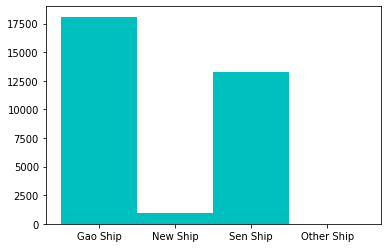

In [34]:
distribution = {
    "Gao Ship": 0,
    "New Ship": 0,
    "Sen Ship": 0,
    "Other Ship": 0,
}

for item in y_pred:
  if item == 0.0:
    distribution["Gao Ship"] += 1
  elif item == 1.0:
    distribution["New Ship"] += 1
  elif item == 2.0:
    distribution["Sen Ship"] += 1
  else:
    distribution["Other Ship"] += 1      

plt.bar(distribution.keys(), distribution.values(), width=1, color='c')

### **Step 3: Applying to Sample Client Folder**

To loop through a client provided set of sattellite images the following predictor function is provided.


In [22]:
### DONE: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from torchvision import datasets
from torchvision import utils
import torchvision.transforms as transforms
from torch.autograd import Variable
import os
import numpy as np
import torch
import torchvision.models as models
import torch
torch.cuda.empty_cache()
import torch
import pandas as pd
import numpy as np



def predict_ship_transfer(img_data):
    # load the image and return the predicted breed
        # list of class names by index, i.e. a name can be accessed like class_names[0]
    full_class_names = ['001.Gao', '002.Newship', '003.Sen', '004.Ship']#image_datasets['train'].classes
    
    #img = Image.open(img_path)
    transform_image = transforms.Compose([transforms.ToPILImage(),
                                          transforms.Resize(256),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])])
    img = transform_image(img_data)

    img = img.unsqueeze_(0)
    
    device = torch.device("cuda:0" if use_cuda else "cpu")
    
    img = img.to(device)

    img = Variable(img)
    
    model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/outmodel_scratch.pt'))

    result = model_scratch(img)
    
    #output = nn.Softmax(dim=1)
    
    prediction = result#output(result)
    
    # Get the top five possible breeds
    top_predictions = torch.topk(prediction, 4)
    
    # Get the names of breed for displaying
    full_breed_name = [full_class_names[i] for i in top_predictions[1][0]]

    probability = top_predictions[0][0]
   
    return full_breed_name, probability


Next, the client provided folder is prepared for object detection and classification.

In [39]:
def clearOutputFolder(path):
  import glob
  files = glob.glob(path + '/*')
  for f in files:
      os.remove(f)

     
evaluation_folder = '/content/drive/MyDrive/ship_detection'
evaluation_folder_output = evaluation_folder + '/output'
clearOutputFolder(evaluation_folder_output) 
sample_data_file_name = ''
file_format = '.jpg'


files = glob.glob(evaluation_folder+'/*')
counter = 0 
for path in files:
    sample_data_file_name = os.path.basename(path)
    counter += 1
    print("File Number: ", counter) 
    try:
      prepareCroppedImages(source_folder = evaluation_folder, 
                            sample_data_file_name = sample_data_file_name[:-4],
                            file_format = '.jpg', 
                            output_folder = evaluation_folder_output, 
                            ship_type = 'unknown',
                            min_area = 50,
                            max_area = 10000,
                            min_mask_value = 50,
                            denoising_weight = 0.1)
    except:
      continue  


counter = 0
print('Processing Folder: ' + evaluation_folder_output + '...')
files = glob.glob(evaluation_folder_output+'/*')
for path in files:
    counter += 1
    print("File Number: ", counter)
    c = Image.open(path)
    d = c.resize((256,256), resample=Image.BOX)
    d.save(path) 

File Number:  1


File Number:  2


File Number:  3


File Number:  4


File Number:  5


File Number:  6


File Number:  7


File Number:  8
File Number:  9


File Number:  10


File Number:  11


File Number:  12
File Number:  13


File Number:  14


File Number:  15


File Number:  16


File Number:  17


File Number:  18


File Number:  19


File Number:  20


File Number:  21


File Number:  22


File Number:  23


File Number:  24


File Number:  25


File Number:  26


File Number:  27


File Number:  28


File Number:  29


File Number:  30


File Number:  31


File Number:  32


File Number:  33


File Number:  34


File Number:  35


File Number:  36


File Number:  37


File Number:  38


File Number:  39


File Number:  40


File Number:  41


File Number:  42


File Number:  43


File Number:  44


File Number:  45


File Number:  46


File Number:  47


File Number:  48


File Number:  49


File Number:  50


File Number:  51


File Number:  52


File Number:  53


File Number:  54


File Number:  55


File Number:  56


File Number:  57


File Number:  58


File Number:  59
File Number:  60


File Number:  61


File Number:  62


File Number:  63


File Number:  64


File Number:  65


File Number:  66


File Number:  67


File Number:  68


File Number:  69


File Number:  70


File Number:  71


File Number:  72


File Number:  73


File Number:  74


File Number:  75


File Number:  76


File Number:  77


File Number:  78


File Number:  79


File Number:  80


File Number:  81


File Number:  82


File Number:  83


File Number:  84


File Number:  85


File Number:  86


File Number:  87


File Number:  88


File Number:  89


File Number:  90


File Number:  91


File Number:  92


File Number:  93


File Number:  94


File Number:  95


File Number:  96


File Number:  97


File Number:  98


File Number:  99


File Number:  100


File Number:  101


File Number:  102


File Number:  103


File Number:  104


File Number:  105


File Number:  106


File Number:  107


File Number:  108


File Number:  109


File Number:  110


File Number:  111


File Number:  112


File Number:  113
File Number:  114


File Number:  115


File Number:  116


File Number:  117


File Number:  118


File Number:  119


File Number:  120


File Number:  121


File Number:  122


File Number:  123


File Number:  124


File Number:  125


File Number:  126


File Number:  127


File Number:  128


File Number:  129


File Number:  130


File Number:  131


File Number:  132


File Number:  133


File Number:  134


File Number:  135


File Number:  136


File Number:  137


File Number:  138
File Number:  139
File Number:  140


File Number:  141


File Number:  142


File Number:  143


File Number:  144


File Number:  145


File Number:  146


File Number:  147


File Number:  148


File Number:  149


File Number:  150


File Number:  151


File Number:  152


File Number:  153


File Number:  154


File Number:  155


File Number:  156


File Number:  157


File Number:  158


File Number:  159


File Number:  160


File Number:  161


File Number:  162


File Number:  163


File Number:  164


File Number:  165


File Number:  166


File Number:  167


File Number:  168


Processing Folder: /content/drive/MyDrive/ship_detection/output...
File Number:  1
File Number:  2
File Number:  3
File Number:  4
File Number:  5
File Number:  6
File Number:  7
File Number:  8
File Number:  9
File Number:  10
File Number:  11
File Number:  12
File Number:  13
File Number:  14
File Number:  15
File Number:  16
File Number:  17
File Number:  18
File Number:  19
File Number:  20
File Number:  21
File Number:  22
File Number:  23
File Number:  24
File Number:  25
File Number:  26
File Number:  27
File Number:  28
File Number:  29
File Number:  30
File Number:  31
File Number:  32
File Number:  33
File Number:  34
File Number:  35
File Number:  36
File Number:  37
File Number:  38
File Number:  39
File Number:  40
File Number:  41
File Number:  42
File Number:  43
File Number:  44
File Number:  45
File Number:  46
File Number:  47
File Number:  48
File Number:  49
File Number:  50
File Number:  51
File Number:  52
File Number:  53
File Number:  54
File Number:  55
File Nu

Once the client folder is processed, the predictor helper function was called to report the number of ships and their classes for the original client request. 

<BarContainer object of 4 artists>

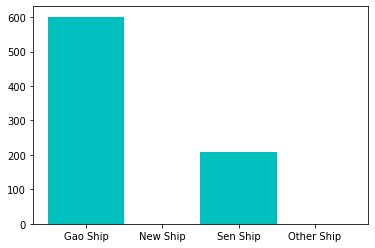

In [40]:
files = glob.glob(evaluation_folder_output+'/*')
results = {
    "Gao Ship": 0,
    "New Ship": 0,
    "Sen Ship": 0,
    "Other Ship": 0,
}

for path in files:
  img = Image.open(path)
  #plt.imshow(img)
  #plt.show()
  transform = transforms.ToTensor()
  # Convert the image to PyTorch tensor
  tensor = transform(img)
  full_breed_name, probability = predict_ship_transfer(tensor)
  #print(probability)
  #print(full_breed_name[0])
  if full_breed_name[0] == "001.Gao":
    results['Gao Ship'] += 1
  elif full_breed_name[0] == "002.Newship":
    results['New Ship'] += 1  
  elif full_breed_name[0] == "003.Sen":
    results['Sen Ship'] += 1
  elif full_breed_name[0] == "004.Ship":
    results['Other Ship'] += 1    

plt.bar(results.keys(), results.values(), width=1, color='c')